In [1]:
import numpy as np
from AFVB_PCE import *
from aPCE import *
from ME_PCE import *
from VRVM_PCE import *
import test_functions as tf
from sklearn.metrics import mean_squared_error
import skopt
import time
from skopt import BayesSearchCV
from sensitivity_analysis import *
from PCE_Full_Model import *
import scipy.integrate as integrate
import scipy.special as special
from scipy.stats import multivariate_normal
from sklearn.model_selection import GridSearchCV
from numpy.polynomial.legendre import legval, leggauss
from basis_functions import basis
from scipy.special import legendre
from basis_functions import *
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

In [2]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import sys

In [3]:
## Directory where I want the plots saved
wd = '/Users/chave/Desktop/ThesisFiles/SparseBayesianLearning/images'

In [4]:
def create_dataAB(dataA, dataB, variable_index_to_fix):
    dataB_withA = dataB.copy()
    dataB_withA[:, variable_index_to_fix] = dataA[:, variable_index_to_fix]
    return dataB_withA

In [5]:
def collect_results_PCE(p, d, fun, params, X_train, X_pol, X_test, Y_train, Y_test, PCE_method, 
                        sparse_model, B_init = None, sigma_vals = None, mu_vals = None):

    """
    p: list of p-values
    B_init: list of tthe form [[a,b],[a,b],...,[a,b]]
    sparse_method: AFVB_PCe or VRVM_PCe
    PCE_method: 'aPCE' or 'PCE_Legendre' or 'aPCE_Stieltjes'
    hyper_params: pxn_params array
    
    Return: Error_full, Error_sparse, Si_sparse, Ti_sparse, mean_sparse, V_sparse, n_star
    """

    Error_full = []
    Error_sparse = []
    
    Error_full_t = []
    Error_sparse_t = []

    mean_sparse = []
    V_sparse = []
    mean_full = []
    V_full = []
    Si_sparse = []
    Ti_sparse = []
    n_star = []
    models = []
    
    sa = sobol_GSA(d, fun)

    for i in range(len(p)):
        
        if (PCE_method == 'aPCE'):
            mod = aPCE(X_pol, p[i]) 
            P = mod.Create_Orthonormal_Polynomials(p[i])
        elif (PCE_method == 'aPCE_Stieltjes'):
            mod = aPCE(X_pol, p[i]) 
            P = mod.Create_Orthonormal_Polynomials_Stieltjes(p[i])
        else:
            mod = None
            P = None
        t0 = time.time()
        
        params_list = np.zeros(4)

        if (len(list(params[i].values()))==4):
            params_list = list(params[i].values())

        elif (len(list(params[i].values()))==2):
            params_list[[0,2]] = list(params[i].values())[0]
            params_list[[1,3]] = list(params[i].values())[1]

        elif (len(list(params[i].values()))==1):
            params_list[:] = list(params[i].values())[0]
        else:
            print("Invalid Parameters Given")
        
        
        temp_model = sparse_model(PCE_method, d, p[i], B_init, mod, P, 
                              params_list[0], 
                              params_list[1], 
                              params_list[2], 
                              params_list[3], 
                              sigma_vals = sigma_vals, mu_vals = mu_vals)
                
        temp_model.fit(X_train, Y_train)
        
        print(time.time()-t0)
        print('p =', p[i], 'n* = ', temp_model.n_star)
        models.append(temp_model)
        mean_sparse.append(temp_model.a_hat[0])
        V_sparse.append(sa.sobol_PCE(p[i], temp_model.a_hat, temp_model.active_cols)[1])
        mean_full.append(temp_model.a_full[0])
        n = int(math.factorial(d+p[i])/(math.factorial(d)*math.factorial(p[i])))
        V_full.append(sa.sobol_PCE(p[i], temp_model.a_full, np.array(range(n)))[1])        
        Si_sparse.append(sa.sobol_PCE(p[i], temp_model.a_hat, temp_model.active_cols)[0]['1st Order'])
        Ti_sparse.append(sa.sobol_PCE(p[i], temp_model.a_hat, temp_model.active_cols)[0]['Total Order'])
        n_star.append(temp_model.n_star)
        
        den_error = np.sqrt(np.mean(Y_test)**2)
        
        Error_full.append(np.sqrt(mean_squared_error(Y_test, temp_model.predict(X_test, sparse = False)))/den_error)
        Error_sparse.append(np.sqrt(mean_squared_error(Y_test, temp_model.predict(X_test, sparse = True)))/den_error)

        
        den_error_t = np.sqrt(np.mean(Y_train)**2)
        
        Error_full_t.append(np.sqrt(mean_squared_error(Y_train, temp_model.predict(X_train, sparse = False)))/den_error_t)
        Error_sparse_t.append(np.sqrt(mean_squared_error(Y_train, temp_model.predict(X_train, sparse = True)))/den_error_t)

    return Error_full, Error_sparse, Si_sparse, Ti_sparse, mean_sparse, V_sparse, Error_full_t, Error_sparse_t, n_star, models


In [6]:
def multivariate_pce_index(d, max_deg):
    """
    Generate all the d-dimensional polynomial indices with the 
    constraint that the sum of the indexes is <= max_deg

    input:
    d: int, number of random variables
    max_deg: int, the max degree allowed

    return: 
    2d array with shape[1] equal to d, the multivariate indices
    """
    maxRange = max_deg*np.ones(d, dtype = 'int')
    index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])

    return index

In [7]:
def collect_results_ME(p, d, fun, params, X_test, PCE_method, sparse_model, N_t, 
                       N_p, data_fun, B_init, sigma_vals = None, mu_vals = None, 
                       n_iter = 1, p_split = 4, B_split_in = None, theta1=0.0000001, theta2=0.0000001, 
                       alpha=1/2, params_init = None, N_t_split = 80):

    """
    p: list of p-values
    B_init: list of tthe form [[a,b],[a,b],...,[a,b]]
    sparse_method: AFVB_PCe or VRVM_PCe
    PCE_method: 'aPCE' or 'PCE_Legendre' or 
    hyper_params: pxn_params array
    
    Return: Error_full, Error_sparse, Si_sparse, Ti_sparse, mean_sparse, V_sparse, n_star
    """

    Error_full = []
    Error_sparse = []

    mean_sparse = []
    V_sparse = []
    mean_full = []
    V_full = []
    Si_sparse = []
    Ti_sparse = []
    n_star = []
    models = []
    
    sa = sobol_GSA(d, fun)
    
    if (sparse_model == AFVB_PCE):
        Full_Model = PCE_Full_Model
    elif (sparse_model == VRVM_PCE):
        Full_Model = VRVM_PCE
        print("VRVM_PCE")

        
    params_init_list = np.array(list(params_init.values())*(4**d)).reshape(4**d,4)


    temp_model0 = ME_PCE('aPCE', d, p_split, [B_init], fun, PCE_Full_Model, data_fun, N_t_split, N_p,
                               theta1[p_split-1], theta2[p_split-1], alpha, 
                               params_init_list[:,0],
                               params_init_list[:,1],
                               params_init_list[:,2],
                               params_init_list[:,3],
                               sigma_vals = sigma_vals, mu_vals = mu_vals, n_iter = n_iter)
    temp_model0.fit(None, None)

    M = (temp_model0.B_split).shape[0]
    Jk = temp_model0.Jk
    Jk_i = temp_model0.Jk_i
        
    for i in range(len(p)):
        
        t0 = time.time()
        
        params_list = np.zeros((M, 4))
        
        if (len(list(params[i][0].values()))==4):
            for l in range(M):
                params_list[l, :] = list(params[i][l].values())

        elif (len(list(params[i][0].values()))==2):
            for l in range(M):
                params_list[l, [0,2]] = list(params[i][l].values())[0]
                params_list[l, [1,3]] = list(params[i][l].values())[1]
                
        elif (len(list(params[i][0].values()))==1):
            for l in range(M):
                params_list[l, :] = list(params[i][l].values())[0]
        else:
            print("Invalid Parameters Given")
        
        temp_model = ME_PCE(PCE_method, d, p[i], [B_init], fun, sparse_model, data_fun, N_t[i], N_p,
                                   theta1[i], theta2[i], alpha, 
                                   params_list[:,0],
                                   params_list[:,1],
                                   params_list[:,2],
                                   params_list[:,3],
                                   sigma_vals = sigma_vals, mu_vals = mu_vals, n_iter = 0, 
                                   B_split_in = temp_model0.B_split)
        
        models.append(temp_model)
        
        B = temp_model0.B_split
        X_t = data_fun(N_t[i], d, B[0])
        
        for j in range(1, M):
            X_t = np.concatenate((X_t, data_fun(N_t[i], d, B[j])))

        Y_t = fun(X_t)
        
        temp_model.fit(X_t, Y_t)

        
        print('time =', time.time()-t0)
        print('p =', p[i], 'M =', M)
        print('n_star:', temp_model.n_star_local)
        
        global_mean = np.sum(temp_model.mean_local*Jk)
        global_V = np.sum(temp_model.v_local*Jk + temp_model.mean_local**2*Jk-global_mean**2*Jk)

        Vi_extra_terms = []
        VTi_extra_terms = []
        
        for l in range(d):
            
            l_temp = list(range(d))
            l_temp.remove(l)
            
            temp_sum = 0
            
            Jk_t_not_i = np.zeros(d)
            Jk_k_not_i = np.zeros(d)
            for t in range(M-1):
                for k in range(t,M-1):
                    for j in range(d):
                        Jk_t_not_i[j] = np.product(np.delete(Jk_i[t], j))
                        Jk_k_not_i[j] = np.product(np.delete(Jk_i[k+1], j))
                        
                    interval1 = pd.Interval(B[t][l][0], B[t][l][1], closed = 'neither') 
                    interval2 = pd.Interval(B[k+1][l][0], B[k+1][l][1], closed = 'neither') 

                    if (interval1.overlaps(interval2)):
                        intersect_value = 1*min(Jk_i[t][l], Jk_i[k+1][l])

                    else:
                        intersect_value = 0

                    idx = multivariate_pce_index(d, p[i])
                    n = int(math.factorial(d+p[i])/(math.factorial(d)*math.factorial(p[i])))

                    vec1 = np.zeros((n,1))
                    vec1[temp_model.active_cols_local[t]] = np.c_[temp_model.a_local[t]]

                    vec2 = np.zeros((n,1))
                    vec2[temp_model.active_cols_local[k+1]] = np.c_[temp_model.a_local[k+1]]

                    a_b_vec = np.c_[np.multiply(np.sum(idx[:,l_temp],1)==0,1)]

                    temp_sum += 2*np.sum(vec1*vec2*a_b_vec)*Jk_t_not_i[l]*Jk_k_not_i[l]*intersect_value
                    #if (l == 1):
                        #print('j= ', t+1, Jk_t_not_i[l], Jk_k_not_i[l], Jk_i[t][l], Jk_i[k+1][l], intersect_value)
            Vi_extra_terms.append(temp_sum)
            
        for l in range(d):
            l_temp = list(range(d))
            l_temp.remove(l)
            temp_sum = 0

            for t in range(M-1):
                for k in range(t,M-1):
                    for j in range(d):
                        Jk_t_not_i[j] = np.product(np.delete(Jk_i[t], j))
                        Jk_k_not_i[j] = np.product(np.delete(Jk_i[k+1], j))
                    intersect_count = 0
                    for s in range(len(l_temp)):
                        interval1 = pd.Interval(B[t][l_temp[s]][0], B[t][l_temp[s]][1], closed = 'neither') 
                        interval2 = pd.Interval(B[k+1][l_temp[s]][0], B[k+1][l_temp[s]][1], closed = 'neither')
                        if (interval1.overlaps(interval2)):
                            intersect_count += 1
                            
                    if (intersect_count == d-1):
                        intersect_value = 1*min(Jk_t_not_i[l], Jk_k_not_i[l])

                    else:
                        
                        intersect_value = 0

                    idx = multivariate_pce_index(d, p[i])
                    n = int(math.factorial(d+p[i])/(math.factorial(d)*math.factorial(p[i])))

                    vec1 = np.zeros((n,1))
                    vec1[temp_model.active_cols_local[t]] = np.c_[temp_model.a_local[t]]

                    vec2 = np.zeros((n,1))
                    vec2[temp_model.active_cols_local[k+1]] = np.c_[temp_model.a_local[k+1]]

                    a_b_vec = np.c_[np.multiply(np.c_[idx[:,l]==0],1)]

                    temp_sum += 2*np.sum(vec1*vec2*a_b_vec)*Jk_i[t][l]*Jk_i[k+1][l]*intersect_value
            VTi_extra_terms.append(temp_sum)
            
        mean_sparse.append(global_mean)
        V_sparse.append(global_V)
        
        Vi_temp = 0
        VTi_temp = 0
        
        n = int(math.factorial(d + p[i])/(math.factorial(d)*math.factorial(p[i])))
        a_full_sparse = np.zeros(n)
        for k in range(M):
            a_size = temp_model.a_local[k].shape[0]
            a_full_sparse[temp_model.active_cols_local[k]] += np.reshape(temp_model.a_local[k], (a_size,))
        
        Jk_not_i = np.zeros(d)
        
        for k in range(M):
            for j in range(d):
                Jk_not_i[j] = np.product(np.delete(Jk_i[k], j))
            Vi_temp += (sa.sobol_PCE(p[i], temp_model.a_local[k], temp_model.active_cols_local[k])[0]['Partial Variance']+temp_model.mean_local[k]**2)*Jk_not_i*Jk[k]
        Vi_temp += - global_mean**2 + Vi_extra_terms
        print(Vi_temp)
        
        Si_sparse.append(Vi_temp/global_V)

        for k in range(M):
            VTi_temp += (sa.sobol_PCE(p[i], temp_model.a_local[k], temp_model.active_cols_local[k])[0]['Total Variance']*Jk_i[k] + (temp_model.v_local[k] + (temp_model.mean_local[k])**2)*(1-Jk_i[k]))*Jk[k]             
        
        VTi_temp -= VTi_extra_terms
        
        Ti_sparse.append(VTi_temp/global_V)
        
        print(VTi_temp)
        print(global_V, global_mean)

        den_error = np.sqrt(np.mean(Y_test)**2)
        
        Error_full.append(np.sqrt(mean_squared_error(Y_test, temp_model.predict(X_test, sparse = False)))/den_error)
        Error_sparse.append(np.sqrt(mean_squared_error(Y_test, temp_model.predict(X_test, sparse = True)))/den_error)

    return Error_full, Error_sparse, Si_sparse, Ti_sparse, mean_sparse, V_sparse, n_star, models


In [8]:
def Find_B_split(p, d, fun, params, X_test, PCE_method, sparse_model, N_t, N_p, data_fun, B_init, sigma_vals = None, mu_vals = None, n_iter = 1, data_fun2 = None, theta1=0.0000001, theta2=0.0000001, alpha=0.5):

    """

    """

    if (sparse_model == AFVB_PCE):
        Full_Model = PCE_Full_Model
    elif (sparse_model == VRVM_PCE):
        Full_Model = VRVM_PCE
        print("VRVM_PCE")
    

    for i in range(len(p)):
        params_init_list = np.array(list(params.values())*(2**(2*d))).reshape(2**(2*d),4)
        t0 = time.time()
        temp_model0 = ME_PCE(PCE_method, d, p[i], [B_init], fun, Full_Model, data_fun, N_t[i], N_p,
                                   theta1[i], theta2[i], alpha, 
                                   params_init_list[:,0],
                                   params_init_list[:,1],
                                   params_init_list[:,2],
                                   params_init_list[:,3],
                                   sigma_vals = sigma_vals, mu_vals = mu_vals, n_iter = n_iter)
        temp_model0.fit(None, None)
        
        M = (temp_model0.B_split).shape[0]

        
        print('time =', time.time()-t0)
        print('p =', p[i], 'M =', M)
        print(temp_model0.Jk_i)


In [9]:
params_init_AFVB = OrderedDict([('A_0', 1e-2), ('B_0', 1e-4), ('C_0', 1e-2), ('D_0', 1e-4)])

In [10]:
params_init_VRVM = OrderedDict([('omega_a', 1e-8), ('omega_b', 1e-8), ('C_0', 1e-8), ('D_0', 1e-8)])


# Example 1: Ishigami Function

In [21]:
N_train = 200
N_test = 50
N_pol = 1000000

d = 3

In [22]:
np.random.seed(2357)

X_train = np.random.uniform(-np.pi, np.pi, (N_train, d))
X_test = np.random.uniform(-np.pi, np.pi, (N_test, d))
X_pol = np.random.uniform(-np.pi, np.pi, (N_pol, d))

Y_train = tf.ishigami(X_train)
Y_test = tf.ishigami(X_test)

In [23]:
sa = sobol_GSA(d, tf.ishigami)

V_Ishigami = 7**2/8 + 0.1*np.pi**4/5 + 0.1**2*np.pi**8/18 + 1/2
GSA_Ishigami = ([1/2*(1+0.1*np.pi**4/5)**2, 7**2/8, 0],
                [1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225, 7**2/8, 8*0.1**2*np.pi**8/225],
                [1/2*(1+0.1*np.pi**4/5)**2/V_Ishigami, 7**2/8/V_Ishigami, 0],
                [(1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225)/V_Ishigami, 7**2/8/V_Ishigami, 8*0.1**2*np.pi**8/225/V_Ishigami])
GSA_Ishigami = pd.DataFrame(GSA_Ishigami).T
GSA_Ishigami.columns = ['Partial Variance', 'Total Variance', '1st Order', 'Total Order']

In [24]:
def data_ishigami(N, d, B):
    np.random.seed(9)
    X = np.zeros((N, d))
    for i in range(d):
        X[:,i] = np.random.uniform(B[i][0], B[i][1], size = N)
    return X

In [25]:
B_init_aPCE = []
for i in range(d):
    B_init_aPCE.append([np.min([X_train[:,i].min(), X_test[:,i].min(), X_pol[:,i].min()]), np.max([X_train[:,i].max(), X_test[:,i].max(), X_pol[:,i].max()])])


In [26]:
B_init_PCE = [[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]

In [27]:
p = list(range(1,13))

## Building Full PCE Model

In [143]:
p = [5,6,7]

for i in range(len(p)):
    
    t0 = time.time()

    param_space = {'A_0': skopt.space.Real(1e-6, 1e-1),
                    'B_0': skopt.space.Real(1e-6, 1e-1),
                    'C_0': skopt.space.Real(1e-6, 1e-1),
                    'D_0': skopt.space.Real(1e-6, 1e-1)
                }

    optimizer = BayesSearchCV(estimator = PCE_Full_Model('PCE_Legendre', d = d, p = p[i], domain = B_init_PCE),
                                search_spaces = param_space,
                                n_iter = 20,
                                n_jobs = 5,
                                n_points = 1,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print(time.time() - t0)

    print('p =', p[i], optimizer.best_params_)

7.251723051071167
p = 5 OrderedDict([('A_0', 0.06550603003882847), ('B_0', 0.055893785018059354), ('C_0', 0.06355126417652529), ('D_0', 0.0008952052130374002)])
10.660778999328613
p = 6 OrderedDict([('A_0', 0.07067965493599891), ('B_0', 0.005490134010285527), ('C_0', 0.0747718148610938), ('D_0', 0.0003915220501330195)])
19.22964310646057
p = 7 OrderedDict([('A_0', 0.09723612551152694), ('B_0', 0.1), ('C_0', 0.023563921377554142), ('D_0', 1e-06)])


In [28]:
p = list(range(1,13))

best_params_full = [OrderedDict([('A_0', 1e-6), ('B_0', 1e-6), ('C_0', 1e-6), ('D_0', 1e-6)])]*4\
                    + [OrderedDict([('A_0', 0.06550603003882847), ('B_0', 0.055893785018059354), ('C_0', 0.06355126417652529), ('D_0', 0.0008952052130374002)]),
                       OrderedDict([('A_0', 0.07067965493599891), ('B_0', 0.005490134010285527), ('C_0', 0.0747718148610938), ('D_0', 0.0003915220501330195)]),
                       OrderedDict([('A_0', 0.09723612551152694), ('B_0', 0.1), ('C_0', 0.023563921377554142), ('D_0', 1e-06)])
                        ] \
                    + [OrderedDict([('A_0', 1e-6), ('B_0', 1e-6), ('C_0', 1e-6), ('D_0', 1e-6)])]*5
                                

In [29]:
results_Ishigami_full = collect_results_PCE(p, d, tf.ishigami, best_params_full, 
                                                X_train, None, X_test, Y_train, Y_test, 'PCE_Legendre', PCE_Full_Model, B_init_PCE)



0.0784299373626709
p = 1 n* =  4
0.09978079795837402
p = 2 n* =  10
0.19923615455627441
p = 3 n* =  20
0.33466601371765137
p = 4 n* =  35
0.17876911163330078
p = 5 n* =  56
0.24387097358703613
p = 6 n* =  84
2.6626522541046143
p = 7 n* =  120
7.019934892654419
p = 8 n* =  165
10.21188998222351
p = 9 n* =  220
14.262063264846802
p = 10 n* =  286
23.87176012992859
p = 11 n* =  364
36.42369985580444
p = 12 n* =  455


# AFVB

## Global Models

### aPCE

In [144]:
p = [5,6,7]

for i in range(len(p)):
    
    mod = aPCE(X_pol, p[i])
    P = mod.Create_Orthonormal_Polynomials(p[i])
    
    t0 = time.time()

    param_space = {'A_0': skopt.space.Real(1e-6, 1e-1),
                    'B_0': skopt.space.Real(1e-6, 1e-1),
                    'C_0': skopt.space.Real(1e-6, 1e-1),
                    'D_0': skopt.space.Real(1e-6, 1e-1)
                }

    optimizer = BayesSearchCV(estimator = AFVB_PCE('aPCE', d = d, p = p[i], aPCE_model = mod, P = P),
                                search_spaces = param_space,
                                n_iter = 20,
                                n_jobs = 5,
                                n_points = 1,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print(time.time() - t0)

    print('p =', p[i], optimizer.best_params_)

15.49258303642273
p = 5 OrderedDict([('A_0', 0.06313362436936534), ('B_0', 0.04618596532768074), ('C_0', 0.08154523633075797), ('D_0', 0.03203041266006677)])
26.588237047195435
p = 6 OrderedDict([('A_0', 0.005604534393193619), ('B_0', 0.1), ('C_0', 1e-06), ('D_0', 1e-06)])
39.221604108810425
p = 7 OrderedDict([('A_0', 0.00848930087966844), ('B_0', 0.015970346652047163), ('C_0', 0.017272604190103274), ('D_0', 0.05340522711924693)])


In [30]:
best_params_AFVB_Global_aPCE = [OrderedDict([('A_0', 1e-6), ('B_0', 1e-6), ('C_0', 1e-6), ('D_0', 1e-6)])]*4\
                                + [OrderedDict([('A_0', 0.06313362436936534), ('B_0', 0.04618596532768074), ('C_0', 0.08154523633075797), ('D_0', 0.03203041266006677)]),
                                   OrderedDict([('A_0', 0.005604534393193619), ('B_0', 0.1), ('C_0', 1e-06), ('D_0', 1e-06)]),
                                   OrderedDict([('A_0', 0.00848930087966844), ('B_0', 0.015970346652047163), ('C_0', 0.017272604190103274), ('D_0', 0.05340522711924693)])
                                ] \
                                + [OrderedDict([('A_0', 1e-6), ('B_0', 1e-6), ('C_0', 1e-6), ('D_0', 1e-6)])]*5


In [31]:
p = list(range(1,13))
results_Ishigami_AFVB_aPCE_Global = collect_results_PCE(p, d, tf.ishigami, best_params_AFVB_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, Y_test, 'aPCE', AFVB_PCE, None)

0.0935208797454834
p = 1 n* =  2
0.22321105003356934
p = 2 n* =  2
0.4231429100036621
p = 3 n* =  4
0.7042710781097412
p = 4 n* =  5
0.7047898769378662
p = 5 n* =  8
1.599153995513916
p = 6 n* =  10
2.037017822265625
p = 7 n* =  12
12.315058946609497
p = 8 n* =  13
16.44088387489319
p = 9 n* =  14
27.394165992736816
p = 10 n* =  18
34.28871178627014
p = 11 n* =  20
69.69621777534485
p = 12 n* =  33


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


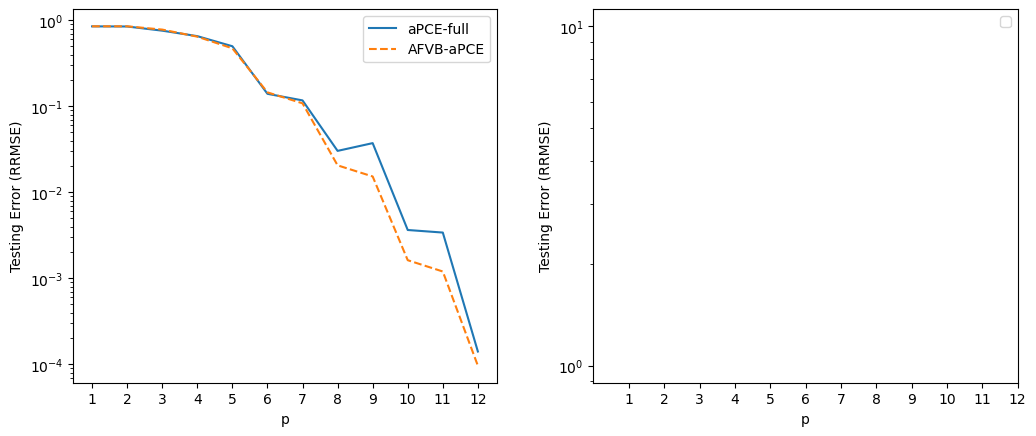

In [33]:
p = list(range(1,13))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, results_Ishigami_full[0], '-', label = 'aPCE-full')

#ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[0], '-', label = 'aPCE')
ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')


#ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[6], '-', label = 'aPCE_Train')
#ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[7], '--', label = 'AFVB-aPCE_Train')

ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RRMSE)")
ax[0].legend()

#ax[1].plot(p, results_Ishigami_AFVB_PCE_Global[0], '-', label = 'PCE')
#ax[1].plot(p, results_Ishigami_AFVB_PCE_Global[1], '--', label = 'AFVB-PCE')

#ax[1].plot(p, results_Ishigami_AFVB_aPCE_Global2[6], '-', label = 'aPCE_Train')
#ax[1].plot(p, results_Ishigami_AFVB_aPCE_Global2[7], '--', label = 'AFVB-aPCE_Train')

ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RRMSE)")
ax[1].legend()

fig.tight_layout(pad = 3.0);
#plt.savefig(wd + '/Ishigami_AFVB_Error.png')

### aPCE Steiltjes

In [43]:
results_Ishigami_AFVB_aPCE_Stieltjes_Global = collect_results_PCE(p, d, tf.ishigami, best_params_AFVB_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE_Stieltjes', AFVB_PCE, None)


0.04935789108276367
p = 1 n* =  2
0.12186908721923828
p = 2 n* =  2
0.3152031898498535
p = 3 n* =  4
0.6014599800109863
p = 4 n* =  5
0.8556210994720459
p = 5 n* =  8
1.122642993927002
p = 6 n* =  10
1.8192670345306396
p = 7 n* =  12
5.373280048370361
p = 8 n* =  13
12.96587586402893
p = 9 n* =  16
25.811359882354736
p = 10 n* =  20
88.14553904533386
p = 11 n* =  20
42.30066418647766
p = 12 n* =  33


### PCE

In [346]:
best_params_AFVB_Global_PCE = [OrderedDict([('A_0', 0.0001), ('B_0', 0.01), ('C_0', 0.0001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.007840169343754918), ('C_0', 0.1), ('D_0', 0.0008718417556152156)]), OrderedDict([('A_0', 0.1), ('B_0', 1e-08), ('C_0', 0.09292952851881643), ('D_0', 0.006742869824885469)]), OrderedDict([('A_0', 0.04485521114938661), ('B_0', 0.01), ('C_0', 0.004028550984873166), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 1e-08), ('C_0', 0.04833071135059623), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.09845764266298532), ('B_0', 0.009976627087574044), ('C_0', 0.0017451832562558058), ('D_0', 0.0502537911543109)]), OrderedDict([('A_0', 0.011758765072618301), ('B_0', 0.006026362674038061), ('C_0', 0.006695274277446524), ('D_0', 0.0021856839066875496)]), 

OrderedDict([('A_0', 0.0001), ('B_0', 0.00018643395710807377), ('C_0', 0.0001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.03424311234082305), ('B_0', 0.007749213519350189), ('C_0', 0.0009668362903791553), ('D_0', 0.09305386260686979)]), OrderedDict([('A_0', 0.03894227072239515), ('B_0', 0.001289919476638003), ('C_0', 0.09011945998820867), ('D_0', 0.09544482191680294)]), OrderedDict([('A_0', 0.07122319971667689), ('B_0', 0.0010563197914796195), ('C_0', 0.0805614496150982), ('D_0', 0.07032409955386702)]), OrderedDict([('A_0', 0.09356164532331783), ('B_0', 1e-06), ('C_0', 0.055590256502889165), ('D_0', 0.0002714624277824121)])]


In [83]:
best_params_AFVB_Global_PCE = [OrderedDict([('A_0', 1e-6), ('B_0', 1e-6), ('C_0', 1e-6), ('D_0', 1e-6)])]*12

In [84]:
results_Ishigami_AFVB_PCE_Global = collect_results_PCE(p, d, tf.ishigami, best_params_AFVB_Global_PCE, 
                                                X_train, X_pol, X_test, Y_train, Y_test, 'PCE_Legendre', AFVB_PCE, B_init_PCE)


0.09770393371582031
p = 1 n* =  2
0.15871691703796387
p = 2 n* =  2
0.3556039333343506
p = 3 n* =  3
0.5370182991027832
p = 4 n* =  5
0.836759090423584
p = 5 n* =  6
1.3677020072937012
p = 6 n* =  9
4.1279332637786865
p = 7 n* =  10
6.8920509815216064
p = 8 n* =  13
10.426011085510254
p = 9 n* =  14
19.18373417854309
p = 10 n* =  17
27.116275310516357
p = 11 n* =  18
42.72356820106506
p = 12 n* =  21


## Local Models

In [456]:
p = list(range(4,5))
N_t = [100]*10

theta1 = [[1e-2, 1e-3]]

theta2 = [[1e-2, 1e-3]]

Find_B_split(p, d, tf.ishigami, params_init_AFVB, 
                X_test, 'aPCE', AFVB_PCE, N_t, N_pol, data_ishigami, 
                B_init_aPCE, None, None, n_iter = 2, 
                theta1 = theta1, theta2 = theta2, alpha = 0.5)

time = 7.866476058959961
p = 4 M = 4
[[1.   0.25 1.  ]
 [1.   0.25 1.  ]
 [1.   0.25 1.  ]
 [1.   0.25 1.  ]]


### aPCE

In [108]:
# M = 8
theta1 = [[1e-12, 1e-1],  # p = 1
          [1e-1, 1e-1],  # p = 2
          [1e-1, 1e-1],  # p = 3
          [1e-1, 1e-1],  # p = 4
          [1e-1, 1e-1],  # p = 5
          [1e-1, 1e-5],  # p = 6
          [1e-1, 1e-1],  # p = 7
          [1e-2, 1e-5] 
] # p = 8

theta2 = [[1e-12, 1e-2],  # p = 1
          [1e-1, 1e-1],  # p = 2
          [4e-1, 1.1e-1],  # p = 3
          [1e-1, 1e-2],  # p = 4
          [9e-1, 1e-1],  # p = 5
          [1e-1, 5e-5],  # p = 6
          [1e-1, 1e-1],  # p = 7
          [1e-2, 1e-5]
]  # p = 8

In [296]:
# M = 16
theta1 = [[1e-12, 1e-1],
          [1e-12, 1e-1],
          [1e-12, 1e-2],
          [1e-12, 1e-2], # p = 4
          [1e-12, 1e-2],
          [1e-12, 1e-3],
          [1e-12, 1e-3],
          [1e-12, 1e-3],
          [1e-12, 1e-3]]

theta2 = [[1e-12, 1e-1],
          [1e-12, 5e-1],
          [1e-12, 9.5e-1],
          [1e-12, 1e-1], # p = 4
          [1e-12, 9e-1],
          [1e-12, 1e-1],
          [1e-12, 8e-1],
          [1e-12, 1e-1],
          [1e-12, 1e-3]]

In [297]:
# June 10, N_t = 200, M = 16

best_params_AFVB_ME_aPCE = [[OrderedDict([('A_0', 0.09984114053944766), ('B_0', 0.0007333024336031044), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09746766185904067), ('B_0', 0.0005487190321317659), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0006235551104165323), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0003362146791390593), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09984124811042629), ('B_0', 0.000733301824651208), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09861256885111068), ('B_0', 0.00021653110062740163), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0006227915511755692), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09984166545681894), ('B_0', 0.000733315326839179), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.002298963578612862), ('B_0', 0.0009267417111597422), ('C_0', 0.04662908382826456), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0006231678000472515), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.002298974715071208), ('B_0', 0.0009267418540736384), ('C_0', 0.046629063919565734), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0006231941834066344), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0028497154352523325), ('B_0', 0.000270040213885068), ('C_0', 0.1), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0007339079249118754), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.001), ('B_0', 0.0005983821144892347), ('C_0', 0.1), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09931567967143255), ('B_0', 4.565151121119899e-05), ('C_0', 0.001), ('D_0', 0.1)])], 

                            [OrderedDict([('A_0', 0.09746704856505979), ('B_0', 0.0005487148860678318), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09984360723070344), ('B_0', 0.0007333028420470248), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09983083215828774), ('B_0', 0.0007332041606321699), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0979109842692425), ('B_0', 0.000915844231213726), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09501828415181429), ('B_0', 0.000482838143202128), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09822037392712409), ('B_0', 0.0009962181414174354), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09481610081327585), ('B_0', 9.94952400233818e-05), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09488468828640718), ('B_0', 9.488209743295286e-05), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09809736137736332), ('B_0', 5.73622538647949e-05), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09497039183227271), ('B_0', 9.327768067348797e-05), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0006222359869073076), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0003363786616813503), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0007342072872022307), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0999462364393099), ('B_0', 0.0007337540299905077), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09984105856147205), ('B_0', 0.0007333046780345907), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0998413743826063), ('B_0', 0.000733303692074259), ('C_0', 0.001), ('D_0', 0.1)])],

                            [OrderedDict([('A_0', 0.002298105073696935), ('B_0', 0.0001320021050677576), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.05044250936920588), ('B_0', 0.0003192994580225659), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0022981057468357234), ('B_0', 0.0001320021115502131), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0504426877002937), ('B_0', 0.0003192994474937081), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.01132530808660363), ('B_0', 0.0008764886837087269), ('C_0', 0.09877800669280927), ('D_0', 0.005463696412559229)]), OrderedDict([('A_0', 0.05383468378029353), ('B_0', 0.000676915188204009), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.01132530808660363), ('B_0', 0.0008764886837087269), ('C_0', 0.09877800669280927), ('D_0', 0.005463696412559229)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0008376084849784692), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0023162769054458285), ('B_0', 0.00013216192230617506), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.002296981762794097), ('B_0', 0.0001319920225642582), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.002316288826947009), ('B_0', 0.00013216202622066695), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0022969873527802004), ('B_0', 0.00013199207261013488), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 7.40198101308252e-05), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.06556631946278413), ('B_0', 0.0006127641710746487), ('C_0', 0.08324723712827628), ('D_0', 0.0027822561463140346)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0006981306047338819), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.06556631708516616), ('B_0', 0.0006127641608358918), ('C_0', 0.08324684471886101), ('D_0', 0.00278318635778641)])],

                            [OrderedDict([('A_0', 0.023216033946376117), ('B_0', 1e-05), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.02387055075448423), ('B_0', 0.0001623118654026187), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.05323230803675836), ('B_0', 0.001), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0371178285431579), ('B_0', 0.0009949887089177978), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.001), ('B_0', 0.001), ('C_0', 0.001), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.07826430304971162), ('B_0', 0.00011959946347438018), ('C_0', 0.001), ('D_0', 0.057732828181940095)]), OrderedDict([('A_0', 0.013343781145992765), ('B_0', 0.001), ('C_0', 0.001), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.04596059004315123), ('B_0', 0.0009153219327789713), ('C_0', 0.001), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.03711841904924539), ('B_0', 0.0009949813173322985), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0004725010507921933), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.03711841987145224), ('B_0', 0.0009949812966569755), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0009771088703152888), ('C_0', 0.001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.019747183156668104), ('B_0', 0.0002337115779934867), ('C_0', 0.001), ('D_0', 0.025404150541673387)]), OrderedDict([('A_0', 0.005228166085674401), ('B_0', 0.0006104354241182426), ('C_0', 0.001), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.079239525637921), ('B_0', 0.0007163410658278613), ('C_0', 0.001), ('D_0', 0.014143093000970079)]), OrderedDict([('A_0', 0.001), ('B_0', 0.001), ('C_0', 0.001), ('D_0', 1e-05)])],

                            #[OrderedDict([('A_0', 0.05405045584333006), ('B_0', 0.0006860220945177452), ('C_0', 0.016600570587547606), ('D_0', 0.041242223403185244)]), OrderedDict([('A_0', 0.01707736895575136), ('B_0', 0.0009911621853600217), ('C_0', 0.01677967889619047), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 1e-05), ('C_0', 0.014311300152693319), ('D_0', 0.1)]), OrderedDict([('A_0', 0.03316880162654128), ('B_0', 0.000974804023840154), ('C_0', 0.01681718875401629), ('D_0', 0.1)]), OrderedDict([('A_0', 0.05636550104332376), ('B_0', 0.0007932425221199087), ('C_0', 0.0646351582306462), ('D_0', 0.01700440711199298)]), OrderedDict([('A_0', 0.0832411739327567), ('B_0', 0.00014913206481447655), ('C_0', 0.047324684048465855), ('D_0', 0.0008908420260285091)]), OrderedDict([('A_0', 0.019683204823015426), ('B_0', 0.0006173857866756341), ('C_0', 0.07026553076803473), ('D_0', 0.0031547857706134943)]), OrderedDict([('A_0', 0.0832411739327567), ('B_0', 0.00014913206481447655), ('C_0', 0.047324684048465855), ('D_0', 0.0008908420260285091)]), OrderedDict([('A_0', 0.08337325493687478), ('B_0', 1e-05), ('C_0', 0.013314456014299408), ('D_0', 0.016835563613046764)]), OrderedDict([('A_0', 0.044622421287501074), ('B_0', 1e-05), ('C_0', 0.017216251385847363), ('D_0', 0.0941929729675158)]), OrderedDict([('A_0', 0.004111118128270386), ('B_0', 0.001), ('C_0', 0.011385636525641184), ('D_0', 0.1)]), OrderedDict([('A_0', 0.08391659670009481), ('B_0', 0.0008280739463201252), ('C_0', 0.01913908350995161), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0832411739327567), ('B_0', 0.00014913206481447655), ('C_0', 0.047324684048465855), ('D_0', 0.0008908420260285091)]), OrderedDict([('A_0', 0.059289186909905735), ('B_0', 0.0009117064393098996), ('C_0', 0.07649169488153545), ('D_0', 0.0002209717022552977)]), OrderedDict([('A_0', 0.0832411739327567), ('B_0', 0.00014913206481447655), ('C_0', 0.047324684048465855), ('D_0', 0.0008908420260285091)]), OrderedDict([('A_0', 0.09773784246450185), ('B_0', 3.25449750139385e-05), ('C_0', 0.07870894660482425), ('D_0', 7.744074266214782e-05)])], 
[OrderedDict([('A_0', 0.03444352523310137), ('B_0', 4.21376724598765e-06), ('C_0', 0.08459425953775136), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.001), ('B_0', 1e-05), ('C_0', 0.1), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.1), ('B_0', 2.105642226293795e-06), ('C_0', 0.08085999648984572), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.07026585151887131), ('B_0', 3.0435010563704238e-06), ('C_0', 0.08024557470642513), ('D_0', 6.634776446597886e-06)]), OrderedDict([('A_0', 0.04947009141963845), ('B_0', 1e-05), ('C_0', 0.06156972009345799), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.008434689406795525), ('B_0', 1e-05), ('C_0', 0.04552155488317516), ('D_0', 4.766888296575434e-06)]), OrderedDict([('A_0', 0.001), ('B_0', 1e-07), ('C_0', 0.05527970776526989), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.038073455818976636), ('B_0', 8.796798186998017e-07), ('C_0', 0.06211837673003639), ('D_0', 8.759539768152089e-06)]), OrderedDict([('A_0', 0.033508772769070154), ('B_0', 4.014495824682364e-06), ('C_0', 0.09195463735068203), ('D_0', 9.875040924077072e-06)]), OrderedDict([('A_0', 0.026439901935430256), ('B_0', 1e-07), ('C_0', 0.08390512196402516), ('D_0', 9.051267797676577e-06)]), OrderedDict([('A_0', 0.09089918913115172), ('B_0', 9.422147755138044e-06), ('C_0', 0.09150262014022091), ('D_0', 9.84101543994504e-06)]), OrderedDict([('A_0', 0.04972844992119489), ('B_0', 1e-07), ('C_0', 0.0810111380106355), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.0992834712857964), ('B_0', 1e-05), ('C_0', 0.03854011609945596), ('D_0', 5.1019317299831296e-06)]), OrderedDict([('A_0', 0.037036230461639986), ('B_0', 1.407105379856021e-06), ('C_0', 0.0499342439559943), ('D_0', 8.171599931233972e-06)]), OrderedDict([('A_0', 0.03409105445881492), ('B_0', 2.272400759501295e-06), ('C_0', 0.04197678722622346), ('D_0', 4.4887253662618024e-06)]), OrderedDict([('A_0', 0.05139505621869199), ('B_0', 1e-05), ('C_0', 0.03912263615601416), ('D_0', 5.72234213137252e-06)])],

                            [OrderedDict([('A_0', 0.014312043587567689), ('B_0', 1.0161824615561891e-05), ('C_0', 0.007841191813403457), ('D_0', 0.07370357426968054)]), OrderedDict([('A_0', 0.011611676238932275), ('B_0', 0.00017918886693158822), ('C_0', 0.07431712492149135), ('D_0', 0.021630977470783467)]), OrderedDict([('A_0', 0.014312043587567689), ('B_0', 1.0161824615561891e-05), ('C_0', 0.007841191813403457), ('D_0', 0.07370357426968054)]), OrderedDict([('A_0', 0.0288010852817881), ('B_0', 0.00015672480545096763), ('C_0', 0.06531178353407668), ('D_0', 0.024247205111875638)]), OrderedDict([('A_0', 0.04019734140479103), ('B_0', 0.000793982027795337), ('C_0', 0.05592465187753023), ('D_0', 0.05629601616055419)]), OrderedDict([('A_0', 0.02218133183120812), ('B_0', 0.00032402647488771335), ('C_0', 0.02113433416831818), ('D_0', 0.0696578471303346)]), OrderedDict([('A_0', 0.04019734140479103), ('B_0', 0.000793982027795337), ('C_0', 0.05592465187753023), ('D_0', 0.05629601616055419)]), OrderedDict([('A_0', 0.02218133183120812), ('B_0', 0.00032402647488771335), ('C_0', 0.02113433416831818), ('D_0', 0.0696578471303346)]), OrderedDict([('A_0', 0.023695108186229843), ('B_0', 0.00025373742601845004), ('C_0', 0.0965454410933604), ('D_0', 0.024666193280347314)]), OrderedDict([('A_0', 0.08477271475742368), ('B_0', 9.305379643613376e-05), ('C_0', 0.009155466131682586), ('D_0', 0.08429817003515865)]), OrderedDict([('A_0', 0.05240386509073809), ('B_0', 0.00025309706676695837), ('C_0', 0.09633671285718326), ('D_0', 0.02496480791190595)]), OrderedDict([('A_0', 0.0301987097134227), ('B_0', 1.2057079725110408e-05), ('C_0', 0.006992870953267663), ('D_0', 0.07837627412571319)]), OrderedDict([('A_0', 0.09513363362249154), ('B_0', 0.0004455590706864569), ('C_0', 0.02926299522302942), ('D_0', 0.07178007950633836)]), OrderedDict([('A_0', 0.058616256345208215), ('B_0', 0.0006971944644010405), ('C_0', 0.04442562886377137), ('D_0', 0.048291910230056384)]), OrderedDict([('A_0', 0.06641923026929115), ('B_0', 0.00039294348042142794), ('C_0', 0.024345055855738023), ('D_0', 0.07606899867751855)]), OrderedDict([('A_0', 0.0746136257105738), ('B_0', 0.0009738660725147852), ('C_0', 0.0697260711430884), ('D_0', 0.051240849506208296)])],

                            [OrderedDict([('A_0', 0.03746390247080935), ('B_0', 0.0005702355899666969), ('C_0', 0.09949386164786612), ('D_0', 0.09896541150836681)]), OrderedDict([('A_0', 0.04055788612350187), ('B_0', 8.933740554209947e-05), ('C_0', 0.04051194883131496), ('D_0', 0.010131750188566662)]), OrderedDict([('A_0', 0.07940539838083724), ('B_0', 0.0005240660400297089), ('C_0', 0.09722173470437678), ('D_0', 0.0984622005623228)]), OrderedDict([('A_0', 0.04055788612350187), ('B_0', 8.933740554209947e-05), ('C_0', 0.04051194883131496), ('D_0', 0.010131750188566662)]), OrderedDict([('A_0', 0.08041331966903856), ('B_0', 0.00015833142069452164), ('C_0', 0.021463387096434076), ('D_0', 0.06883969306291725)]), OrderedDict([('A_0', 0.0963100919103032), ('B_0', 0.00010737457901160489), ('C_0', 0.09846000726386062), ('D_0', 0.07658639564146974)]), OrderedDict([('A_0', 0.09852304154486854), ('B_0', 0.00013263316095813734), ('C_0', 0.012895156615885337), ('D_0', 0.04844680896556692)]), OrderedDict([('A_0', 0.09808077446032057), ('B_0', 0.0001093988707346187), ('C_0', 0.007805087400818617), ('D_0', 0.0982745754204685)]), OrderedDict([('A_0', 0.03900627326482816), ('B_0', 0.00010957247790841805), ('C_0', 0.06910888932282687), ('D_0', 0.056927185186533724)]), OrderedDict([('A_0', 0.09712039954127184), ('B_0', 0.0005190312072685816), ('C_0', 0.08207392009591023), ('D_0', 0.09258633651220571)]), OrderedDict([('A_0', 0.09989351052050865), ('B_0', 0.00011025465264965405), ('C_0', 0.0653452751651354), ('D_0', 0.048133715382606135)]), OrderedDict([('A_0', 0.03736342931951791), ('B_0', 0.0004953559873003577), ('C_0', 0.08386025610557953), ('D_0', 0.09845325624002224)]), OrderedDict([('A_0', 0.08411637304737547), ('B_0', 0.00018675718980325277), ('C_0', 0.05080349893499444), ('D_0', 0.09281252284163384)]), OrderedDict([('A_0', 0.08041331966903856), ('B_0', 0.00015833142069452164), ('C_0', 0.021463387096434076), ('D_0', 0.06883969306291725)]), OrderedDict([('A_0', 0.07061670747492957), ('B_0', 0.00018995332896610309), ('C_0', 0.07906862402756328), ('D_0', 0.09966999904227783)]), OrderedDict([('A_0', 0.0984432680139326), ('B_0', 8.648566261950897e-05), ('C_0', 0.09898178971447448), ('D_0', 0.08762623975755678)])],

                            #[OrderedDict([('A_0', 0.09522894658723706), ('B_0', 1.1860201359379557e-05), ('C_0', 0.08884370407785984), ('D_0', 0.070018620550379)]), OrderedDict([('A_0', 0.032665742497010576), ('B_0', 1.0671749620649554e-05), ('C_0', 0.08481251965815374), ('D_0', 0.0006529236306504064)]), OrderedDict([('A_0', 0.02389709849790939), ('B_0', 1.892538610865226e-05), ('C_0', 0.09890176440079847), ('D_0', 0.09681597369439553)]), OrderedDict([('A_0', 0.041535730800094234), ('B_0', 1.0248126551574737e-05), ('C_0', 0.08853943689891627), ('D_0', 0.0017895742808636092)]), OrderedDict([('A_0', 0.015318115866940193), ('B_0', 1.0025465288014682e-05), ('C_0', 0.09693549010239227), ('D_0', 0.004298877265388514)]), OrderedDict([('A_0', 0.04213474739149357), ('B_0', 1.023186360223481e-05), ('C_0', 0.06765656298812803), ('D_0', 0.0935374862764889)]), OrderedDict([('A_0', 0.015270660651619507), ('B_0', 1.0540307691927939e-05), ('C_0', 0.01803879990488779), ('D_0', 0.0966624995896472)]), OrderedDict([('A_0', 0.06248138925887904), ('B_0', 1.1372122751906466e-05), ('C_0', 0.05717301580918299), ('D_0', 0.097459004191205)]), OrderedDict([('A_0', 0.05029675021649452), ('B_0', 1.1154079195726275e-05), ('C_0', 0.09891701594086112), ('D_0', 0.0073081494939129694)]), OrderedDict([('A_0', 0.049260225490134556), ('B_0', 1.1260831679677838e-05), ('C_0', 0.05662988728631945), ('D_0', 0.09249831191856667)]), OrderedDict([('A_0', 0.002854914385952663), ('B_0', 1.092744897452134e-05), ('C_0', 0.05842898392403388), ('D_0', 0.010889888461174089)]), OrderedDict([('A_0', 0.016464408090608434), ('B_0', 1.1442282988167855e-05), ('C_0', 0.07439937866678636), ('D_0', 0.08451213205052989)]), OrderedDict([('A_0', 0.05868550540949676), ('B_0', 1.0229617527018332e-05), ('C_0', 0.024776488464906755), ('D_0', 0.0994531475042441)]), OrderedDict([('A_0', 0.015318115866940193), ('B_0', 1.0025465288014682e-05), ('C_0', 0.09693549010239227), ('D_0', 0.004298877265388514)]), OrderedDict([('A_0', 0.05003686688006112), ('B_0', 1.0944993957619352e-05), ('C_0', 0.021227726868690726), ('D_0', 0.09825283091711455)]), OrderedDict([('A_0', 0.05868550540949676), ('B_0', 1.0229617527018332e-05), ('C_0', 0.024776488464906755), ('D_0', 0.0994531475042441)])]]

#[OrderedDict([('A_0', 0.08731505492779434), ('B_0', 2.8668125616488937e-06), ('C_0', 0.09848010310407807), ('D_0', 2.375524213457252e-06)]), OrderedDict([('A_0', 0.001), ('B_0', 3.5382374886260407e-06), ('C_0', 0.08638364224493653), ('D_0', 7.287477758422175e-06)]), OrderedDict([('A_0', 0.1), ('B_0', 1e-07), ('C_0', 0.1), ('D_0', 8.994211449665854e-06)]), OrderedDict([('A_0', 0.001), ('B_0', 3.538263171489612e-06), ('C_0', 0.08638379757934986), ('D_0', 7.287484255345873e-06)]), OrderedDict([('A_0', 0.06846787887424437), ('B_0', 2.203575369200931e-06), ('C_0', 0.08351919804787589), ('D_0', 4.339036252436706e-06)]), OrderedDict([('A_0', 0.026923690026995163), ('B_0', 8.673600791519407e-06), ('C_0', 0.08429627969818732), ('D_0', 1.11988677892964e-06)]), OrderedDict([('A_0', 0.09234817518759925), ('B_0', 9.055509050532593e-06), ('C_0', 0.0335636593128343), ('D_0', 1.1272721556753496e-06)]), OrderedDict([('A_0', 0.1), ('B_0', 3.0290147846692364e-07), ('C_0', 0.09421219712621916), ('D_0', 2.5496731302297455e-06)]), OrderedDict([('A_0', 0.1), ('B_0', 5.196624323567463e-06), ('C_0', 0.1), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.0854033712783253), ('B_0', 9.754644697957829e-06), ('C_0', 0.015403401113814184), ('D_0', 2.924453541619379e-07)]), OrderedDict([('A_0', 0.1), ('B_0', 5.1966294263551086e-06), ('C_0', 0.1), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.058498105843799685), ('B_0', 4.800512677289913e-06), ('C_0', 0.08676757383834291), ('D_0', 3.86068882019587e-06)]), OrderedDict([('A_0', 0.005729823396090646), ('B_0', 3.799661997349383e-06), ('C_0', 0.0386597341618857), ('D_0', 4.12833951212757e-07)]), OrderedDict([('A_0', 0.009594830502249942), ('B_0', 4.275639159220875e-06), ('C_0', 0.09267714128251867), ('D_0', 6.735678350032999e-06)]), OrderedDict([('A_0', 0.005729823396090646), ('B_0', 3.799661997349383e-06), ('C_0', 0.0386597341618857), ('D_0', 4.12833951212757e-07)]), OrderedDict([('A_0', 0.009594830502249942), ('B_0', 4.275639159220875e-06), ('C_0', 0.09267714128251867), ('D_0', 6.735678350032999e-06)])], 

#[OrderedDict([('A_0', 0.001), ('B_0', 1e-05), ('C_0', 0.1), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.1), ('B_0', 1e-05), ('C_0', 0.08852702423791894), ('D_0', 6.9390816857868815e-06)]), OrderedDict([('A_0', 0.001), ('B_0', 1e-05), ('C_0', 0.1), ('D_0', 1e-05)]), OrderedDict([('A_0', 0.007036047710390804), ('B_0', 3.992929873029845e-06), ('C_0', 0.09169089182602361), ('D_0', 6.739986211508577e-06)]), OrderedDict([('A_0', 0.001), ('B_0', 4.984351854247618e-06), ('C_0', 0.08946325097701005), ('D_0', 7.00709750750424e-06)]), OrderedDict([('A_0', 0.09965612006450905), ('B_0', 2.042082700570944e-07), ('C_0', 0.001), ('D_0', 4.638135857510744e-06)]), OrderedDict([('A_0', 0.001), ('B_0', 4.984469856971453e-06), ('C_0', 0.08946312393798317), ('D_0', 7.007090014237995e-06)]), OrderedDict([('A_0', 0.001), ('B_0', 1e-05), ('C_0', 0.001), ('D_0', 7.331382236712028e-06)]), OrderedDict([('A_0', 0.0011199543372812937), ('B_0', 5.6541826259993294e-06), ('C_0', 0.03597481513042644), ('D_0', 1.0613970872634317e-06)]), OrderedDict([('A_0', 0.1), ('B_0', 1e-05), ('C_0', 0.1), ('D_0', 6.3649520658785385e-06)]), OrderedDict([('A_0', 0.001), ('B_0', 1e-07), ('C_0', 0.1), ('D_0', 7.663348260163628e-06)]), OrderedDict([('A_0', 0.004276761973410118), ('B_0', 7.770171852376668e-06), ('C_0', 0.08517999753924603), ('D_0', 6.631149318230319e-06)]), OrderedDict([('A_0', 0.03752800749735414), ('B_0', 4.708294836995184e-07), ('C_0', 0.09573477160464798), ('D_0', 7.379605460938455e-06)]), OrderedDict([('A_0', 0.08526528875790548), ('B_0', 7.665230142603209e-06), ('C_0', 0.1), ('D_0', 3.4671638317860396e-06)]), OrderedDict([('A_0', 0.02051243665206131), ('B_0', 1.3725418426419135e-07), ('C_0', 0.0016209667540615005), ('D_0', 6.167735760765658e-06)]), OrderedDict([('A_0', 0.0852652892822714), ('B_0', 7.66523018923701e-06), ('C_0', 0.1), ('D_0', 3.4671547480491514e-06)])],

[OrderedDict([('A_0', 0.07741743535923196), ('B_0', 4.2151321795442225e-06), ('C_0', 0.07194144081232133), ('D_0', 7.053790487287405e-06)]), OrderedDict([('A_0', 0.009162374301226704), ('B_0', 2.3044885899054893e-07), ('C_0', 0.1), ('D_0', 6.670718050115059e-06)]), OrderedDict([('A_0', 0.06220590710558211), ('B_0', 8.031331349568099e-06), ('C_0', 0.034020754426780646), ('D_0', 5.263324606111053e-06)]), OrderedDict([('A_0', 0.03752800749735414), ('B_0', 4.708294836995184e-07), ('C_0', 0.09573477160464798), ('D_0', 7.379605460938455e-06)]), OrderedDict([('A_0', 0.07828658291783507), ('B_0', 3.988267562749005e-06), ('C_0', 0.024666423793530724), ('D_0', 7.843697424772895e-06)]), OrderedDict([('A_0', 0.07881406789728296), ('B_0', 4.6250903295286866e-06), ('C_0', 0.0207450016932012), ('D_0', 8.261302304283478e-06)]), OrderedDict([('A_0', 0.001), ('B_0', 2.182111353455883e-06), ('C_0', 0.012653600019646181), ('D_0', 5.993074230651169e-07)]), OrderedDict([('A_0', 0.001), ('B_0', 7.895847098360176e-06), ('C_0', 0.012193421431549847), ('D_0', 3.8092547834384273e-06)]), OrderedDict([('A_0', 0.03752800749735414), ('B_0', 4.708294836995184e-07), ('C_0', 0.09573477160464798), ('D_0', 7.379605460938455e-06)]), OrderedDict([('A_0', 0.06220590710558211), ('B_0', 8.031331349568099e-06), ('C_0', 0.034020754426780646), ('D_0', 5.263324606111053e-06)]), OrderedDict([('A_0', 0.06220590710558211), ('B_0', 8.031331349568099e-06), ('C_0', 0.034020754426780646), ('D_0', 5.263324606111053e-06)]), OrderedDict([('A_0', 0.03800639380413733), ('B_0', 3.831797753203281e-06), ('C_0', 0.07241505267789691), ('D_0', 8.424191738404042e-06)]), OrderedDict([('A_0', 0.07050547221644701), ('B_0', 7.155112345719709e-06), ('C_0', 0.009964771403686009), ('D_0', 4.459363008750217e-06)]), OrderedDict([('A_0', 0.1), ('B_0', 1.5965476006624092e-06), ('C_0', 0.001), ('D_0', 8.82076528400386e-06)]), OrderedDict([('A_0', 0.1), ('B_0', 3.743764141171004e-06), ('C_0', 0.019579242677850665), ('D_0', 9.862930969590416e-06)]), OrderedDict([('A_0', 0.08372707999603307), ('B_0', 2.9473333003647953e-06), ('C_0', 0.0014287616081280772), ('D_0', 7.301770720926885e-06)])]]
  

In [110]:
best_params_AFVB_ME_aPCE = [[OrderedDict([('A_0', 0.1), ('B_0', 1e-10), ('C_0', 0.0001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.07518116736420004), ('B_0', 0.006674923600714459), ('C_0', 0.0001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0001), ('B_0', 1e-10), ('C_0', 0.04934657727811108), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.1), ('B_0', 1e-10), ('C_0', 0.0001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 1e-10), ('C_0', 0.0001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.07518116667731731), ('B_0', 0.006674923240203303), ('C_0', 0.0001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0001), ('B_0', 1e-10), ('C_0', 0.04934564689201347), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.1), ('B_0', 1.0000000013877788e-10), ('C_0', 0.0001), ('D_0', 0.1)])], 

                            [OrderedDict([('A_0', 0.09917303612610574), ('B_0', 0.01), ('C_0', 0.01621721948763209), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0001), ('B_0', 0.01), ('C_0', 0.02363047751187858), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09021040712902578), ('B_0', 0.0015119920100306323), ('C_0', 0.0001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0001), ('B_0', 1e-10), ('C_0', 0.0001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09917308484846334), ('B_0', 0.01), ('C_0', 0.01621721935155628), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0001), ('B_0', 0.01), ('C_0', 0.023630449616703374), ('D_0', 0.1)]), OrderedDict([('A_0', 0.09021051071173122), ('B_0', 0.0015115263530133848), ('C_0', 0.0001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0001), ('B_0', 1e-10), ('C_0', 0.0001), ('D_0', 0.1)])], 

                            [OrderedDict([('A_0', 0.03858599531490265), ('B_0', 0.01), ('C_0', 0.0112957085021678), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.0001), ('B_0', 1e-10), ('C_0', 0.0033965496978004676), ('D_0', 0.1)]), OrderedDict([('A_0', 0.0001), ('B_0', 0.01), ('C_0', 0.0001), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 8.398084269754359e-05), ('C_0', 0.011539789495180062), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.007794973802789107), ('B_0', 0.003515684562064704), ('C_0', 0.012749292490874057), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.0001), ('B_0', 1e-10), ('C_0', 0.0033458872605721997), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.004443804706619646), ('C_0', 0.0013026294409519284), ('D_0', 0.1)]), OrderedDict([('A_0', 0.1), ('B_0', 0.01), ('C_0', 0.011950421615486824), ('D_0', 0.019475743836108637)])], 

                            [OrderedDict([('A_0', 0.0001), ('B_0', 1e-10), ('C_0', 0.00660105757728298), ('D_0', 0.1)]), OrderedDict([('A_0', 0.019290584526180876), ('B_0', 0.009784965245126204), ('C_0', 0.006316651382252463), ('D_0', 0.09901568970757284)]), OrderedDict([('A_0', 0.07918267151711293), ('B_0', 1e-10), ('C_0', 0.013901548419371761), ('D_0', 0.09876799768649056)]), OrderedDict([('A_0', 0.09861863346299357), ('B_0', 0.003157945056561415), ('C_0', 0.0006450878184894107), ('D_0', 0.09540064453860504)]), OrderedDict([('A_0', 0.0001), ('B_0', 1e-10), ('C_0', 0.006600639370417823), ('D_0', 0.1)]), OrderedDict([('A_0', 0.024135497183630093), ('B_0', 0.0048743569886628545), ('C_0', 0.016345858211781528), ('D_0', 0.09994194641528707)]), OrderedDict([('A_0', 0.09219768848240575), ('B_0', 0.0004837561683699236), ('C_0', 0.012139047525091132), ('D_0', 0.1)]), OrderedDict([('A_0', 0.06520619132856721), ('B_0', 1e-10), ('C_0', 0.003183856868922849), ('D_0', 0.08865131510806523)])], 

                            [OrderedDict([('A_0', 0.07763019046184252), ('B_0', 0.0020931986378257238), ('C_0', 0.007376926586003324), ('D_0', 0.07786300248773728)]), OrderedDict([('A_0', 0.1), ('B_0', 0.00045643208334973895), ('C_0', 0.06517302053611602), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.04370169487000765), ('B_0', 0.009858842790604273), ('C_0', 0.06928291545287069), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.014916575986596323), ('B_0', 0.009571566008771366), ('C_0', 0.0036376015062331685), ('D_0', 0.05341650862398404)]), OrderedDict([('A_0', 0.0854361587690786), ('B_0', 0.00023778531913688702), ('C_0', 0.0006233122095787576), ('D_0', 0.0948693608847057)]), OrderedDict([('A_0', 0.09638500585635412), ('B_0', 0.006082679970410009), ('C_0', 0.05974479735729071), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.01840802138052636), ('B_0', 0.00912784683739214), ('C_0', 0.06992399177134481), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.014916573373954384), ('B_0', 0.009571566629843726), ('C_0', 0.003640279797645292), ('D_0', 0.05341658926758161)])], 

                            [OrderedDict([('A_0', 0.03845178483996296), ('B_0', 0.00100578269507771), ('C_0', 0.06882806104394348), ('D_0', 0.05696595459680687)]), OrderedDict([('A_0', 0.015316404743313757), ('B_0', 0.0008913562178610263), ('C_0', 0.08106433111073093), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0007024196016877028), ('C_0', 0.05074272737947795), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.03845178483996296), ('B_0', 0.00100578269507771), ('C_0', 0.06882806104394348), ('D_0', 0.05696595459680687)]), OrderedDict([('A_0', 0.03845178483996296), ('B_0', 0.00100578269507771), ('C_0', 0.06882806104394348), ('D_0', 0.05696595459680687)]), OrderedDict([('A_0', 0.076369750073284), ('B_0', 0.000888831009925714), ('C_0', 0.04105900097569786), ('D_0', 0.005514956237170935)]), OrderedDict([('A_0', 0.026060314812387957), ('B_0', 0.001082412791221381), ('C_0', 0.08008360788737603), ('D_0', 0.0014828863386592422)]), OrderedDict([('A_0', 0.03845178483996296), ('B_0', 0.00100578269507771), ('C_0', 0.06882806104394348), ('D_0', 0.05696595459680687)])],

                            [OrderedDict([('A_0', 0.03845178483996296), ('B_0', 0.00100578269507771), ('C_0', 0.06882806104394348), ('D_0', 0.05696595459680687)]), OrderedDict([('A_0', 0.015316404743313757), ('B_0', 0.0008913562178610263), ('C_0', 0.08106433111073093), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.1), ('B_0', 0.0007024196016877028), ('C_0', 0.05074272737947795), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.03845178483996296), ('B_0', 0.00100578269507771), ('C_0', 0.06882806104394348), ('D_0', 0.05696595459680687)]), OrderedDict([('A_0', 0.03845178483996296), ('B_0', 0.00100578269507771), ('C_0', 0.06882806104394348), ('D_0', 0.05696595459680687)]), OrderedDict([('A_0', 0.076369750073284), ('B_0', 0.000888831009925714), ('C_0', 0.04105900097569786), ('D_0', 0.005514956237170935)]), OrderedDict([('A_0', 0.026060314812387957), ('B_0', 0.001082412791221381), ('C_0', 0.08008360788737603), ('D_0', 0.0014828863386592422)]), OrderedDict([('A_0', 0.03845178483996296), ('B_0', 0.00100578269507771), ('C_0', 0.06882806104394348), ('D_0', 0.05696595459680687)])],

                            [OrderedDict([('A_0', 0.03845178483996296), ('B_0', 1e-6), ('C_0', 0.06882806104394348), ('D_0', 0.05696595459680687)])]*8]


In [111]:


p = list(range(1,9))

N_t = [60]*12


results_Ishigami_AFVB_aPCE_ME = collect_results_ME(p, d, tf.ishigami, best_params_AFVB_ME_aPCE, 
                                                  X_test, 'aPCE', 
                                                  AFVB_PCE, N_t = N_t, N_p = N_pol, data_fun = data_ishigami,
                                                   p_split = 4, B_init = B_init_aPCE, n_iter = 2, theta1=theta1, theta2=theta2, alpha=0.5,
                                                  params_init = params_init_AFVB)


time = 0.694922924041748
p = 1 M = 8
n_star: [2, 2, 2, 2, 2, 2, 2, 2]
0    2.883001e+00
1    6.174693e+00
2   -1.998401e-15
Name: Partial Variance, dtype: float64
0    2.952173
1    6.243865
2    0.000000
Name: Total Variance, dtype: float64
9.126865697172496 3.479407968088481
time = 1.4841909408569336
p = 2 M = 8
n_star: [4, 4, 4, 4, 4, 4, 4, 4]
0    4.296539e+00
1    6.192989e+00
2    1.563355e-07
Name: Partial Variance, dtype: float64
0    6.712374
1    6.289498
2    2.319821
Name: Total Variance, dtype: float64
12.905609968883017 3.494669422909369
time = 5.120454788208008
p = 3 M = 8
n_star: [5, 4, 4, 5, 5, 4, 4, 5]
0    4.312685e+00
1    6.087836e+00
2    1.931030e-07
Name: Partial Variance, dtype: float64
0    6.819500
1    6.236288
2    2.358383
Name: Total Variance, dtype: float64
12.90734667655139 3.4953416266367543
time = 10.510631084442139
p = 4 M = 8
n_star: [7, 7, 7, 7, 7, 7, 7, 7]
0    4.285418e+00
1    6.114703e+00
2    1.082899e-08
Name: Partial Variance, dtype: float64

### aPCE Stieltjes

In [44]:
p = list(range(1,9))

N_t = [200]*12


results_Ishigami_AFVB_aPCE_ME_Stieltjes = collect_results_ME(p, d, tf.ishigami, best_params_AFVB_ME_aPCE, 
                                                  X_test, 'aPCE_Stieltjes', 
                                                  AFVB_PCE, N_t = N_t, N_p = N_pol, data_fun = data_ishigami,
                                                   p_split = 4, B_init = B_init_aPCE, n_iter = 2, theta1=theta1, theta2=theta2, alpha=0.5,
                                                  params_init = params_init_AFVB)

time = 1.976356029510498
p = 1 M = 16
n_star: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
0    3.744188e+00
1    6.138951e+00
2    9.373818e-08
Name: Partial Variance, dtype: float64
0    6.057335
1    6.145071
2    2.314790
Name: Total Variance, dtype: float64
12.200096993009241 3.495549323183427
time = 6.257569074630737
p = 2 M = 16
n_star: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
0    4.445353e+00
1    6.155556e+00
2    5.037439e-09
Name: Partial Variance, dtype: float64
0    7.543759
1    6.159772
2    3.101987
Name: Total Variance, dtype: float64
13.703075902892781 3.498410054527382
time = 23.76482605934143
p = 3 M = 16
n_star: [8, 8, 8, 8, 9, 8, 9, 8, 8, 8, 8, 8, 8, 9, 8, 9]
0    4.455463e+00
1    6.121414e+00
2    1.995218e-09
Name: Partial Variance, dtype: float64
0    7.854911
1    6.122852
2    3.398661
Name: Total Variance, dtype: float64
13.976337705186722 3.4996156853772504
time = 53.715906858444214
p = 4 M = 16
n_star: [10, 10, 10, 10, 9, 9, 9, 9, 10, 10, 10,

### PCE 

In [323]:
p = list(range(4,5))
N_t = [80]*10

theta1 = [[1e-1, 1e-1]]

theta2 = [[1e-1, 1e-2]]

Find_B_split(p, d, tf.ishigami, params_init_AFVB, 
                X_test, 'PCE_Legendre', AFVB_PCE, N_t, None, data_ishigami, 
                B_init_PCE, None, None, n_iter = 2, 
                theta1 = theta1, theta2 = theta2, alpha = 0.5)

time = 3.343750238418579
p = 4 M = 8
[[0.5  0.25 1.  ]
 [0.5  0.25 1.  ]
 [0.5  0.25 1.  ]
 [0.5  0.25 1.  ]
 [0.5  0.25 1.  ]
 [0.5  0.25 1.  ]
 [0.5  0.25 1.  ]
 [0.5  0.25 1.  ]]


In [783]:
best_params_AFVB_ME_PCE = [[OrderedDict([('A_0', 0.00999999867750421)]), OrderedDict([('A_0', 0.009999951529627918)]), OrderedDict([('A_0', 4.282716992001821e-08)]), OrderedDict([('A_0', 0.00999961748850187)]), OrderedDict([('A_0', 0.009999940852733692)]), OrderedDict([('A_0', 0.009999975914704619)]), OrderedDict([('A_0', 4.282716992001821e-08)]), OrderedDict([('A_0', 0.009999940852733692)])], 

                            [OrderedDict([('A_0', 0.00999965440146731)]), OrderedDict([('A_0', 7.111818608831248e-08)]), OrderedDict([('A_0', 0.009999940852733692)]), OrderedDict([('A_0', 0.009999831986544652)]), OrderedDict([('A_0', 0.009999724220321565)]), OrderedDict([('A_0', 2.9371758496704235e-08)]), OrderedDict([('A_0', 0.0099998715475916)]), OrderedDict([('A_0', 0.009999940852733692)])],

                            [OrderedDict([('A_0', 4.6716272835450955e-07)]), OrderedDict([('A_0', 2.2357934715652728e-07)]), OrderedDict([('A_0', 1.4147997099089087e-07)]), OrderedDict([('A_0', 7.798706294457059e-08)]), OrderedDict([('A_0', 5.708257752426843e-07)]), OrderedDict([('A_0', 2.0985741902346417e-07)]), OrderedDict([('A_0', 1.1776114793863402e-07)]), OrderedDict([('A_0', 1.4147997099089087e-07)])], 

                            [OrderedDict([('A_0', 6.896586001610456e-08)]), OrderedDict([('A_0', 1.4147997099089087e-07)]), OrderedDict([('A_0', 3.9034982932309845e-07)]), OrderedDict([('A_0', 2.9371758496704235e-08)]), OrderedDict([('A_0', 2.9371758496704235e-08)]), OrderedDict([('A_0', 8.524259583438712e-08)]), OrderedDict([('A_0', 7.111818608831248e-08)]), OrderedDict([('A_0', 1.926639000424754e-06)])],

                            [OrderedDict([('A_0', 0.00012782078539982873)]), OrderedDict([('A_0', 0.0011769755745089487)]), OrderedDict([('A_0', 0.002363739461961472)]), OrderedDict([('A_0', 0.00012782078539982873)]), OrderedDict([('A_0', 0.00012782078539982873)]), OrderedDict([('A_0', 0.0011769755745089487)]), OrderedDict([('A_0', 0.002363739461961472)]), OrderedDict([('A_0', 0.00012782078539982873)])],

                            [OrderedDict([('A_0', 0.009999778008339797)]), OrderedDict([('A_0', 0.009999951529627918)]), OrderedDict([('A_0', 0.00999999867750421)]), OrderedDict([('A_0', 0.009999946558260175)]), OrderedDict([('A_0', 0.009999899303545756)]), OrderedDict([('A_0', 0.009999951529627918)]), OrderedDict([('A_0', 0.00999999867750421)]), OrderedDict([('A_0', 0.009999744506992784)])],

                            [OrderedDict([('A_0', 0.009999744506992784)]), OrderedDict([('A_0', 0.009999470594799399)]), OrderedDict([('A_0', 0.00999963476735377)]), OrderedDict([('A_0', 0.009999946558260175)]), OrderedDict([('A_0', 0.0099998715475916)]), OrderedDict([('A_0', 0.009999899303545756)]), OrderedDict([('A_0', 0.009999951529627918)]), OrderedDict([('A_0', 0.009999946558260175)])],

                           #[OrderedDict([('A_0', 1e-2), ('B_0', 1e-4)])]*8 ]
                             [OrderedDict([('A_0', 7.752783847727823e-05), ('B_0', 3.6528003565510774e-07)])]*8]
                            #[OrderedDict([('A_0', 0.009999951529627918)]), OrderedDict([('A_0', 0.009999975914704619)]), OrderedDict([('A_0', 0.009999946558260175)]), OrderedDict([('A_0', 0.009999975914704619)]), OrderedDict([('A_0', 0.00999999867750421)]), OrderedDict([('A_0', 0.009999365722098556)]), OrderedDict([('A_0', 0.009999951529627918)]), OrderedDict([('A_0', 0.009999951529627918)])]]


In [786]:
### Optimized with N_t = 200, June 9

best_params_AFVB_ME_PCE = [[OrderedDict([('A_0', 0.09999045181081936), ('B_0', 6.402191187214679e-05)]), OrderedDict([('A_0', 0.0999928200291417), ('B_0', 9.75695694283673e-05)]), OrderedDict([('A_0', 0.0010020469305145766), ('B_0', 5.171139614634714e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999045181081936), ('B_0', 6.402191187214679e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.001003490688242235), ('B_0', 5.695752687955663e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)])]*2, 

                            [OrderedDict([('A_0', 0.09996626604355409), ('B_0', 2.7233153425538247e-05)]), OrderedDict([('A_0', 0.09996626604355409), ('B_0', 2.7233153425538247e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09996626604355409), ('B_0', 2.7233153425538247e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)])]*2,

                            [OrderedDict([('A_0', 0.0010099667939455176), ('B_0', 0.0009723582140741698)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.0010099667939455176), ('B_0', 0.0009723582140741698)]), OrderedDict([('A_0', 0.0010099667939455176), ('B_0', 0.0009723582140741698)]), OrderedDict([('A_0', 0.09996626604355409), ('B_0', 2.7233153425538247e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.0010099667939455176), ('B_0', 0.0009723582140741698)])]*2, 
                            
                            #[OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)]), OrderedDict([('A_0', 0.09999060164126143), ('B_0', 1.3498184841129279e-05)])]*2,
                            [OrderedDict([('A_0', 1e-2), ('B_0', 1e-4)])]*16, # p = 4
                            
                            #[OrderedDict([('A_0', 0.0010265658187942656), ('B_0', 1.53541363635945e-05)]), OrderedDict([('A_0', 0.0010265658187942656), ('B_0', 1.53541363635945e-05)]), OrderedDict([('A_0', 0.0010265658187942656), ('B_0', 1.53541363635945e-05)]), OrderedDict([('A_0', 0.0010018963232005925), ('B_0', 0.0007529205084742734)]), OrderedDict([('A_0', 0.0010265658187942656), ('B_0', 1.53541363635945e-05)]), OrderedDict([('A_0', 0.0010265658187942656), ('B_0', 1.53541363635945e-05)]), OrderedDict([('A_0', 0.0010265658187942656), ('B_0', 1.53541363635945e-05)]), OrderedDict([('A_0', 0.0010023246896798796), ('B_0', 0.0007846017739000788)])]*2,
                            [OrderedDict([('A_0', 1e-4), ('B_0', 1e-6)])]*16, # p = 5
                            
                            [OrderedDict([('A_0', 0.0011083480597916314), ('B_0', 0.00024311754811642318)]), OrderedDict([('A_0', 0.013119917137313343), ('B_0', 0.0004043811951441545)]), OrderedDict([('A_0', 0.0031602081036053494), ('B_0', 0.0009999798851373833)]), OrderedDict([('A_0', 0.015546485668211488), ('B_0', 0.00022102159765294)]), OrderedDict([('A_0', 0.0011083480597916314), ('B_0', 0.00024311754811642318)]), OrderedDict([('A_0', 0.013119917137313343), ('B_0', 0.0004043811951441545)]), OrderedDict([('A_0', 0.0031602081036053494), ('B_0', 0.0009999798851373833)]), OrderedDict([('A_0', 0.015546485668211488), ('B_0', 0.00022102159765294)])]*2,

                            [OrderedDict([('A_0', 4.654850154086042e-06), ('B_0', 9.997145009160035e-07)]), OrderedDict([('A_0', 3.160208103605349e-06), ('B_0', 9.999798851373834e-07)]), OrderedDict([('A_0', 4.654850154086042e-06), ('B_0', 9.997145009160035e-07)]), OrderedDict([('A_0', 4.654850154086042e-06), ('B_0', 9.997145009160035e-07)]), OrderedDict([('A_0', 3.160208103605349e-06), ('B_0', 9.999798851373834e-07)]), OrderedDict([('A_0', 3.4501826682087282e-06), ('B_0', 9.997426187246777e-07)]), OrderedDict([('A_0', 3.160208103605349e-06), ('B_0', 9.999798851373834e-07)]), OrderedDict([('A_0', 4.654850154086042e-06), ('B_0', 9.997145009160035e-07)])]*2,

                            #[OrderedDict([('A_0', 7.434073564653587e-05), ('B_0', 9.125011567727318e-07)]), OrderedDict([('A_0', 6.452836222458182e-05), ('B_0', 3.7101380171109735e-07)]), OrderedDict([('A_0', 2.2889214368754328e-06), ('B_0', 8.418602661584666e-07)]), OrderedDict([('A_0', 1.1325308086603632e-05), ('B_0', 8.764886837087269e-07)]), OrderedDict([('A_0', 2.2625676142065725e-06), ('B_0', 8.369627615770198e-07)]), OrderedDict([('A_0', 2.03027908787667e-05), ('B_0', 4.490892021519297e-07)]), OrderedDict([('A_0', 4.338992994592508e-06), ('B_0', 8.392897453681538e-07)]), OrderedDict([('A_0', 6.22059071055821e-05), ('B_0', 8.031331349568099e-07)])]*2,
                            [OrderedDict([('A-0', 0.0091346348539202), ('B_0', 4.976655079715619e-06), ('C_0', 2.3138996930389483e-06), ('D_0', 7.064242746675618e-05)])]*16] # p = 8

In [1020]:
p = list(range(1,9))
N_t = [200]*12



results_Ishigami_AFVB_PCE_ME = collect_results_ME(p, d, tf.ishigami, best_params_AFVB_ME_aPCE, 
                                                  X_test, 'PCE_Legendre', 
                                                  AFVB_PCE, N_t = N_t, N_p = N_pol, data_fun = data_ishigami,
                                                  p_split = 4, B_init = B_init_PCE, n_iter = 2, theta1=theta1, theta2=theta2, alpha=0.5,
                                                  params_init = params_init_AFVB)

time = 0.6740100383758545
p = 1 M = 16
n_star: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
0    3.744199e+00
1    6.135379e+00
2    9.411665e-08
Name: Partial Variance, dtype: float64
0    6.055841
1    6.141496
2    2.313284
Name: Total Variance, dtype: float64
12.195029152082146 3.495544918683
time = 1.6859698295593262
p = 2 M = 16
n_star: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
0    4.443355e+00
1    6.151972e+00
2    4.842923e-09
Name: Partial Variance, dtype: float64
0    7.539724
1    6.156183
2    3.099950
Name: Total Variance, dtype: float64
13.695454445375653 3.4984064913056727
time = 4.545888900756836
p = 3 M = 16
n_star: [8, 8, 8, 8, 9, 8, 9, 8, 8, 8, 8, 8, 8, 9, 8, 9]
0    4.453374e+00
1    6.118518e+00
2    1.793996e-09
Name: Partial Variance, dtype: float64
0    7.850399
1    6.119954
2    3.396239
Name: Total Variance, dtype: float64
13.968928765215072 3.4996121800083295
time = 10.533715963363647
p = 4 M = 16
n_star: [10, 10, 10, 10, 9, 9, 9, 9, 10, 10, 10,

## Plots for AFVB - Ishigami Function

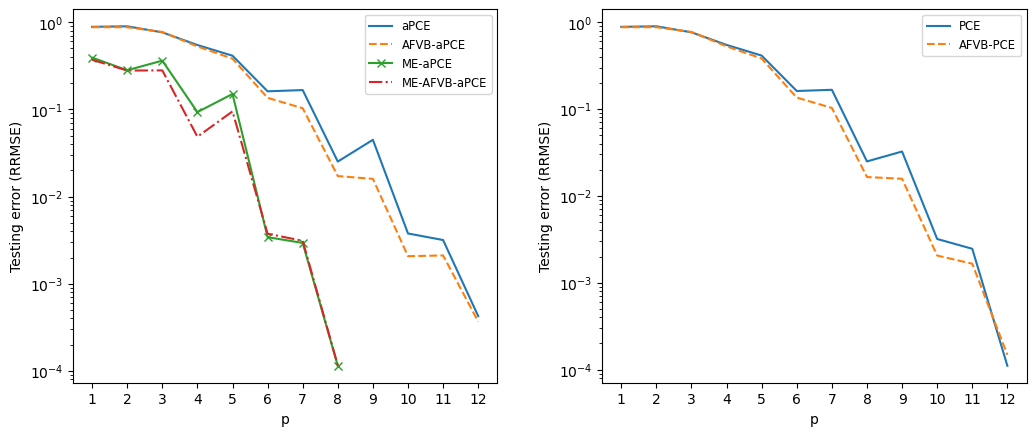

In [112]:
p = list(range(1,13))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[0], '-', label = 'aPCE')
ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')

#ax[0].plot(range(1,9), results_Ishigami_full_model[0], '-', label = 'aPCE')
#ax[0].plot(range(1,6), results_Ishigami_full_model[1], '--', label = 'AFVB-aPCE')
ax[0].plot(range(1,9), results_Ishigami_AFVB_aPCE_ME[0], '-x', label = 'ME-aPCE')
ax[0].plot(range(1,9), results_Ishigami_AFVB_aPCE_ME[1], '-.', label = 'ME-AFVB-aPCE')

#ax[1].plot(range(1,9), results_Ishigami_AFVB_aPCE_ME[0], '-x', label = 'ME-aPCE8')
#ax[1].plot(range(1,9), results_Ishigami_AFVB_aPCE_ME[1], '-.', label = 'ME-AFVB-aPCE8')

#ax[0].plot(range(1,13), results_Ishigami_AFVB_aPCE_Stieltjes_Global[0], ':', c = 'black', alpha = 0.6,  label = 'aPCE-Stieltjes')
#ax[0].plot(range(1,13), results_Ishigami_AFVB_aPCE_Stieltjes_Global[1], ':', c = 'black', alpha = 0.6, label = 'AFVB-aPCE-Stieltjes')
#ax[0].plot(range(1,11), results_Ishigami_AFVB_aPCE_Stieltjes_ME[0], ':' ,label = 'ME-AFVB-aPCE-Stieltjes')
#ax[0].plot(range(1,11), results_Ishigami_AFVB_aPCE_Stieltjes_ME[1], ':', label = 'ME-AFVB-aPCE-Stieltjes')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing error (RRMSE)")
ax[0].legend(fontsize = 'small')

ax[1].plot(p, results_Ishigami_AFVB_PCE_Global[0], '-', label = 'PCE')
ax[1].plot(p, results_Ishigami_AFVB_PCE_Global[1], '--', label = 'AFVB-PCE')

#ax[1].plot(range(1,9), results_Ishigami_AFVB_PCE_ME[0], '-x', label = 'ME-PCE')
#ax[1].plot(range(1,9), results_Ishigami_AFVB_PCE_ME[1], '-.', label = 'ME-AFVB-PCE')

#ax[1].plot(range(1,9), results_Ishigami_AFVB_PCE_ME2[0], '-x', label = 'ME-PCE2')
#ax[1].plot(range(1,9), results_Ishigami_AFVB_PCE_ME2[1], '-.', label = 'ME-AFVB-PCE2')

ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing error (RRMSE)")
ax[1].legend(fontsize = 'small')

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_AFVB_Error.png')

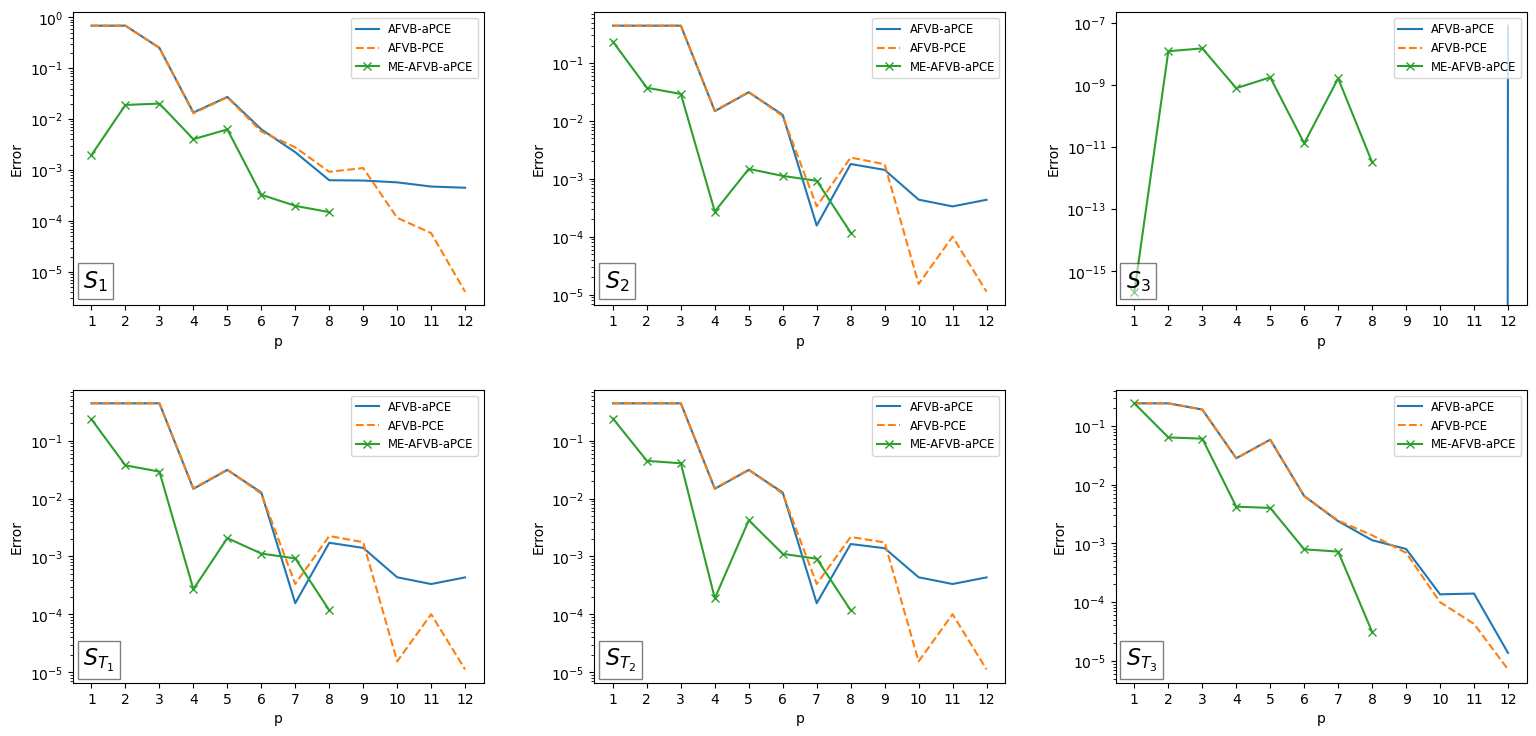

In [114]:
plt.rcParams['figure.figsize'] = (16,8) # (width, height)
fig, ax = plt.subplots(2, 3)
markers = ['-x','-o','-v']
pos0 = [1e-7, 5e-6, 5e-15]
pos1 = [1e-6, 1e-6, 1e-6]

lab0 = ['$S_1$', '$S_2$', '$S_3$']
lab1 = ['$S_{T_1}$', '$S_{T_2}$', '$S_{T_3}$']

for i in range(d):
    
    ax[0,i].text(0.025, 0.06, lab0[i], fontsize = 16, transform=ax[0,i].transAxes,
         bbox = dict(facecolor = 'white', alpha = 0.5))   
    ax[0,i].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Global[2])[:,i] - np.array(GSA_Ishigami['1st Order'])[i]), '-', label = 'AFVB-aPCE')  
    ax[0,i].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Global[2])[:,i] - np.array(GSA_Ishigami['1st Order'])[i]), '--', label = 'AFVB-PCE')  
    #ax[0,i].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[2])[:,i] - np.array(GSA_Ishigami['1st Order'])[i]), ':', c = 'black', alpha = 0.6, label = 'AFVB-aPCE-stieltjes')  
    ax[0,i].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_ME[2])[:,i] - np.array(GSA_Ishigami['1st Order'])[i]), '-x', label = 'ME-AFVB-aPCE') 
    #ax[0,i].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_ME[2])[:,i] - np.array(GSA_Ishigami['1st Order'])[i]), ':', c = 'black', alpha = 0.6, label = 'ME-AFVB-aPCE-Stieltjes') 
    #ax[0,i].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_PCE_ME[2])[:,i] - np.array(GSA_Ishigami['1st Order'])[i]), '-.', label = 'ME-AFVB-PCE') 
    
    #ax[0,i].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_ME8[2])[:,i] - np.array(GSA_Ishigami['1st Order'])[i]), '-x', label = 'ME-AFVB-aPCE8') 
    
    
    ax[1,i].text(0.025, 0.06, lab1[i], fontsize = 16, transform=ax[1,i].transAxes,
         bbox = dict(facecolor = 'white', alpha = 0.5))
    ax[1,i].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Global[3])[:,i] - np.array(GSA_Ishigami['Total Order'])[i]), '-', label = 'AFVB-aPCE')  
    ax[1,i].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Global[3])[:,i] - np.array(GSA_Ishigami['Total Order'])[i]), '--', label = 'AFVB-PCE')  
    #ax[1,i].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[3])[:,i] - np.array(GSA_Ishigami['Total Order'])[i]), ':', label = 'AFVB-aPCE-Stieltjes')  
    ax[1,i].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_ME[3])[:,i] - np.array(GSA_Ishigami['Total Order'])[i]), '-x', label = 'ME-AFVB-aPCE') 
    #ax[1,i].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_ME[3])[:,i] - np.array(GSA_Ishigami['Total Order'])[i]), ':', c = 'black', alpha = 0.6, label = 'ME-AFVB-aPCE-Stieltjes') 
    #ax[1,i].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_PCE_ME[3])[:,i] - np.array(GSA_Ishigami['Total Order'])[i]), '-.', label = 'ME-AFVB-PCE') 
    
    #ax[1,i].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_ME8[3])[:,i] - np.array(GSA_Ishigami['Total Order'])[i]), '-x', label = 'ME-AFVB-aPCE8') 
    
    
    ax[0,i].set_xticks(p)
    ax[0,i].set_yscale("log")
    ax[0,i].set_xlabel("p")
    ax[0,i].set_ylabel("Error")
    ax[0,i].legend(fontsize = 'small', loc='upper right')
    
    ax[1,i].set_xticks(p)
    ax[1,i].set_yscale("log")
    ax[1,i].set_xlabel("p")
    ax[1,i].set_ylabel("Error")
    ax[1,i].legend(fontsize = 'small', loc='upper right')



fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_AFVB_GSA.png')


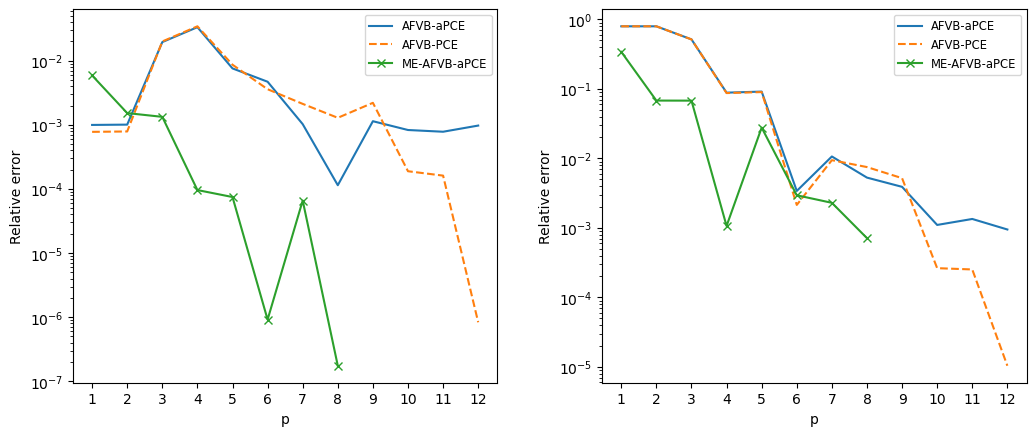

In [115]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Global[4][:12])-3.5)/3.5, '-', label = 'AFVB-aPCE')
ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Global[4][:12])-3.5)/3.5, '--', label = 'AFVB-PCE')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[4])-3.5)/3.5, ':', c = 'black', alpha = 0.6, label = 'AFVB-aPCE-Stieltjes')
ax[0].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_ME[4])-3.5)/3.5, '-x',  label = 'ME-AFVB-aPCE')
#ax[0].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_ME[4])-3.5)/3.5, ':', c = 'black', alpha = 0.6, label = 'ME-AFVB-aPCE_Stieljtes')
#ax[0].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_PCE_ME[4])-3.5)/3.5, '-.', label = 'ME-AFVB-PCE')

#ax[0].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_ME8[4])-3.5)/3.5, '-x',  label = 'ME-AFVB-aPCE8')


ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Relative error")
ax[0].legend(fontsize = 'small', loc='upper right')

ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Global[5][:12])-V_Ishigami)/V_Ishigami, '-', label = 'AFVB-aPCE')
ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Global[5][:12])-V_Ishigami)/V_Ishigami, '--', label = 'AFVB-PCE')
#ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[5])-V_Ishigami)/V_Ishigami, ':', c = 'black', alpha = 0.6, label = 'AFVB-aPCE-Stieltjes')
ax[1].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_ME[5])-V_Ishigami)/V_Ishigami, '-x', label = 'ME-AFVB-aPCE')
#ax[1].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_ME[5])-V_Ishigami)/V_Ishigami, ':', c = 'black', alpha = 0.6, label = 'ME-AFVB-aPCE-Stieltjes')
#ax[1].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_PCE_ME[5])-V_Ishigami)/V_Ishigami, '-.', label = 'ME-AFVB-PCE')

#ax[1].plot(range(1,9), np.abs(np.array(results_Ishigami_AFVB_aPCE_ME8[5])-V_Ishigami)/V_Ishigami, '-x', label = 'ME-AFVB-aPCE8')


ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Relative error")
ax[1].legend(fontsize = 'small', loc = 'upper right')

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_AFVB_mean_and_Variance.png')

# VRVM

## Global Models

### aPCE 

In [237]:
p = list(range(1,13))
best_params_VRVM_Global_aPCE = [OrderedDict([('omega_a', 0.09471047470474508), ('omega_b', 0.8261252449800945), ('tau_a', 0.06652640465435837), ('tau_b', 0.007062566030407023)]), 
                                OrderedDict([('omega_a', 0.049612261035400895), ('omega_b', 0.7440386996043455), ('tau_a', 0.07786583082358148), ('tau_b', 0.0876440418206704)]), 
                                OrderedDict([('omega_a', 0.07065027096933797), ('omega_b', 0.874318993081181), ('tau_a', 0.05108987579966856), ('tau_b', 0.02159723121388707)]), 
                                OrderedDict([('omega_a', 0.07891069108850779), ('omega_b', 0.3388294674855196), ('tau_a', 0.05201844223952634), ('tau_b', 0.07425697642498146)]), 
                                OrderedDict([('omega_a', 0.06396672505270919), ('omega_b', 0.9814959730782805), ('tau_a', 0.07803080927782434), ('tau_b', 0.052327033408042595)]), 
                                OrderedDict([('omega_a', 0.036237541673148035), ('omega_b', 0.8233944454828857), ('tau_a', 0.04098760799758875), ('tau_b', 0.011023525985192184)]), 
                                OrderedDict([('omega_a', 0.0011615581450389418), ('omega_b', 0.026954632194166942), ('tau_a', 0.08316750275198932), ('tau_b', 0.044533055333262184)]), 
                                OrderedDict([('omega_a', 0.09471047470474508), ('omega_b', 0.8261252449800945), ('tau_a', 0.06652640465435837), ('tau_b', 0.007062566030407023)]), 
                                OrderedDict([('omega_a', 0.049612261035400895), ('omega_b', 0.7440386996043455), ('tau_a', 0.07786583082358148), ('tau_b', 0.0876440418206704)]), 
                                OrderedDict([('omega_a', 0.09471047470474508), ('omega_b', 0.8261252449800945), ('tau_a', 0.06652640465435837), ('tau_b', 0.007062566030407023)]), 
                                OrderedDict([('omega_a', 0.09471047470474508), ('omega_b', 0.8261252449800945), ('tau_a', 0.06652640465435837), ('tau_b', 0.007062566030407023)]), 
                                OrderedDict([('omega_a', 0.09471047470474508), ('omega_b', 0.8261252449800945), ('tau_a', 0.06652640465435837), ('tau_b', 0.007062566030407023)])]


In [213]:
best_params_VRVM_Global_aPCE = [OrderedDict([('omega_a', 1e-08), ('omega_b', 1e-07), ('tau_a', 1e-08), ('tau_b', 1e-08)])]*12 
                                

In [238]:
results_Ishigami_VRVM_aPCE_Global = collect_results_PCE(p, d, tf.ishigami, best_params_VRVM_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE', VRVM_PCE, None)


0.008944988250732422
p = 1 n* =  2
0.02661609649658203
p = 2 n* =  4
0.04522204399108887
p = 3 n* =  5
0.09457993507385254
p = 4 n* =  6
0.15703606605529785
p = 5 n* =  11
0.5695157051086426
p = 6 n* =  11
1.2738752365112305
p = 7 n* =  14
1.520207166671753
p = 8 n* =  12
2.9592649936676025
p = 9 n* =  9
3.2943809032440186
p = 10 n* =  9
5.086187124252319
p = 11 n* =  8
6.775518894195557
p = 12 n* =  8


# aPCE_Stieltjes

In [51]:
results_Ishigami_VRVM_aPCE_Stieltjes_Global = collect_results_PCE(p, d, tf.ishigami, best_params_VRVM_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE_Stieltjes', VRVM_PCE, None)


0.05707716941833496
p = 1 n* =  2
0.07526302337646484
p = 2 n* =  2
0.1665019989013672
p = 3 n* =  4
0.32772302627563477
p = 4 n* =  6
1.1551759243011475
p = 5 n* =  9
1.7442479133605957
p = 6 n* =  12
2.6336748600006104
p = 7 n* =  14
3.588974714279175
p = 8 n* =  17
5.117414951324463
p = 9 n* =  19
7.153722047805786
p = 10 n* =  29
9.895572900772095
p = 11 n* =  26
14.926302194595337
p = 12 n* =  31


### PCE

In [429]:
# Optimized Hyper-Parameters: slurm-8832060
best_params_VRVM_Global_PCE = [OrderedDict([('omega_a', 8.250112017059774e-05), ('omega_b', 2.697664649344138e-05), ('tau_a', 8.773550150287762e-05), ('tau_b', 9.280478913052116e-05)]), 
                                OrderedDict([('omega_a', 5.3349950069095004e-05), ('omega_b', 4.6895128836045996e-05), ('tau_a', 3.942437847269144e-05), ('tau_b', 8.160975043461345e-05)]), 
                                OrderedDict([('omega_a', 6.952592371132578e-05), ('omega_b', 2.0459952999622615e-05), ('tau_a', 1.4750975367766252e-05), ('tau_b', 1.8894002525490853e-05)]), 
                                OrderedDict([('omega_a', 0.003471542917117921), ('omega_b', 0.0017977889030439962), ('tau_a', 0.009776460975261112), ('tau_b', 0.008113747359520777)]),
                                OrderedDict([('omega_a', 7.929983062691689e-06), ('omega_b', 2.899220525081061e-05), ('tau_a', 3.3126411813047565e-05), ('tau_b', 1.3977822139565673e-05)]), 
                                OrderedDict([('omega_a', 9.637801781300589e-05), ('omega_b', 5.75075443756559e-05), ('tau_a', 3.4027842748058104e-05), ('tau_b', 3.225745306283743e-05)]), 
                                OrderedDict([('omega_a', 8.250112017059774e-05), ('omega_b', 2.697664649344138e-04), ('tau_a', 8.773550150287762e-05), ('tau_b', 9.280478913052116e-05)]), 
                                
                                #OrderedDict([('omega_a', 5.3349950069095004e-06), ('omega_b', 4.6895128836045996e-05), ('tau_a', 3.942437847269144e-05), ('tau_b', 8.160975043461345e-05)]), 
                                #OrderedDict([('omega_a', 8.250112017059774e-05), ('omega_b', 2.697664649344138e-05), ('tau_a', 8.773550150287762e-05), ('tau_b', 9.280478913052116e-05)]), 
                                OrderedDict([('omega_a', 5.3349950069095004e-06), ('omega_b', 4.6895128836045996e-03), ('tau_a', 3.942437847269144e-01), ('tau_b', 8.160975043461345e-01)]), 
                                OrderedDict([('omega_a', 1e-7), ('omega_b', 2.5e-3), ('tau_a', 9.773550150287762e-02), ('tau_b', 9.280478913052116e-02)]), 
                                
                                #OrderedDict([('omega_a', 5.3349950069095004e-05), ('omega_b', 4.6895128836045996e-05), ('tau_a', 3.942437847269144e-05), ('tau_b', 8.160975043461345e-05)]), 
                                #OrderedDict([('omega_a', 8.250112017059774e-05), ('omega_b', 2.697664649344138e-05), ('tau_a', 8.773550150287762e-05), ('tau_b', 9.280478913052116e-05)]), 
                                #OrderedDict([('omega_a', 8.250112017059774e-12), ('omega_b', 2.697664649344138e-12), ('tau_a', 8.773550150287762e-05), ('tau_b', 9.280478913052116e-05)])]
                                OrderedDict([('omega_a', 5.3349950069095004e-05), ('omega_b', 4.6895128836045996e-04), ('tau_a', 3.942437847269144e-05), ('tau_b', 8.160975043461345e-05)]), 
                                OrderedDict([('omega_a', 8.250112017059774e-05), ('omega_b', 2.697664649344138e-05), ('tau_a', 8.773550150287762e-05), ('tau_b', 9.280478913052116e-05)]), 
                                OrderedDict([('omega_a', 8.250112017059774e-12), ('omega_b', 2.697664649344138e-08), ('tau_a', 8.773550150287762e-05), ('tau_b', 9.280478913052116e-05)])]

B_init = [[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]

In [64]:
best_params_VRVM_Global_PCE = [OrderedDict([('omega_a', 1e-08), ('omega_b', 1e-8), ('tau_a', 1e-8), ('tau_b', 1e-08)])]*11 \
                            + [OrderedDict([('omega_a', 1e-8), ('omega_b', 1e-8), ('tau_a', 1e-8), ('tau_b', 1e-8)])]


In [210]:
results_Ishigami_VRVM_PCE_Global = collect_results_PCE(p, d, tf.ishigami, best_params_VRVM_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'PCE_Legendre', VRVM_PCE, B_init_PCE)


0.1480388641357422
p = 1 n* =  2
0.20023894309997559
p = 2 n* =  2
0.39992594718933105
p = 3 n* =  5
0.6856279373168945
p = 4 n* =  6
1.1166908740997314
p = 5 n* =  8
3.1628239154815674
p = 6 n* =  10
4.236815929412842
p = 7 n* =  12
5.709569931030273
p = 8 n* =  15
8.943403005599976
p = 9 n* =  14
13.391449928283691
p = 10 n* =  15
13.769476890563965
p = 11 n* =  14
19.775232791900635
p = 12 n* =  13


## Local Models

### aPCE 

In [293]:
# M = 16
best_params_VRVM_ME_aPCE = [[OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)])], 

                            [OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)])], 

                            [OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)])],

                            [OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)])], 

                            [OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)])],

                            [OrderedDict([('omega_a', 1e-08), ('omega_b', 1e-02), ('tau_a', 1e-03), ('tau_b', 1e-03)])]*16,  # p = 6

                            [OrderedDict([('omega_a', 1e-08), ('omega_b', 1e-05), ('tau_a', 1e-05), ('tau_b', 1e-05)])]*16, # p = 7
                            
                            [OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)])]]


In [820]:
best_params_VRVM_ME_aPCE = [[OrderedDict([('omega_a', 1e-12), ('omega_b', 1e-02), ('tau_a', 1e-02), ('tau_b', 1e-02)])]*16]*8 
                            
                            

In [294]:
p = list(range(1,9))

N_t = [80]*8

results_Ishigami_VRVM_aPCE_ME = collect_results_ME(p, d, tf.ishigami, best_params_VRVM_ME_aPCE, 
                                                  X_test, 'aPCE', 
                                                  VRVM_PCE, N_t = N_t, N_p = N_pol, data_fun = data_ishigami, 
                                                  B_init = B_init_aPCE, n_iter = 2, theta1=theta1, theta2=theta2, alpha=0.5,
                                                  params_init = params_init_AFVB)

NameError: name 'theta1' is not defined

### aPCE_Stieltjes

In [56]:
results_Ishigami_VRVM_aPCE_Stieltjes_ME = collect_results_ME(p, d, tf.ishigami, best_params_VRVM_ME_aPCE, 
                                                  X_test, 'aPCE_Stieltjes', 
                                                  VRVM_PCE, N_t = N_t, N_p = N_pol, data_fun = data_ishigami, 
                                                  B_init = B_init_aPCE, n_iter = 2, theta1=theta1, theta2=theta2, alpha=0.5,
                                                  params_init = params_init_AFVB)

VRVM_PCE
time = 2.1831929683685303
p = 1 M = 16
n_star: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
0    3.747019e+00
1    6.137849e+00
2    2.343956e-08
Name: Partial Variance, dtype: float64
0    6.056436
1    6.143982
2    2.311104
Name: Total Variance, dtype: float64
12.198125928947457 3.4949594029672904
time = 5.2349090576171875
p = 2 M = 16
n_star: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
0    4.444274e+00
1    6.155308e+00
2    5.691331e-09
Name: Partial Variance, dtype: float64
0    7.540798
1    6.159525
2    3.100109
Name: Total Variance, dtype: float64
13.6998695503922 3.4983266597965863
time = 20.316609859466553
p = 3 M = 16
n_star: [8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 8, 9, 9, 9, 9]
0    4.462552e+00
1    6.129833e+00
2    1.190950e-09
Name: Partial Variance, dtype: float64
0    7.868636
1    6.132376
2    3.404717
Name: Total Variance, dtype: float64
13.998470040596537 3.499652137519842
time = 43.14975929260254
p = 4 M = 16
n_star: [15, 15, 15, 15, 12, 15, 12, 1

### PCE

In [608]:
best_params_VRVM_ME_aPCE = [[OrderedDict([('omega_a', 1e-6), ('omega_b', 1e-5)])]*8,
                            
                            [OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)])], 

                            [OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)])], 

                            [OrderedDict([('omega_a', 1e-4), ('omega_b', 1e-2)])]*8,
                            
                            [OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)])],

                            [OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)]), OrderedDict([('omega_a', 0.036897608300281985)])],

                            #[OrderedDict([('omega_a', 1e-08), ('omega_b', 1e-02), ('tau_a', 1e-03), ('tau_b', 1e-03)])]*16,  # p = 6

                            [OrderedDict([('omega_a', 5e-3), ('omega_b', 1e-2)])]*8,
                            [OrderedDict([('omega_a', 1e-5), ('omega_b', 1e-5)])]*8]
                            #[OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)]), OrderedDict([('omega_a', 3.6896977333157706e-06), ('omega_b', 0.00038420066082405955), ('tau_a', 9.569168849385174e-06), ('tau_b', 7.353136831877627e-06)])]]


In [492]:
best_params_VRVM_ME_aPCE = [[OrderedDict([('omega_a', 1e-04), ('omega_b', 1e-04), ('tau_a', 1e-04), ('tau_b', 1e-04)])]*8]*8



In [1033]:
p = list(range(1,9))
N_t = [200]*12


results_Ishigami_VRVM_PCE_ME = collect_results_ME(p, d, tf.ishigami, best_params_VRVM_ME_aPCE, 
                                                  X_test, 'PCE_Legendre', 
                                                  VRVM_PCE, N_t = N_t, N_p = N_pol, data_fun = data_ishigami, 
                                                  B_init = B_init_PCE, n_iter = 2, theta1=theta1, theta2=theta2, alpha=0.5,
                                                  params_init = params_init_VRVM)

VRVM_PCE
time = 1.4605300426483154
p = 1 M = 16
n_star: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
0    3.747031e+00
1    6.134278e+00
2    2.375084e-08
Name: Partial Variance, dtype: float64
0    6.054944
1    6.140408
2    2.309599
Name: Total Variance, dtype: float64
12.19306046654415 3.4949549481992417
time = 3.200422763824463
p = 2 M = 16
n_star: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
0    4.442278e+00
1    6.151724e+00
2    5.491899e-09
Name: Partial Variance, dtype: float64
0    7.536764
1    6.155937
2    3.098071
Name: Total Variance, dtype: float64
13.692249598308567 3.4983231325893875
time = 6.243411302566528
p = 3 M = 16
n_star: [8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 8, 9, 9, 9, 9]
0    4.460464e+00
1    6.126890e+00
2    1.076261e-09
Name: Partial Variance, dtype: float64
0    7.864132
1    6.129431
2    3.402302
Name: Total Variance, dtype: float64
13.991022770581608 3.4996485894188023
time = 6.534788131713867
p = 4 M = 16
n_star: [15, 15, 15, 15, 12, 15, 12, 1

## Plots for VRVM - Ishigami Function

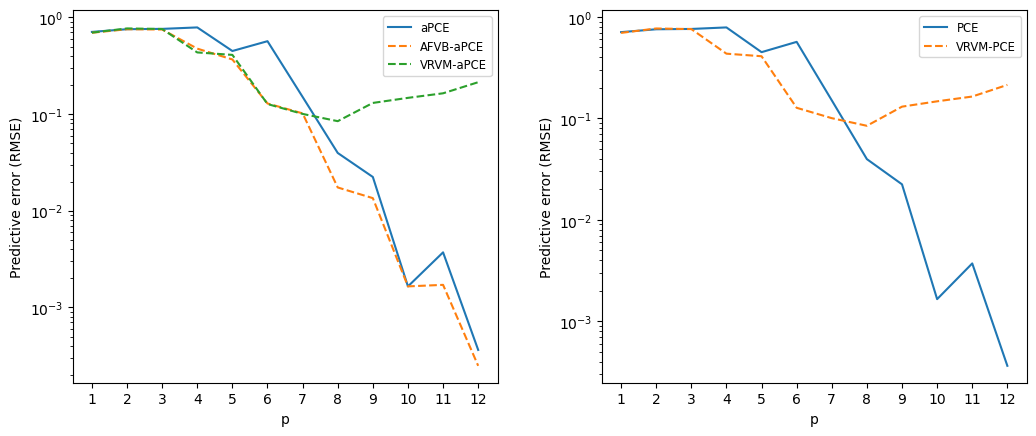

In [239]:
p = list(range(1,13))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[0], '-', label = 'aPCE')
ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')
ax[0].plot(p, results_Ishigami_VRVM_aPCE_Global[1], '--', label = 'VRVM-aPCE')

#ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[0], '-', label = 'aPCE')
#ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')

#ax[0].plot(range(1,9), results_Ishigami_AFVB_aPCE_ME[0], '-x', label = 'ME-aPCE')
#ax[0].plot(range(1,9), results_Ishigami_VRVM_aPCE_ME[1], '-.', label = 'ME-VRVM-aPCE')

#ax[0].plot(p, results_Ishigami_VRVM_aPCE_Stieltjes_Global[0], ':', label = 'aPCE-Stieltjes')
#ax[0].plot(p, results_Ishigami_VRVM_aPCE_Stieltjes_Global[1], ':', label = 'VRVM-aPCE-Stieltjes')
#ax[0].plot(p, results_Ishigami_VRVM_aPCE_Stieltjes_ME[0], ':' ,label = 'ME-VRVM-aPCE-Stieltjes')
#ax[0].plot(p, results_Ishigami_VRVM_aPCE_Stieltjes_ME[1], ':', label = 'ME-VRVM-aPCE-Stieltjes')


ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Predictive error (RMSE)")
ax[0].legend(fontsize = 'small')

ax[1].plot(p, results_Ishigami_AFVB_aPCE_Global[0], '-', label = 'PCE')
ax[1].plot(p, results_Ishigami_VRVM_aPCE_Global[1], '--', label = 'VRVM-PCE')
#ax[1].plot(range(1,9), results_Ishigami_AFVB_PCE_ME[0], '-x', label = 'ME-PCE')
#ax[1].plot(range(1,9), results_Ishigami_VRVM_PCE_ME[1], '-.', label = 'ME-VRVM-PCE')

ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Predictive error (RMSE)")
ax[1].legend(fontsize = 'small')

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_VRVM_Error.png')

/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_29963/3616953479.py:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0,i].set_yscale("log")


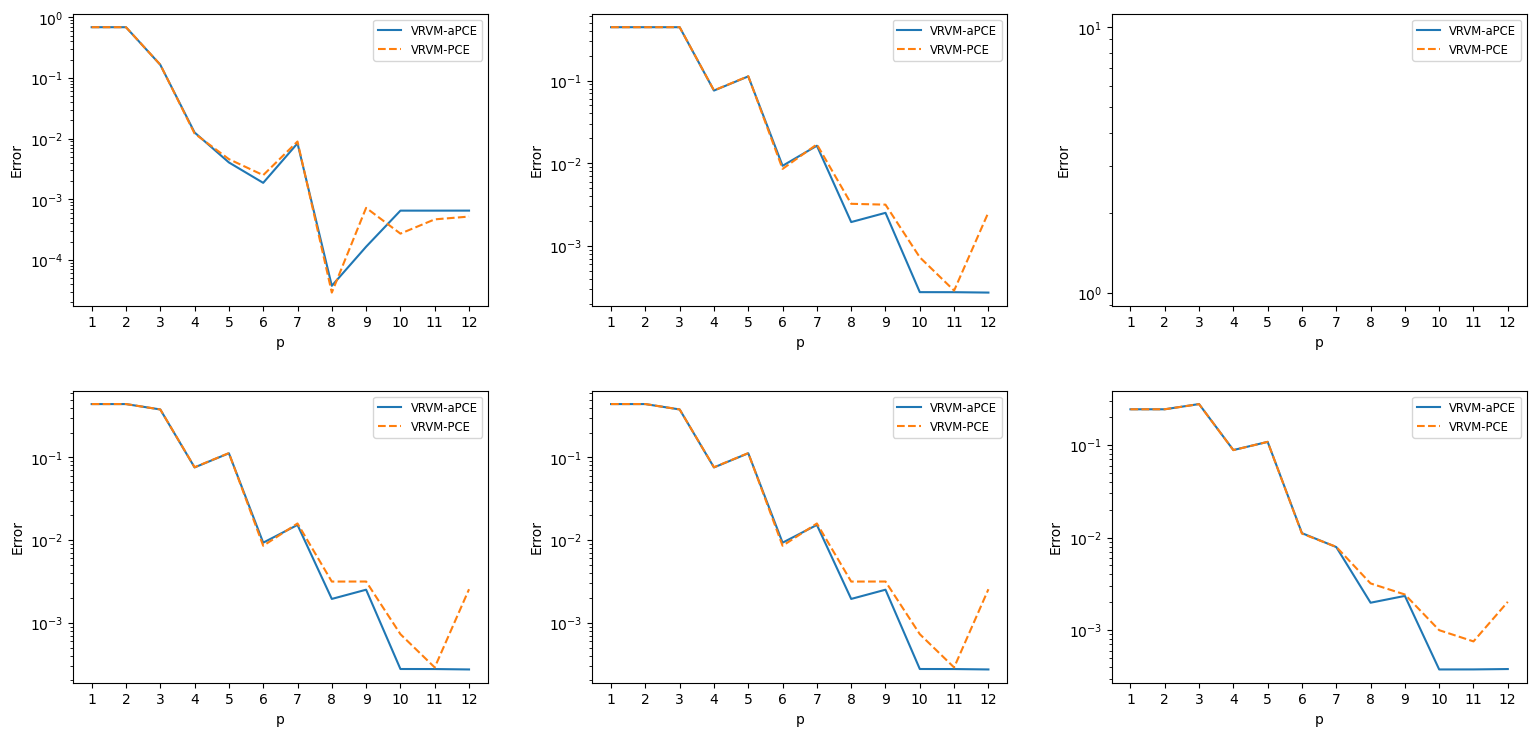

In [216]:
p = list(range(1,13))
plt.rcParams['figure.figsize'] = (16,8) # (width, height)
fig, ax = plt.subplots(2, 3)
markers = ['-x','-o','-v']

for i in range(3):
    ax[0,i].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Global[2])[:,i] - np.array(GSA_Ishigami['1st Order'])[i]), '-', label = 'VRVM-aPCE')  
    ax[0,i].plot(p, np.abs(np.array(results_Ishigami_VRVM_PCE_Global[2])[:,i] - np.array(GSA_Ishigami['1st Order'])[i]), '--', label = 'VRVM-PCE')  
    #ax[0,i].plot(range(1,9), np.abs(np.array(results_Ishigami_VRVM_aPCE_ME[2])[:,i] - np.array(GSA_Ishigami['1st Order'])[i]), '-x', label = 'ME-VRVM-aPCE') 
    #ax[0,i].plot(range(1,9), np.abs(np.array(results_Ishigami_VRVM_PCE_ME[2])[:,i] - np.array(GSA_Ishigami['1st Order'])[i]), '-.', label = 'ME-VRVM-PCE') 

    ax[1,i].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Global[3])[:,i] - np.array(GSA_Ishigami['Total Order'])[i]), '-', label = 'VRVM-aPCE')  
    ax[1,i].plot(p, np.abs(np.array(results_Ishigami_VRVM_PCE_Global[3])[:,i] - np.array(GSA_Ishigami['Total Order'])[i]), '--', label = 'VRVM-PCE')  
    #ax[1,i].plot(range(1,9), np.abs(np.array(results_Ishigami_VRVM_aPCE_ME[3])[:,i] - np.array(GSA_Ishigami['Total Order'])[i]), '-x', label = 'ME-VRVM-aPCE') 
    #ax[1,i].plot(range(1,9), np.abs(np.array(results_Ishigami_VRVM_PCE_ME[3])[:,i] - np.array(GSA_Ishigami['Total Order'])[i]), '-.', label = 'ME-VRVM-PCE') 

    ax[0,i].set_xticks(p)
    ax[0,i].set_yscale("log")
    ax[0,i].set_xlabel("p")
    ax[0,i].set_ylabel("Error")
    ax[0,i].legend(fontsize = 'small')
    
    ax[1,i].set_xticks(p)
    ax[1,i].set_yscale("log")
    ax[1,i].set_xlabel("p")
    ax[1,i].set_ylabel("Error")
    ax[1,i].legend(fontsize = 'small')



fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_VRVM_GSA.png')

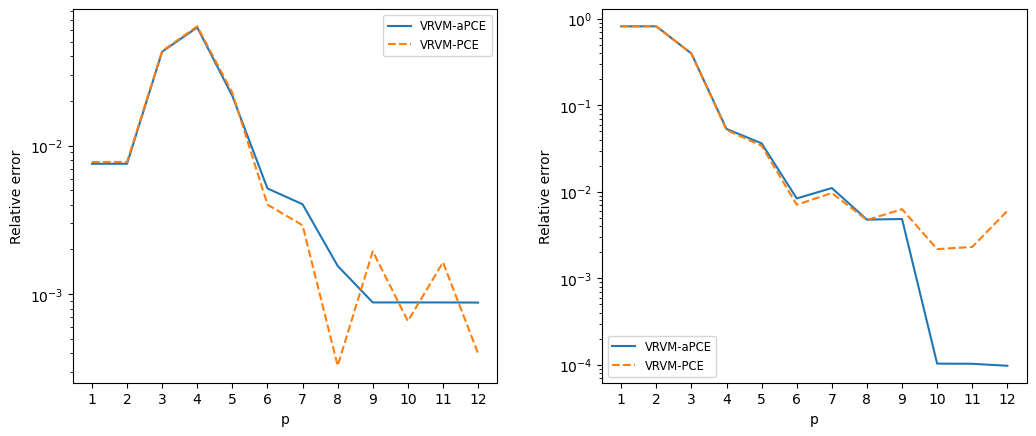

In [217]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Global[4])-3.5)/3.5, '-', label = 'VRVM-aPCE')
ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_PCE_Global[4])-3.5)/3.5, '--', label = 'VRVM-PCE')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Stieltjes_Global[4])-3.5)/3.5, ':', label = 'VRVM-aPCE-Stieltjes')
#ax[0].plot(range(1,9), np.abs(np.array(results_Ishigami_VRVM_aPCE_ME[4])-3.5)/3.5, '-x', label = 'ME-VRVM-aPCE')
#ax[0].plot(range(1,9), np.abs(np.array(results_Ishigami_VRVM_PCE_ME[4])-3.5)/3.5, '-.', label = 'ME-VRVM-PCE')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Stieltjes_ME[4])-3.5)/3.5, '--', label = 'ME-VRVM-aPCE-Stieltjes')

ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Relative error")
ax[0].legend(fontsize = 'small')


ax[1].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Global[5])-V_Ishigami)/V_Ishigami, '-', label = 'VRVM-aPCE')
ax[1].plot(p, np.abs(np.array(results_Ishigami_VRVM_PCE_Global[5])-V_Ishigami)/V_Ishigami, '--', label = 'VRVM-PCE')
#ax[1].plot(range(1,9), np.abs(np.array(results_Ishigami_VRVM_aPCE_ME[5])-V_Ishigami)/V_Ishigami, '-x', label = 'ME-VRVM-aPCE')
#ax[1].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Stieltjes_Global[5])-V_Ishigami)/V_Ishigami, ':', label = 'VRVM-aPCE-Stieltjes')
#ax[1].plot(range(1,9), np.abs(np.array(results_Ishigami_VRVM_PCE_ME[5])-V_Ishigami)/V_Ishigami, '-.', label = 'ME-VRVM-PCE')

ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Relative error")
ax[1].legend(fontsize = 'small', loc = 'lower left')

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_VRVM_mean_and_variance.png')

# Example 2: Cantilever Tube Structure

Note: Need to modify ME_PCE algorithm to allow values from non-uniform distribution and change it so that the aPCE algorithms are entering ifnormation from data not from knowledge of pdf!!!!!!!

In [586]:
N_pol = 1000000
N_train = 200
N_test = 50
d = 7

#np.random.seed(2357)

X_train = tf.cantilever_data(N_train)
Y_train = tf.cantilever(X_train)
X_test = tf.cantilever_data(N_test)
Y_test = tf.cantilever(X_test)

X_pol = tf.cantilever_data(N_pol)

In [412]:
N_train

160

In [15]:
p = [1]

mod = aPCE(X_pol, p[0])
P = mod.Create_Orthonormal_Polynomials(p[0])

model = VRVM_PCE('aPCE', d = d, p = p[0], domain = None, aPCE_model = mod, P = P)

train_sizes, train_scores, test_scores = learning_curve(
    estimator = model,
    X = X_train,
    y = Y_train,
    cv = 5,
    n_jobs = 5,
    scoring = "neg_root_mean_squared_error",
    train_sizes = train_size
)

train_mean_p1 = -train_scores.mean(axis=1)
test_mean_p1 = -test_scores.mean(axis=1)


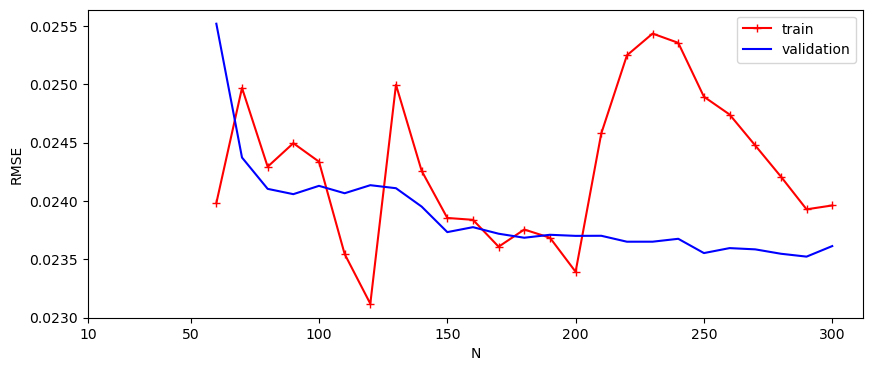

In [16]:
plt.subplots(figsize=(10,4))
plt.plot(train_sizes, train_mean_p1, "r-+",  label="train")
plt.plot(train_sizes, test_mean_p1, "b-", label="validation")

#plt.title("Learning Curve")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.xticks([10, 50, 100, 150, 200, 250, 300])
#plt.ylim([0.0, 0.01])
#plt.xlim([0, 300])

plt.savefig(wd + '/Cantilever_Learning_Curve_p1.png')

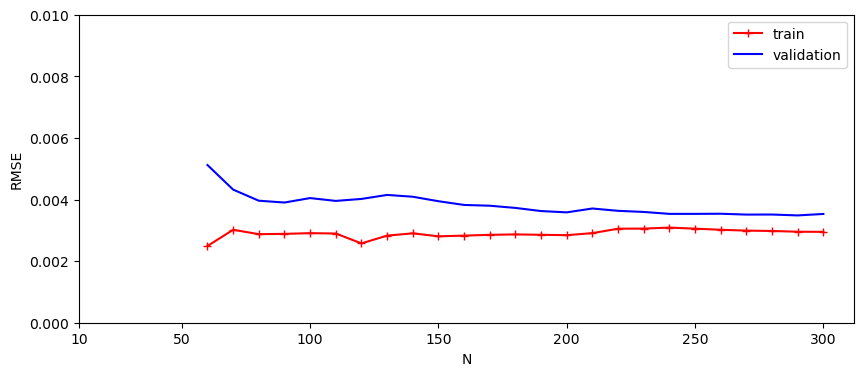

In [519]:
plt.subplots(figsize=(10,4))
plt.plot(train_sizes, train_mean_p2, "r-+",  label="train")
plt.plot(train_sizes, test_mean_p2, "b-", label="validation")

#plt.title("Learning Curve")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.xticks([10, 50, 100, 150, 200, 250, 300])
plt.ylim([0.0, 0.01])
#plt.xlim([0, 200])

plt.savefig(wd + '/Cantilever_Learning_Curve_p2.png')

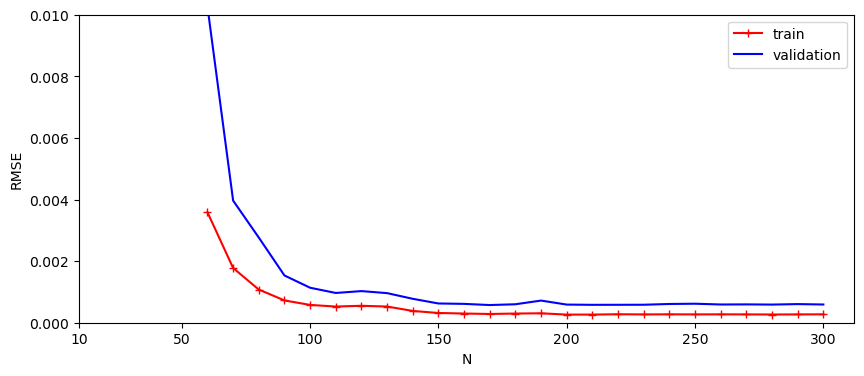

In [510]:
plt.subplots(figsize=(10,4))
plt.plot(train_sizes, train_mean_p3, "r-+",  label="train")
plt.plot(train_sizes, test_mean_p3, "b-", label="validation")

#plt.title("Learning Curve")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.xticks([10, 50, 100, 150, 200, 250, 300])
plt.ylim([0.0, 0.01])
#plt.xlim([0, 200])

plt.savefig(wd + '/Cantilever_Learning_Curve_p3.png')

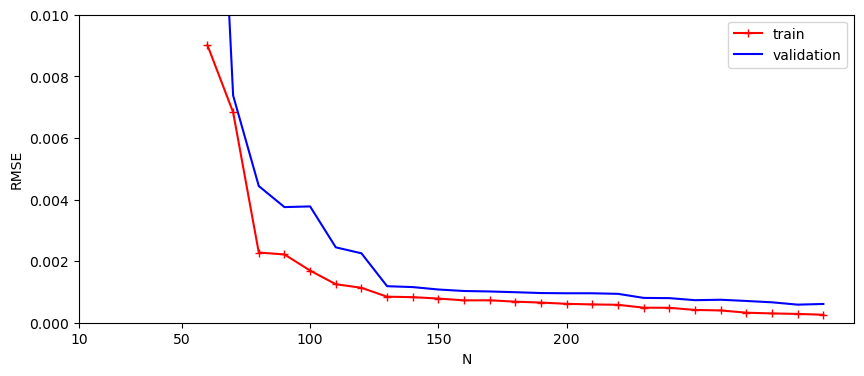

In [508]:
plt.subplots(figsize=(10,4))
plt.plot(train_sizes, train_mean_p4, "r-+",  label="train")
plt.plot(train_sizes, test_mean_p4, "b-", label="validation")

#plt.title("Learning Curve")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.xticks([10, 50, 100, 150, 200, 250, 300])
plt.ylim([0.0, 0.01])
#plt.xlim([0, 200])

plt.savefig(wd + '/Cantilever_Learning_Curve_p4.png')

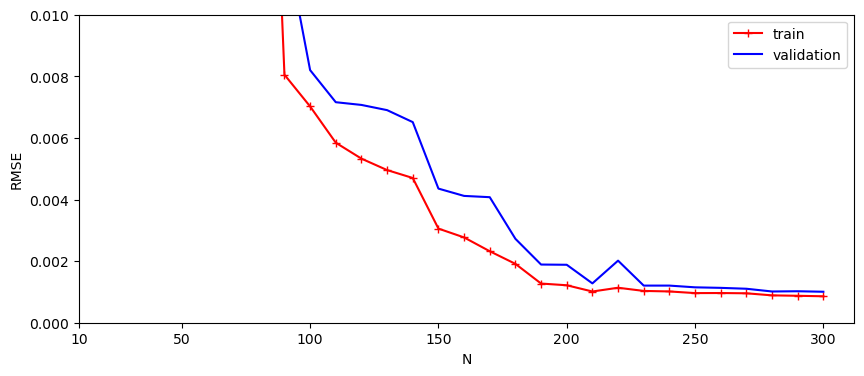

In [821]:
plt.subplots(figsize=(10,4))
plt.plot(train_sizes, train_mean_p5, "r-+",  label="train")
plt.plot(train_sizes, test_mean_p5, "b-", label="validation")

#plt.title("Learning Curve")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.xticks([10, 50, 100, 150, 200, 250, 300])
plt.ylim([0.0, 0.01])
#plt.xlim([0, 200])

plt.savefig(wd + '/Cantilever_Learning_Curve_p5.png')

In [809]:
N_pol = 1000000
N_train = 140
N_test = 35
d = 7

In [13]:
from scipy.stats import qmc
from scipy.stats import norm

mu_vals = [42, 5, 560, 1800, 1800, 1000, 19*10**5]
sigma_vals = [42*0.0119, 5*0.02, 56, 180, 180, 100, 19*10**4]

sampler = qmc.Sobol(d=d, seed = 23)
sample = sampler.random(N_train)
#sample = sampler.random_base2(m = 8)

sample2 = sampler.random(N_pol)

/Users/chave/anaconda3/lib/python3.11/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [14]:
qmc.discrepancy(sample)

0.0020013000318075402

In [193]:
qmc.discrepancy(sample)

0.012494920906719331

In [72]:
?qmc.discrepancy

In [99]:
X_train = np.zeros((N_train,d))
X_pol = np.zeros((N_pol, d))

for i in range(d):
    X_train[:,i] = norm.ppf(sample[:,i], mu_vals[i], sigma_vals[i])
    
for i in range(d):
    X_pol[:,i] = norm.ppf(sample2[:,i], mu_vals[i], sigma_vals[i])

ValueError: could not broadcast input array from shape (200,) into shape (120,)

In [810]:
#np.random.seed(2357)

X_train = tf.cantilever_data(N_train)
Y_train = tf.cantilever(X_train)
X_test = tf.cantilever_data(N_test)
Y_test = tf.cantilever(X_test)

X_pol = tf.cantilever_data(N_pol)

(array([ 1.,  0.,  5., 16., 25., 37., 34., 12.,  6.,  4.]),
 array([0.86057254, 0.99278243, 1.12499231, 1.2572022 , 1.38941209,
        1.52162197, 1.65383186, 1.78604174, 1.91825163, 2.05046151,
        2.1826714 ]),
 <BarContainer object of 10 artists>)

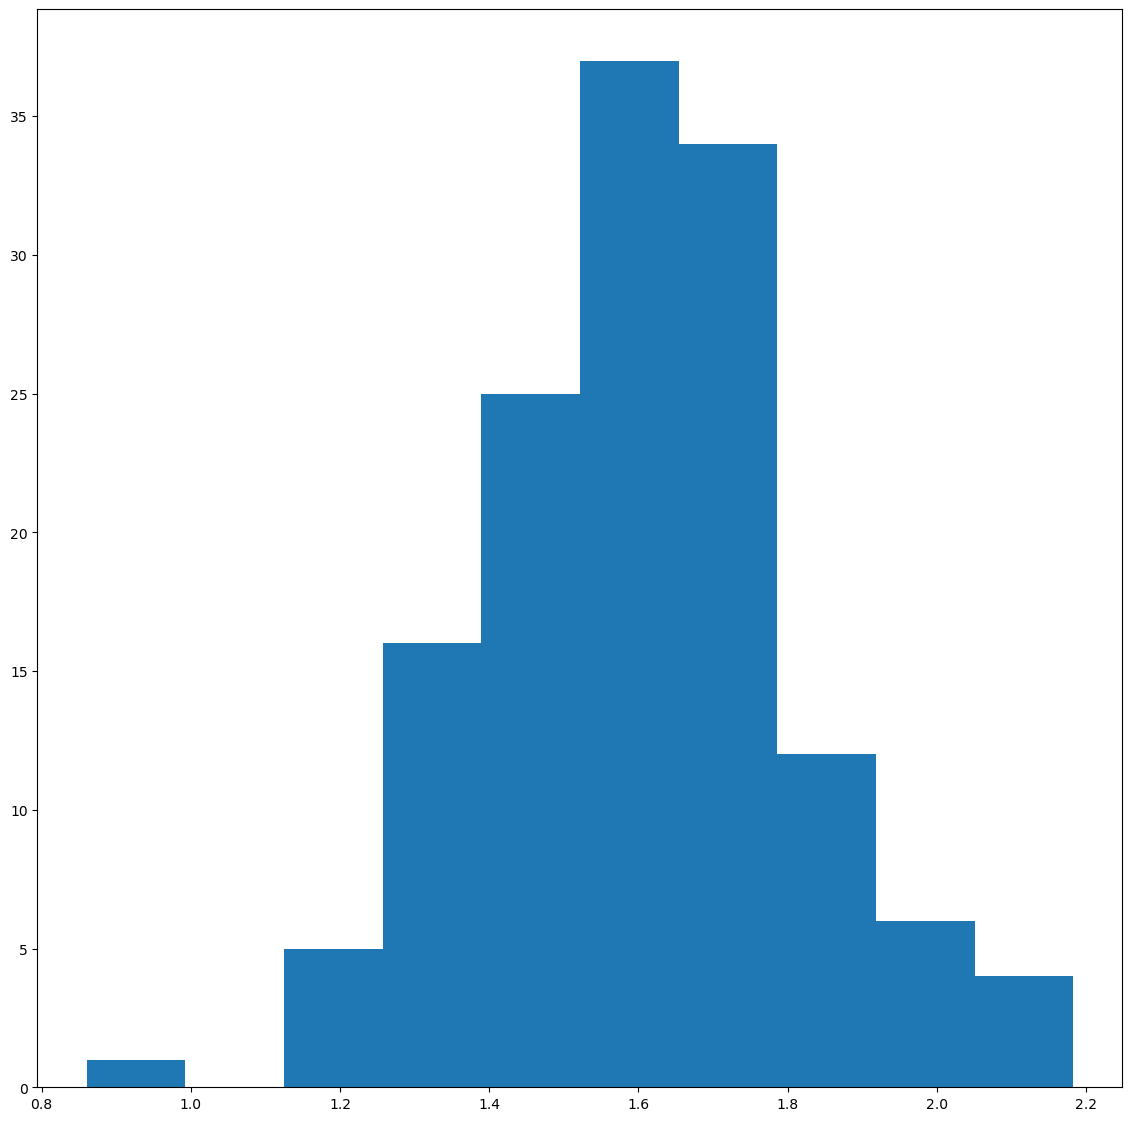

In [811]:
plt.hist(Y_train)


In [18]:
np.sum(Y_train<1)

0

In [190]:
B0 = list(np.linspace(1e-1, 1e-2, 6))\
    + list(np.linspace(1e-2, 1e-3, 6))[1:]\
    + list(np.linspace(1e-3, 1e-4, 6))[1:]\
    + list(np.linspace(1e-4, 1e-5, 6))[1:]\
    + list(np.linspace(1e-5, 1e-6, 6))[1:]\
    + list(np.linspace(1e-6, 1e-7, 6))[1:]
    #+ list(np.linspace(1e-7, 1e-8, 4))[1:]
    #+ list(np.linspace(1e-8, 1e-9, 4))[1:]

In [115]:
B0 = list(np.linspace(1e-4, 1e-5, 10))\
    + list(np.linspace(1e-5, 1e-6, 10))[1:]
    #+ list(np.linspace(1e-6, 1e-7, 10))[1:]
    #+ list(np.linspace(1e-7, 1e-8, 4))[1:]
    #+ list(np.linspace(1e-8, 1e-9, 4))[1:]

In [822]:
t0 = time.time()

AC = [1e-1, 1e-2, 1e-3, 1e-4]
B0 = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
D0 = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

n_star = []
Errors = []
Errors_full = []

p = [4]

mod = aPCE(X_pol, p[0])
P = mod.Create_Orthonormal_Polynomials(p[0])

n_star_AC =[]
Errors_AC = []
Errors_full_AC = []
for i in range(len(AC)):
    
    n_star_D =[]
    Errors_D = []
    Errors_full_D = []
    for j in range(len(D0)):
        
        n_star_B =[]
        Errors_B = []
        Errors_full_B = []
        for k in range(len(B0)):
           
            
        
            model = AFVB_PCE('aPCE', d = d, p = p[0], domain = None, aPCE_model = mod, P = P,
                        A_0 = AC[i], B_0 = B0[k], C_0 = AC[i], D_0 = D0[j])
            model.fit(X_train, Y_train)

            n_star_B.append(model.n_star)
            Errors_B.append(np.sqrt(mean_squared_error(Y_test, model.predict(X_test))))
            Errors_full_B.append(np.sqrt(mean_squared_error(Y_test, model.predict(X_test, sparse = False))))
            
        n_star_D.append(n_star_B)
        Errors_D.append(Errors_B)
        Errors_full_D.append(Errors_full_B)
    
    n_star_AC.append(n_star_D)
    Errors_AC.append(Errors_D)
    Errors_full_AC.append(Errors_full_D)

n_star.append(n_star_AC)
Errors.append(Errors_AC)
Errors_full.append(Errors_full_AC)

print(time.time()-t0)

7236.714381933212


In [823]:
n_star

[[[[7, 10, 17, 23, 29, 39, 49, 65, 74, 78],
   [330, 330, 330, 330, 330, 330, 330, 330, 329, 328],
   [330, 330, 330, 330, 330, 330, 330, 330, 330, 330],
   [330, 330, 329, 329, 330, 328, 330, 328, 328, 328],
   [327, 306, 330, 330, 330, 330, 330, 330, 330, 330],
   [330, 330, 330, 330, 330, 330, 330, 330, 330, 330],
   [330, 330, 330, 330, 330, 330, 330, 330, 330, 330]],
  [[7, 8, 15, 18, 26, 36, 49, 55, 55, 55],
   [7, 8, 15, 18, 25, 36, 49, 55, 55, 55],
   [7, 8, 15, 18, 25, 35, 49, 55, 59, 59],
   [7, 8, 15, 18, 26, 35, 49, 55, 56, 60],
   [330, 330, 330, 328, 330, 330, 328, 329, 329, 329],
   [330, 325, 325, 293, 325, 308, 308, 308, 308, 308],
   [324, 324, 324, 324, 324, 324, 324, 324, 324, 324]],
  [[7, 8, 14, 17, 24, 35, 41, 49, 38, 38],
   [7, 8, 14, 17, 25, 35, 41, 49, 53, 53],
   [7, 8, 14, 17, 25, 35, 41, 49, 52, 43],
   [7, 8, 14, 17, 25, 35, 41, 49, 49, 49],
   [7, 8, 14, 17, 25, 35, 41, 49, 49, 49],
   [7, 8, 14, 17, 25, 35, 38, 45, 39, 38],
   [7, 8, 14, 17, 24, 34, 36,

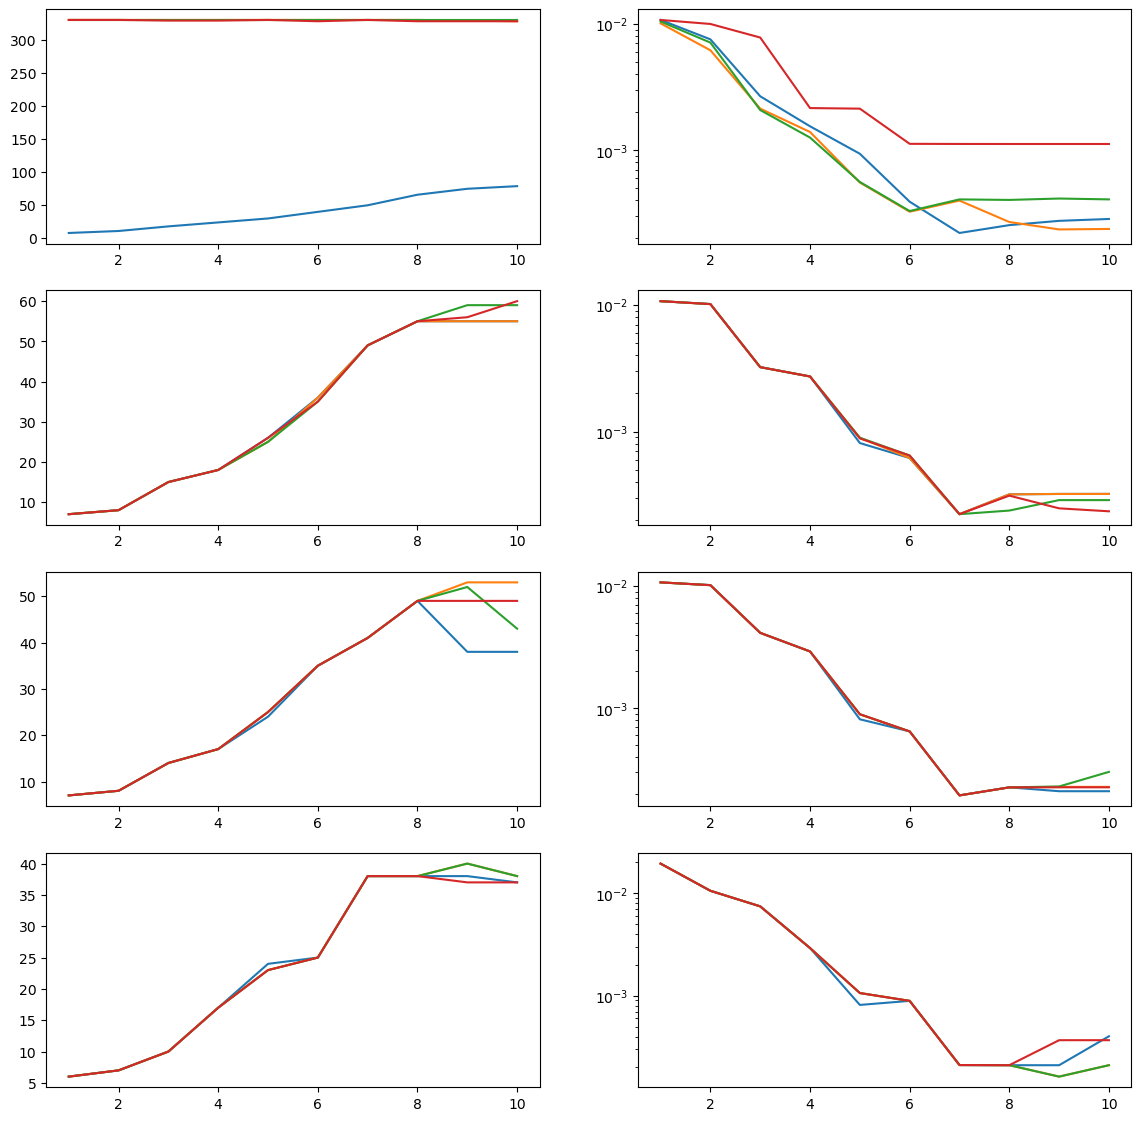

In [844]:
x_lab = [1,2,3,4,5,6,7,8,9,10]

plt.rcParams['figure.figsize'] = (14,14) # (width, height)
fig, ax = plt.subplots(4, 2)

for i in range(4):
    ax[0,0].plot(x_lab, n_star[0][0][i])
    ax[1,0].plot(x_lab, n_star[0][1][i])
    ax[2,0].plot(x_lab, n_star[0][2][i])
    ax[3,0].plot(x_lab, n_star[0][3][i])
    
    ax[0,1].plot(x_lab, Errors[0][0][i])
    ax[1,1].plot(x_lab, Errors[0][1][i])
    ax[2,1].plot(x_lab, Errors[0][2][i])
    ax[3,1].plot(x_lab, Errors[0][3][i])
    
    ax[0,1].set_yscale('log')
    ax[1,1].set_yscale('log')
    ax[2,1].set_yscale('log')
    ax[3,1].set_yscale('log')
    
    

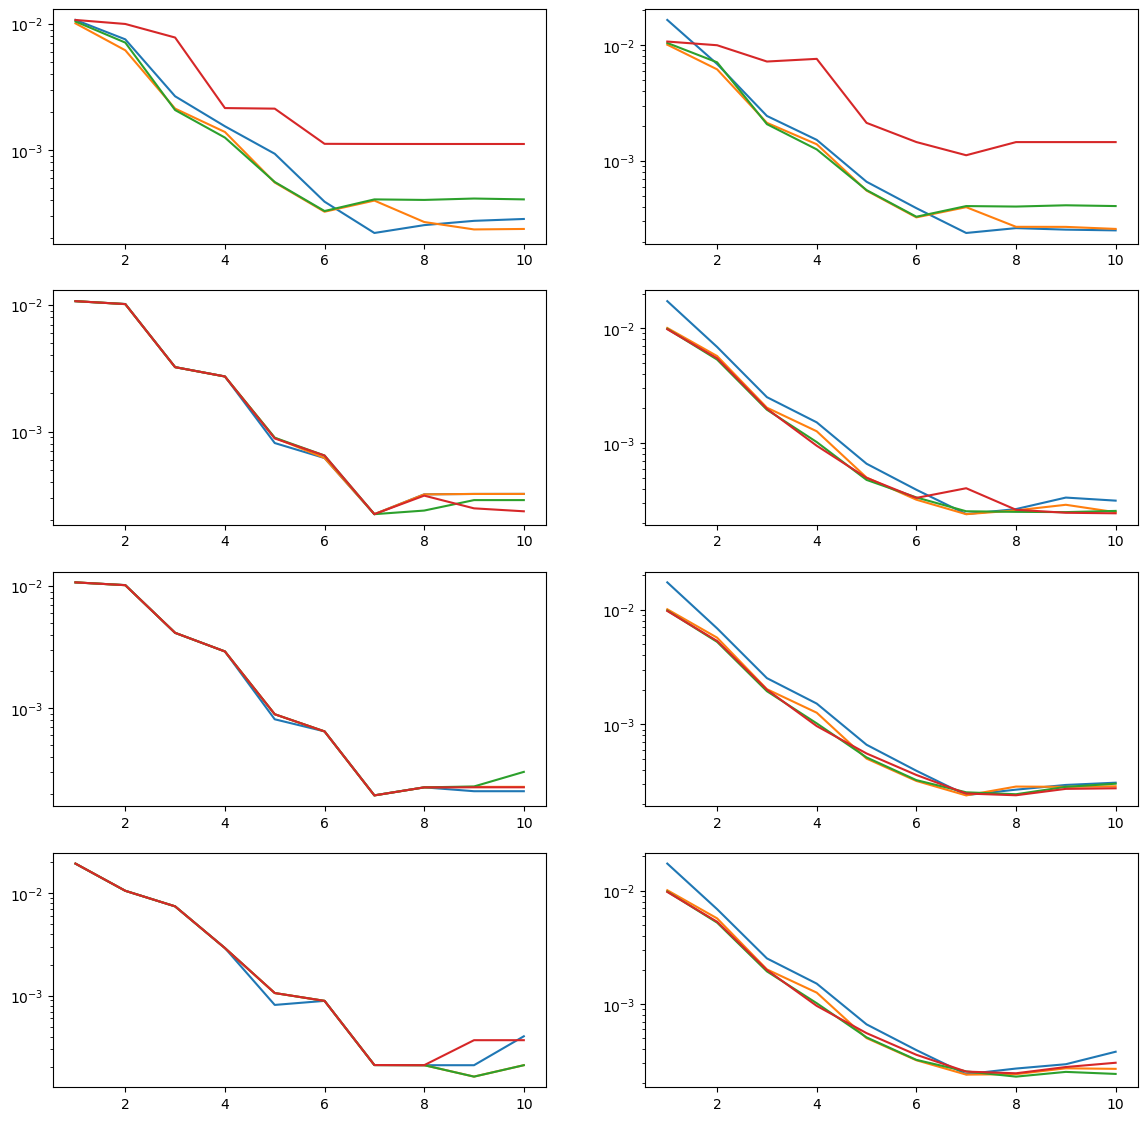

In [849]:
plt.rcParams['figure.figsize'] = (14,14) # (width, height)
fig, ax = plt.subplots(4, 2)

for i in range(4):
    ax[0,0].plot(x_lab, Errors[0][0][i])
    ax[1,0].plot(x_lab, Errors[0][1][i])
    ax[2,0].plot(x_lab, Errors[0][2][i])
    ax[3,0].plot(x_lab, Errors[0][3][i])
    
    ax[0,0].set_yscale('log')
    ax[1,0].set_yscale('log')
    ax[2,0].set_yscale('log')
    ax[3,0].set_yscale('log')
    
    ax[0,1].plot(x_lab, Errors_full[0][0][i])
    ax[1,1].plot(x_lab, Errors_full[0][1][i])
    ax[2,1].plot(x_lab, Errors_full[0][2][i])
    ax[3,1].plot(x_lab, Errors_full[0][3][i])
    
    ax[0,1].set_yscale('log')
    ax[1,1].set_yscale('log')
    ax[2,1].set_yscale('log')
    ax[3,1].set_yscale('log')

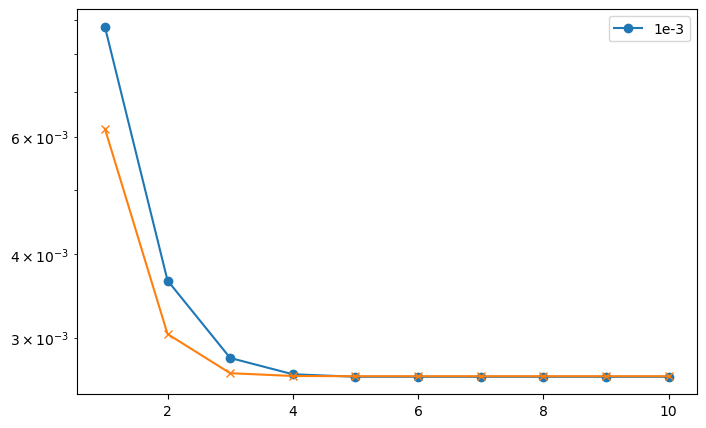

In [755]:
plt.rcParams['figure.figsize'] = (8,5)
l = ['1e-1', '1e-2', '1e-3', '1e-4', '1e-5', '1e-6', '1e-7', '1e-8']

for i in range(2,3):
    plt.plot(x_lab, Errors[0][0][i], '-o', label = l[i])
    #plt.plot(x_lab, Errors[0][1][i], '-x')
    #plt.plot(x_lab, Errors[0][2][i], '--')
    #plt.plot(x_lab, Errors[0][3][i], '-v')
    plt.plot(x_lab, Errors_full[0][0][i], '-x')
plt.yscale('log')
plt.legend();

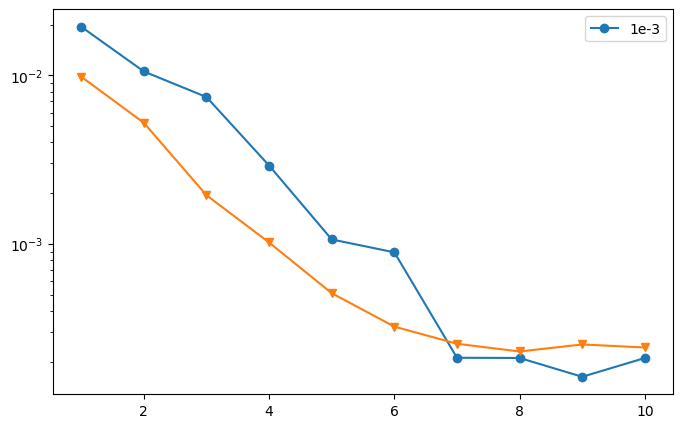

In [851]:
plt.rcParams['figure.figsize'] = (8,5)
l = ['1e-1', '1e-2', '1e-3', '1e-4', '1e-5', '1e-6', '1e-7', '1e-8']

for i in range(2,3):
    plt.plot(x_lab, Errors[0][3][i], '-o', label = l[i])
    #plt.plot(x_lab, Errors_full[0][1][i], '-x')
    #plt.plot(x_lab, Errors_full[0][2][i], '--')
    plt.plot(x_lab, Errors_full[0][3][i], '-v')
plt.yscale('log')
plt.legend()

In [856]:
for i in range(7):
    print(np.min(np.array(Errors[0][3][i])))

0.00021008712312833264
0.00016272060797099962
0.0001626360664585386
0.00021026506403821335
0.00021019461805361138
0.00021019462812364004
0.00028081942269843314


In [771]:
for i in range(8):
    print(Errors_full[0][2][2][i])

0.005410470580534897
0.0029110557300232117
0.00263894370320354
0.002619759204157303
0.002618838020801319
0.0026187578096990407
0.002618749890885179
0.0026187491000003254


In [826]:
np.min(np.array(Errors))

0.0001626360664585386

In [827]:
np.min(np.array(Errors_full))

0.00022744987449720356

In [678]:
for i in range(4):
    print(Errors[0][i][-1][-1])

1.700582565867312
1.7004241401469837
0.054922730128079786
0.006524930379504439


In [393]:
Errors[0][0][4]

[0.02192748826720321,
 0.008408950536042913,
 0.003963076124886521,
 0.0034374780028109796,
 0.0034737363995399916,
 0.003474601675530106,
 0.0034746884091375065,
 0.0034746970844389646,
 0.003474697951993446,
 0.0034746980387450567]

In [220]:
n5_star_D8 = n_star[0].copy()

In [1283]:
# Find optimal parameter for a specific N value
# Then optmize with score = that n* value to see what other parameters we also need to vary

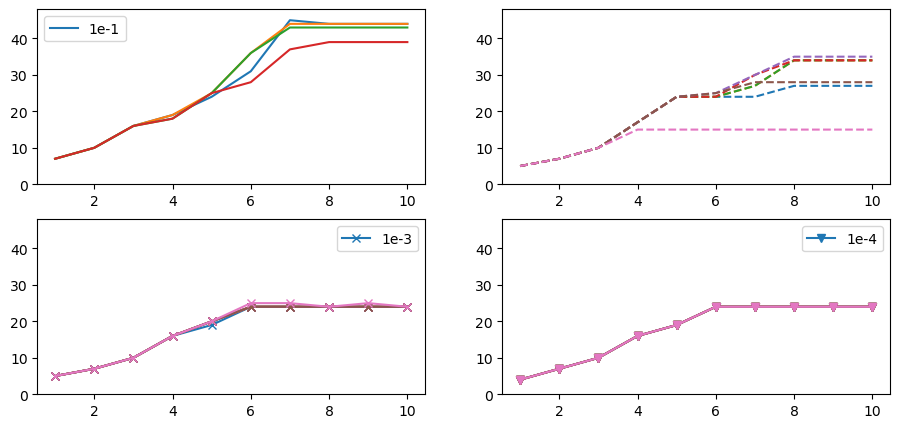

In [248]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(2, 2)


ax[0,0].plot(x_lab, n1_star_D1, '-', label = '1e-1')
ax[0,0].plot(x_lab, n1_star_D2, '-')
ax[0,0].plot(x_lab, n1_star_D3, '-')
ax[0,0].plot(x_lab, n1_star_D4, '-')
ax[0,0].set_ylim(0,48);
ax[0,0].legend();

ax[0,1].plot(x_lab, n2_star_D1, '--', label = '1e-1')
ax[0,1].plot(x_lab, n2_star_D2, '--', label = '1e-2')
ax[0,1].plot(x_lab, n2_star_D3, '--', label = '1e-3')
ax[0,1].plot(x_lab, n2_star_D4, '--', label = '1e-4')
ax[0,1].plot(x_lab, n2_star_D5, '--', label = '1e-5')
ax[0,1].plot(x_lab, n2_star_D6, '--', label = '1e-6')
ax[0,1].plot(x_lab, n2_star_D7, '--', label = '1e-7')
ax[0,1].set_ylim(0,48);
#ax[0,1].legend();

ax[1,0].plot(x_lab, n3_star_D1, '-x', label = '1e-3')
ax[1,0].plot(x_lab, n3_star_D2, '-x')
ax[1,0].plot(x_lab, n3_star_D3, '-x')
ax[1,0].plot(x_lab, n3_star_D4, '-x')
ax[1,0].plot(x_lab, n3_star_D5, '-x')
ax[1,0].plot(x_lab, n3_star_D6, '-x')
ax[1,0].plot(x_lab, n3_star_D7, '-x')
ax[1,0].set_ylim(0,48);
ax[1,0].legend();

ax[1,1].plot(x_lab, n4_star_D1, '-v', label = '1e-4')
ax[1,1].plot(x_lab, n4_star_D2, '-v')
ax[1,1].plot(x_lab, n4_star_D3, '-v')
ax[1,1].plot(x_lab, n4_star_D4, '-v')
ax[1,1].plot(x_lab, n4_star_D5, '-v')
ax[1,1].plot(x_lab, n4_star_D6, '-v')
ax[1,1].plot(x_lab, n4_star_D7, '-v')

#ax[1,1].plot(x_lab, n5_star_D1, '-<', label = '1e-5')
#ax[1,1].plot(x_lab, n5_star_D2, '-<')
#ax[1,1].plot(x_lab, n5_star_D3, '-<')
#ax[1,1].plot(x_lab, n5_star_D4, '-<')
#ax[1,1].plot(x_lab, n5_star_D5, '-<')
#ax[1,1].plot(x_lab, n5_star_D6, '-<')
#ax[1,1].plot(x_lab, n5_star_D7, '-<')

ax[1,1].set_ylim(0,48);
ax[1,1].legend();

In [23]:
np.random.seed(4)
X_mc = tf.cantilever_data(N_mc)

NameError: name 'N_mc' is not defined

In [24]:
X_train_uniform = np.random.uniform(-1,1,(N_train,d))
X_test_uniform = np.random.uniform(-1,1,(N_test,d))

uniform_models = []

for i in range(d):
    temp_model = PCE_Full_Model('PCE_Legendre', d=1, p=6, domain=[[-1,1]], aPCE_model = None, P = None)
    temp_model.fit(np.c_[X_train_uniform[:,i]], np.c_[X_train[:,i]])
    uniform_models.append(temp_model)


def Y_uniform(X):
    d = X.shape[1]
    N = X.shape[0]
    X_uniform = np.zeros((N,d))
    for i in range(d):
        X_uniform[:,i] = uniform_models[i].predict(np.c_[X[:,i]]).reshape(N)
    
    return tf.cantilever(X_uniform)

In [25]:
def normal_pdf(x, mu, sigma):
    return multivariate_normal.pdf

def v_i(mu, cov, B):
    result = scipy.stats.norm.cdf(B[1], mu, cov) - scipy.stats.norm.cdf(B[0], mu, cov)
    #result = multivariate_normal.cdf(np.array(B)[:,1], np.array(mu_vals), cov) \
    #- multivariate_normal.cdf(np.array(B)[:,0], np.array(mu_vals), cov)
    return result

In [26]:
def data_cantilever(N, d, B):
    count = 0

    n_samples = 1000000

    samples = np.zeros((0,d))    # empty for now

    while samples.shape[0] < N: 

        np.random.seed(9+count)
        s = np.random.normal(mu_vals, sigma_vals, size=(n_samples,d))
        for i in range(d):
            accepted = s[( B[i][0] <= s[:,i]) & (s[:,i] <= B[i][1])]
        samples = np.concatenate((samples, accepted), axis=0)
        count += 1
    samples = samples[:N]
    return samples

In [27]:
def data_cantilever_full(N, d, B):

    return tf.cantilever_data(N)

In [28]:
def data_uniform(N, d, B):
    np.random.seed(2357)
    X = np.zeros((N, d))
    for i in range(d):
        X[:,i] = np.random.uniform(B[i][0], B[i][1], size = N)
    return X

In [650]:
mu_vals = [42, 5, 560, 1800, 1800, 1000, 19*10**5]
sigma_vals = [42*0.0119, 5*0.02, 56, 180, 180, 100, 19*10**4]

In [651]:
B_init_aPCE = []
for i in range(d):
    B_init_aPCE.append([np.min([X_train[:,i].min(), X_test[:,i].min(), X_pol[:,i].min()]), np.max([X_train[:,i].max(), X_test[:,i].max(), X_pol[:,i].max()])])
    

In [652]:
p = list(range(1,6))

## 'Exact' values using PCE with p = 8

In [988]:
GSA_Cantilever_1st_Order = [0,
0,
0.5020660534221470516769159075920470058917999267578125,
0,
0,
0,
0.497933946577852892811932861150125972926616668701171875]

GSA_Cantilever_Total_Order = [0,
0,
0.5020660534221470516769159075920470058917999267578125,
0,
0,
0,
0.497933946577852892811932861150125972926616668701171875]

In [989]:
V_Cantilever = 0.052984905968656903496594168245792388916015625

In [990]:
mean_Cantilever = 1.6268444116256308706880417958018369972705841064453125

### MC GSA

In [131]:
dataA = pd.DataFrame(tf.cantilever_data(N_mc)).values
dataB = pd.DataFrame(tf.cantilever_data(N_mc)).values

GSA_Cantilever_MC, V_Cantilever_MC = sobol_GSA(d, tf.cantilever).sobol_MC(dataA, dataB)

In [132]:
mean_Cantilever = np.mean(tf.cantilever(X_pol))
mean_Cantilever

1.623172702936835

In [133]:
V_Cantilever

0.052984905968656903

In [134]:
np.sum(tf.cantilever(X_mc)<=1)/N_mc

0.0007194

## Building Full_PCE_Model

In [271]:
p = [1,2,3]

for i in range(len(p)):
    
    t0 = time.time()

    param_space = {'A_0': skopt.space.Real(1e-03, 1e-01, prior = 'log-uniform'),
                   'B_0': skopt.space.Real(1e-08, 1e-01, prior = 'log-uniform'),
                   'C_0': skopt.space.Real(1e-03, 1e-01, prior = 'log-uniform'),
                   'D_0': skopt.space.Real(1e-07, 1e-01, prior = 'log-uniform')
                }

    optimizer = BayesSearchCV(estimator = PCE_Full_Model('PCE_Hermite', d = d, p = p[i], domain = None,
                                                        sigma_vals = sigma_vals, mu_vals = mu_vals),
                                search_spaces = param_space,
                                n_iter = 20,
                                n_jobs = 5,
                                n_points = 1,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print(time.time() - t0)

    print('p =', p[i], optimizer.best_params_)

5.585618257522583
p = 1 OrderedDict([('A_0', 0.0839778938329199), ('B_0', 0.0003367627817788733), ('C_0', 0.005729378246783675), ('D_0', 0.0331426968076449)])
9.527873992919922
p = 2 OrderedDict([('A_0', 0.007890348027163261), ('B_0', 0.00010701372979443891), ('C_0', 0.044436795224170114), ('D_0', 7.145192361546151e-05)])
27.898850917816162
p = 3 OrderedDict([('A_0', 0.013268244225937193), ('B_0', 1.1098082648121802e-05), ('C_0', 0.01737160667976809), ('D_0', 0.011358450704405741)])


In [272]:
p = list(range(1,5))

best_params_full = [OrderedDict([('A_0', 0.0839778938329199), ('B_0', 0.0003367627817788733), ('C_0', 0.005729378246783675), ('D_0', 0.0331426968076449)]),
                    OrderedDict([('A_0', 0.007890348027163261), ('B_0', 0.00010701372979443891), ('C_0', 0.044436795224170114), ('D_0', 7.145192361546151e-05)]),
                    OrderedDict([('A_0', 0.013268244225937193), ('B_0', 1.1098082648121802e-05), ('C_0', 0.01737160667976809), ('D_0', 0.011358450704405741)]),
                    OrderedDict([('A_0', 0.012640037787452985), ('B_0', 5.2785600219729537e-08), ('C_0', 0.03094558079657989), ('D_0', 0.00014194645737102815)]),
                    OrderedDict([('A_0', 0.1), ('B_0', 1e-08), ('C_0', 0.0010546520465423079), ('D_0', 1e-06)])
                   ]


In [273]:
results_Cantilever_full = collect_results_PCE(p, d, tf.cantilever, best_params_full, 
                                                X_train, None, X_test, Y_train, Y_test, 'PCE_Hermite', PCE_Full_Model, 
                                                       B_init = None, sigma_vals = sigma_vals, mu_vals = mu_vals)


0.06079912185668945
p = 1 n* =  8
0.24925589561462402
p = 2 n* =  36
0.4237539768218994
p = 3 n* =  120
6.506296157836914
p = 4 n* =  330


# AFVB

## Global Models

In [315]:
p = [3]

for i in range(len(p)):
    
    mod = aPCE(X_pol, p[i])
    P = mod.Create_Orthonormal_Polynomials(p[i])
    
    t0 = time.time()

    param_space = {'A_0': skopt.space.Real(1e-03, 1e-01, prior = 'log-uniform'),
                   'B_0': skopt.space.Real(1e-08, 1e-01, prior = 'log-uniform'),
                   'C_0': skopt.space.Real(1e-03, 1e-01, prior = 'log-uniform'),
                   'D_0': skopt.space.Real(1e-07, 1e-01, prior = 'log-uniform')
                }

    optimizer = BayesSearchCV(estimator = AFVB_PCE('aPCE', d = d, p = p[i], domain = None, 
                                                   aPCE_model = mod, P = P),
                                search_spaces = param_space,
                                n_iter = 20,
                                n_jobs = 5,
                                n_points = 1,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print(time.time() - t0)

    print('p =', p[i], optimizer.best_params_)

36.564889907836914
p = 3 OrderedDict([('A_0', 0.05224846371063367), ('B_0', 8.213624704135743e-08), ('C_0', 0.0014670040441234961), ('D_0', 0.0052539479437301315)])


In [316]:
best_params_AFVB_Global_aPCE = [OrderedDict([('A_0', 0.1), ('B_0', 6.615749122483017e-06), ('C_0', 0.001), ('D_0', 0.1)]),
                                OrderedDict([('A_0', 0.0012600840421057094), ('B_0', 2.7823165370033e-05), ('C_0', 0.035296837657924865), ('D_0', 1.2000647971119917e-05)]),
                                OrderedDict([('A_0', 0.05224846371063367), ('B_0', 8.213624704135743e-08), ('C_0', 0.0014670040441234961), ('D_0', 0.0052539479437301315)]),
                                OrderedDict([('A_0', 0.07290628951850422), ('B_0', 5.618127407922062e-06), ('C_0', 0.1), ('D_0', 0.011775465750445826)]),
                                OrderedDict([('A_0', 0.07290628951850422), ('B_0', 5.618127407922062e-06), ('C_0', 0.1), ('D_0', 0.011775465750445826)])
                               ]

                                

In [1073]:
B0 = list(np.linspace(1e-1, 1e-2, 5))\
    + list(np.linspace(1e-2, 1e-3, 5))[1:]\
    + list(np.linspace(1e-3, 1e-4, 5))[1:]\
    + list(np.linspace(1e-4, 1e-5, 5))[1:]\
    + list(np.linspace(1e-5, 1e-6, 5))[1:]\
    + list(np.linspace(1e-6, 1e-7, 5))[1:]\
    + list(np.linspace(1e-7, 1e-8, 5))[1:]

In [119]:
B0 

[0.0001,
 9e-05,
 8e-05,
 7e-05,
 6e-05,
 5e-05,
 3.9999999999999996e-05,
 2.9999999999999997e-05,
 1.9999999999999998e-05,
 1e-05,
 9e-06,
 8.000000000000001e-06,
 7.000000000000001e-06,
 6.000000000000001e-06,
 5.000000000000001e-06,
 4.000000000000001e-06,
 3.000000000000001e-06,
 2.000000000000001e-06,
 1e-06]

In [275]:
B0 = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

In [276]:
t0 = time.time()

p = 3

mod = aPCE(X_pol, p)
P = mod.Create_Orthonormal_Polynomials(p)

params = [{'A_0': [1e-1, 1e-2, 1e-3],
           'B_0': B0,
           'C_0': [1e-1, 1e-2, 1e-3],
           'D_0': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
                    }]

gs_knn = GridSearchCV(estimator = AFVB_PCE('aPCE', d = d, p = p, domain = None, aPCE_model = mod, 
                                           P = P, A_0 = 1e-1, C_0 = 1e-1),
                      param_grid = params,
                      n_jobs = 5,
                      scoring='neg_mean_squared_error',
                      cv = 5)
gs_knn.fit(X_train, Y_train)

print(time.time() - t0)

gs_knn.best_params_

KeyboardInterrupt: 

In [590]:
p = list(range(1,6))

best_params_AFVB_Global_aPCE = [OrderedDict([('A_0', 1e-1), ('B_0', 1e-05), ('C_0', 1e-1), ('D_0', 1e-1)]), 
                                OrderedDict([('A_0', 1e-1), ('B_0', 1e-03), ('C_0', 1e-1), ('D_0', 1e-2)])]\
                              +[OrderedDict([('A_0', 1e-1), ('B_0', 5.5e-06), ('C_0', 1e-1), ('D_0', 1e-1)])]\
                              +[OrderedDict([('A_0', 1e-1), ('B_0', 1e-08), ('C_0', 1e-1), ('D_0', 1e-1)])]\
                              +[OrderedDict([('A_0', 1e-1), ('B_0', 1e-08), ('C_0', 1e-1), ('D_0', 1e-1)])]


### aPCE

In [591]:
p = list(range(1,5))
results_Cantilever_AFVB_aPCE_Global = collect_results_PCE(p, d, tf.cantilever, best_params_AFVB_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, Y_test, 'aPCE', AFVB_PCE)

0.06952500343322754
p = 1 n* =  6
0.8050949573516846
p = 2 n* =  12
1.3919401168823242
p = 3 n* =  44
20.333622932434082
p = 4 n* =  87


In [592]:
# n = 12
results_Cantilever_AFVB_aPCE_Global[1]

[0.018542506431362144,
 0.004772695834931846,
 0.000986340874982517,
 0.00011007683609864508]

In [522]:
# n = 11
results_Cantilever_AFVB_aPCE_Global[1]

[0.018709556306895875,
 0.0031416161952951167,
 0.000788071959048682,
 0.00014032665303311432]

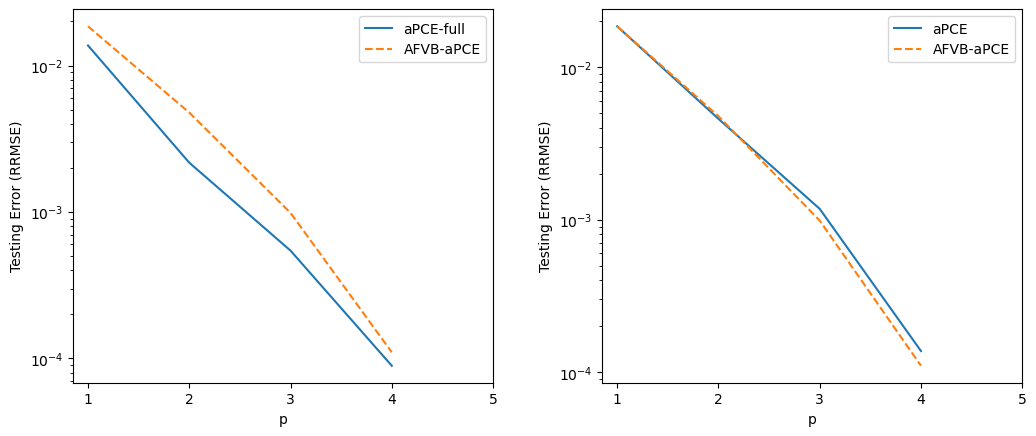

In [593]:
p = list(range(1,6))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(range(1,5), results_Cantilever_full[0], '-', label = 'aPCE-full')


#ax[0].plot(range(1,5), results_Cantilever_AFVB_aPCE_Global[0], '-', label = 'aPCE')
ax[0].plot(range(1,5), results_Cantilever_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')
#ax[0].plot(range(1,6), results_Cantilever_AFVB_aPCE_Global300[0], ':', label = 'aPCE')

ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RRMSE)")
ax[0].legend()

ax[1].plot(range(1,5), results_Cantilever_AFVB_aPCE_Global[0], '-', label = 'aPCE')
ax[1].plot(range(1,5), results_Cantilever_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')
#ax[1].plot(range(1,6), results_Cantilever_AFVB_aPCE_Global2[1], '--', label = 'AFVB-aPCE2')

ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RRMSE)")
ax[1].legend()

fig.tight_layout(pad = 3.0);
#plt.savefig(wd + '/Cantilever_AFVB_Error.png')

In [727]:
N_list = [80, 100, 120, 140, 160, 180, 200, 240, 300, 320]

p1_error = [0.031489975387965524, 0.0127965563856869, 0.01499272717565019, 0.01588649814712783, 
            0.020776685210345806, 0.018265875443285787, 0.01746387669347738, 
            0.01413230867648398, 
            0.01229517924895752, 0.013678220640090522]

p2_error = [0.0073615311375375475, 0.0016465410403428556, 0.001878021751851514, 0.00226975297384672, 
            0.003196533174021381, 0.003183515640265188, 0.0031880101101300963, 
            0.002276874763807201, 
            0.0016360791895580157, 0.0018623482906928901]

p3_error = [0.001445146619604611, 0.0002957929972955379, 0.00020983564181110276, 0.0003379620939959184,
            0.0005946890885103562, 0.0006562684011869774, 0.0006597671703144313, 
            0.00025252010002014473, 
            0.000240334015406822, 0.0002846363422441995]


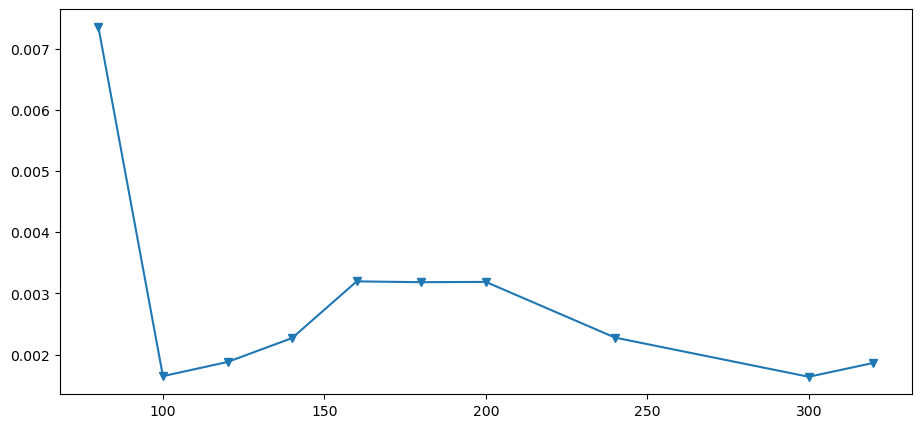

In [739]:
#plt.plot(N_list, p1_error, '-o')
plt.plot(N_list, p2_error, '-v')
#plt.plot(N_list, p3_error, '-v')

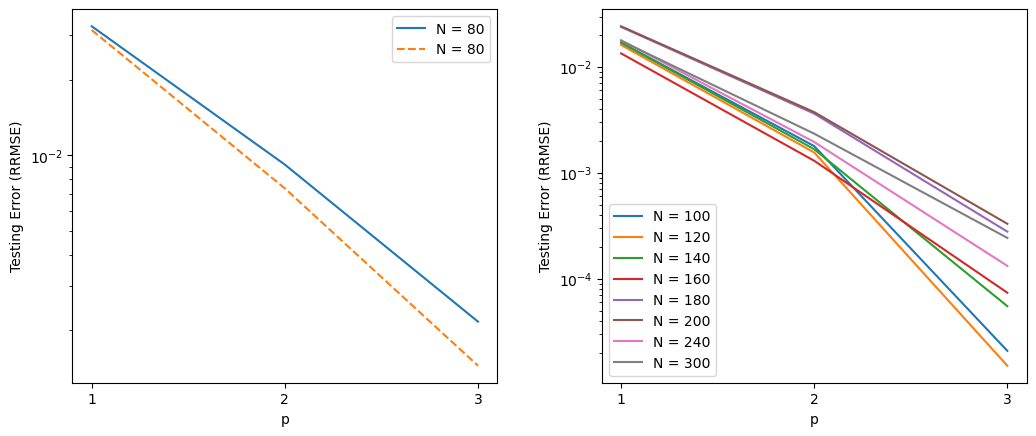

In [1338]:
p = list(range(1,4))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

#ax[0].plot(range(1,5), results_Cantilever_AFVB_aPCE_Global[0], '-', label = 'aPCE')
#ax[0].plot(range(1,5), results_Cantilever_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')
#ax[0].plot(p, results_Cantilever_AFVB_aPCE_Global[0], '-', label = 'aPCE')

#ax[1].plot(range(1,6), results_Cantilever_full[0], '-', label = 'aPCE-full')
ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_80[0], '-', label = 'N = 80')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_100[0], '-', label = 'N = 100')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_120[0], '-', label = 'N = 120')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_140[0], '-', label = 'N = 140')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_160[0], '-', label = 'N = 160')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_180[0], '-', label = 'N = 180')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_200[0], '-', label = 'N = 200')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_240[0], '-', label = 'N = 240')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_300[0], '-', label = 'N = 300')

#ax[0].plot(range(1,6), results_Cantilever_AFVB_aPCE_Global2[1], '--', label = 'AFVB-aPCE200')
ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_80[1], '--', label = 'N = 80')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_100[1], '--', label = 'N = 100')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_120[1], '--', label = 'N = 120')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_140[1], '--', label = 'N = 140')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_160[1], '--', label = 'N = 160')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_180[1], '--', label = 'N = 180')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_200[1], '--', label = 'N = 200')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_240[1], '--', label = 'N = 240')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_300[1], '--', label = 'N = 300')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_320[1], '--', label = 'N = 320')

ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RRMSE)")
ax[0].legend()

ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_100[6], '-', label = 'N = 100')
ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_120[6], '-', label = 'N = 120')
ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_140[6], '-', label = 'N = 140')
ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_160[6], '-', label = 'N = 160')
ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_180[6], '-', label = 'N = 180')
ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_200[6], '-', label = 'N = 200')
ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_240[6], '-', label = 'N = 240')
ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_300[6], '-', label = 'N = 300')

#ax[1].plot(range(1,5), results_Cantilever_AFVB_aPCE_Global1[6], '-', label = 'aPCE_Train1')
#ax[1].plot(range(1,5), results_Cantilever_AFVB_aPCE_Global1[7], '--', label = 'AFVB-aPCE_Train1')

#ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global[6], '-', label = 'aPCE_Train2')
#ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global[7], '--', label = 'AFVB-aPCE_Train2')

ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RRMSE)")
ax[1].legend()

fig.tight_layout(pad = 3.0);
#plt.savefig(wd + '/Cantilever_AFVB_Error.png')

### aPCE_Stieltjes

In [118]:
# Optimized Hyper-Parameters: slurm-10259858
best_params_AFVB_Global_aPCE_Stieltjes = [OrderedDict([('A_0', 0.0031345940965261877), ('B_0', 9.731502957374272e-06), ('C_0', 0.01), ('D_0', 1e-06)]), 
                                          OrderedDict([('A_0', 0.009045287467164105), ('B_0', 1.0068688996432784e-06), ('C_0', 0.007056479413530125), ('D_0', 3.5061498797193106e-06)]),
                                          OrderedDict([('A_0', 0.006191259089303629), ('B_0', 3.3764963001637265e-06), ('C_0', 0.009996112871203326), ('D_0', 8.543390525107157e-06)]),
                                          OrderedDict([('A_0', 0.009923541955208236), ('B_0', 1.0872919706624057e-06), ('C_0', 0.007147107259789429), ('D_0', 1.366016320861581e-06)])]


In [203]:
results_Cantilever_AFVB_aPCE_Stieltjes_Global = collect_results_PCE(p, d, tf.cantilever, best_params_AFVB_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE_Stieltjes', AFVB_PCE, None)

0.0935821533203125
p = 1 n* =  6
0.401810884475708
p = 2 n* =  13
1.9162402153015137
p = 3 n* =  33
16.512445211410522
p = 4 n* =  55


### PCE

In [496]:
p = [4]

for i in range(len(p)):

    t0 = time.time()

    param_space = {'A_0': skopt.space.Real(1e-8, 1e-1),
                    'B_0': skopt.space.Real(1e-8, 2e-8),
                    'C_0': skopt.space.Real(1e-8, 1e-1),
                    'D_0': skopt.space.Real(1e-8, 1e-1)
                }

    optimizer = BayesSearchCV(estimator = AFVB_PCE('PCE_Hermite', d = d, p = p[i], sigma_vals = sigma_vals, mu_vals = mu_vals),
                                search_spaces = param_space,
                                n_iter = 30,
                                n_jobs = 5,
                                n_points = 1,
                                scoring = 'neg_mean_squared_error',
                                cv = 5, 
                                error_score = 5
    )

    optimizer.fit(X_test, Y_test)

    print(time.time() - t0)

    print('p =', p[i], optimizer.best_params_)

/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:176: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:176: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, sig

80.62982702255249
p = 4 OrderedDict([('A_0', 0.09179915239197273), ('B_0', 1.1089968222349492e-08), ('C_0', 0.014812900445539715), ('D_0', 0.08313191098019777)])


In [512]:
p = list(range(1,5))

best_params_AFVB_Global_PCE = [OrderedDict([('A_0', 1e-08), ('B_0', 1e-08), ('C_0', 0.1), ('D_0', 0.06509430226009653)]),
                               OrderedDict([('A_0', 1.0000000002400913e-08), ('B_0', 1e-08), ('C_0', 0.1), ('D_0', 0.1)]),
                               OrderedDict([('A_0', 0.02923145513447614), ('B_0', 1e-8), ('C_0', 0.03698609370868848), ('D_0', 0.037370541459414125)]),
                               OrderedDict([('A_0', 0.09179915239197273), ('B_0', 1.1089968222349492e-08), ('C_0', 0.014812900445539715), ('D_0', 0.08313191098019777)])]


In [269]:
p = list(range(1,5))
best_params_AFVB_Global_PCE = [OrderedDict([('A_0', 0.06907203581253785), ('B_0', 0.004056055358472668), ('C_0', 0.02874827056881559), ('D_0', 0.08096969845245917)]),
                               OrderedDict([('A_0', 0.01), ('B_0', 1e-08), ('C_0', 0.04057414787165166), ('D_0', 0.08420473345416973)]),
                               OrderedDict([('A_0', 0.06723278902711148), ('B_0', 1e-08), ('C_0', 0.09059611356687705), ('D_0', 0.09666627321935345)]),
                               OrderedDict([('A_0', 0.06723278902711148), ('B_0', 1e-08), ('C_0', 0.09059611356687705), ('D_0', 0.09666627321935345)])
                              ]

In [1101]:
p = list(range(1,5))

best_params_AFVB_Global_PCE = [OrderedDict([('A_0', 1e-1), ('B_0', 1e-05), ('C_0', 1e-1), ('D_0', 1e-01)]), 
                                OrderedDict([('A_0', 1e-1), ('B_0', 1e-07), ('C_0', 1e-1), ('D_0', 1e-01)])]\
                              +[OrderedDict([('A_0', 1e-1), ('B_0', 1e-06), ('C_0', 1e-1), ('D_0', 1e-01)])]\
                              +[OrderedDict([('A_0', 1e-1), ('B_0', 1e-10), ('C_0', 1e-1), ('D_0', 1e-01)])]\
+[OrderedDict([('A_0', 1e-1), ('B_0', 1e-09), ('C_0', 1e-1), ('D_0', 1e-01)])]


In [1102]:
results_Cantilever_AFVB_PCE_Global = collect_results_PCE(p, d, tf.cantilever, best_params_AFVB_Global_aPCE, 
                                                X_train, None, X_test, Y_train, Y_test, 'PCE_Hermite', AFVB_PCE, 
                                                       B_init = None, sigma_vals = sigma_vals, mu_vals = mu_vals)


0.2168288230895996
p = 1 n* =  7
0.5364089012145996
p = 2 n* =  16
1.5106010437011719
p = 3 n* =  39
14.072107076644897
p = 4 n* =  84


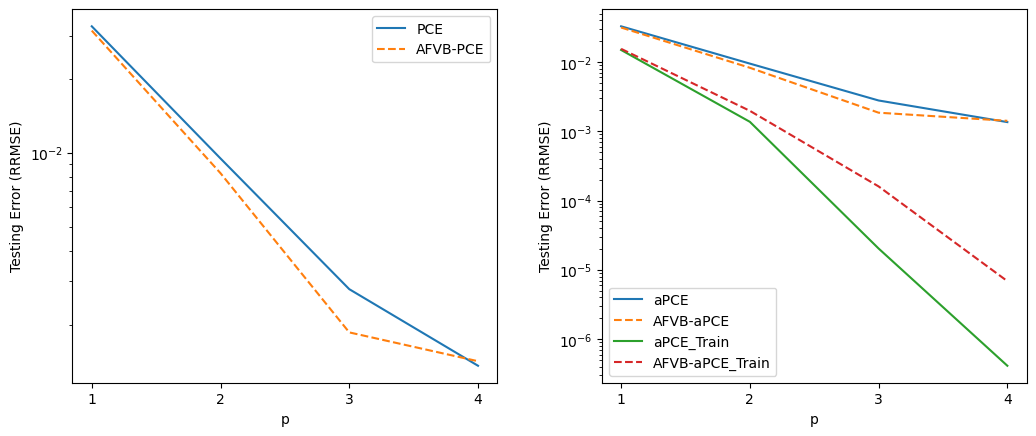

In [1181]:
p = list(range(1,5))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global[0], '-', label = 'aPCE')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')
#ax[0].plot(p, results_Cantilever_AFVB_aPCE_Global[0], '-', label = 'aPCE')

ax[0].plot(p, results_Cantilever_AFVB_PCE_Global[0], '-', label = 'PCE')
ax[0].plot(p, results_Cantilever_AFVB_PCE_Global[1], '--', label = 'AFVB-PCE')

#ax[0].plot(p, results_Cantilever_AFVB_PCE_Global[6], '-', label = 'PCE_Train')
#ax[0].plot(p, results_Cantilever_AFVB_PCE_Global[7], '--', label = 'AFVB-PCE_Train')

#ax[0].plot(p, results_Cantilever_VRVM_aPCE_Global[7], '--', label = 'VRVM-PCE_Train')

ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RRMSE)")
ax[0].legend()

ax[1].plot(p, results_Cantilever_AFVB_PCE_Global[0], '-', label = 'aPCE')
ax[1].plot(p, results_Cantilever_AFVB_PCE_Global[1], '--', label = 'AFVB-aPCE')

ax[1].plot(p, results_Cantilever_AFVB_aPCE_Global[6], '-', label = 'aPCE_Train')
ax[1].plot(p, results_Cantilever_AFVB_aPCE_Global[7], '--', label = 'AFVB-aPCE_Train')

ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RRMSE)")
ax[1].legend()

fig.tight_layout(pad = 3.0);
#plt.savefig(wd + '/Cantilever_AFVB_Error.png')

## Local Models

### aPCE

In [1039]:
params_init_list = np.array(list(params_init_AFVB.values())*(4**d)).reshape(4**d,4)


In [1080]:
p = 2
temp_model = ME_PCE('aPCE', d, p, [B_init_aPCE], tf.cantilever, AFVB_PCE, data_cantilever, 80, N_pol, 
                 theta1 = [1e-3], theta2 = [1e-3], alpha = 0.5, 
                 arg1 = params_init_list[:,0], 
                 arg2 = params_init_list[:,1], 
                 arg3 = params_init_list[:,2], 
                 arg4 = params_init_list[:,3], 
                 sigma_vals = sigma_vals, 
                 mu_vals = mu_vals, n_iter = 1)

temp_model.fit(None, None)

ME_PCE(B_init=[[[39.650530432832404, 44.58234787797745],
                [4.4992484719573715, 5.469907351708593],
                [292.4607634566976, 829.737607608933],
                [946.1264006601876, 2672.0093664258884],
                [926.7771242899148, 2639.5532614526437],
                [512.9012471044985, 1505.3536926546158],
                [969063.4943271616, 2827097.033355245]]],
       N_p=1000000, N_t=80, PCE_method='aPCE',
       alg_mod=<class 'AFVB_PCE.A...
       arg2=array([0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001]),
       arg3=array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]),
       arg4=array([0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001]), d=7,
       data_fun=<function data_cantilever at 0x2a0f459e0>,
       fun=<function cantilever at 0x16b914680>,
       mu_vals=[42, 5, 560, 1800, 1800, 1000, 1900000], n_iter=1, p=2,
       sigma_vals=[0.4998, 0.1, 56, 180, 180, 100, 190000], theta1=[0.001],
       theta2=[0.001])

In [1114]:
B0 = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
n_star = []
L_max = []

N_t = 80

p = [4]

for j in range(len(p)):
    print('')
    print('p = ', p[j])
    
    n_star_p = []
    L_max_p = []
    
    
    for k in range(temp_model.B_split.shape[0]):
        print('k = ', k)
        X_t = data_cantilever(N_t, d, temp_model.B_split[k])
        Y_t = tf.cantilever(X_t)
        X_p = data_cantilever(N_pol, d, temp_model.B_split[k])
        
        mod = aPCE(X_p, p[j])
        P = mod.Create_Orthonormal_Polynomials(p[j])


        n_star_temp =[]
        L_max_temp = []

        for i in range(len(B0)):
            model = AFVB_PCE('aPCE', d = d, p = p[j], domain = temp_model.B_split[k], aPCE_model = mod, P = P, 
                             B_0 = B0[i],
                             A_0 = 1e-1, C_0 = 1e-1, D_0 = 1e-1)
            model.fit(X_train, Y_train)

            n_star_temp.append(model.n_star)
            L_max_temp.append(model.L_beta[model.max_beta])
            #print('i = ', i)
            
        n_star_p.append(n_star_temp)
        L_max_p.append(L_max_temp)
        
        
    n_star.append(n_star_p)
    L_max.append(L_max_p)
  


p =  4
k =  0


ValueError: math domain error

In [1119]:
n_star_temp

[5, 9, 16, 18, 26, 36, 49]

In [1107]:
L_max[2]

[[217.61967669002738,
  355.69483009057654,
  483.54199680941014,
  600.9542216421052,
  683.518035258715,
  730.5872813803022,
  738.8239446953088,
  740.4033949493771,
  740.3575920712069,
  740.145815143286],
 [218.51621765702856,
  356.5886965588437,
  486.596663214015,
  604.0782950224783,
  690.8769739347038,
  738.1443584457721,
  757.9754367958946,
  754.564172118133,
  754.5228557016131,
  753.2834956515363]]

In [1102]:
np.argmax(L_max[2][0])+1

8

In [1103]:
np.argmax(L_max[2][1])+1

7

In [998]:
p = [2]
N_t = [80]*5

theta1 = [[1e-5, 1e-1]]

theta2 = [[1e-5, 1e-1]]

Find_B_split(p, d, tf.cantilever, params_init_AFVB, 
                X_test, 'aPCE', AFVB_PCE, N_t, N_pol, data_cantilever, 
                B_init_aPCE, None, None, n_iter = 1, 
                theta1 = theta1, theta2 = theta2, alpha = 0.5)

time = 11.802047967910767
p = 2 M = 8
[[0.5 1.  0.5 1.  1.  1.  0.5]
 [0.5 1.  0.5 1.  1.  1.  0.5]
 [0.5 1.  0.5 1.  1.  1.  0.5]
 [0.5 1.  0.5 1.  1.  1.  0.5]
 [0.5 1.  0.5 1.  1.  1.  0.5]
 [0.5 1.  0.5 1.  1.  1.  0.5]
 [0.5 1.  0.5 1.  1.  1.  0.5]
 [0.5 1.  0.5 1.  1.  1.  0.5]]


In [1184]:
best_params_AFVB_ME_aPCE = [[OrderedDict([('A_0', 1e-01), ('B_0', 1e-04), ('C_0', 1e-01), ('D_0', 1e-01)])]*2]\
                            + [[OrderedDict([('A_0', 1e-01), ('B_0', 1e-04), ('C_0', 1e-01), ('D_0', 1e-01)])]*2]\
                            + [[OrderedDict([('A_0', 1e-01), ('B_0', 1e-07), ('C_0', 1e-01), ('D_0', 1e-01)]), OrderedDict([('A_0', 1e-01), ('B_0', 1e-09), ('C_0', 1e-01), ('D_0', 1e-01)])]]\
                            + [[OrderedDict([('A_0', 1e-01), ('B_0', 1e-09), ('C_0', 1e-01), ('D_0', 1e-01)])]*8]


In [1185]:
p = list(range(1,4))

N_t = [80, 80, 80, 80]

theta1 = [[1e-1, 1e-1],
          [1e-3, 1e-1],
          [1e-1, 1e-1],
          [1e-1, 1e-1]]

theta2 = [[1e-1, 1e-1],
          [1e-3, 1e-1],
          [1e-1, 1e-1],
          [1e-1, 1e-1]]

results_Cantilever_AFVB_aPCE_ME = collect_results_ME(p, d, tf.cantilever, best_params_AFVB_ME_aPCE, 
                                                  X_test, 'aPCE', AFVB_PCE, N_t, N_pol, data_cantilever, 
                                                  B_init_aPCE, n_iter = 1, 
                                                  theta1 = theta1, theta2 = theta2, alpha = 0.5,
                                                  params_init = params_init_AFVB, p_split = 2, N_t_split = 80)

time = 2.183511734008789
p = 1 M = 2
n_star: [5, 5]
0    2.193990e-03
1    3.771609e-04
2    2.609997e-02
3   -2.220446e-16
4   -2.220446e-16
5   -2.220446e-16
6    2.651551e-02
Name: Partial Variance, dtype: float64
0    0.002213
1    0.000378
2    0.026292
3    0.000000
4    0.000000
5    0.000000
6    0.026729
Name: Total Variance, dtype: float64
0.055399664560751516 1.6248877978164096
time = 3.072732925415039
p = 2 M = 2
n_star: [15, 13]
0    2.060306e-03
1    4.287762e-04
2    2.628360e-02
3    5.799653e-06
4    1.904684e-05
5   -2.220446e-16
6    2.568415e-02
Name: Partial Variance, dtype: float64
0    0.002099
1    0.000435
2    0.026562
3    0.000007
4    0.000021
5    0.000000
6    0.025964
Name: Total Variance, dtype: float64
0.05478490900091337 1.6244512369881279
time = 7.219756603240967
p = 3 M = 2
n_star: [34, 41]
0    2.089137e-03
1    4.255370e-04
2    2.635006e-02
3    4.944010e-06
4    1.896697e-05
5    2.138157e-08
6    2.564975e-02
Name: Partial Variance, dtype: floa

### aPCE_Stieltjes

In [278]:
results_Cantilever_AFVB_PCE_Global[4]

[array([1.62014372]), array([1.62425108]), array([1.62327336])]

### PCE

!!!!!!!!I need to change the code and follow the theory of the paper to do this method with non-uniform inputs

In [110]:
B_init = [[-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1]]
N_t = [70, 60, 60, 60]
results_Cantilever_AFVB_PCE_ME = collect_results_ME(p, d, Y_uniform, best_params_AFVB_ME_PCE, 
                                                  X_test_uniform, 'PCE_Legendre', AFVB_PCE, N_t, None, data_uniform,
                                                    B_init, n_iter = 1, theta1 = 0.0000001, theta2 = 0.0000001, alpha = 0.5)

time = 6.6287877559661865
M = 64
n_star: [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2]
0    2.586703e-07
1    1.341094e-12
2    1.051053e-05
3    3.280865e-08
4    1.425716e-08
5    7.673666e-08
6    2.695685e-06
Name: Partial Variance, dtype: float64
0    5.552302e-06
1    4.128394e-11
2    1.894793e-05
3    4.653691e-06
4    5.288368e-06
5    5.271720e-06
6    6.720730e-06
Name: Total Variance, dtype: float64
2.3318009543672746e-05 1.6126522702368724
time = 91.10159921646118
M = 128
n_star: [2, 2, 4, 5, 2, 2, 3, 3, 2, 2, 4, 4, 2, 2, 3, 3, 2, 4, 5, 5, 2, 2, 5, 4, 2, 2, 5, 3, 2, 2, 5, 4, 2, 3, 5, 6, 3, 2, 4, 9, 2, 2, 4, 5, 2, 3, 5, 7, 2, 2, 6, 5, 4, 2, 6, 5, 5, 2, 4, 5, 3, 2, 7, 4, 2, 2, 4, 3, 2, 2, 4, 3, 3, 2, 4, 4, 3, 4, 4, 4, 2, 2, 4, 3, 2, 3, 3, 3, 2, 2, 4, 4, 3, 2, 3, 4, 2, 2, 6, 4, 4, 3, 6, 5, 2, 2, 4, 5, 2, 2, 5, 4, 2, 2, 4, 4, 2, 2, 

In [32]:
results_Cantilever_AFVB_aPCE_Global[5]

[0.05367687256360712,
 0.05472314460382133,
 0.05474922450003356,
 0.05474662322527148,
 0.05475635280248566]

## Plots for AFVB - Cantilever

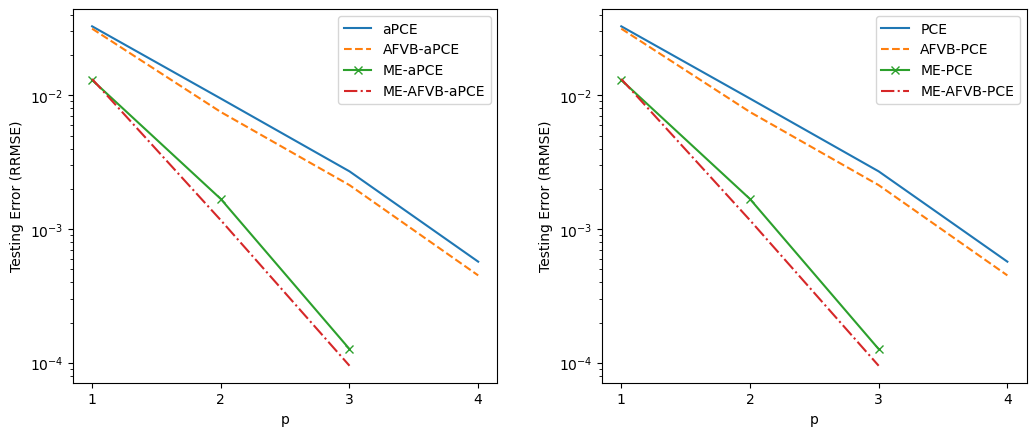

In [1189]:
p = list(range(1,5))
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

#ax[0].plot(range(1,6), results_Cantilever_full[0], '-', label = 'aPCE-full')

#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_80[0], '-', label = 'aPCE')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_Global_80[1], '--', label = 'AFVB-aPCE')

ax[0].plot(range(1,5), results_Cantilever_AFVB_aPCE_Global[0], '-', label = 'aPCE')
ax[0].plot(range(1,5), results_Cantilever_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')

#ax[0].plot(p, results_Cantilever_AFVB_aPCE_Stieltjes_Global[0], ':', c = 'black', alpha = 0.6, label = 'aPCE-Stieltjes')
#ax[0].plot(p, results_Cantilever_AFVB_aPCE_Stieltjes_Global[1], ':', c = 'black', alpha = 0.6, label = 'AFVB-aPCE-Stieltjes')
ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_ME[0], '-x', label = 'ME-aPCE')
ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_ME[1], '-.', label = 'ME-AFVB-aPCE')

#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_ME_8[0], '-x', label = 'ME-aPCE')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_ME_8[1], '-.', label = 'ME-AFVB-aPCE')

#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_ME_16_150[0], '-x', label = 'ME-aPCE_16')
#ax[0].plot(range(1,4), results_Cantilever_AFVB_aPCE_ME_16_150[1], '-.', label = 'ME-AFVB-aPCE_16')


ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RRMSE)")
ax[0].legend()

ax[1].plot(p, results_Cantilever_AFVB_aPCE_Global[0], '-', label = 'PCE')
ax[1].plot(p, results_Cantilever_AFVB_aPCE_Global[1], '--', label = 'AFVB-PCE')
ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_ME[0], '-x', label = 'ME-PCE')
ax[1].plot(range(1,4), results_Cantilever_AFVB_aPCE_ME[1], '-.', label = 'ME-AFVB-PCE')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RRMSE)")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Cantilever_AFVB_Error.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


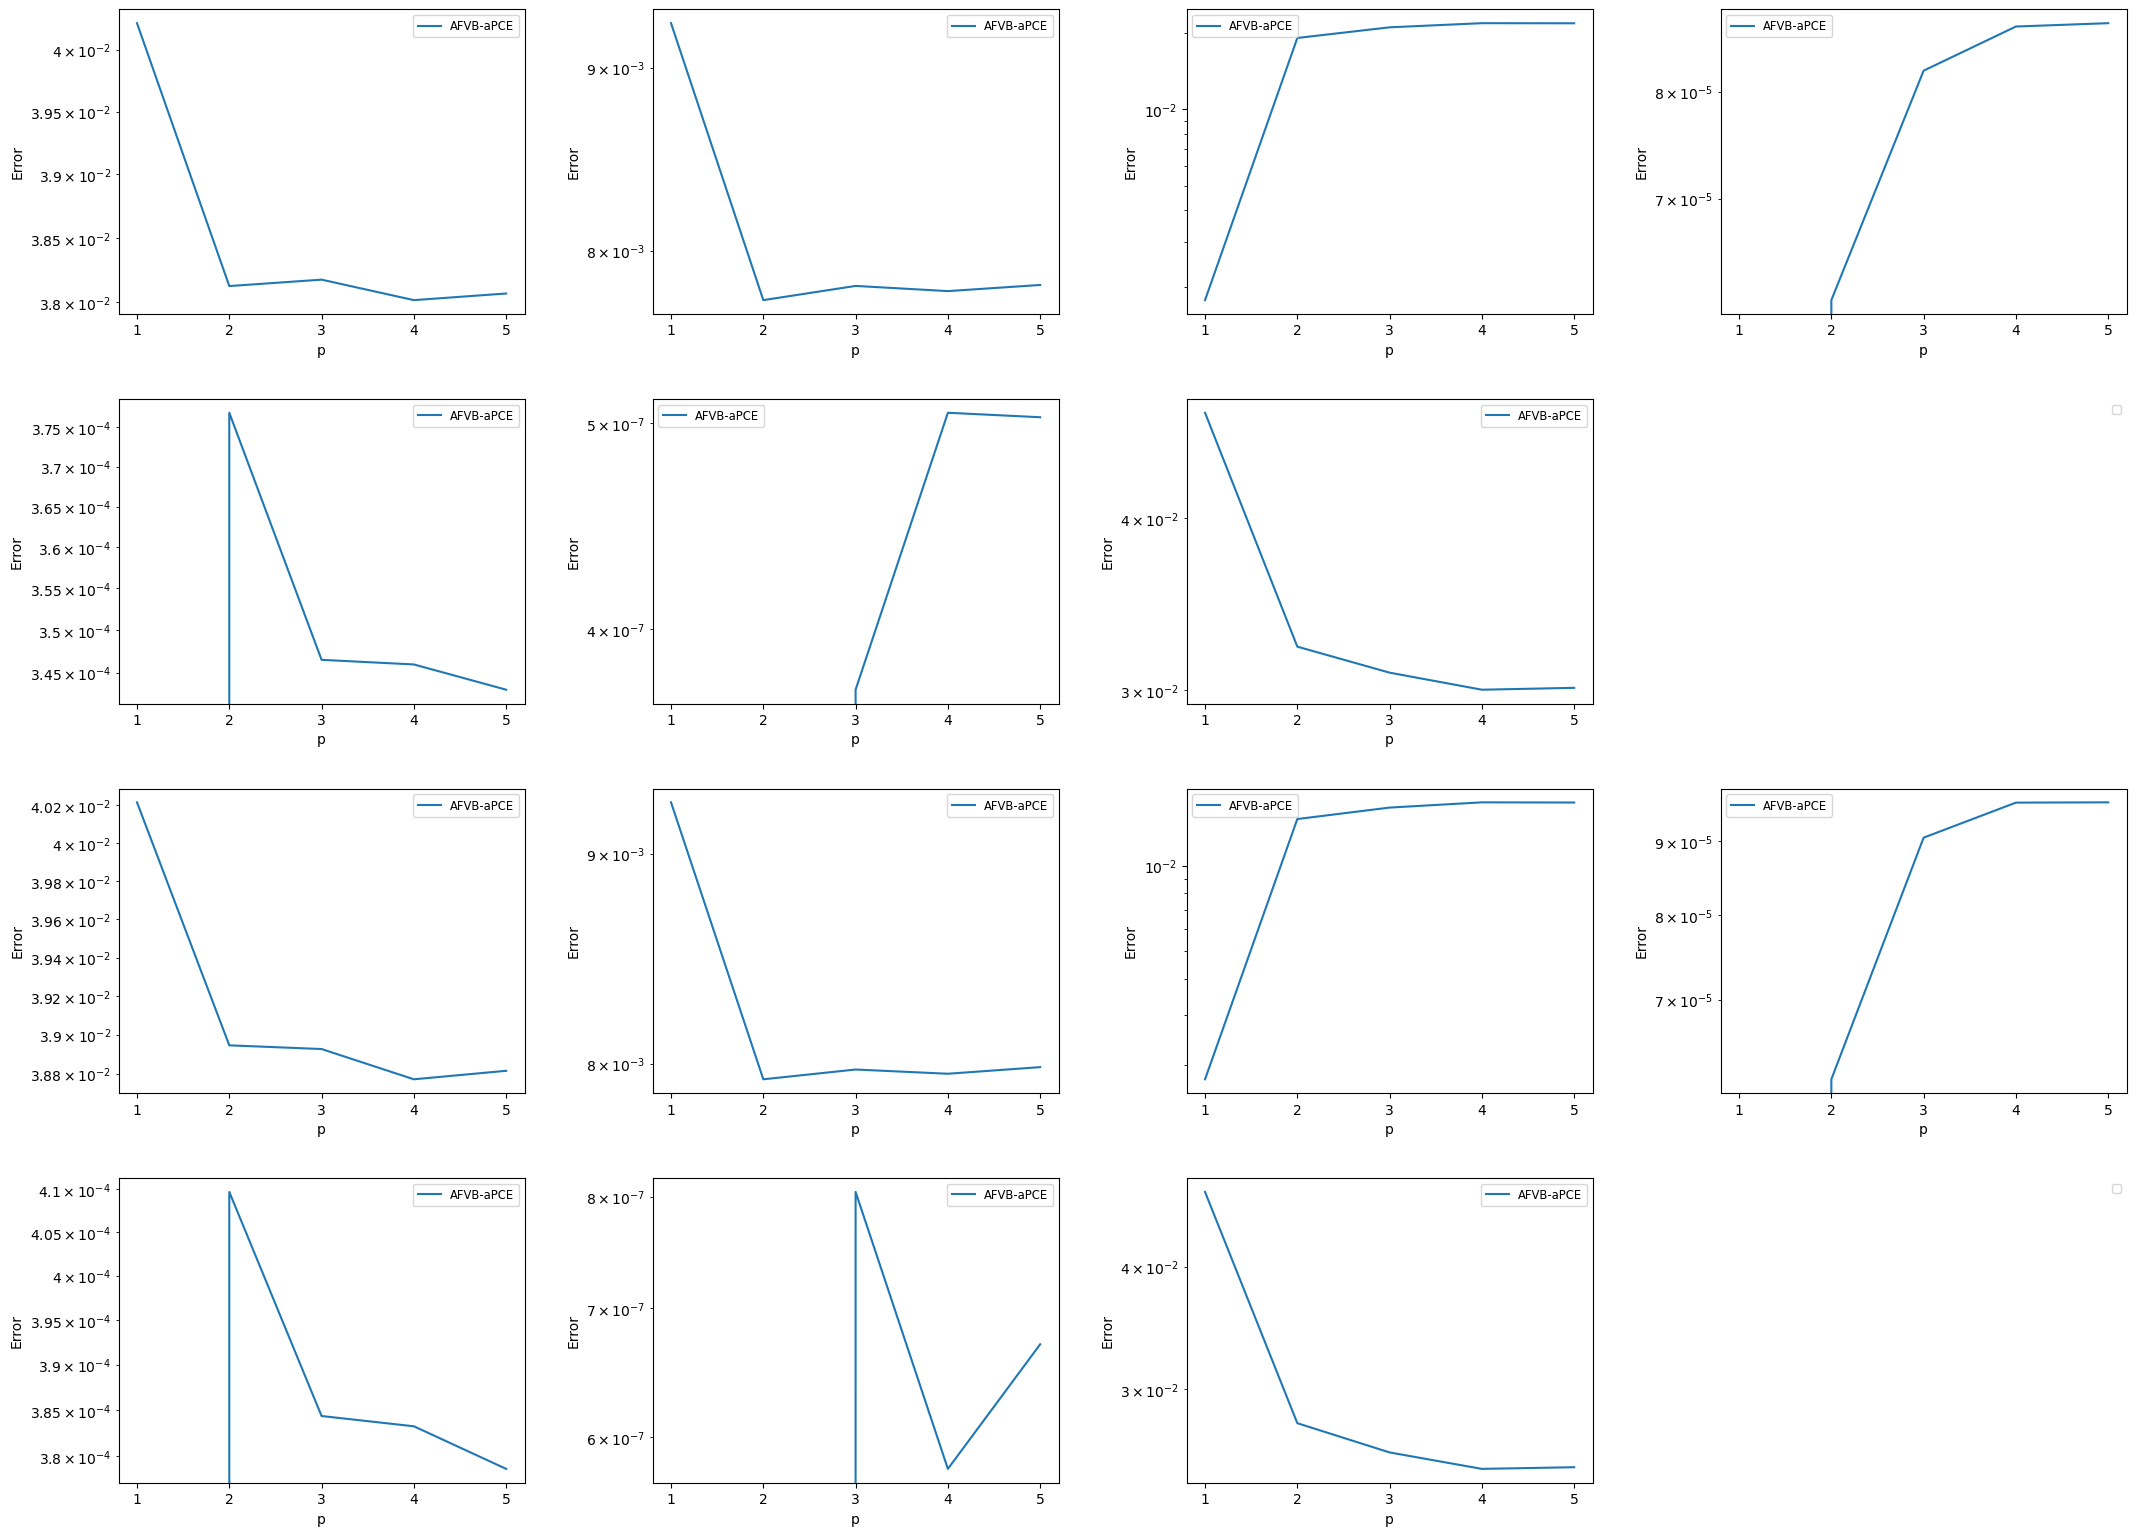

In [169]:
p = list(range(1,6))

plt.rcParams['figure.figsize'] = (22,16) # (width, height)
fig, ax = plt.subplots(4, 4)
markers = ['-x','-o','-v']

for i in range(4):
    ax[0,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_aPCE_Global[2])[:,i] - GSA_Cantilever_1st_Order[i]) , '-', label = 'AFVB-aPCE')  
    #ax[0,i].plot(range(1,3), np.abs(np.array(results_Cantilever_AFVB_aPCE_ME_64[2])[:,i] - GSA_Cantilever_1st_Order[i]), '-.', label = 'ME-AFVB-aPCE') 
    #ax[0,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_Global[2])[:,i] - GSA_Cantilever_1st_Order[i]) , '-x', label = 'AFVB-PCE')  
    #ax[0,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_ME[2])[:,i] - GSA_Cantilever_1st_Order[i]), '-.x', label = 'ME-AFVB-PCE') 
    #ax[0,i].plot(p, [np.abs(GSA_Cantilever_MC['1st Order'][i]- GSA_Cantilever_1st_Order[i])]*p[-1] , '--', c = 'black', label = 'MC')


    ax[2,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_aPCE_Global[3])[:,i] - GSA_Cantilever_Total_Order[i]) , '-', label = 'AFVB-aPCE')  
    #ax[2,i].plot(range(1,3), np.abs(np.array(results_Cantilever_AFVB_aPCE_ME_64[3])[:,i] - GSA_Cantilever_Total_Order[i]) , '-.', label = 'ME-AFVB-aPCE') 
    #ax[2,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_Global[3])[:,i]  - GSA_Cantilever_Total_Order[i]) , '-x', label = 'AFVB-PCE')  
    #ax[2,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_ME[3])[:,i]  - GSA_Cantilever_Total_Order[i]) , '-.x', label = 'ME-AFVB-PCE') 
    #ax[2,i].plot(range(1,3), [np.abs(GSA_Cantilever_MC['Total Order'][i] - GSA_Cantilever_Total_Order[i])]*p[-1] , '--', c = 'black', label = 'MC')

for i in range(3):
    ax[1,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_aPCE_Global[2])[:,i+4]- GSA_Cantilever_1st_Order[i+4]) , '-', label = 'AFVB-aPCE')  
    #ax[1,i].plot(range(1,3), np.abs(np.array(results_Cantilever_AFVB_aPCE_ME_64[2])[:,i+4]- GSA_Cantilever_1st_Order[i+4]) , '-.', label = 'ME-AFVB-aPCE') 
    #ax[1,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_Global[2])[:,i+4]- GSA_Cantilever_1st_Order[i+4]) , '-x', label = 'AFVB-PCE')  
    #ax[1,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_ME[2])[:,i+4]- GSA_Cantilever_1st_Order[i+4]) , '-.x', label = 'ME-AFVB-PCE') 
    #ax[1,i].plot(p, [np.abs(GSA_Cantilever_MC['1st Order'][i+4]- GSA_Cantilever_1st_Order[i+4])]*p[-1] , '--', c = 'black', label = 'MC')

    ax[3,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_aPCE_Global[3])[:,i+4] - GSA_Cantilever_Total_Order[i+4]) , '-', label = 'AFVB-aPCE')  
    #ax[3,i].plot(range(1,3), np.abs(np.array(results_Cantilever_AFVB_aPCE_ME_64[3])[:,i+4] - GSA_Cantilever_Total_Order[i+4]) , '-.', label = 'ME-AFVB-aPCE') 
    #ax[3,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_Global[3])[:,i+4] - GSA_Cantilever_Total_Order[i+4]) , '-x', label = 'AFVB-PCE')  
    #ax[3,i].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_ME[3])[:,i+4] - GSA_Cantilever_Total_Order[i+4]) , '-.x', label = 'ME-AFVB-PCE') 
    #ax[3,i].plot(p, [np.abs(GSA_Cantilever_MC['Total Order'][i+4]- GSA_Cantilever_Total_Order[i+4])]*p[-1] , '--', c = 'black', label = 'MC')
    
for i in range(4):
    for j in range(4):
        ax[j,i].set_xticks(p)
        ax[j,i].set_yscale("log")
        ax[j,i].set_xlabel("p")
        ax[j,i].set_ylabel("Error")
        ax[j,i].legend(fontsize = 'small')

ax[1,3].set_axis_off()
ax[3,3].set_axis_off()


fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Cantilever_AFVB_GSA.png')

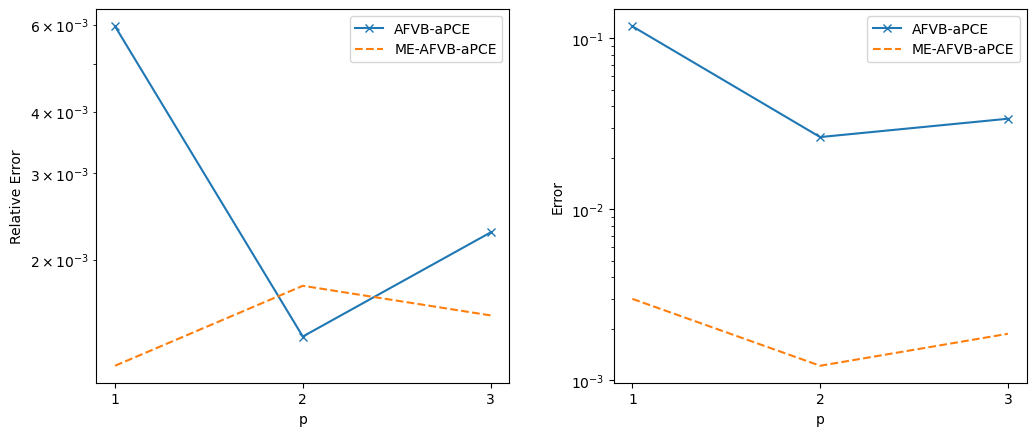

In [1020]:
p = list(range(1,4))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.abs(np.array(results_Cantilever_AFVB_aPCE_Global_80[4])-mean_Cantilever)/mean_Cantilever, '-x', label = 'AFVB-aPCE')
ax[0].plot(range(1,4), np.abs(np.array(results_Cantilever_AFVB_aPCE_ME[4])-mean_Cantilever)/mean_Cantilever, '--', label = 'ME-AFVB-aPCE')

#ax[0].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_Global[4])-mean_Cantilever)/mean_Cantilever, '-', label = 'AFVB-PCE')
#ax[0].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_ME[4])-mean_Cantilever), '-.', label = 'ME-AFVB-PCE')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Relative Error")
ax[0].legend()

ax[1].plot(p, np.abs(np.array(results_Cantilever_AFVB_aPCE_Global_80[5])-V_Cantilever)/V_Cantilever, '-x', label = 'AFVB-aPCE')
ax[1].plot(range(1,4), np.abs(np.array(results_Cantilever_AFVB_aPCE_ME[5])-V_Cantilever), '--', label = 'ME-AFVB-aPCE')

#ax[1].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_Global[5])-V_Cantilever)/V_Cantilever, '-', label = 'AFVB-PCE')
#ax[1].plot(range(1,11), np.abs(np.array(results_Cantilever_AFVB_PCE_ME[5])-V_Cantilever), '-.', label = 'ME-AFVB-PCE')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Error")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Cantilever_AFVB_mean_and_Variance.png')

# VRVM 

## Global Models

In [28]:
p = 2
mod = aPCE(X_pol, p)
P = mod.Create_Orthonormal_Polynomials(p)

In [32]:
t0 = time.time()

params = [{'A_0': [1e-1, 1e-2],
           'B_0': [1e-1, 1e-2],
           'C_0': [1e-1, 1e-2],
           'D_0': [1e-1, 1e-2]}]

gs_knn = GridSearchCV(estimator = AFVB_PCE('aPCE', d = d, p = p, domain = None, aPCE_model = mod, P = P),
                      param_grid = params,
                      n_jobs = 5,
                      scoring='neg_mean_squared_error',
                      cv = 5)
gs_knn.fit(X_train, Y_train)

print(time.time() - t0)

gs_knn.best_params_


26.701654195785522


{'A_0': 0.1, 'B_0': 0.001, 'C_0': 0.1, 'D_0': 0.01}

In [29]:
t0 = time.time()

params = [{'omega_a': [1e-1, 1e-2, 1e-3],
           'omega_b': [1e-1, 1e-2, 1e-3],
           'tau_a': [1e-1, 1e-2, 1e-3],
           'tau_b': [1e-1, 1e-2, 1e-3]}]

gs_knn = GridSearchCV(estimator = VRVM_PCE('aPCE', d = d, p = p, domain = None, aPCE_model = mod, P = P),
                      param_grid = params,
                      n_jobs = 5,
                      scoring='neg_mean_squared_error',
                      cv = 5)
gs_knn.fit(X_train, Y_train)

print(time.time() - t0)

gs_knn.best_params_

17.95031499862671


{'omega_a': 0.1, 'omega_b': 0.1, 'tau_a': 0.1, 'tau_b': 0.1}

In [31]:
gs_knn.cv_results_

{'mean_fit_time': array([0.24740715, 0.2142592 , 0.21261497, 0.20839891, 0.21055679,
        0.20864921, 0.20732126, 0.20875025, 0.20993199, 0.2083755 ,
        0.20718613, 0.20883255, 0.20989947, 0.20684619, 0.20854764,
        0.20963387, 0.20822792, 0.20809879, 0.20779042, 0.20835381,
        0.21004605, 0.20753551, 0.20877123, 0.20847316, 0.21024203,
        0.20836048, 0.20820851, 0.20916858, 0.20788798, 0.20942006,
        0.20818954, 0.20854549, 0.20864387, 0.20999241, 0.21220722,
        0.21269622, 0.21175156, 0.21209831, 0.21327581, 0.21113424,
        0.21071806, 0.21009321, 0.20880094, 0.21014638, 0.20873384,
        0.2091538 , 0.21291699, 0.2122262 , 0.21194201, 0.21179895,
        0.21083241, 0.21078591, 0.20874686, 0.21057072, 0.20693378,
        0.21022539, 0.20768476, 0.21015224, 0.21021352, 0.20798783,
        0.2107832 , 0.21241479, 0.21191459, 0.2116396 , 0.2106513 ,
        0.21027727, 0.21212678, 0.20952353, 0.21106086, 0.21049018,
        0.20736127, 0.20887856,

In [28]:
?GridSearchCV

### aPCE

In [426]:
best_params_VRVM_Global_aPCE = [OrderedDict([('omega_a', 1e-2), ('omega_b', 1e-2), ('tau_a', 1e-2), ('tau_b', 1e-2)])]*2\
+ [OrderedDict([('omega_a', 1e-7), ('omega_b', 1e-7), ('tau_a', 1e-7), ('tau_b', 1e-7)])] \
+ [OrderedDict([('omega_a', 1e-8), ('omega_b', 1e-8), ('tau_a', 1e-8), ('tau_b', 1e-8)])]


In [427]:
p = list(range(1,5))
results_Cantilever_VRVM_aPCE_Global = collect_results_PCE(p, d, tf.cantilever, best_params_VRVM_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, Y_test, 'aPCE', VRVM_PCE, None)

0.014478206634521484
p = 1 n* =  6
0.10648679733276367
p = 2 n* =  10
11.684062004089355
p = 3 n* =  27
34.361483097076416
p = 4 n* =  28


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


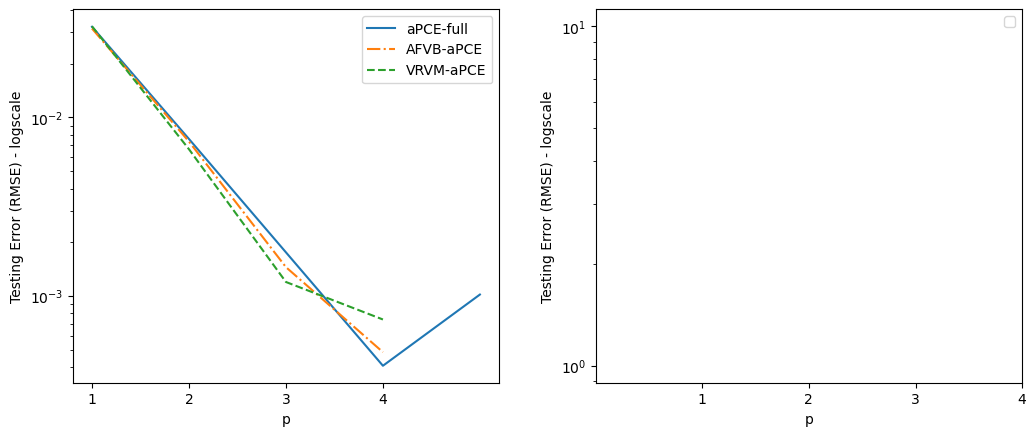

In [428]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(range(1,6), results_Cantilever_full[0], '-', label = 'aPCE-full')
ax[0].plot(p, results_Cantilever_AFVB_aPCE_Global[1], '-.', label = 'AFVB-aPCE')
#ax[0].plot(p, results_Cantilever_VRVM_aPCE_ME[0], '-x', label = 'ME-aPCE Full')
ax[0].plot(p, results_Cantilever_VRVM_aPCE_Global[1], '--', label = 'VRVM-aPCE')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RMSE) - logscale")
ax[0].legend()

#ax[1].plot(range(1,5), results_Cantilever_VRVM_PCE_Global[0], ':', label = 'Global-PCE Full')
#ax[1].plot(range(1,5), results_Cantilever_VRVM_PCE_Global[1], ':', label = 'Global-PCE Sparse')
#ax[1].plot(p, results_Cantilever_VRVM_PCE_ME[0], '-x', label = 'ME-PCE Full')
#ax[1].plot(p, results_Cantilever_VRVM_PCE_ME[1], '-.', label = 'ME-PCE Sparse')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RMSE) - logscale")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Cantilever_VRVM_Error.png')

### PCE

In [48]:
best_params_VRVM_Global_PCE = [OrderedDict([('omega_a', 1.5331650696884767e-05), ('omega_b', 9.227577445542909e-05), ('tau_a', 7.100854733675451e-05), ('tau_b', 6.602475146521386e-05)]), OrderedDict([('omega_a', 8.685745485376447e-06), ('omega_b', 9.749357994193433e-05), ('tau_a', 2.593261153111384e-05), ('tau_b', 7.279774432414233e-05)]), OrderedDict([('omega_a', 3.354304528850806e-05), ('omega_b', 1.7314618536025147e-05), ('tau_a', 5.466085468115754e-05), ('tau_b', 4.792281164681451e-05)]), OrderedDict([('omega_a', 8.188602063993157e-06), ('omega_b', 4.035819086901198e-05), ('tau_a', 6.574031205543258e-05), ('tau_b', 3.141887291296671e-06)]), OrderedDict([('omega_a', 1.4088972141302867e-05), ('omega_b', 4.1724395886751565e-05), ('tau_a', 5.3722579738355214e-05), ('tau_b', 2.01034642853206e-05)]), OrderedDict([('omega_a', 3.7657165865598554e-05), ('omega_b', 6.418320114595561e-05), ('tau_a', 9.624547491241109e-06), ('tau_b', 5.7414436959582974e-05)]), OrderedDict([('omega_a', 2.626482172666417e-05), ('omega_b', 7.760889730630263e-05), ('tau_a', 9.567938639240661e-05), ('tau_b', 3.407375072731916e-05)]), OrderedDict([('omega_a', 8.089587503775322e-05), ('omega_b', 2.1697620451632497e-05), ('tau_a', 4.750638754187007e-05), ('tau_b', 6.440128199410328e-05)]), OrderedDict([('omega_a', 7.382154543197795e-05), ('omega_b', 4.114919670341607e-05), ('tau_a', 1.6628916456461474e-05), ('tau_b', 7.686909746443789e-05)]), OrderedDict([('omega_a', 9.427894581298408e-05), ('omega_b', 9.572982420711138e-05), ('tau_a', 7.685276017538369e-05), ('tau_b', 4.814149211831182e-05)]), OrderedDict([('omega_a', 8.599473524106895e-05), ('omega_b', 5.292124597145868e-05), ('tau_a', 2.6715456076691473e-05), ('tau_b', 1.3788971891034581e-05)]), OrderedDict([('omega_a', 4.4508966683109065e-07), ('omega_b', 2.6887561301817605e-05), ('tau_a', 8.965705165694681e-05), ('tau_b', 5.7262752721173696e-05)]), OrderedDict([('omega_a', 4.686752149492646e-05), ('omega_b', 3.625034611105466e-05), ('tau_a', 8.044083067461392e-05), ('tau_b', 2.201350776375482e-05)]), OrderedDict([('omega_a', 9.940200151181392e-05), ('omega_b', 8.326823410958093e-05), ('tau_a', 6.280661539079046e-05), ('tau_b', 3.450666677254366e-05)])]


In [618]:
results_Cantilever_VRVM_PCE_Global = collect_results_PCE(p, d, tf.cantilever, best_params_VRVM_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'PCE_Hermite', VRVM_PCE, 
                                                B_init = None, sigma_vals = sigma_vals, mu_vals = mu_vals)


0.07634091377258301
p = 1 n* =  7
0.369870662689209
p = 2 n* =  11
3.042686939239502
p = 3 n* =  33
15.022868871688843
p = 4 n* =  32


## Local Models

### aPCE

In [383]:
B_init = []
for i in range(d):
    B_init.append([np.min([X_train[:,i].min(), X_test[:,i].min(), X_pol[:,i].min()]), np.max([X_train[:,i].max(), X_test[:,i].max(), X_pol[:,i].max()])])


In [11]:
# Optimized Hyper-Parameters: slurm-8832064
best_params_VRVM_ME_aPCE = [OrderedDict([('alpha', 0.5632993961653334), ('arg1', 2.4710286258524645e-05), ('arg2', 8.287538093870098e-05), ('arg3', 7.167616444254344e-05), ('arg4', 1.656790852681137e-05), ('theta1', 0.7725763934762547), ('theta2', 0.1778266388284838)]), OrderedDict([('alpha', 0.035936313473569695), ('arg1', 1e-08), ('arg2', 2.655146354315031e-05), ('arg3', 1e-08), ('arg4', 0.0001), ('theta1', 0.8459693119306863), ('theta2', 0.04928222881285478)]), OrderedDict([('alpha', 1e-06), ('arg1', 6.842778231943695e-06), ('arg2', 7.781776387101613e-05), ('arg3', 2.022494965579457e-05), ('arg4', 6.911547620607852e-05), ('theta1', 0.8908168405773248), ('theta2', 1e-06)]), OrderedDict([('alpha', 0.1565896386478665), ('arg1', 3.6691669112488755e-05), ('arg2', 3.666862211983487e-05), ('arg3', 5.722070880687537e-05), ('arg4', 6.831456628904052e-05), ('theta1', 0.42683953588204293), ('theta2', 0.08783128546219385)]), OrderedDict([('alpha', 0.5984529977308706), ('arg1', 3.6297762726049333e-05), ('arg2', 1.8814666390312428e-05), ('arg3', 7.202381543212009e-05), ('arg4', 2.303265940477397e-05), ('theta1', 0.9721868447583709), ('theta2', 0.7238330823343102)]), OrderedDict([('alpha', 0.17802959776874175), ('arg1', 5.855314779894947e-05), ('arg2', 2.496342435264212e-05), ('arg3', 4.89810809593937e-05), ('arg4', 8.666174664280051e-05), ('theta1', 0.5217987441992685), ('theta2', 0.7547399615484185)]), OrderedDict([('alpha', 0.5918806969293593), ('arg1', 1e-08), ('arg2', 3.3242655831437976e-05), ('arg3', 2.060187672010659e-05), ('arg4', 1e-08), ('theta1', 0.40442717574986653), ('theta2', 0.99)]), OrderedDict([('alpha', 0.25310562992270563), ('arg1', 3.915041494086702e-06), ('arg2', 4.317704582651805e-06), ('arg3', 8.324783135039999e-05), ('arg4', 3.532265925491864e-05), ('theta1', 0.19715023375961194), ('theta2', 0.5468975944050383)]), OrderedDict([('alpha', 1e-06), ('arg1', 1e-08), ('arg2', 1e-08), ('arg3', 0.0001), ('arg4', 1e-08), ('theta1', 0.99), ('theta2', 0.99)]), OrderedDict([('alpha', 0.6482056324001543), ('arg1', 1e-08), ('arg2', 8.274670219152423e-05), ('arg3', 4.919889671614638e-05), ('arg4', 0.0001), ('theta1', 0.4867735801550905), ('theta2', 0.49294063313494696)])]


In [ ]:
results_Cantilever_VRVM_aPCE_ME = collect_results_ME(p, d, tf.cantilver, best_params_VRVM_ME_aPCE, 
                                                  X_train, X_pol, X_test, Y_train, 'aPCE', 
                                                  VRVM_PCE, B_init)

### PCE

In [ ]:
# Optimized Hyper-Parameters: slurm-8832062
#best_params_VRVM_ME_PCE = [OrderedDict([('alpha', 0.5632993961653334), ('arg1', 2.4710286258524645e-05), ('arg2', 8.287538093870098e-05), ('arg3', 7.167616444254344e-05), ('arg4', 1.656790852681137e-05), ('theta1', 0.7725763934762547), ('theta2', 0.1778266388284838)]), OrderedDict([('alpha', 0.5289437986914474), ('arg1', 1e-08), ('arg2', 0.0001), ('arg3', 1e-08), ('arg4', 0.0001), ('theta1', 0.99), ('theta2', 0.6854114075800615)]), OrderedDict([('alpha', 0.99), ('arg1', 1e-08), ('arg2', 1.4867705384443327e-05), ('arg3', 1e-08), ('arg4', 0.0001), ('theta1', 0.4309897861424597), ('theta2', 1e-06)]), OrderedDict([('alpha', 0.13149842388851093), ('arg1', 2.858617221177075e-05), ('arg2', 1.9819140489252086e-05), ('arg3', 9.769346103224226e-05), ('arg4', 8.963112432413811e-05), ('theta1', 0.41901501810660696), ('theta2', 0.43084482438144067)]), OrderedDict([('alpha', 1e-06), ('arg1', 7.289738264009899e-05), ('arg2', 0.0001), ('arg3', 0.0001), ('arg4', 1e-08), ('theta1', 0.8579155099950342), ('theta2', 0.839801088286929)]), OrderedDict([('alpha', 1e-06), ('arg1', 1e-08), ('arg2', 2.6629814791561958e-05), ('arg3', 3.950895687160405e-05), ('arg4', 0.0001), ('theta1', 0.9659821744393433), ('theta2', 0.99)]), OrderedDict([('alpha', 0.23536533983669095), ('arg1', 1e-08), ('arg2', 4.3401574409528914e-05), ('arg3', 5.732709462579834e-07), ('arg4', 2.0164777873082108e-05), ('theta1', 0.583055632347364), ('theta2', 0.7640704380072287)]), OrderedDict([('alpha', 1e-06), ('arg1', 8.705489426977751e-07), ('arg2', 1.6797466983276716e-05), ('arg3', 1e-08), ('arg4', 5.5616270847537436e-05), ('theta1', 0.5569867953480909), ('theta2', 0.4303116952740246)]), OrderedDict([('alpha', 0.8155245997271127), ('arg1', 5.282755343067723e-05), ('arg2', 4.5899236653516115e-06), ('arg3', 1.4351811332222484e-06), ('arg4', 3.585608446971019e-05), ('theta1', 0.19913907035441367), ('theta2', 0.7850467522022636)]), OrderedDict([('alpha', 0.336504742387436), ('arg1', 9.333871305245319e-05), ('arg2', 8.546855404608885e-05), ('arg3', 5.066332825398189e-05), ('arg4', 7.209845076479927e-05), ('theta1', 0.4720998283860188), ('theta2', 0.8783985766775352)])]


In [ ]:
#results_Cantilever_VRVM_PCE_ME = collect_results_ME(p, d, tf.cantilever, best_params_VRVM_ME_PCE, 
#                                                  X_train, X_pol, X_test, Y_train, 'PCE_Hermite', VRVM_PCE, 
#                                                    B_init, sigma_vals = sigma_vals, mu_vals = mu_vals)

## Plots for VRVM - Cantilever

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


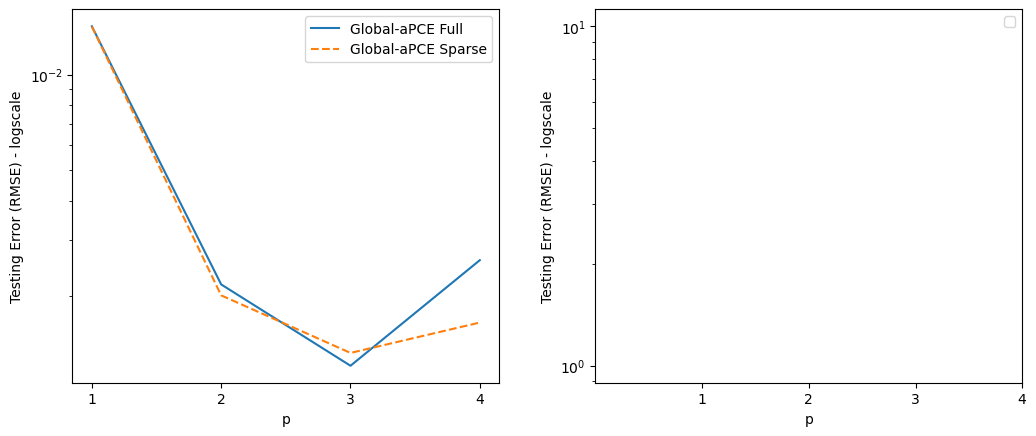

In [286]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, results_Cantilever_VRVM_aPCE_Global[0], '-', label = 'Global-aPCE Full')
ax[0].plot(p, results_Cantilever_VRVM_aPCE_Global[1], '--', label = 'Global-aPCE Sparse')
#ax[0].plot(p, results_Cantilever_VRVM_aPCE_ME[0], '-x', label = 'ME-aPCE Full')
#ax[0].plot(p, results_Cantilever_VRVM_aPCE_ME[1], '-.', label = 'ME-aPCE Sparse')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RMSE) - logscale")
ax[0].legend()

#ax[1].plot(p, results_Cantilever_VRVM_PCE_Global[0], '-', label = 'Global-PCE Full')
#ax[1].plot(p, results_Cantilever_VRVM_PCE_Global[1], '--', label = 'Global-PCE Sparse')
#ax[1].plot(p, results_Cantilever_VRVM_PCE_ME[0], '-x', label = 'ME-PCE Full')
#ax[1].plot(p, results_Cantilever_VRVM_PCE_ME[1], '-.', label = 'ME-PCE Sparse')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RMSE) - logscale")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Cantilever_VRVM_Error.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


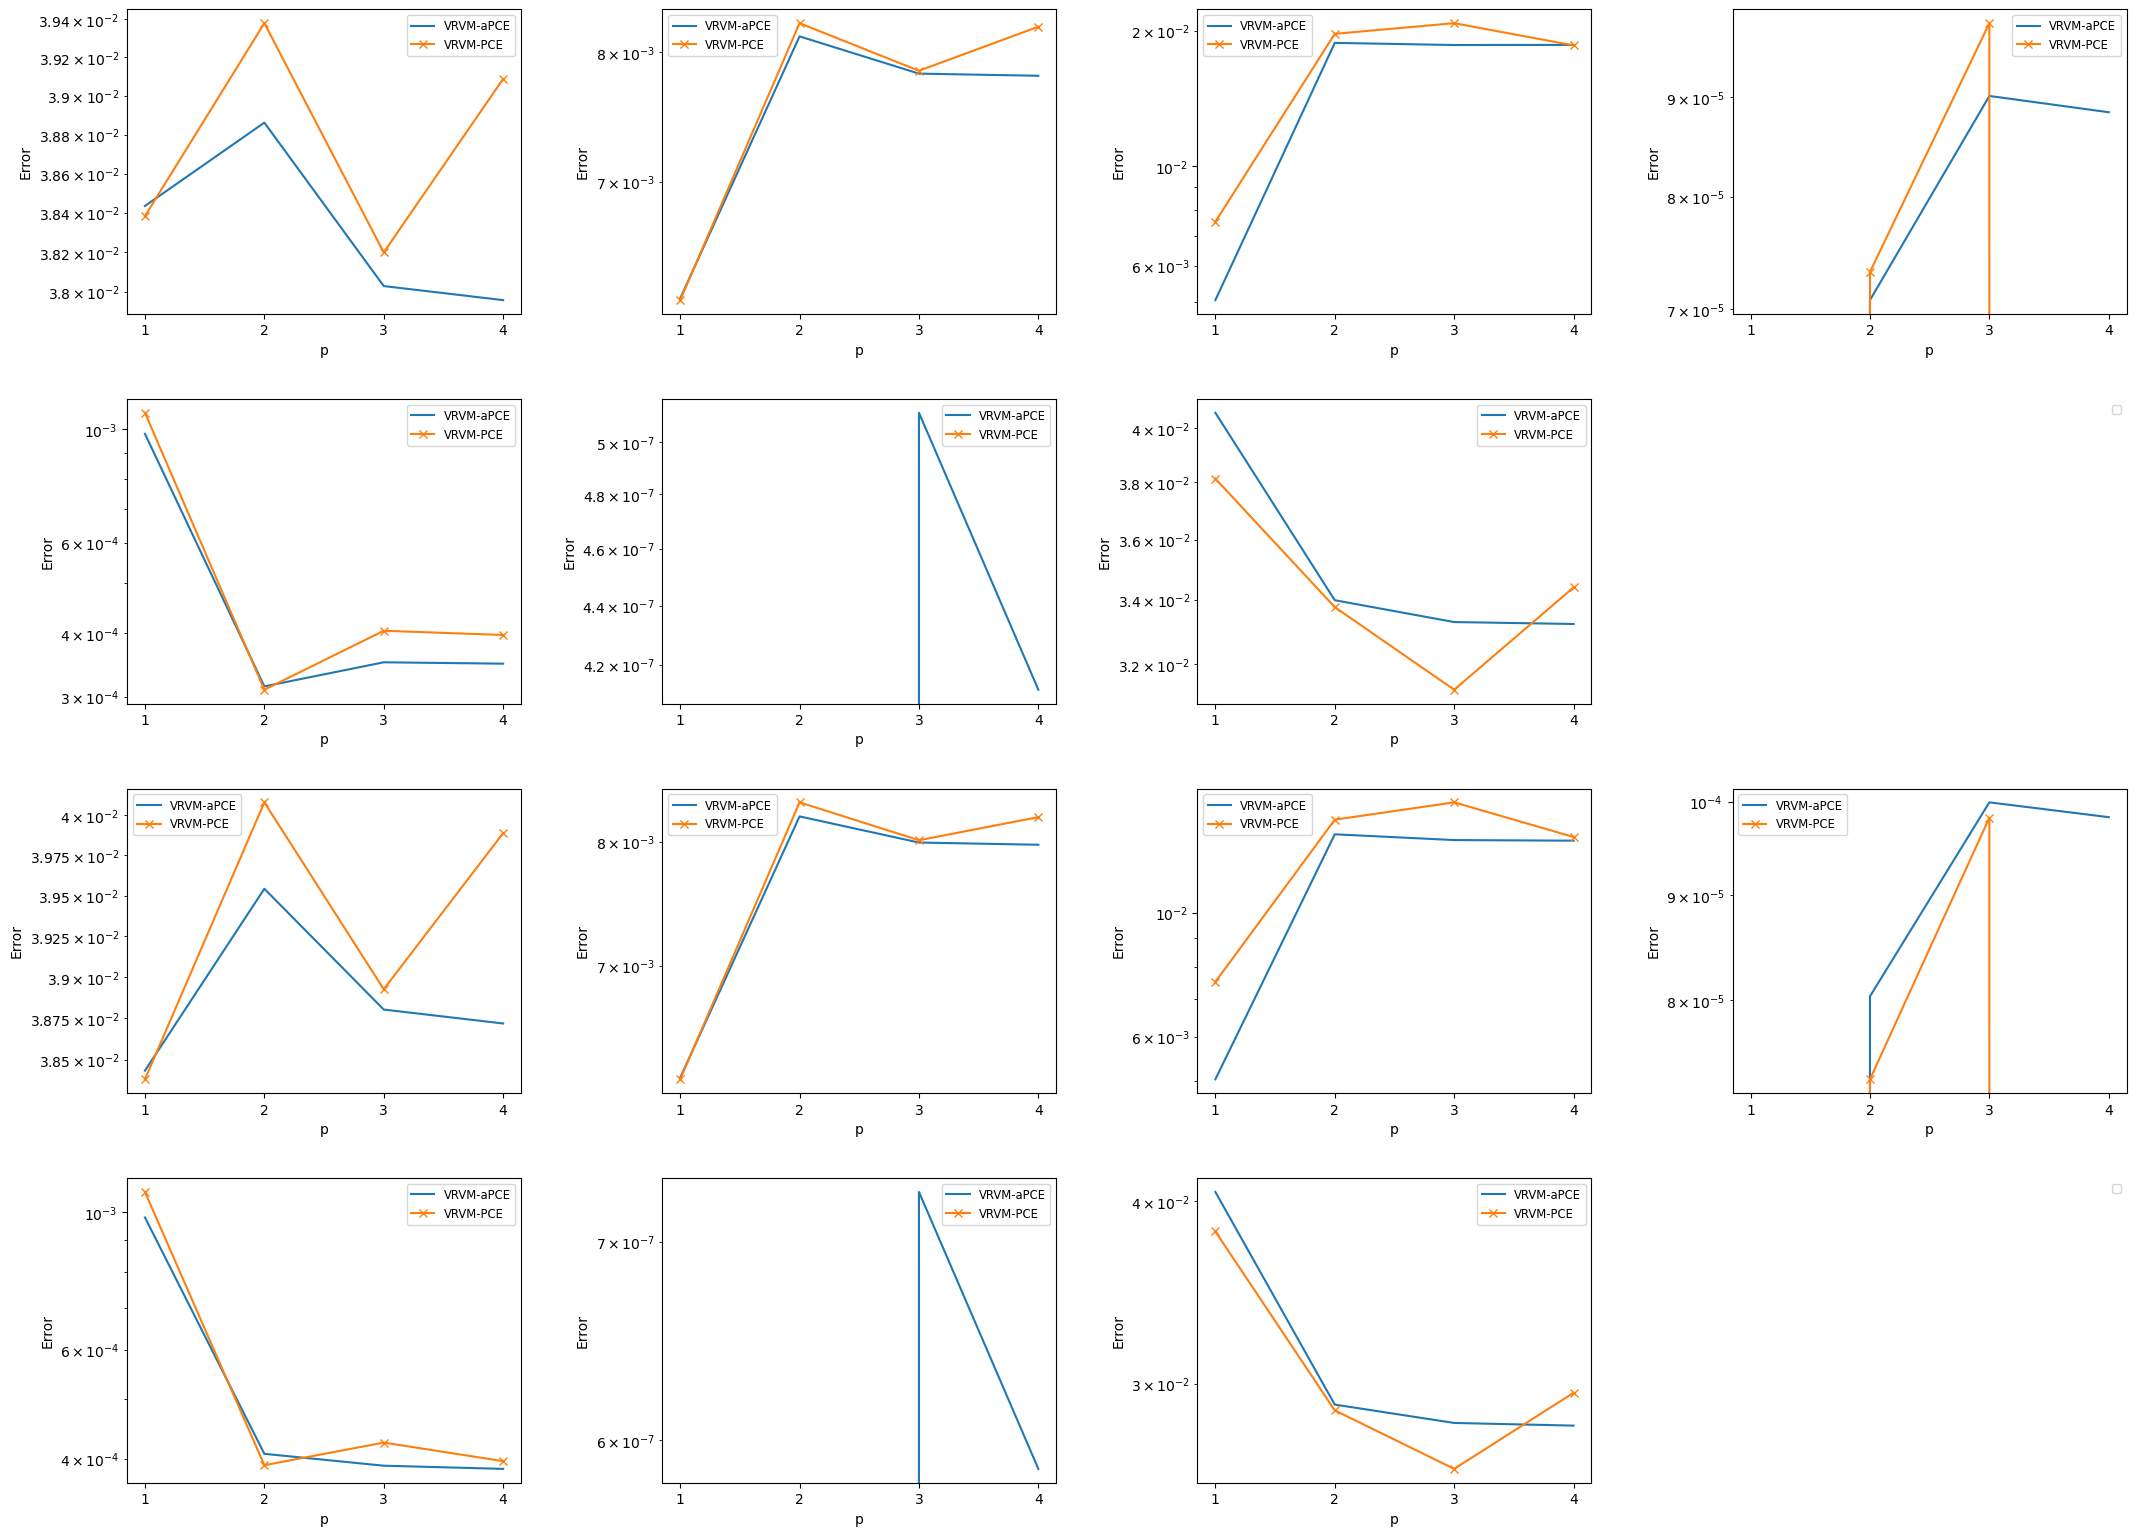

In [321]:
p = list(range(1,5))

plt.rcParams['figure.figsize'] = (22,16) # (width, height)
fig, ax = plt.subplots(4, 4)
markers = ['-x','-o','-v']

for i in range(4):
    ax[0,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_aPCE_Global[2])[:,i] - GSA_Cantilever_1st_Order[i]) , '-', label = 'VRVM-aPCE')  
    #ax[0,i].plot(range(1,3), np.abs(np.array(results_Cantilever_VRVM_aPCE_ME_64[2])[:,i] - GSA_Cantilever_1st_Order[i]), '-.', label = 'ME-VRVM-aPCE') 
    ax[0,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_Global[2])[:,i] - GSA_Cantilever_1st_Order[i]) , '-x', label = 'VRVM-PCE')  
    #ax[0,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_ME[2])[:,i] - GSA_Cantilever_1st_Order[i]), '-.x', label = 'ME-VRVM-PCE') 
    #ax[0,i].plot(p, [np.abs(GSA_Cantilever_MC['1st Order'][i]- GSA_Cantilever_1st_Order[i])]*p[-1] , '--', c = 'black', label = 'MC')


    ax[2,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_aPCE_Global[3])[:,i] - GSA_Cantilever_Total_Order[i]) , '-', label = 'VRVM-aPCE')  
    #ax[2,i].plot(range(1,3), np.abs(np.array(results_Cantilever_VRVM_aPCE_ME_64[3])[:,i] - GSA_Cantilever_Total_Order[i]) , '-.', label = 'ME-VRVM-aPCE') 
    ax[2,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_Global[3])[:,i]  - GSA_Cantilever_Total_Order[i]) , '-x', label = 'VRVM-PCE')  
    #ax[2,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_ME[3])[:,i]  - GSA_Cantilever_Total_Order[i]) , '-.x', label = 'ME-VRVM-PCE') 
    #ax[2,i].plot(range(1,3), [np.abs(GSA_Cantilever_MC['Total Order'][i] - GSA_Cantilever_Total_Order[i])]*p[-1] , '--', c = 'black', label = 'MC')

for i in range(3):
    ax[1,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_aPCE_Global[2])[:,i+4]- GSA_Cantilever_1st_Order[i+4]) , '-', label = 'VRVM-aPCE')  
    #ax[1,i].plot(range(1,3), np.abs(np.array(results_Cantilever_VRVM_aPCE_ME_64[2])[:,i+4]- GSA_Cantilever_1st_Order[i+4]) , '-.', label = 'ME-VRVM-aPCE') 
    ax[1,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_Global[2])[:,i+4]- GSA_Cantilever_1st_Order[i+4]) , '-x', label = 'VRVM-PCE')  
    #ax[1,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_ME[2])[:,i+4]- GSA_Cantilever_1st_Order[i+4]) , '-.x', label = 'ME-VRVM-PCE') 
    #ax[1,i].plot(p, [np.abs(GSA_Cantilever_MC['1st Order'][i+4]- GSA_Cantilever_1st_Order[i+4])]*p[-1] , '--', c = 'black', label = 'MC')

    ax[3,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_aPCE_Global[3])[:,i+4] - GSA_Cantilever_Total_Order[i+4]) , '-', label = 'VRVM-aPCE')  
    #ax[3,i].plot(range(1,3), np.abs(np.array(results_Cantilever_VRVM_aPCE_ME_64[3])[:,i+4] - GSA_Cantilever_Total_Order[i+4]) , '-.', label = 'ME-VRVM-aPCE') 
    ax[3,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_Global[3])[:,i+4] - GSA_Cantilever_Total_Order[i+4]) , '-x', label = 'VRVM-PCE')  
    #ax[3,i].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_ME[3])[:,i+4] - GSA_Cantilever_Total_Order[i+4]) , '-.x', label = 'ME-VRVM-PCE') 
    #ax[3,i].plot(p, [np.abs(GSA_Cantilever_MC['Total Order'][i+4]- GSA_Cantilever_Total_Order[i+4])]*p[-1] , '--', c = 'black', label = 'MC')
    
for i in range(4):
    for j in range(4):
        ax[j,i].set_xticks(p)
        ax[j,i].set_yscale("log")
        ax[j,i].set_xlabel("p")
        ax[j,i].set_ylabel("Error")
        ax[j,i].legend(fontsize = 'small')

ax[1,3].set_axis_off()
ax[3,3].set_axis_off()


fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Cantilever_VRVM_GSA.png')

NameError: name 'results_Cantilever_VRVM_aPCE_Global' is not defined

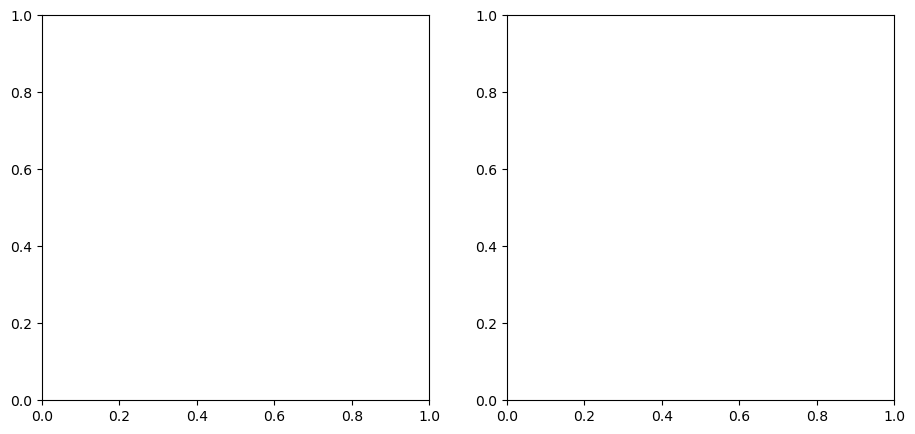

In [597]:
p = list(range(1,4))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.abs(np.array(results_Cantilever_VRVM_aPCE_Global[4])-mean_Cantilever)/mean_Cantilever, '-x', label = 'VRVM-aPCE')
#ax[0].plot(range(1,4), np.abs(np.array(results_Cantilever_VRVM_aPCE_ME[4])-mean_Cantilever)/mean_Cantilever, '--', label = 'ME-VRVM-aPCE')

#ax[0].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_Global[4])-mean_Cantilever)/mean_Cantilever, '-', label = 'VRVM-PCE')
#ax[0].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_ME[4])-mean_Cantilever), '-.', label = 'ME-VRVM-PCE')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Relative Error")
ax[0].legend()

ax[1].plot(p, np.abs(np.array(results_Cantilever_VRVM_aPCE_Global[5])-V_Cantilever)/V_Cantilever, '-x', label = 'VRVM-aPCE')
#ax[1].plot(range(1,4), np.abs(np.array(results_Cantilever_VRVM_aPCE_ME[5])-V_Cantilever), '--', label = 'ME-VRVM-aPCE')

#ax[1].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_Global[5])-V_Cantilever)/V_Cantilever, '-', label = 'VRVM-PCE')
#ax[1].plot(range(1,11), np.abs(np.array(results_Cantilever_VRVM_PCE_ME[5])-V_Cantilever), '-.', label = 'ME-VRVM-PCE')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Error")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Cantilever_VRVM_mean_and_Variance.png')

# Example 3: Wing Weight Model

In [416]:
import openturns as ot
import openturns.viewer as otv
from openturns.usecases.wingweight_function import WingWeightModel

In [417]:
N_train = 320 # Sample size
N_test = 80
N_pol = 1000000
N_mc = 1000000 #10^6 samples

d = 10

In [418]:
m = WingWeightModel()

ot.RandomGenerator.SetSeed(2357)

X_train = np.array(m.distributionX.getSample(N_train))
X_test = np.array(m.distributionX.getSample(N_test))
X_pol = np.array(m.distributionX.getSample(N_pol))

Y_train = np.array(m.model(X_train))
Y_test = np.array(m.model(X_test))

In [415]:
?m.distributionX.getSample

In [419]:
def WingWeight(X):
    return np.array(m.model(X))

def data_wingweight(N, d, B):
    np.random.seed(9)
    X = np.zeros((N, d))
    for i in range(d):
        X[:,i] = np.random.uniform(B[i][0], B[i][1], size = N)
    return X

In [332]:
B0 = [1e-1, 1e-2, 1e-3, 1e-4]
n_star = []
L_max = []

p = [3]

for j in range(len(p)):
    print('')
    print('p = ', p[j])
    mod = aPCE(X_pol, p[j])
    P = mod.Create_Orthonormal_Polynomials(p[j])
    
    n_star_temp =[]
    L_max_temp = []

    for i in range(len(B0)):
        model = AFVB_PCE('aPCE', d = d, p = p[j], domain = None, aPCE_model = mod, P = P, B_0 = B0[i],
                    A_0 = 1e-2, C_0 = 1e-2, D_0 = 1e-2)
        model.fit(X_train, Y_train)
        
        n_star_temp.append(model.n_star)
        L_max_temp.append(model.L_beta[model.max_beta])
        print('i = ', i)
    n_star.append(n_star_temp)
    L_max.append(L_max_temp)


p =  3
i =  0
i =  1
i =  2
i =  3


In [334]:
n_star
# 8, 27, 68

[[62, 65, 68, 65]]

In [335]:
L_max
#-167

[[-319.2203507449766,
  -314.8616973909534,
  -314.3112382347799,
  -314.3561587587951]]

In [336]:
np.argmax(L_max[-1])

2

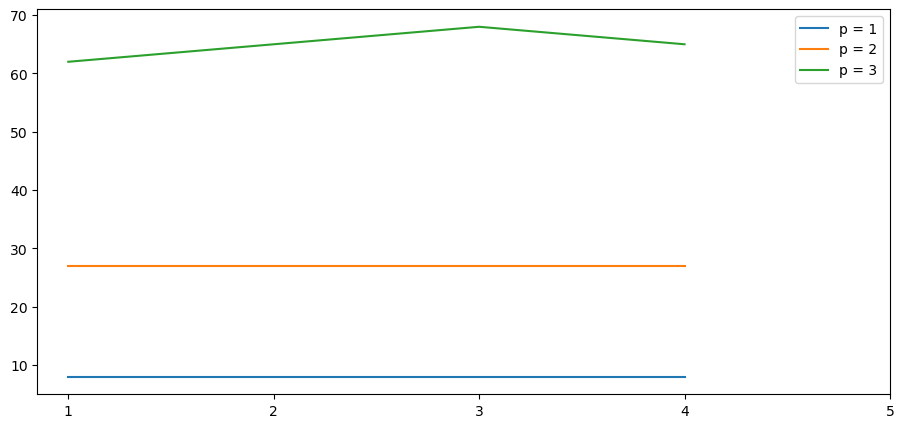

In [280]:
plt.plot([1,2,3,4], n_star[0], label = 'p = 1')
plt.plot([1,2,3,4], n_star[1], label = 'p = 2')
plt.plot([1,2,3,4], n_star[2], label = 'p = 3')

plt.xticks([1,2,3,4,5])
plt.legend();

In [11]:
train_size = np.array(list(range(10,310,10)))

In [33]:
p = [2]

mod = aPCE(X_pol, p[0])
P = mod.Create_Orthonormal_Polynomials(p[0])

model = AFVB_PCE('aPCE', d = d, p = p[0], domain = None, aPCE_model = mod, P = P)


In [38]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator = model,
    X = X_train,
    y = Y_train,
    cv = 5,
    n_jobs = 5, 
    scoring = "neg_root_mean_squared_error",
    train_sizes = train_size
)

train_mean_p2 = -train_scores.mean(axis = 1)
test_mean_p2 = -test_scores.mean(axis = 1)

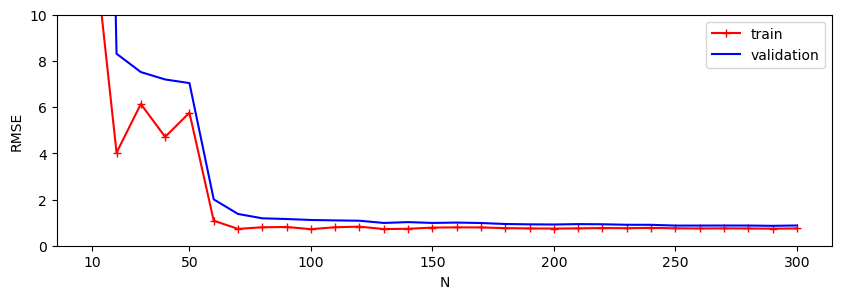

<Figure size 640x480 with 0 Axes>

In [41]:
plt.subplots(figsize=(10,3))
plt.plot(train_sizes, train_mean_p2, "r-+",  label="train")
plt.plot(train_sizes, test_mean_p2, "b-", label="validation")

#plt.title("Learning Curve")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.xticks([10, 50, 100, 150, 200, 250, 300])
plt.ylim([0.0, 10.0])

plt.savefig(wd + '/WingWeight_Learning_Curve_p2.png')

### 'Exact' using values from Website

In [655]:
GSA_WingWeight_1st_Order = [0.124602 , 2.16904e-06, 0.220427, 
                            0.000489921, 9.20234e-05, 0.00183476, 
                            0.140907, 0.411459, 0.0847904, 
                            0.00334596]

GSA_WingWeight_Total_Order = [0.128014, 8.96096e-06, 0.226238, 
                              0.000511032, 0.000101967, 0.00191017, 
                              0.145035, 0.419515, 0.0874167, 
                              0.00337113]

In [656]:
V_WingWeight = 48.0753**2

In [657]:
mean_WingWeight = 268.091

### 'Exact' using p = 6

In [580]:
GSA_WingWeight_1st_Order = [
0.124600,
0.000002,
0.220484,
0.000486,
0.000090,
0.001837,
0.141389,
0.411088,
0.084877,
0.003318
]

In [581]:
GSA_WingWeight_Total_Order = [
0.127971,
0.000006,
0.226189,
0.000506,
0.000095,
0.001883,
0.145405,
0.419029,
0.087457,
0.003338
]

In [582]:
V_WingWeight = 2311.5485068235911967349238693714141845703125

In [583]:
mean_WingWeight = 268.084997024663607589900493621826171875

In [584]:
mean_WingWeight = 268.091
V_WingWeight = 48.0753**2

## MC GSA

In [39]:
dataA = pd.DataFrame(np.array(m.distributionX.getSample(N_mc))).values
dataB = pd.DataFrame(np.array(m.distributionX.getSample(N_mc))).values

GSA_WingWeight_MC, V_WingWeight_MC = sobol_GSA(d, WingWeight).sobol_MC(dataA, dataB)

In [15]:
mean_WingWeight_MC = np.mean(WingWeight(X_mc))
mean=268.091
std_dev=48.0753

In [16]:
48.0753**2

2311.23447009

In [17]:
V_WingWeight_MC

2309.29399915

In [18]:
mean_WingWeight_MC

268.1364517405179

# AFVB

## Global Models

In [128]:
B_init = [[150,200], [220,300], [6,10], [-10,10], [16,45], [0.5,1], [0.08,0.18], [2.5,6], [1700,2500], [0.025,0.08]]


In [572]:
B_init = [[150,200], [220,300], [6,10], [-10,10], [16,45], [0.5,1], [0.08,0.18], [2.5,6], [1700,2500], [0.025,0.08]]


p = [3]

for i in range(len(p)):

    t0 = time.time()

    param_space = {'A_0': skopt.space.Real(1e-8, 1e-1),
                    'B_0': skopt.space.Real(1e-8, 1e-1),
                    'C_0': skopt.space.Real(1e-8, 1e-1),
                    'D_0': skopt.space.Real(1e-8, 1e-1)
                }

    optimizer = BayesSearchCV(estimator = PCE_Full_Model('PCE_Legendre', d = d, p = p[i], domain = B_init),
                                search_spaces = param_space,
                                n_iter = 20,
                                n_jobs = 5,
                                n_points = 1,
                                #scoring = 'neg_mean_squared_error',
                                cv = 5,
                                error_score = -5
    )

    optimizer.fit(X_train[p[i]-1], Y_train[p[i]-1])

    print(time.time() - t0)

    print('p =', p[i], optimizer.best_params_)

34.167486906051636
p = 1 OrderedDict([('A_0', 0.06763366990644329), ('B_0', 0.029778227678053153), ('C_0', 0.08965503510859597), ('D_0', 0.03517918273368635)])
38.256174087524414
p = 2 OrderedDict([('A_0', 0.09825925042882629), ('B_0', 0.06471903217205588), ('C_0', 0.1), ('D_0', 0.0033618889777847776)])


In [1263]:
best_params_full = [OrderedDict([('A_0', 1e-2), ('B_0', 1e-2), ('C_0', 1e-2), ('D_0', 1e-2)]),
                    OrderedDict([('A_0', 1e-2), ('B_0', 1e-2), ('C_0', 1e-2), ('D_0', 1e-2)]),
                    OrderedDict([('A_0', 1e-2), ('B_0', 1e-2), ('C_0', 1e-2), ('D_0', 1e-2)]),
                    OrderedDict([('A_0', 1e-2), ('B_0', 1e-5), ('C_0', 1e-2), ('D_0', 1e-2)])
                   ]


In [1264]:
p = list(range(1,5))
results_WingWeight_full = collect_results_PCE(p, d, WingWeight, best_params_full, 
                                                X_train, None, X_test, Y_train, Y_test, 'PCE_Legendre', PCE_Full_Model, 
                                                       B_init = B_init)


0.06605100631713867
p = 1 n* =  11
0.12177586555480957
p = 2 n* =  66
3.8025991916656494
p = 3 n* =  286
17.914950847625732
p = 4 n* =  1001


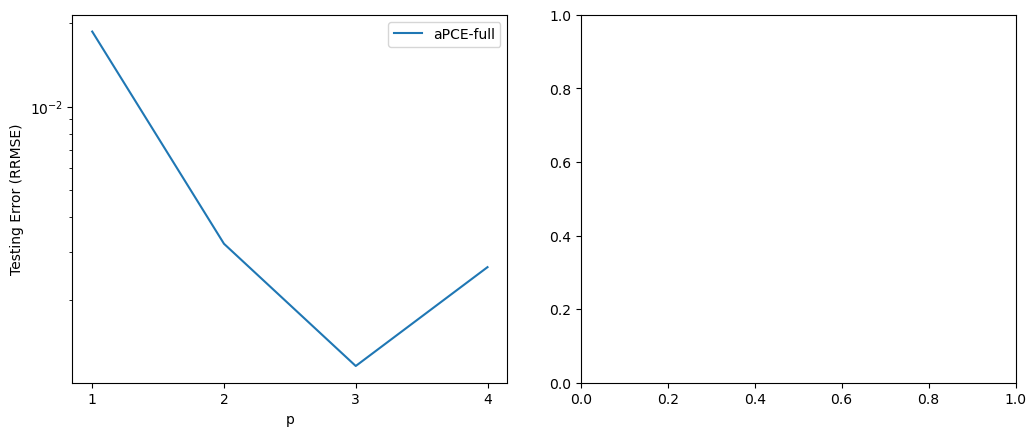

In [1265]:
p = list(range(1,5))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(range(1,5), results_WingWeight_full[0], '-', label = 'aPCE-full')

ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RRMSE)")
ax[0].legend()


fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/WingWeight_AFVB_Error.png')

### aPCE

In [214]:
p = [3]

for i in range(len(p)):
    
    mod = aPCE(X_pol, p[i])
    P = mod.Create_Orthonormal_Polynomials(p[i])
    
    t0 = time.time()

    param_space = {#'A_0': skopt.space.Real(1e-8, 1e-1),
                    'B_0': skopt.space.Real(1e-4, 1e-1),
                    #'C_0': skopt.space.Real(1e-8, 1e-1),
                    #'D_0': skopt.space.Real(1e-8, 1e-1)
                }

    optimizer = BayesSearchCV(estimator = AFVB_PCE('aPCE', d = d, p = p[i], domain = None, aPCE_model = mod, P = P,
                                                  A_0 = 1e-2, C_0 = 1e-2, D_0 = 1e-2),
                                search_spaces = param_space,
                                n_iter = 20,
                                n_jobs = 5,
                                n_points = 1,
                                #scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print(time.time() - t0)

    print('p =', p[i], optimizer.best_params_)

/Users/chave/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/chave/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/chave/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/chave/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


165.8499050140381
p = 3 OrderedDict([('B_0', 0.0001)])


In [1364]:
# N = [140, 140, 160, 240]
# 50 iterations to optimize
# Optimizing RMSE
best_params_AFVB_Global_aPCE = [OrderedDict([('A_0', 1e-1), ('B_0', 1e-1), ('C_0', 1e-1), ('D_0', 1e-1)]),
                                OrderedDict([('A_0', 1e-1), ('B_0', 1e-1), ('C_0', 1e-1), ('D_0', 1e-1)]),
                                OrderedDict([('A_0', 1e-1), ('B_0', 1e-1), ('C_0', 1e-1), ('D_0', 1e-1)]),
                                OrderedDict([('A_0', 1e-1), ('B_0', 1e-5), ('C_0', 1e-1), ('D_0', 1e-1)])
                               ]
#8, 27, 65, 80

In [1365]:
#177
p = list(range(1,4))
results_WingWeight_AFVB_aPCE_Global3 = collect_results_PCE(p, d, WingWeight, best_params_AFVB_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, Y_test, 'aPCE', AFVB_PCE, None)


0.04841804504394531
p = 1 n* =  7
0.9633510112762451
p = 2 n* =  26
4.068559169769287
p = 3 n* =  40


# Sparsity
* $N=100$: $n^* = 7, 25, 54$
* $N=120$: $n^* = 7, 26, 77$
* $N=140$: $n^* = 8, 26, 58$
* $N=160$: $n^* = 8, 27, 73$
* $N=180$: $n^* = 8, 29, 70$
* $N=200$: $n^* = 8, 30, 65$
* $N=220$: $n^* = 8, 31, 75$
* $N=240$: $n^* = 8, 32, 78$
* $N=260$: $n^* = 8, 33, 83$
* $N=280$: $n^* = 8, 34, 71$
* $N=300$: $n^* = $

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


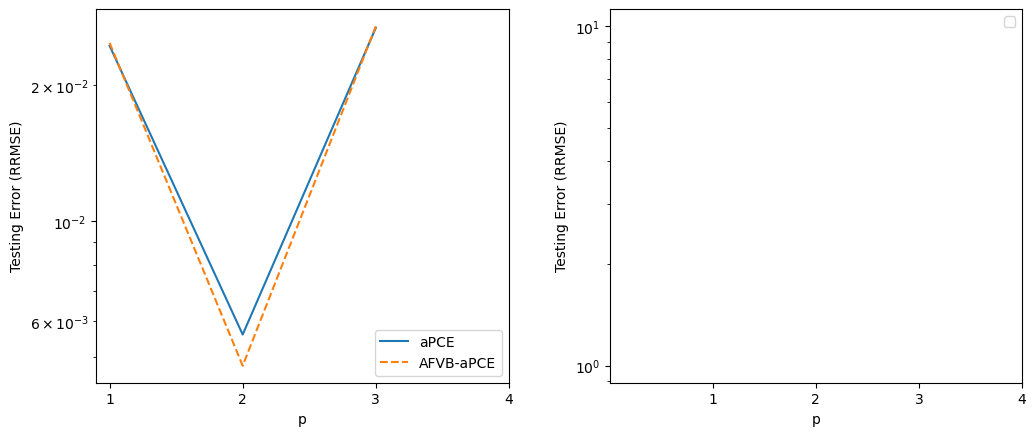

In [1366]:
p = list(range(1,5))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

#ax[0].plot(range(1,5), results_WingWeight_full[0], '-', label = 'aPCE-full')

#ax[0].plot(range(1,4), results_WingWeight_AFVB_aPCE_Global[0], '-', label = 'aPCE')
#ax[0].plot(range(1,4), results_WingWeight_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')

ax[0].plot(range(1,4), results_WingWeight_AFVB_aPCE_Global3[0], '-', label = 'aPCE')
ax[0].plot(range(1,4), results_WingWeight_AFVB_aPCE_Global3[1], '--', label = 'AFVB-aPCE')

#ax[0].plot(range(1,5), results_WingWeight_AFVB_aPCE_ME[0][:4], '-x', label = 'ME-aPCE')
#ax[0].plot(range(1,5), results_WingWeight_AFVB_aPCE_ME[1], '-.', label = 'ME-AFVB-aPCE')

ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RRMSE)")
ax[0].legend()


#ax[1].plot(range(1,5), results_WingWeight_AFVB_aPCE_Global2[0], '-', label = 'PCE')
#ax[1].plot(range(1,5), results_WingWeight_AFVB_aPCE_Global2[1], '--', label = 'AFVB-PCE')

#ax[1].plot(p, results_WingWeight_AFVB_aPCE_ME[6], '-', label = 'aPCE-Train')
#ax[1].plot(p, results_WingWeight_AFVB_aPCE_Global[7], '--', label = 'AFVB-aPCE-Train')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RRMSE)")
ax[1].legend()

fig.tight_layout(pad = 3.0);
#plt.savefig(wd + '/WingWeight_AFVB_Error.png')

### aPCE_Steiltjes

In [280]:
results_WingWeight_AFVB_Global_aPCE_Stieltjes = collect_results_PCE(p, d, WingWeight, best_params_AFVB_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE_Stieltjes', AFVB_PCE, None)

0.14290213584899902
p = 1 n* =  8
1.935128927230835
p = 2 n* =  29
49.23964285850525
p = 3 n* =  65
370.225301027298
p = 4 n* =  179


### PCE

In [31]:
B_init = [[150,200], [220,300], [6,10], [-10,10], [16,45], [0.5,1], [0.08,0.18], [2.5,6], [1700,2500], [0.025,0.08]]


In [1047]:
best_params_AFVB_Global_PCE = [OrderedDict([('A_0', 0.1), ('B_0', 0.1), ('C_0', 0.07448179932975434), ('D_0', 0.1)]), 
                                OrderedDict([('A_0', 1e-02), ('B_0', 1e-04), ('C_0', 0.1), ('D_0', 0.013067806438699911)]),
                                OrderedDict([('A_0', 0.008884817673687323), ('B_0', 0.009753636853344344), ('C_0', 0.00888031704951528), ('D_0', 0.0003874104512803077)]),
                                OrderedDict([('A_0', 1e-2), ('B_0', 1e-5), ('C_0', 1e-2), ('D_0', 1e-3)])]


In [190]:
# values from the cluster: p = 1,2,3
best_params_AFVB_Global_PCE = [OrderedDict([('A_0', 0.001), ('B_0', 0.001), ('C_0', 0.001), ('D_0', 0.1)]),
                               OrderedDict([('A_0', 0.001), ('B_0', 0.0001), ('C_0', 0.09872268149649086), ('D_0', 0.017554649634737407)]),
                               OrderedDict([('A_0', 1e-1), ('B_0', 1e-5), ('C_0', 1e-2), ('D_0', 1e-2)]),
                               OrderedDict([('A_0', 0.23993072021345516), ('B_0', 0.00011590762971074465), ('C_0', 0.022251744437764953), ('D_0', 0.07318469758961345)])]


In [1330]:
p = list(range(1,5))
results_WingWeight_AFVB_PCE_Global = collect_results_PCE(p, d, WingWeight, best_params_AFVB_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, Y_test, 'PCE_Legendre', AFVB_PCE, B_init)


0.15388107299804688
p = 1 n* =  8
0.8955509662628174
p = 2 n* =  25
11.260540246963501
p = 3 n* =  74
518.4107799530029
p = 4 n* =  118


In [861]:
results_WingWeight_AFVB_PCE_Global[4]

[array([268.20829359]), array([268.10119172]), array([268.07310995])]

In [862]:
results_WingWeight_AFVB_PCE_Global[5]

[2189.2296037878828, 2305.5220074464546, 2311.9894272537413]

## Local Models

In [23]:
params_init_list = np.array(list(params_init_AFVB.values())*(4**d)).reshape(4**d,4)

In [26]:
theta1 = [3e-1]

theta2 = [3e-1]

model_temp = ME_PCE('aPCE', d = d, p = 2, B_init = [B_init], fun = WingWeight,
                    alg_mod = AFVB_PCE, data_fun = data_wingweight, N_t = 80, N_p = N_pol,
                    theta1 = theta1, theta2 = theta2, n_iter = 1,
                    arg1 = params_init_list[:,0], 
                    arg2 = params_init_list[:,1], 
                    arg3 = params_init_list[:,2], 
                    arg4 = params_init_list[:,3])

model_temp.fit(None, None)

ME_PCE(B_init=[[[150, 200], [220, 300], [6, 10], [-10, 10], [16, 45], [0.5, 1],
                [0.08, 0.18], [2.5, 6], [1700, 2500], [0.025, 0.08]]],
       N_p=1000000, N_t=80, PCE_method='aPCE',
       alg_mod=<class 'AFVB_PCE.AFVB_PCE'>,
       arg1=array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]),
       arg2=array([0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001]),
       arg3=array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]),
       arg4=array([0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001]), d=10,
       data_fun=<function data_wingweight at 0x2af29a2a0>,
       fun=<function WingWeight at 0x2af299f80>, n_iter=1, p=2, theta1=[0.3],
       theta2=[0.3])

In [27]:
B_split = model_temp.B_split

In [86]:
ot.RandomGenerator.SetSeed(2357)
N_train = 400
X_train = np.array(m.distributionX.getSample(N_train))
Y_train = np.array(m.model(X_train))

X_test = np.array(m.distributionX.getSample(100))

In [75]:
p = [1]

mod = aPCE(X_pol, p[0])
P = mod.Create_Orthonormal_Polynomials(p[0])

model = ME_PCE('aPCE', d = d, p = p[0], B_init = [B_init], fun = WingWeight,
                    alg_mod = AFVB_PCE, data_fun = data_wingweight, N_t = 80, N_p = N_pol,
                    theta1 = theta1, theta2 = theta2,
                    arg1 = params_init_list[:,0], 
                    arg2 = params_init_list[:,1], 
                    arg3 = params_init_list[:,2], 
                    arg4 = params_init_list[:,3],
                    n_iter = 0,
                    B_split_in = B_split)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=Y_train,
    cv=5,
    n_jobs = 5,
    scoring="neg_root_mean_squared_error",
    train_sizes = train_size
)

train_mean_ME_p1 = -train_scores.mean(axis=1)
test_mean_ME_p1 = -test_scores.mean(axis=1)


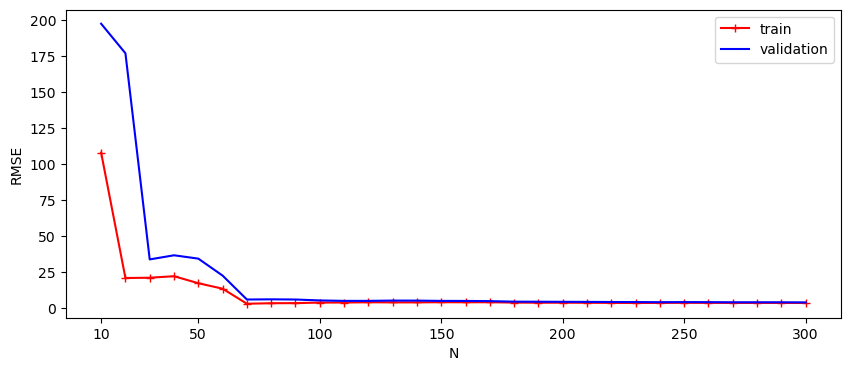

<Figure size 1100x500 with 0 Axes>

In [77]:
plt.subplots(figsize=(10,4))
plt.plot(train_sizes, train_mean_ME_p1, "r-+",  label="train")
plt.plot(train_sizes, test_mean_ME_p1, "b-", label="validation")

#plt.title("Learning Curve")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.xticks([10, 50, 100, 150, 200, 250, 300])
#plt.ylim([0.0, 10.0])

plt.show()
plt.savefig(wd + '/WingWeight_Learning_Curve_ME_p1.png')

In [28]:
p = [2]

mod = aPCE(X_pol, p[0])
P = mod.Create_Orthonormal_Polynomials(p[0])

model = ME_PCE('aPCE', d = d, p = p[0], B_init = [B_init], fun = WingWeight,
                    alg_mod = AFVB_PCE, data_fun = data_wingweight, N_t = 80, N_p = N_pol,
                    theta1 = theta1, theta2 = theta2,
                    arg1 = params_init_list[:,0], 
                    arg2 = params_init_list[:,1], 
                    arg3 = params_init_list[:,2], 
                    arg4 = params_init_list[:,3],
                    n_iter = 0,
                    B_split_in = B_split)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=Y_train,
    cv=5,
    n_jobs = 5,
    scoring="neg_root_mean_squared_error",
    train_sizes = train_size
)

train_mean_ME_p2 = -train_scores.mean(axis=1)
test_mean_ME_p2 = -test_scores.mean(axis=1)

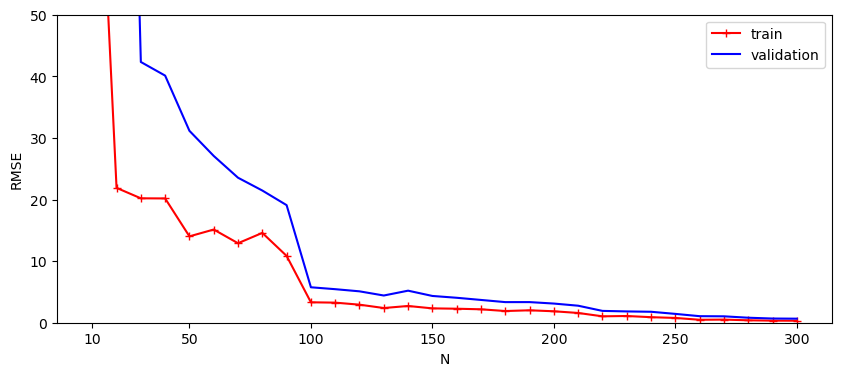

<Figure size 1100x500 with 0 Axes>

In [83]:
plt.subplots(figsize=(10,4))
plt.plot(train_sizes, train_mean_ME_p2, "r-+",  label="train")
plt.plot(train_sizes, test_mean_ME_p2, "b-", label="validation")

#plt.title("Learning Curve")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.xticks([10, 50, 100, 150, 200, 250, 300])
plt.ylim([0.0, 50.0])

plt.show()
plt.savefig(wd + '/WingWeight_Learning_Curve_ME_p2.png')

In [35]:
test_mean_ME_p2

array([208.22674244, 191.27336256,  42.32846348,  40.11448722,
        31.15402891,  27.07545125,  23.53951768,  21.4592689 ,
        19.08743619,   5.75373386,   5.44530245,   5.09542204,
         4.41716637,   5.20253696,   4.34519281,   4.05020325,
         3.69852904,   3.34554595,   3.34752421,   3.1106669 ,
         2.76244889,   1.9201763 ,   1.83444366,   1.77854139,
         1.43445257,   1.06299838,   1.03952908,   0.81164709,
         0.68065887,   0.65665673])

In [ ]:
p = [3]

mod = aPCE(X_pol, p[0])
P = mod.Create_Orthonormal_Polynomials(p[0])

model = ME_PCE('aPCE', d = d, p = p[0], B_init = [B_init], fun = WingWeight,
                    alg_mod = AFVB_PCE, data_fun = data_wingweight, N_t = 80, N_p = N_pol,
                    theta1 = theta1, theta2 = theta2,
                    arg1 = params_init_list[:,0], 
                    arg2 = params_init_list[:,1], 
                    arg3 = params_init_list[:,2], 
                    arg4 = params_init_list[:,3],
                    n_iter = 0,
                    B_split_in = B_split)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=Y_train,
    cv=5,
    n_jobs = 5,
    scoring="neg_root_mean_squared_error",
    train_sizes = train_size
)

train_mean_ME_p3 = -train_scores.mean(axis=1)
test_mean_ME_p3 = -test_scores.mean(axis=1)

In [ ]:
plt.subplots(figsize=(10,4))
plt.plot(train_sizes, train_mean_ME_p3, "r-+",  label="train")
plt.plot(train_sizes, test_mean_ME_p3, "b-", label="validation")

#plt.title("Learning Curve")
plt.xlabel("N")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.xticks([10, 50, 100, 150, 200, 250, 300])
plt.ylim([0.0, 10.0])

plt.show()
plt.savefig(wd + '/WingWeight_Learning_Curve_ME_p3.png')

In [99]:
# 4, 7, 8
p = [2]
N_t = [80]*5
theta1 = [[3e-1, 4e-2, 1e-1]]

theta2 = [[3e-1, 4e-2, 1e-1]]

Find_B_split(p, d, WingWeight, params_init_AFVB, 
              X_test, 'aPCE', AFVB_PCE, N_t, N_pol, data_wingweight, 
                B_init, None, None, n_iter = 1, 
                theta1 = theta1, theta2 = theta2, alpha = 0.5)


time = 11.416970014572144
p = 2 M = 8
[[1.  1.  1.  0.5 1.  1.  0.5 0.5 1.  1. ]
 [1.  1.  1.  0.5 1.  1.  0.5 0.5 1.  1. ]
 [1.  1.  1.  0.5 1.  1.  0.5 0.5 1.  1. ]
 [1.  1.  1.  0.5 1.  1.  0.5 0.5 1.  1. ]
 [1.  1.  1.  0.5 1.  1.  0.5 0.5 1.  1. ]
 [1.  1.  1.  0.5 1.  1.  0.5 0.5 1.  1. ]
 [1.  1.  1.  0.5 1.  1.  0.5 0.5 1.  1. ]
 [1.  1.  1.  0.5 1.  1.  0.5 0.5 1.  1. ]]


### aPCE

In [18]:
B_init = []
for i in range(d):
    B_init.append([np.min([X_train_full[:,i].min(), X_test_full[:,i].min(), X_pol[:,i].min()]), np.max([X_train_full[:,i].max(), X_test_full[:,i].max(), X_pol[:,i].max()])])


In [1260]:
# Use these
best_params_AFVB_ME_aPCE = [[OrderedDict([('A_0', 1e-1), ('B_0', 1e-1), ('C_0', 1e-1), ('D_0', 1e-1)])]*32,
                            [OrderedDict([('A_0', 1e-1), ('B_0', 1e-2), ('C_0', 1e-1), ('D_0', 1e-1)])]*32,
                            [OrderedDict([('A_0', 1e-1), ('B_0', 2e-3), ('C_0', 1e-1), ('D_0', 1e-1)])]*32,
                            [OrderedDict([('A_0', 1e-1), ('B_0', 1e-2), ('C_0', 1e-1), ('D_0', 1e-1)])]*32]

In [1261]:
p = list(range(1,4))
N_t = [140, 140, 160, 240]

theta1 = [[1e-2, 1e-2],
          [3e-1, 1e-1],
          [5e-8, 1e-1],
          [5e-8, 1e-1]]

theta2 = [[1e-2, 1e-1],
          [3e-1, 1e-1],
          [4e-8, 1e-1],
          [5e-8, 1e-1]]

results_WingWeight_AFVB_aPCE_ME = collect_results_ME(p, d, WingWeight, best_params_AFVB_ME_aPCE, 
                                                  X_test, 'aPCE', 
                                                  AFVB_PCE, N_t = N_t, N_p = N_pol, data_fun = data_wingweight,
                                                  B_init = B_init, n_iter = 1, 
                                                  theta1 = theta1, theta2 = theta2, alpha = 0.5,
                                                  params_init = params_init_AFVB, p_split = 2, N_t_split = 80)


time = 1.6034951210021973
p = 1 M = 4
n_star: [9, 8, 9, 9]
0    2.767037e+02
1   -1.455192e-11
2    5.247415e+02
3   -1.455192e-11
4    3.276775e-01
5    2.549875e+00
6    3.253756e+02
7    9.427958e+02
8    2.026843e+02
9    6.567090e+00
Name: Partial Variance, dtype: float64
0    280.529676
1      0.000000
2    532.070371
3      0.000000
4      0.440893
5      2.605827
6    333.222005
7    957.684294
8    205.478358
9      6.567769
Name: Total Variance, dtype: float64
2300.1393419339347 268.11616563375986
time = 6.438653945922852
p = 2 M = 4
n_star: [35, 35, 35, 36]
0    287.788450
1      0.005949
2    508.443254
3      1.206507
4      0.223770
5      3.977771
6    326.131187
7    951.893171
8    196.051864
9      7.723887
Name: Partial Variance, dtype: float64
0    295.429533
1      0.005964
2    522.042558
3      1.227787
4      0.229471
5      4.144036
6    335.518947
7    970.481251
8    202.130546
9      7.779386
Name: Total Variance, dtype: float64
2311.152573927775 268.0226569

In [244]:
B = results_WingWeight_AFVB_aPCE_ME1[-1][0].B_split.copy()


In [457]:
v = [7]
for j in range(1):
    B_new = []
    l = v[j]
    for i in range(len(B)):
        B_temp1 = B[i].copy()
        B_temp1[l-1] = [B[i][l-1][0], B[i][l-1][0]+(B[i][l-1][1]-B[i][l-1][0])/2]

        B_temp2 = B[i].copy()
        B_temp2[l-1] = [B[i][l-1][0]+(B[i][l-1][1]-B[i][l-1][0])/2, B[i][l-1][1]]

        B_new.append(B_temp1)
        B_new.append(B_temp2)
        
    B = B_new.copy()

In [245]:
len(B)

8

In [25]:
p = list(range(1,4))
N_t = [120]*5
theta1 = [[1e-2, 1e-2],
          [5e-1, 1e-1],
          [5e-8, 1e-1]]

theta2 = [[1e-2, 1e-1],
          [5e-1, 1e-1],
          [4e-8, 1e-1]]

results_WingWeight_AFVB_aPCE_ME8 = collect_results_ME_WingWeight(p, d, WingWeight, best_params_AFVB_ME_aPCE8, 
                                                  X_test, 'aPCE', 
                                                  AFVB_PCE, N_t = N_t, N_p = N_pol, data_fun = data_wingweight,
                                                  B_init = B_init, n_iter = 1, 
                                                  theta1 = theta1, theta2 = theta2, alpha = 0.5,
                                                  params_init = params_init_AFVB, p_split = 2, N_t_split = 200,
                                                  B_split_in = B_split)


NameError: name 'collect_results_ME_WingWeight' is not defined

In [2171]:
results_WingWeight_AFVB_aPCE_ME16[-1][0].Jk_i

array([[1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. ],
       [1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. ],
       [1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. ],
       [1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. ],
       [1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. ],
       [1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. ],
       [1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. ],
       [1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. ]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


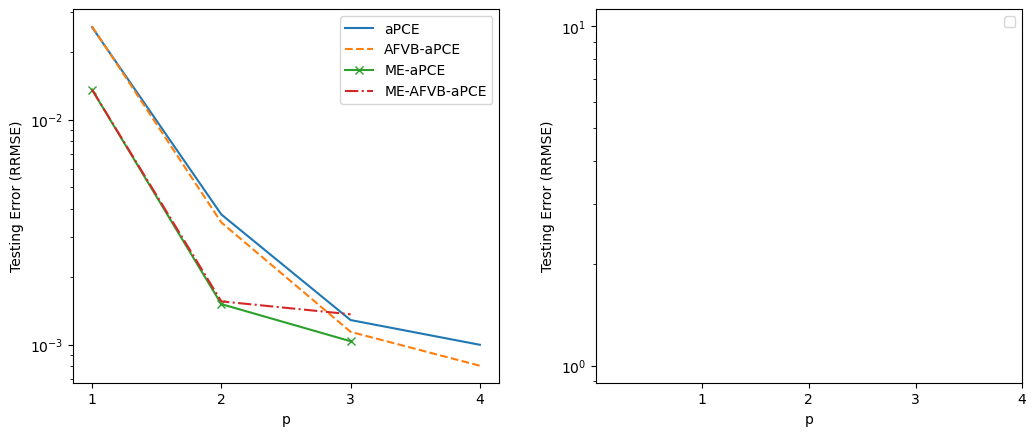

In [28]:
p = list(range(1,5))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

#ax[0].plot(p, results_WingWeight_full[0], '-', label = 'PCE-full')
ax[0].plot(p, results_WingWeight_AFVB_aPCE_Global[0], '-', label = 'aPCE')
ax[0].plot(p, results_WingWeight_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')


ax[0].plot(range(1,3), results_WingWeight_AFVB_aPCE_ME[0], '-x', label = 'ME-aPCE')
ax[0].plot(range(1,3), results_WingWeight_AFVB_aPCE_ME[1], '-.', label = 'ME-AFVB-aPCE')

ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RRMSE)")
ax[0].legend()

#ax[1].plot(range(1,4), results_WingWeight_AFVB_PCE_Global[0], '-', label = 'PCE')
#ax[1].plot(range(1,4), results_WingWeight_AFVB_PCE_Global[1], '--', label = 'AFVB-PCE')
#ax[1].plot(range(1,3), (results_WingWeight_AFVB_aPCE_ME2[0]), '-x', label = 'ME-PCE')
#ax[1].plot(range(1,3), (results_WingWeight_AFVB_aPCE_ME2[1]), '-.', label = 'ME-AFVB-PCE')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RRMSE)")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/WingWeight_AFVB_Error.png')

### aPCE_Stieltjes

In [44]:
results_WingWeight_AFVB_aPCE_Stieltjes_ME = collect_results_ME(p, d, tf.ishigami, best_params_AFVB_ME_PCE, 
                                                  X_test, 'PCE_Legendre', 
                                                  AFVB_PCE, data_ishigami, N_t = 50, N_p = None, 
                                                  B_init = B_init, n_iter = 1)

22.42189121246338
32
37.125842332839966
32
138.96673107147217
4


### PCE

In [1321]:
p = [1,2]
N_t = [200]*5


Find_B_split(p, d, WingWeight, params_init_AFVB, 
                X_test, 'PCE_Legendre', AFVB_PCE, N_t, N_pol, data_wingweight, 
                B_init, None, None, n_iter = 1, 
                theta1 = theta1, theta2 = theta2, alpha = 0.5)

time = 12.65753722190857
p = 2 M = 32


In [884]:
# Use these
best_params_AFVB_ME_PCE = [[OrderedDict([('A_0', 1e-1), ('B_0', 1e-1), ('C_0', 1e-1), ('D_0', 1e-1)])]*32,
                            [OrderedDict([('A_0', 1e-1), ('B_0', 1e-1), ('C_0', 1e-1), ('D_0', 1e-1)])]*32,
                            [OrderedDict([('A_0', 1e-5), ('B_0', 1e-5), ('C_0', 1e-5), ('D_0', 1e-5)])]*32,
                            [OrderedDict([('A_0', 1e-1), ('B_0', 1e-1), ('C_0', 1e-1), ('D_0', 1e-1)])]*32]

In [885]:
p = list(range(1,4))
#N_t = [120]*5
B_init = [[150,200], [220,300], [6,10], [-10,10], [16,45], [0.5,1], [0.08,0.18], [2.5,6], [1700,2500], [0.025,0.08]]

results_WingWeight_AFVB_PCE_ME = collect_results_ME_WingWeight(p, d, WingWeight, best_params_AFVB_ME_aPCE, 
                                                  X_test, 'PCE_Legendre', 
                                                  AFVB_PCE, N_t = N_t, N_p = N_pol, data_fun = data_wingweight,
                                                  B_init = B_init, n_iter = 1, 
                                                  theta1 = theta1, theta2 = theta2, alpha = 0.5,
                                                  params_init = params_init_AFVB, p_split = 2, N_t_split = 150,
                                                   B_split_in = B)


time = 0.934150218963623
p = 1 M = 8
n_star: [8, 9, 8, 9, 9, 9, 9, 9]
0    2.816713e+02
1   -9.094947e-12
2    5.464141e+02
3    7.898619e-01
4   -9.094947e-12
5    4.757103e+00
6    3.320527e+02
7    9.269181e+02
8    2.096188e+02
9    8.096325e+00
Name: Partial Variance, dtype: float64
0    285.265741
1      0.000000
2    553.877153
3      0.905763
4      0.000000
5      4.828293
6    340.033898
7    941.489834
8    212.484823
9      8.097194
Name: Total Variance, dtype: float64
2328.630668902286 268.87747437961275
time = 6.040234088897705
p = 2 M = 8
n_star: [38, 39, 38, 41, 38, 40, 37, 40]
0    287.706187
1      0.007088
2    509.061631
3      1.173640
4      0.182010
5      4.332706
6    326.113555
7    953.040253
8    196.628811
9      7.775303
Name: Partial Variance, dtype: float64
0    295.603925
1      0.007469
2    522.479002
3      1.216318
4      0.188059
5      4.479000
6    335.508710
7    971.408581
8    202.645759
9      7.827832
Name: Total Variance, dtype: float64
231

In [60]:
sizePCE = 800
inputDesignPCE = m.distributionX.getSample(sizePCE)
outputDesignPCE = m.model(inputDesignPCE)

algo = ot.FunctionalChaosAlgorithm(inputDesignPCE, outputDesignPCE, m.distributionX)

algo.run()
result = algo.getResult()
print(result.getResiduals())
print(result.getRelativeErrors())

[0.000344543]
[4.32412e-08]


In [128]:
GSA_WingWeight

Partial Variance  Total Variance  1st Order  Total Order
0        288.206195      331.073513   0.124729     0.143281
1          0.704524       33.317765   0.000305     0.014419
2        509.812915      551.230695   0.220635     0.238560
3          1.922599       34.257318   0.000832     0.014826
4          0.891042       33.749220   0.000386     0.014606
5          4.926175       37.896437   0.002132     0.016401
6        324.201731      377.590067   0.140307     0.163412
7        952.464785      992.233426   0.412204     0.429415
8        197.242681      224.504549   0.085362     0.097160
9          8.356775       39.399423   0.003617     0.017051

In [66]:
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)
print(sensitivityAnalysis)

FunctionalChaosSobolIndices
- input dimension=10
- output dimension=1
- basis size=761
- mean=[268.074]
- std-dev=[48.0634]

| Index | Multi-index   | Variance part |
|-------|---------------|---------------|
|     8 | [0,0,0,0,0,0,0,1,0,0]| 0.410151      |
|     3 | [0,0,1,0,0,0,0,0,0,0]| 0.220277      |
|     7 | [0,0,0,0,0,0,1,0,0,0]| 0.138338      |
|     1 | [1,0,0,0,0,0,0,0,0,0]| 0.124595      |
|     9 | [0,0,0,0,0,0,0,0,1,0]| 0.0847323     |

| Input | Name          | Sobol' index  | Total index   |
|-------|---------------|---------------|---------------|
|     0 | Sw            | 0.124602      | 0.128014      |
|     1 | Wfw           | 2.16904e-06   | 8.96096e-06   |
|     2 | A             | 0.220427      | 0.226238      |
|     3 | Lambda        | 0.000489921   | 0.000511032   |
|     4 | q             | 9.20234e-05   | 0.000101967   |
|     5 | l             | 0.00183476    | 0.00191017    |
|     6 | tc            | 0.140907      | 0.145035      |
|     7 | Nz           

In [85]:
results_WingWeight_AFVB_aPCE_ME16[2]

[0    1.208021e-01
 1   -8.325032e-15
 2    2.213638e-01
 3    4.272508e-04
 4    1.575747e-04
 5    1.923739e-03
 6    1.429785e-01
 7    4.131493e-01
 8    8.540999e-02
 9    3.582851e-03
 Name: Partial Variance, dtype: float64,
 0    0.124628
 1    0.000003
 2    0.220314
 3    0.000493
 4    0.000093
 5    0.001819
 6    0.140803
 7    0.411535
 8    0.084971
 9    0.003364
 Name: Partial Variance, dtype: float64]

In [86]:
results_WingWeight_AFVB_aPCE_Global[2]

[0    0.126268
 1    0.000000
 2    0.231592
 3    0.000000
 4    0.000000
 5    0.001954
 6    0.137831
 7    0.411400
 8    0.086868
 9    0.004087
 Name: 1st Order, dtype: float64,
 0    0.124781
 1    0.000000
 2    0.221404
 3    0.000385
 4    0.000048
 5    0.001739
 6    0.141261
 7    0.410382
 8    0.084957
 9    0.003335
 Name: 1st Order, dtype: float64,
 0    0.124432
 1    0.000004
 2    0.219422
 3    0.000471
 4    0.000073
 5    0.001817
 6    0.140980
 7    0.412667
 8    0.084758
 9    0.003309
 Name: 1st Order, dtype: float64]

In [90]:
results_WingWeight_AFVB_aPCE_ME16[3]

[0    0.122992
 1    0.000000
 2    0.227055
 3    0.000435
 4    0.000169
 5    0.001937
 6    0.146485
 7    0.420309
 8    0.087126
 9    0.003637
 Name: Total Variance, dtype: float64,
 0    0.127971
 1    0.000003
 2    0.226123
 3    0.000508
 4    0.000096
 5    0.001872
 6    0.144867
 7    0.419619
 8    0.087580
 9    0.003390
 Name: Total Variance, dtype: float64]

In [88]:
GSA_WingWeight

Partial Variance  Total Variance  1st Order  Total Order
0        288.175428      295.102050   0.124600     0.127595
1          0.571313       -0.544259   0.000247    -0.000235
2        510.151729      523.948832   0.220577     0.226543
3          1.691333        0.521949   0.000731     0.000226
4          0.781403       -0.294278   0.000338    -0.000127
5          4.754389        3.679243   0.002056     0.001591
6        326.514677      335.022923   0.141177     0.144856
7        952.033985      968.933858   0.411637     0.418944
8        197.176348      200.356191   0.085254     0.086629
9          8.268610        7.473875   0.003575     0.003232

# Plots AFVB - Wing Weight Function

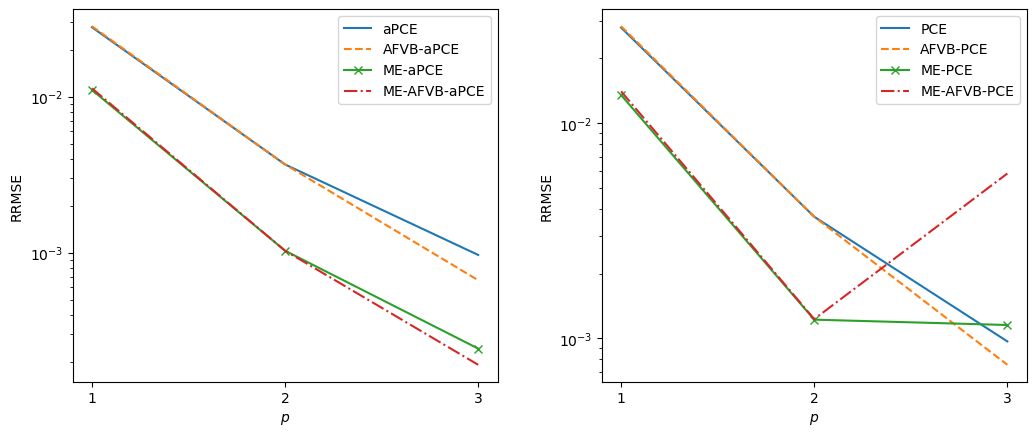

In [886]:
p = list(range(1,4))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, results_WingWeight_AFVB_aPCE_Global[0], '-', label = 'aPCE')
ax[0].plot(p, results_WingWeight_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')
ax[0].plot(range(1,4), (results_WingWeight_AFVB_aPCE_ME1[0]), '-x', label = 'ME-aPCE')
ax[0].plot(range(1,4), (results_WingWeight_AFVB_aPCE_ME1[1]), '-.', label = 'ME-AFVB-aPCE')

#ax[0].plot(p, results_WingWeight_AFVB_Global_aPCE_Stieltjes[0], ':', c = 'black', alpha = 0.6, label = 'aPCE_Stieltjes')
#ax[0].plot(p, results_WingWeight_AFVB_Global_aPCE_Stieltjes[1], ':', c = 'black', alpha = 0.6, label = 'AFVB-aPCE_Stieltjes')
#ax[0].plot(p, results_WingWeight_AFVB_aPCE_ME[0], '-x', c = 'black', alpha = 0.6, label = 'ME-aPCE')
#ax[0].plot(p, results_WingWeight_AFVB_aPCE_ME[1], '-.', c = 'black', alpha = 0.6, label = 'ME-AFVB-aPCE')

ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("$p$")
ax[0].set_ylabel("RRMSE")
ax[0].legend()

ax[1].plot(p, results_WingWeight_AFVB_PCE_Global[0], '-', label = 'PCE')
ax[1].plot(p, results_WingWeight_AFVB_PCE_Global[1], '--', label = 'AFVB-PCE')
ax[1].plot(range(1,4), (results_WingWeight_AFVB_PCE_ME[0]), '-x', label = 'ME-PCE')
ax[1].plot(range(1,4), (results_WingWeight_AFVB_PCE_ME[1]), '-.', label = 'ME-AFVB-PCE')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("$p$")
ax[1].set_ylabel("RRMSE")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/WingWeight_AFVB_Error.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


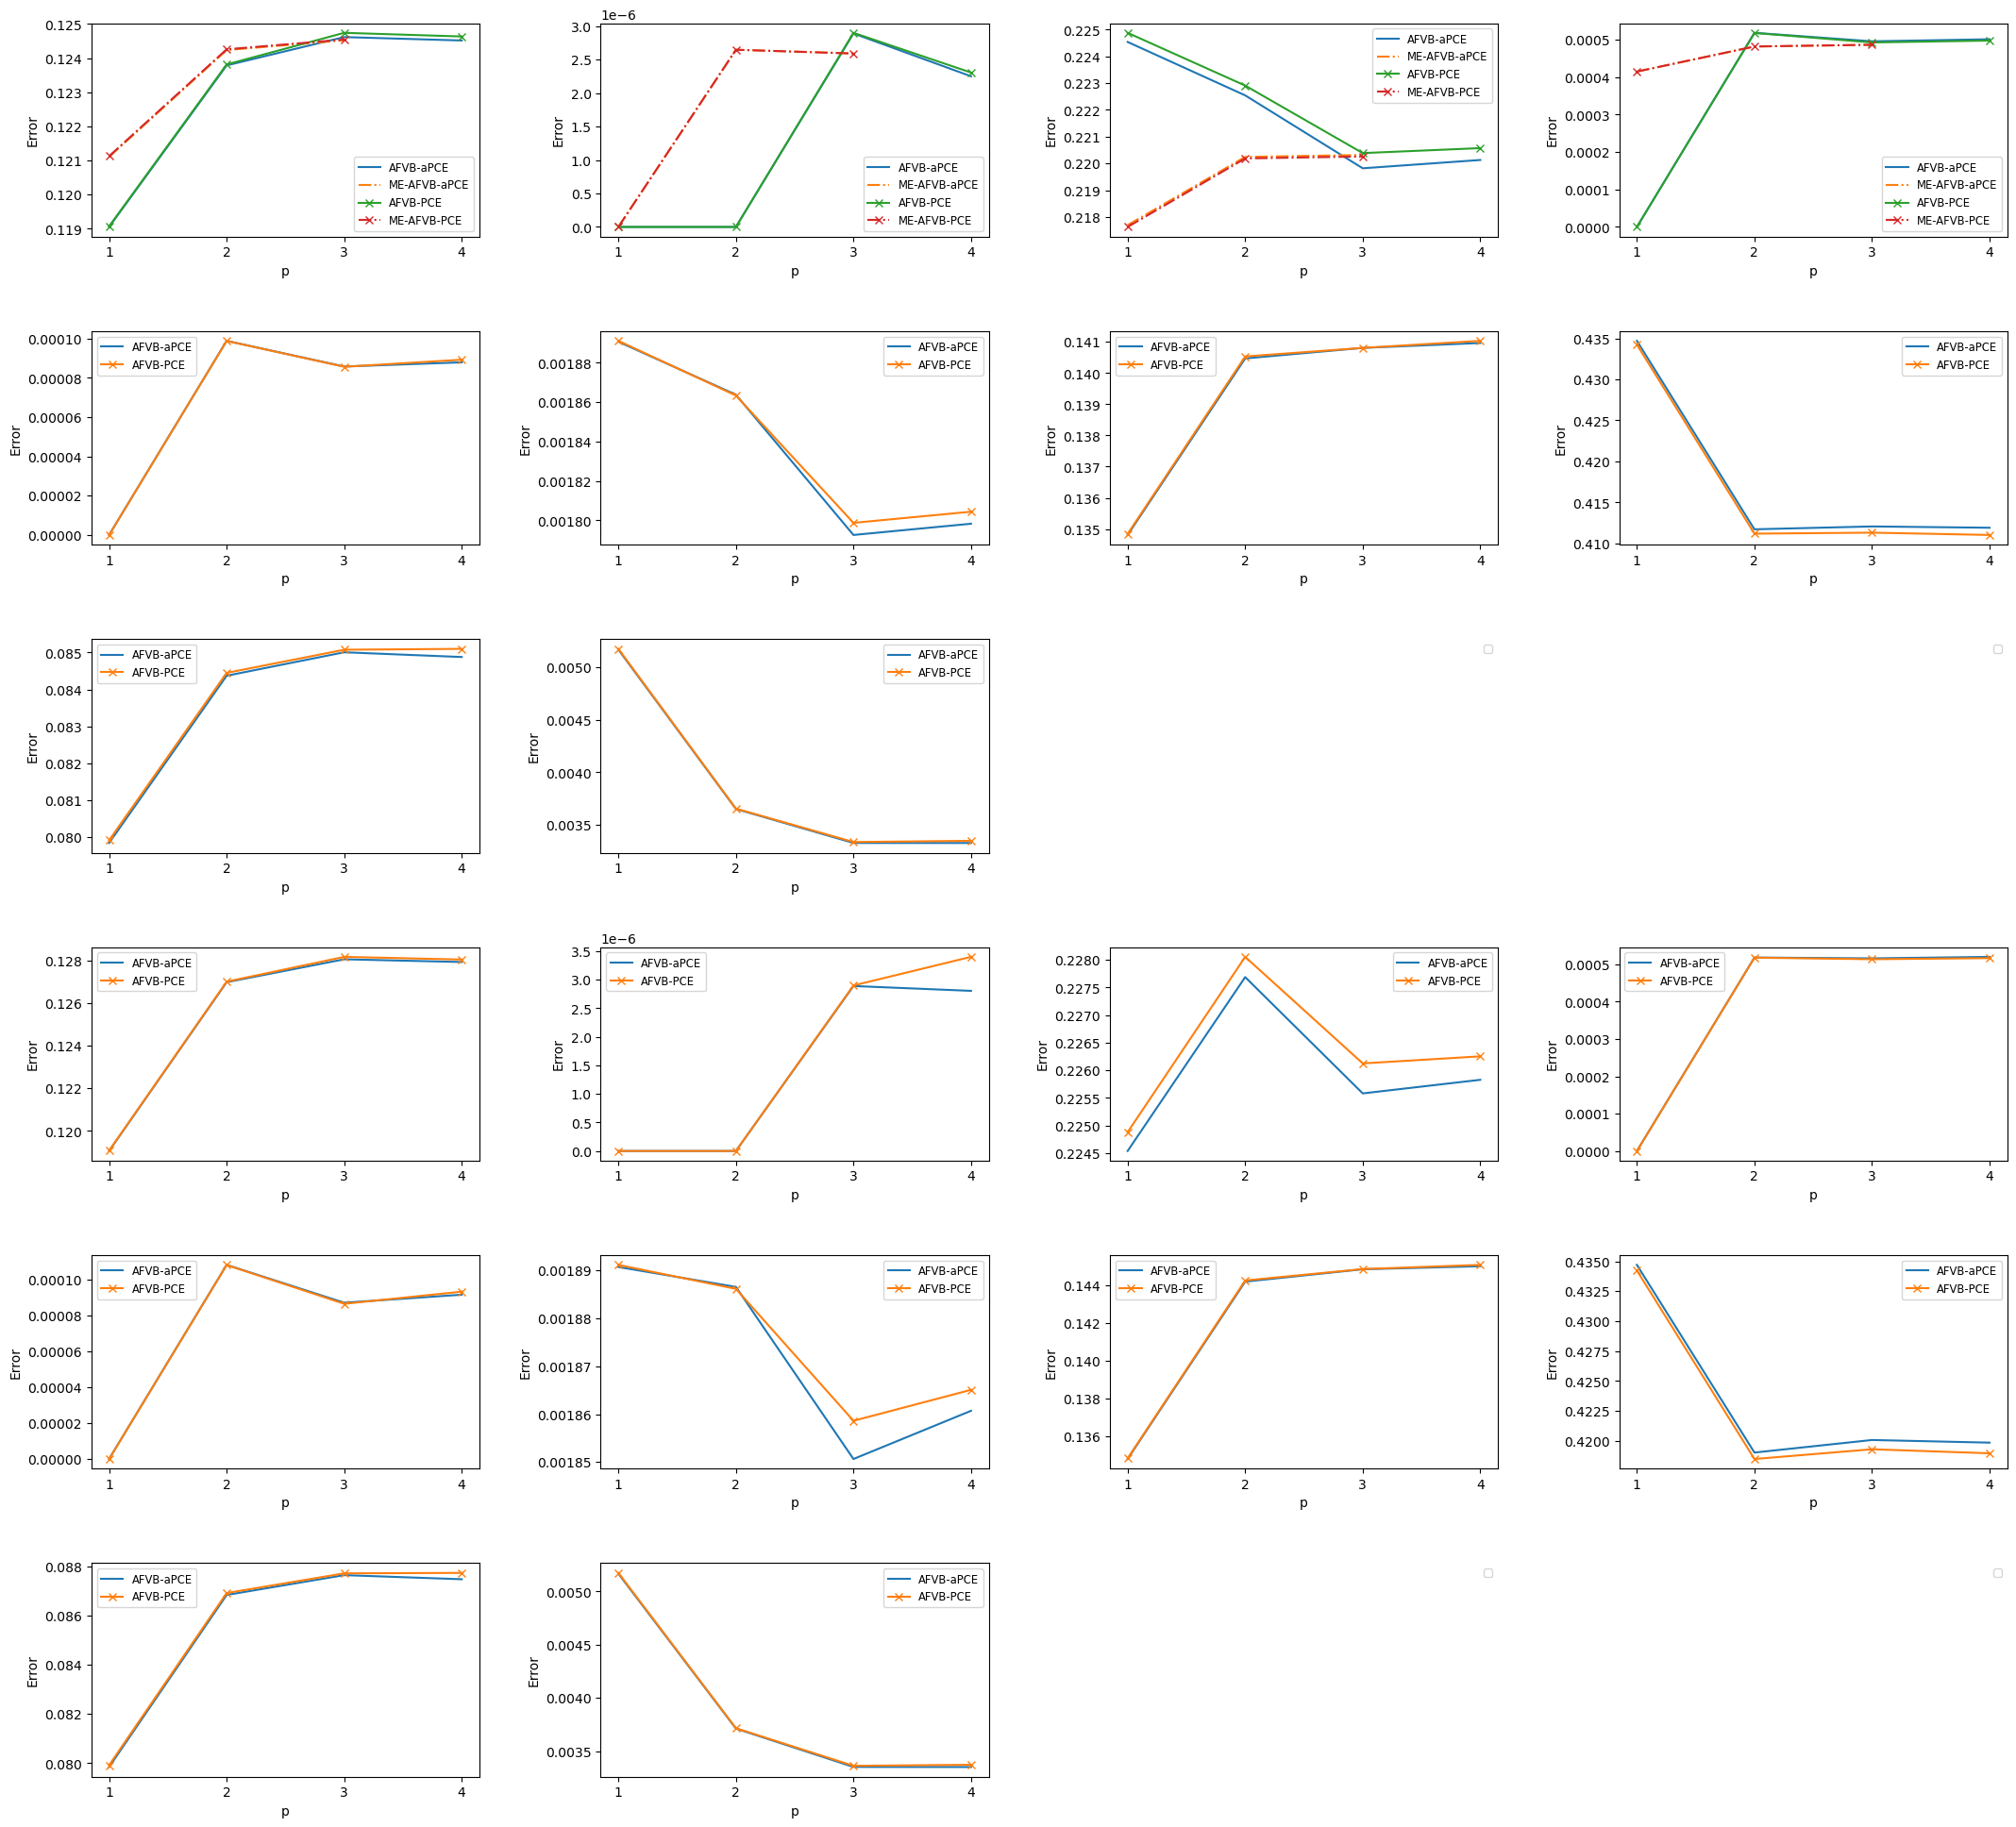

In [292]:
plt.rcParams['figure.figsize'] = (22,20) # (width, height)
fig, ax = plt.subplots(6, 4)
markers = ['-x','-o','-v']

for i in range(4):
    ax[0,i].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,i], '-', label = 'AFVB-aPCE')  
    ax[0,i].plot(range(1,4), np.array(results_WingWeight_AFVB_aPCE_ME8[2])[:,i], '-.', label = 'ME-AFVB-aPCE') 
    ax[0,i].plot(p, np.array(results_WingWeight_AFVB_PCE_Global[2])[:,i] , '-x', label = 'AFVB-PCE')  
    ax[0,i].plot(range(1,4), np.array(results_WingWeight_AFVB_PCE_ME[2])[:,i], '-.x', label = 'ME-AFVB-PCE') 

    ax[1,i].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,i+4], '-', label = 'AFVB-aPCE')  
    #ax[1,i].plot(range(1,3), np.abs(np.array(results_WingWeight_AFVB_aPCE_ME[2])[:,i+4] - GSA_WingWeight_1st_Order[i]), '-.', label = 'ME-AFVB-aPCE') 
    ax[1,i].plot(p, np.array(results_WingWeight_AFVB_PCE_Global[2])[:,i+4], '-x', label = 'AFVB-PCE')  
    #ax[1,i].plot(p, np.abs(np.array(results_WingWeight_AFVB_PCE_ME[2])[:,i+4] - GSA_WingWeight_1st_Order[i]), '-.x', label = 'ME-AFVB-PCE') 
    
    ax[3,i].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,i], '-', label = 'AFVB-aPCE')  
    #ax[3,i].plot(range(1,3), np.abs(np.array(results_WingWeight_AFVB_aPCE_ME[3])[:,i] - GSA_WingWeight_Total_Order[i]), '-.', label = 'ME-AFVB-aPCE') 
    ax[3,i].plot(p, np.array(results_WingWeight_AFVB_PCE_Global[3])[:,i], '-x', label = 'AFVB-PCE')  
    #ax[3,i].plot(p, np.abs(np.array(results_WingWeight_AFVB_PCE_ME[3])[:,i] - GSA_WingWeight_Total_Order[i]), '-.x', label = 'ME-AFVB-PCE') 

    ax[4,i].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,i+4] , '-', label = 'AFVB-aPCE')  
    #ax[4,i].plot(range(1,3), np.abs(np.array(results_WingWeight_AFVB_aPCE_ME[3])[:,i+4] - GSA_WingWeight_Total_Order[i]), '-.', label = 'ME-AFVB-aPCE') 
    ax[4,i].plot(p, np.array(results_WingWeight_AFVB_PCE_Global[3])[:,i+4] , '-x', label = 'AFVB-PCE')  
    #ax[4,i].plot(p, np.abs(np.array(results_WingWeight_AFVB_PCE_ME[3])[:,i+4] - GSA_WingWeight_Total_Order[i]), '-.x', label = 'ME-AFVB-PCE') 
    
for i in range(2):
    ax[2,i].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,i+8], '-', label = 'AFVB-aPCE')  
    #ax[2,i].plot(range(1,3), np.abs(np.array(results_WingWeight_AFVB_aPCE_ME[2])[:,i+8] - GSA_WingWeight_1st_Order[i]), '-.', label = 'ME-AFVB-aPCE') 
    ax[2,i].plot(p, np.array(results_WingWeight_AFVB_PCE_Global[2])[:,i+8], '-x', label = 'AFVB-PCE')  
    #ax[2,i].plot(p, np.abs(np.array(results_WingWeight_AFVB_PCE_ME[2])[:,i+8] - GSA_WingWeight_1st_Order[i]), '-.x', label = 'ME-AFVB-PCE') 

    ax[5,i].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,i+8], '-', label = 'AFVB-aPCE')  
    #ax[5,i].plot(range(1,3), np.abs(np.array(results_WingWeight_AFVB_aPCE_ME[3])[:,i+8] - GSA_WingWeight_Total_Order[i]), '-.', label = 'ME-AFVB-aPCE') 
    ax[5,i].plot(p, np.array(results_WingWeight_AFVB_PCE_Global[3])[:,i+8], '-x', label = 'AFVB-PCE')  
    #ax[5,i].plot(p, np.abs(np.array(results_WingWeight_AFVB_PCE_ME[3])[:,i+8] - GSA_WingWeight_Total_Order[i]), '-.x', label = 'ME-AFVB-PCE') 
    
for i in range(4):
    for j in range(6):
        ax[j,i].set_xticks(p)
        #ax[j,i].set_yscale("log")
        ax[j,i].set_xlabel("p")
        ax[j,i].set_ylabel("Error")
        ax[j,i].legend(fontsize = 'small')

ax[2,2].set_axis_off()
ax[2,3].set_axis_off()
ax[5,2].set_axis_off()
ax[5,3].set_axis_off()


fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/WingWeight_AFVB_GSA.png')

NameError: name 'results_WingWeight_AFVB_PCE_Global' is not defined

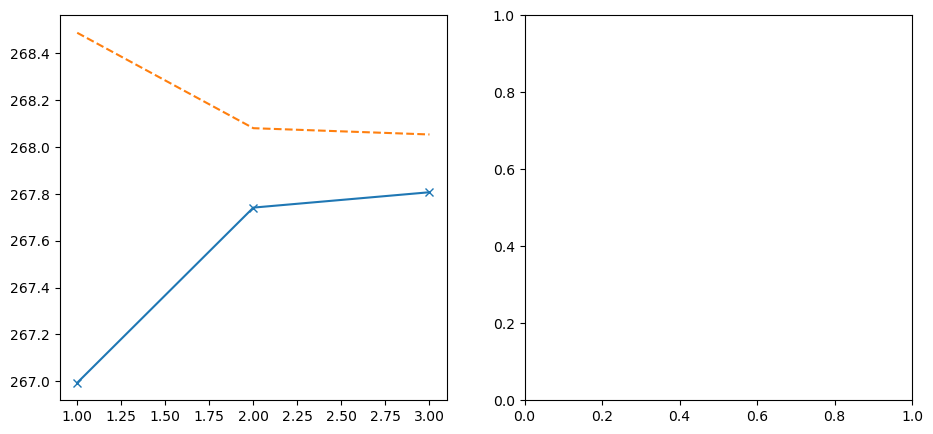

In [718]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(range(1,4), np.array(results_WingWeight_AFVB_aPCE_Global[4]), '-x', label = 'AFVB-aPCE')
ax[0].plot(range(1,4), np.array(results_WingWeight_AFVB_aPCE_ME[4]), '--', label = 'ME-AFVB-aPCE')

ax[0].plot(p, np.array(results_WingWeight_AFVB_PCE_Global[4]), '-', label = 'AFVB-PCE')
ax[0].plot(range(1,4), np.array(results_WingWeight_AFVB_PCE_ME[4]), '-.', label = 'ME-AFVB-PCE')
ax[0].set_xticks(p)
#ax[0].set_yscale("log")
ax[0].set_xlabel("$p$")
ax[0].set_ylabel("Mean")
ax[0].legend()

ax[1].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[5]), '-x', label = 'AFVB-aPCE')
ax[1].plot(range(1,4), np.array(results_WingWeight_AFVB_aPCE_ME8[5]), '--', label = 'ME-AFVB-aPCE')

ax[1].plot(p, np.array(results_WingWeight_AFVB_PCE_Global[5]), '-', label = 'AFVB-PCE')
ax[1].plot(range(1,4), np.array(results_WingWeight_AFVB_PCE_ME[5]), '-.', label = 'ME-AFVB-PCE')
ax[1].set_xticks(p)
#ax[1].set_yscale("log")
ax[1].set_xlabel("$p$")
ax[1].set_ylabel("Variance")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/WingWeight_AFVB_mean_and_Variance.png')

## VRVM - WingWeight

### aPCE

In [318]:
# N_train = 240
p = list(range(1,4))

best_params_VRVM_Global_aPCE = [OrderedDict([('omega_a', 1e-6), ('omega_b', 1e-3), ('tau_a', 1e-6), ('tau_b', 1e-6)])]*4


In [319]:
results_WingWeight_VRVM_aPCE_Global = collect_results_PCE(p, d, WingWeight, best_params_VRVM_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, Y_test, 'aPCE', VRVM_PCE, B_init)

0.12641310691833496
p = 1 n* =  8
2.543635845184326
p = 2 n* =  29
64.20406079292297
p = 3 n* =  76


In [78]:
results_WingWeight_VRVM_aPCE_Global[-1][0].c_sol[:,0]

array([ 2.68085430e+02,  3.35285879e+00,  1.32242670e+01,  3.08557191e+01,
       -1.71902142e+01,  1.99316204e+00,  2.06117203e-02,  2.09034500e-02,
        2.21694010e+01, -3.23548020e-02,  1.61453418e+01])

In [79]:
results_WingWeight_VRVM_aPCE_Global[-1][0].z_sol

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9999997 , 0.00411895, 0.00379696, 1.        , 0.00415736,
       1.        ])

In [66]:
results_WingWeight_VRVM_aPCE_Global[0]

[0.02820001179787894, 0.003650746482566051]

In [67]:
results_WingWeight_VRVM_aPCE_Global[1]

[0.028216267608140184, 0.0036962116896828855]

In [68]:
results_WingWeight_VRVM_aPCE_Global[4]

[268.0854301435625, 267.9762785161592]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


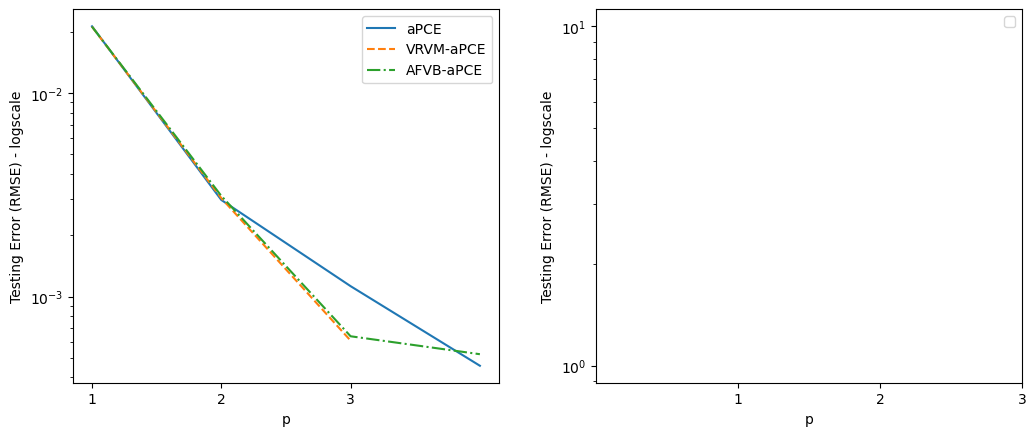

In [321]:
p = list(range(1,4))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(range(1,5), results_WingWeight_full[0], '-', label = 'aPCE')
ax[0].plot(range(1,4), results_WingWeight_VRVM_aPCE_Global[1], '--', label = 'VRVM-aPCE')
#ax[1].plot(range(1,4), (results_WingWeight_VRVM_aPCE_ME[0]), '-x', label = 'ME-aPCE')
ax[0].plot(range(1,5), (results_WingWeight_AFVB_aPCE_Global[1]), '-.', label = 'AFVB-aPCE')

#ax[0].plot(p, results_WingWeight_VRVM_aPCE_Stieltjes_Global[0], ':', label = 'Global-aPCE_Stieltjes Full')
#ax[0].plot(p, results_WingWeight_VRVM_aPCE_Stieltjes_Global[1], ':', label = 'Global-aPCE_Stieltjes Sparse')
#ax[0].plot(range(1,3), results_WingWeight_VRVM_aPCE_ME[0], '-x', label = 'ME-aPCE Full')
#ax[0].plot(range(1,3), results_WingWeight_VRVM_aPCE_ME[1], '-.', label = 'ME-aPCE Sparse')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RMSE) - logscale")
ax[0].legend()

#ax[1].plot(range(1,4), results_WingWeight_VRVM_PCE_Global[0], '-', label = 'PCE')
#ax[1].plot(range(1,4), results_WingWeight_VRVM_PCE_Global[1], '--', label = 'VRVM-PCE')
#ax[1].plot(range(1,4), (results_WingWeight_VRVM_PCE_ME[0]), '-x', label = 'ME-PCE')
#ax[1].plot(range(1,4), (results_WingWeight_VRVM_PCE_ME[1]), '-.', label = 'ME-VRVM-PCE')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RMSE) - logscale")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/WingWeight_VRVM_Error.png')

### aPCE_Stieltjes

### PCE

In [904]:
best_params_VRVM_Global_PCE = [OrderedDict([('omega_a', 7.985141542536349e-06), ('omega_b', 1.3432640549146827e-06), ('tau_a', 1.3769433537533675e-06), ('tau_b', 3.9687274376457e-06)]), OrderedDict([('omega_a', 4.954281252038089e-06), ('omega_b', 7.298786027306242e-06), ('tau_a', 2.402679655668894e-06), ('tau_b', 5.605939286125992e-06)]), OrderedDict([('omega_a', 3.2653209197009452e-06), ('omega_b', 9.788991285063312e-06), ('tau_a', 6.126799955532877e-06), ('tau_b', 9.294407246017505e-06)]), OrderedDict([('omega_a', 7.560873345217693e-06), ('omega_b', 4.62155999837989e-06), ('tau_a', 1.6547056722513452e-06), ('tau_b', 5.662074898620739e-06)]), OrderedDict([('omega_a', 8.184025037264066e-06), ('omega_b', 1.1438428691584959e-06), ('tau_a', 5.392367496988455e-06), ('tau_b', 4.430656477119538e-06)])]

B_init = [[150,200], [220,300], [6,10], [-10,10], [16,45], [0.5,1], [0.08,0.18], [2.5,6], [1700,2500], [0.025,0.08]]


In [2069]:
best_params_VRVM_Global_aPCE = [OrderedDict([('omega_a', 1e-10), ('omega_b', 1e-6), ('tau_a', 1e-6), ('tau_b', 1e-6)])]*6


In [2070]:
results_WingWeight_VRVM_PCE_Global = collect_results_PCE(p, d, WingWeight, best_params_VRVM_Global_aPCE, 
                                                X_train, None, X_test, Y_train, 'PCE_Legendre', VRVM_PCE, B_init)

60.72876811027527
p = 3 n* =  36


In [2071]:
results_WingWeight_VRVM_PCE_Global[0]

[0.003422333473421812]

In [2072]:
results_WingWeight_VRVM_PCE_Global[1]

[0.0034292355861534484]

## Local Models

In [413]:
best_params_VRVM_ME_aPCE = [[OrderedDict([('omega_a', 1e-10), ('omega_b', 1e-1), ('tau_a', 1e-10), ('tau_b', 1e-1)])]*32]*3


In [ ]:
p = list(range(1,2))
N_t = [240]*3

results_WingWeight_VRVM_aPCE_ME = collect_results_ME_WingWeight(p, d, WingWeight, best_params_VRVM_ME_aPCE, 
                                                  X_test, 'aPCE', 
                                                  VRVM_PCE, N_t = N_t, N_p = N_pol, data_fun = data_wingweight,
                                                  B_init = B_init, n_iter = 1, 
                                                  theta1 = theta1, theta2 = theta2, alpha = 0.5,
                                                  params_init = params_init_AFVB, p_split = 2, N_t_split = 200,
                                                   B_split_in = B)

In [420]:
p = list(range(1,2))
N_t = [240]*3

results_WingWeight_VRVM_PCE_ME = collect_results_ME_WingWeight(p, d, WingWeight, best_params_VRVM_ME_aPCE, 
                                                  X_test, 'PCE_Legendre', 
                                                  VRVM_PCE, N_t = N_t, N_p = N_pol, data_fun = data_wingweight,
                                                  B_init = B_init, n_iter = 1, 
                                                  theta1 = theta1, theta2 = theta2, alpha = 0.5,
                                                  params_init = params_init_AFVB, p_split = 2, N_t_split = 200,
                                                   B_split_in = B)

VRVM_PCE
time = 6.189767837524414
p = 1 M = 32
n_star: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
0    276.949741
1      0.079135
2    505.189480
3      1.022935
4      0.236155
5      4.279003
6    323.802197
7    957.354914
8    195.401976
9      7.303146
Name: Partial Variance, dtype: float64
0    282.695347
1      0.086203
2    517.204860
3      1.051922
4      0.242366
5      4.380240
6    332.210036
7    974.183692
8    200.909392
9      7.304023
Name: Total Variance, dtype: float64
2295.8875587933344 267.99912064467054


# Plots

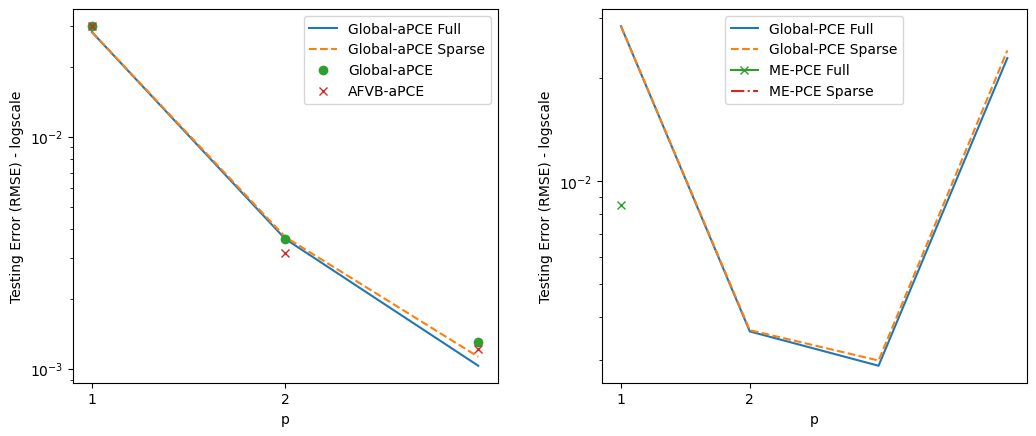

In [1123]:
p = list(range(1,3))

plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(range(1,4), results_WingWeight_VRVM_aPCE_Global[0], '-', label = 'Global-aPCE Full')
ax[0].plot(range(1,4), results_WingWeight_VRVM_aPCE_Global[1], '--', label = 'Global-aPCE Sparse')

ax[0].plot(range(1,4), results_WingWeight_AFVB_aPCE_Global[0], 'o', label = 'Global-aPCE')
ax[0].plot(range(1,4), results_WingWeight_AFVB_aPCE_Global[1], 'x', label = 'AFVB-aPCE')


#ax[0].plot(p, results_WingWeight_VRVM_aPCE_Stieltjes_Global[0], ':', label = 'Global-aPCE_Stieltjes Full')
#ax[0].plot(p, results_WingWeight_VRVM_aPCE_Stieltjes_Global[1], ':', label = 'Global-aPCE_Stieltjes Sparse')
#ax[0].plot(range(1,3), results_WingWeight_VRVM_aPCE_ME[0], '-x', label = 'ME-aPCE Full')
#ax[0].plot(range(1,3), results_WingWeight_VRVM_aPCE_ME[1], '-.', label = 'ME-aPCE Sparse')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RMSE) - logscale")
ax[0].legend()

ax[1].plot(range(1,5), results_WingWeight_VRVM_PCE_Global[0], '-', label = 'Global-PCE Full')
ax[1].plot(range(1,5), results_WingWeight_VRVM_PCE_Global[1], '--', label = 'Global-PCE Sparse')
ax[1].plot(range(1,2), (results_WingWeight_VRVM_PCE_ME[0]), '-x', label = 'ME-PCE Full')
ax[1].plot(range(1,2), (results_WingWeight_VRVM_PCE_ME[1]), '-.', label = 'ME-PCE Sparse')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RMSE) - logscale")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/WingWeight_VRVM_Error.png')

NameError: name 'GSA_WingWeight' is not defined

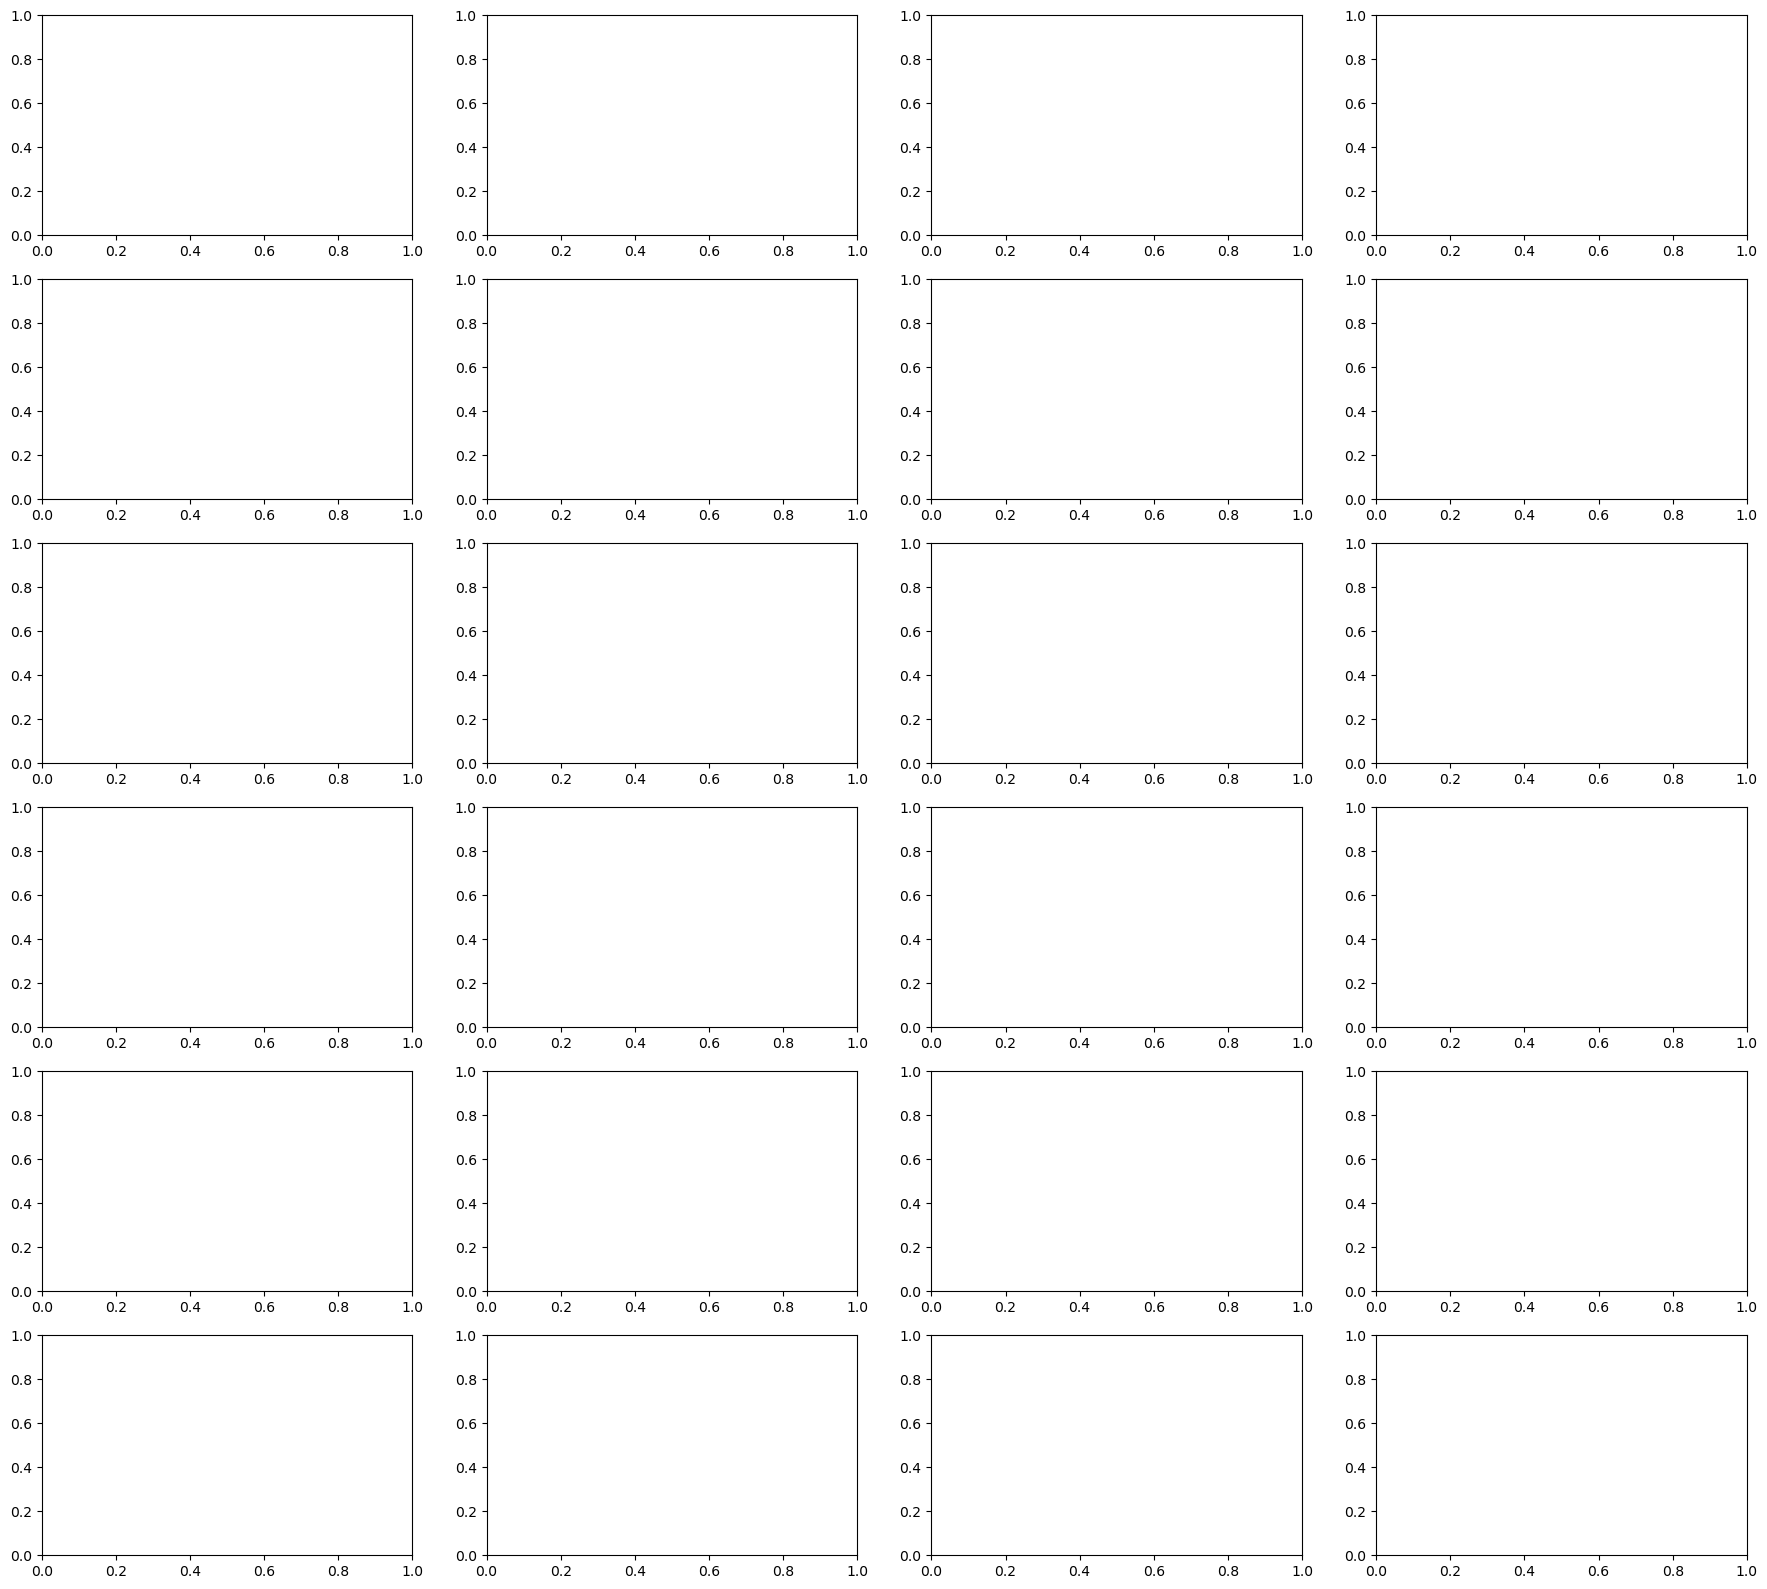

In [365]:
plt.rcParams['figure.figsize'] = (22,20) # (width, height)
fig, ax = plt.subplots(6, 4)
markers = ['-x','-o','-v']

for i in range(4):
    ax[0,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_Global[2])[:,i] - np.array(GSA_WingWeight['1st Order'])[i]), '-', label = 'VRVM-aPCE')  
    #ax[0,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_ME[2])[:,i] - np.array(GSA_WingWeight['1st Order'])[i]), '-.', label = 'ME-VRVM-aPCE') 
    ax[0,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_Global[2])[:,i] - np.array(GSA_WingWeight['1st Order'])[i]), '-x', label = 'VRVM-PCE')  
    #ax[0,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_ME[2])[:,i] - np.array(GSA_WingWeight['1st Order'])[i]), '-.x', label = 'ME-VRVM-PCE') 

    ax[1,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_Global[2])[:,i+4] - np.array(GSA_WingWeight['1st Order'])[i]), '-', label = 'VRVM-aPCE')  
    #ax[1,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_ME[2])[:,i+4] - np.array(GSA_WingWeight['1st Order'])[i]), '-.', label = 'ME-VRVM-aPCE') 
    ax[1,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_Global[2])[:,i+4] - np.array(GSA_WingWeight['1st Order'])[i]), '-x', label = 'VRVM-PCE')  
    #ax[1,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_ME[2])[:,i+4] - np.array(GSA_WingWeight['1st Order'])[i]), '-.x', label = 'ME-VRVM-PCE') 
    
    ax[3,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_Global[3])[:,i] - np.array(GSA_WingWeight['Total Order'])[i]), '-', label = 'VRVM-aPCE')  
    #ax[3,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_ME[3])[:,i] - np.array(GSA_WingWeight['Total Order'])[i]), '-.', label = 'ME-VRVM-aPCE') 
    ax[3,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_Global[3])[:,i] - np.array(GSA_WingWeight['Total Order'])[i]), '-x', label = 'VRVM-PCE')  
    #ax[3,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_ME[3])[:,i] - np.array(GSA_WingWeight['Total Order'])[i]), '-.x', label = 'ME-VRVM-PCE') 

    ax[4,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_Global[3])[:,i+4] - np.array(GSA_WingWeight['Total Order'])[i]), '-', label = 'VRVM-aPCE')  
    #ax[4,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_ME[3])[:,i+4] - np.array(GSA_WingWeight['Total Order'])[i]), '-.', label = 'ME-VRVM-aPCE') 
    ax[4,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_Global[3])[:,i+4] - np.array(GSA_WingWeight['Total Order'])[i]), '-x', label = 'VRVM-PCE')  
    #ax[4,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_ME[3])[:,i+4] - np.array(GSA_WingWeight['Total Order'])[i]), '-.x', label = 'ME-VRVM-PCE') 
    
for i in range(2):
    ax[2,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_Global[2])[:,i+8] - np.array(GSA_WingWeight['1st Order'])[i]), '-', label = 'VRVM-aPCE')  
    #ax[2,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_ME[2])[:,i+8] - np.array(GSA_WingWeight['1st Order'])[i]), '-.', label = 'ME-VRVM-aPCE') 
    ax[2,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_Global[2])[:,i+8] - np.array(GSA_WingWeight['1st Order'])[i]), '-x', label = 'VRVM-PCE')  
    #ax[2,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_ME[2])[:,i+8] - np.array(GSA_WingWeight['1st Order'])[i]), '-.x', label = 'ME-VRVM-PCE') 

    ax[5,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_Global[3])[:,i+8] - np.array(GSA_WingWeight['Total Order'])[i]), '-', label = 'VRVM-aPCE')  
    #ax[5,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_ME[3])[:,i+8] - np.array(GSA_WingWeight['Total Order'])[i]), '-.', label = 'ME-VRVM-aPCE') 
    ax[5,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_Global[3])[:,i+8] - np.array(GSA_WingWeight['Total Order'])[i]), '-x', label = 'VRVM-PCE')  
    #ax[5,i].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_ME[3])[:,i+8] - np.array(GSA_WingWeight['Total Order'])[i]), '-.x', label = 'ME-VRVM-PCE') 
    
for i in range(4):
    for j in range(6):
        ax[j,i].set_xticks(p)
        ax[j,i].set_yscale("log")
        ax[j,i].set_xlabel("p")
        ax[j,i].set_ylabel("Error")
        ax[j,i].legend(fontsize = 'small')

ax[2,2].set_axis_off()
ax[2,3].set_axis_off()
ax[5,2].set_axis_off()
ax[5,3].set_axis_off()


fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/WingWeight_VRVM_GSA.png')

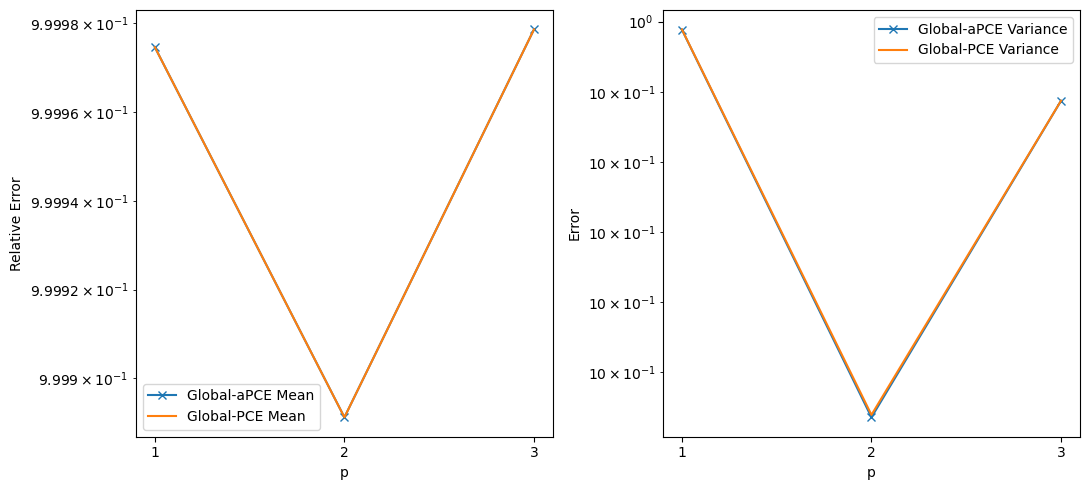

In [398]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_Global[4])-mean_WingWeight)/mean_WingWeight, '-x', label = 'Global-aPCE Mean')
#ax[0].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_ME[4])-mean_WingWeight)/mean_WingWeight, '--', label = 'ME-aPCE Mean')

ax[0].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_Global[4])-mean_WingWeight)/mean_WingWeight, '-', label = 'Global-PCE Mean')
#ax[0].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_ME[4])-mean_WingWeight), '-.', label = 'ME-PCE Mean')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Relative Error")
ax[0].legend()

ax[1].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_Global[5])-V_WingWeight)/V_WingWeight, '-x', label = 'Global-aPCE Variance')
#ax[1].plot(p, np.abs(np.array(results_WingWeight_VRVM_aPCE_ME[5])-V_WingWeight), '--', label = 'ME-aPCE Variance')

ax[1].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_Global[5])-V_WingWeight)/V_WingWeight, '-', label = 'Global-PCE Variance')
#ax[1].plot(p, np.abs(np.array(results_WingWeight_VRVM_PCE_ME[5])-V_WingWeight), '-.', label = 'ME-PCE Variance')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Error")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/WingWeight_VRVM_mean_and_Variance.png')

# Example 4: Flood Model

In [93]:
import openturns as ot
import openturns.viewer as otv
from openturns.usecases import flood_model

In [94]:
N_train = 320 # Sample size
N_test = 80
N_pol = 100000
N_mc = 1000000 #10^6 samples

d = 8

In [95]:
#inputNames = m.distributionX.getDescription()
ot.RandomGenerator.SetSeed(2357)

fm = flood_model.FloodModel()
X_train = np.array(fm.distributionX.getSample(N_train))
X_pol = np.array(fm.distributionX.getSample(N_pol))

Y_train = np.array(fm.model(X_train))
X_test = np.array(fm.distributionX.getSample(N_test))
Y_test = np.array(fm.model(X_test))

X_mc = np.array(fm.distributionX.getSample(N_mc))

AttributeError: 'FloodModel' object has no attribute 'distributionX'

In [97]:
print("Output:", fm.model.getOutputDescription())

Output: [H,S,C]


In [95]:
from sklearn.linear_model import LinearRegression
import math
from itertools import product
from scipy.special import legendre
from scipy.special import hermitenorm
from sklearn.metrics import mean_squared_error
import sys
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aPCE
import AFVB_PCE
import VRVM_PCE
import ME_PCE
from numpy import polynomial as pol
from sympy import symbols, lambdify, diff
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from collections import OrderedDict

In [2]:
import skopt
from skopt import BayesSearchCV

In [3]:
import scipy.integrate as integrate
import scipy.special as special
import time

In [6]:
## Directory where I want the plots saved
wd = '/Users/chave/Desktop/ThesisFiles/SparseBayesianLearning'

# Basis Functions

In [15]:
def multivariate_pce_index(d, max_deg):
    """
    Generate all the d-dimensional polynomial indices with the 
    constraint that the sum of the indexes is <= max_deg

    input:
    d: int, number of random variables
    max_deg: int, the max degree allowed

    return: 
    2d array with shape[1] equal to d, the multivariate indices
    """
    maxRange = max_deg*np.ones(d, dtype = 'int')
    index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])

    return index

In [6]:
def basis(Z, p, PCE_method, aPCE_model = None, P = None, domain = None):
    """
    PCE_method: aPCE or PCE_Legendre
    aPCE_model: mod or None
    P: P or P_Steiltjs or None
    domain: Looks like np.array([[a,b], [a,b], [a,b], ...])
    """
    
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    Phi = np.ones((N, n))
    idx = multivariate_pce_index(d, p)
    
    if (PCE_method == 'aPCE'):
        for i in range(n):
            for j in range(d):
                Phi[:,i] *=  aPCE_model.Pol_eval(P[j][idx[i][j]], Z[:,j])
                
    elif (PCE_method == 'PCE_Legendre'):
        a = domain[:,0]
        b = domain[:,1]
        for i in range(n):
            for j in range(d):
                Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])((a[j]+b[j]-2*Z[:,j])/(a[j]-b[j]))
    else: 
        print('Proper PCE_method not given')
            
    return Phi

# Results Function

In [7]:
def GSA(a, idx, active_cols):
    
    V = np.sum(a[1:]**2)
    V_Partial = []
    V_Total = []
    S_Partial = []
    S_Total = []
    
    l = [0,1,2]
    
    for k in range(d):
        l = list(range(d))
        l.remove(k)
        
        temp = np.full(idx[active_cols].shape[0], True, dtype = bool)
        
        for i in range(idx[active_cols].shape[0]):
            temp[i] = (idx[active_cols][i][k] != 0) & (sum(idx[active_cols][i][l]) == 0)
            
        V_Partial.append(np.sum(a[temp]**2))
        S_Partial.append(np.sum(a[temp]**2)/V)

        for i in range(idx[active_cols].shape[0]):
            temp[i] = idx[active_cols][i][k] != 0

        V_Total.append(np.sum(a[temp]**2))
        S_Total.append(np.sum(a[temp]**2)/V)

        GSA_df = pd.DataFrame({
            #"variable" : list(range(1,d+1)),
            "Partial Variance" : V_Partial,
            "Total Variance" : V_Total,
            "1st Order" : S_Partial,
            "Total Order" : S_Total
        })
    
    
    return V, GSA_df

In [8]:
def Results(X_train, X_test, Y_train, Y_test, model_init, idx):
    
    N_train = X_train.shape[0]
    ## Fitting Model
    t0 = time.time()
    model = model_init.fit(X_train, Y_train.reshape(N_train))
    t_final = time.time() - t0
    
    ## RMSE
    RMSE_full_Train = np.sqrt(mean_squared_error(Y_train, model.predict(X_train, sparse = False)))
    RMSE_sparse_Train = np.sqrt(mean_squared_error(Y_train, model.predict(X_train)))
    
    RMSE_full_Test = np.sqrt(mean_squared_error(Y_test, model.predict(X_test, sparse = False)))
    RMSE_sparse_Test = np.sqrt(mean_squared_error(Y_test, model.predict(X_test)))
    
    data_Error = [[N_pol, model.n_star, RMSE_full_Train, RMSE_sparse_Train, RMSE_full_Test, RMSE_sparse_Test, t_final/60]]
    df_Error = pd.DataFrame(data_Error, columns=['N_pol', 'n_star', 'RMSE_Train_full', 'RMSE_Train_sparse', 'RMSE_Test_full', 'RMSE_Test_sparse', 'time (min)'])

    ## GSA
    V, df_GSA = GSA(model.a_hat, idx, model.active_cols)

    
    return df_Error, df_GSA, model, V

In [9]:
def plot_Error(Error1, Error2, Error3, Error4, scale, scale_label, n):
    temp1 = pd.concat([Error1*scale, Error2*scale], 
                  ignore_index = True, sort = False)[['RMSE_Test_full', 'RMSE_Test_sparse']]
    temp1.index = ['aPCE', 'PCE']

    temp1.columns = (['Full Expansion', 'Sparse Expansion'])
    
    temp2 = pd.concat([Error3*scale, Error4*scale], 
                  ignore_index = True, sort = False)[['RMSE_Test_full', 'RMSE_Test_sparse']]
    temp2.index = ['aPCE', 'PCE']

    temp2.columns = (['Full Expansion', 'Sparse Expansion'])
    
    max_val = np.max(np.array([np.max(temp1.values), np.max(temp2.values)]))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.tight_layout(pad=5.0)
    ax1 = temp1.plot.bar(ax=axes[0], rot = 0, color = ['green', 'red'], fontsize = 15)
    ax1.set_ylim(0, max_val+2)
    ax1.set_title("AFVB", fontsize = 20)
    ax1.text(-0.5,max_val+1.6, scale_label)
    ax1.text(-0.48,max_val+1, 'n =' + str(n), 
             fontsize = 13, color = 'g', weight = 'bold')
    ax1.text(0,np.max(temp1.values)+0.1, 'n* =' + str(np.array(Error1['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax1.text(1,np.max(temp1.values)+0.1, 'n* =' + str(np.array(Error2['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax1.set_ylabel('Testing Error (RMSE)', fontsize = 15);
    
    ax2 = temp2.plot.bar(ax=axes[1], rot = 0, color = ['green', 'red'], fontsize = 15)
    ax2.set_ylim(0, max_val+2)
    ax2.set_title("VRVM", fontsize = 20)
    ax2.text(-0.5,max_val+1.6, scale_label)
    ax2.text(-0.48,max_val+1, 'n =' + str(n), 
             fontsize = 13, color = 'g', weight = 'bold')
    ax2.text(0,np.max(temp2.values)+0.1, 'n* =' + str(np.array(Error3['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax2.text(1,np.max(temp2.values)+0.1, 'n* =' + str(np.array(Error4['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax2.set_ylabel('Testing Error (RMSE)', fontsize = 15);

In [10]:
def plot_Sobol_Indices(GSA1, GSA2, GSA3, GSA4 = None, l = 1, ylimit = 100, fig_size = (6.4, 4.8), table_size = 1):

    
    if GSA4 is None:
        col = ['green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['1st Order']], GSA2[['1st Order']], GSA3[['1st Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Order']], GSA2[['Total Order']], GSA3[['Total Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp.columns = (['MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
    else:
        col = ['red', 'green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['1st Order']], GSA2[['1st Order']], GSA3[['1st Order']], GSA4[['1st Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Order']], GSA2[['Total Order']], GSA3[['Total Order']], GSA4[['Total Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp.columns = (['Analytical', 'MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
        
    
    ax1 = temp.plot.bar(rot = 0, color = col, fontsize = 15, figsize=fig_size)
    ax1.set_ylim(0, ylimit)
    ax1.get_legend().remove()

    #defining the attributes
    col_labels = l
    row_labels = temp.columns
    table_vals = temp.values
    row_colors = col
    #plotting
    my_table = plt.table(cellText = np.round(table_vals.T, 3),
                         colWidths = [0.12]*2*temp.shape[0], 
                         rowLabels = row_labels,
                         colLabels = col_labels,
                         rowColours = row_colors,
                         loc = 'upper right',
                         rowLoc = 'center')
    my_table.scale(table_size, 1.2)

In [11]:
def plot_Variances(GSA1, GSA2, GSA3, V1, V2, V3, V4 = None, GSA4 = None, 
                   l = 1, ylimit = 100, fig_size = (6.4, 4.8), table_size = 1):

    if GSA4 is None:
        V_all = pd.DataFrame([V1, V2, V3])
        col = ['green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['Partial Variance']], GSA2[['Partial Variance']], GSA3[['Partial Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Variance']], GSA2[['Total Variance']], GSA3[['Total Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp = pd.concat([V_all.T, temp], ignore_index = True, sort = False)
        temp.columns = (['MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
    else:
        V_all = pd.DataFrame([V1, V2, V3, V4])
        col = ['red', 'green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['Partial Variance']], GSA2[['Partial Variance']], GSA3[['Partial Variance']], GSA4[['Partial Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Variance']], GSA2[['Total Variance']], GSA3[['Total Variance']], GSA4[['Total Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp = pd.concat([V_all.T, temp], ignore_index = True, sort = False)
        temp.columns = (['Analytical', 'MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
        
    ax1 = temp.plot.bar(rot = 0, color = col, fontsize = 15, figsize=fig_size)
    ax1.set_ylim(0, ylimit)
    ax1.get_legend().remove()

    #defining the attributes
    col_labels = l
    row_labels = temp.columns
    table_vals = temp.values
    row_colors = col
    #plotting
    my_table = plt.table(cellText = np.round(table_vals.T, 3),
                         colWidths = [0.12]*2*temp.shape[0], 
                         rowLabels = row_labels,
                         colLabels = col_labels,
                         rowColours = row_colors,
                         loc = 'upper right',
                         rowLoc = 'center')
    my_table.scale(table_size, 1.2)

## MC Sobol Indices Function

In [12]:
def create_dataAB(dataA, dataB, variable_index_to_fix):
    dataB_withA = dataB.copy()
    dataB_withA[:, variable_index_to_fix] = dataA[:, variable_index_to_fix]
    return dataB_withA

def sobol_indice_1st_and_total_order(model, variable_index, dataA, dataB):

    dataB_withA = create_dataAB(dataA, dataB, variable_index)

    N = len(dataA)

    y_A = model(dataA)
    y_AB = model(dataB_withA)
    y_B = model(dataB)
    V = np.var(model(dataA))

    num_1st_order = N*np.sum(np.multiply(y_A,y_AB)) - (np.sum(y_A)*np.sum(y_AB))
    num_tot = N*np.sum(np.multiply(y_B,y_AB)) - (np.sum(y_A)**2)
    deno = N*np.sum(y_A**2) - (np.sum(y_A))**2

    return np.round(V*num_1st_order/deno, 4), np.round(V*(1 - (num_tot/deno)), 4), np.round(num_1st_order/deno, 4), np.round((1 - (num_tot/deno)), 4), np.round(V, 4)


In [13]:
def create_dataAB(dataA, dataB, variable_index_to_fix):
    dataB_withA = dataB.copy()
    dataB_withA[:, variable_index_to_fix] = dataA[:, variable_index_to_fix]
    return dataB_withA

def sobol_indice_1st_and_total_order(model, variable_index, dataA, dataB):

    dataB_withA = create_dataAB(dataA, dataB, variable_index)

    N = len(dataA)

    y_A = model(dataA)
    y_AB = model(dataB_withA)
    y_B = model(dataB)
    V = np.var(model(dataA))

    num_1st_order = N*np.sum(np.multiply(y_A,y_AB)) - (np.sum(y_A)*np.sum(y_AB))
    num_tot = N*np.sum(np.multiply(y_B,y_AB)) - (np.sum(y_A)**2)
    deno = N*np.sum(y_A**2) - (np.sum(y_A))**2

    return np.round(V*num_1st_order/deno, 4), np.round(V*(1 - (num_tot/deno)), 4), np.round(num_1st_order/deno, 4), np.round((1 - (num_tot/deno)), 4), np.round(V, 4)


def MC_Sobol(fun, dataA, dataB):
    V_partial = []
    V_total = []
    st_order = []
    total = []
    for i in range(d):
        results = sobol_indice_1st_and_total_order(fun, i, dataA, dataB)
        V_partial.append(results[0])
        V_total.append(results[1])
        st_order.append(results[2])
        total.append(results[3])
        V = results[4]

    df_result = pd.DataFrame({
        "Partial Variance" : V_partial,
        "Total Variance" : V_total,
        "1st Order" : st_order,
        "Total Order" : total
        })
    
    return df_result, V

## Variables for AFVB Model

In [14]:
T_ell = 0.001 # T_ell --> threshold value for the VLB (for the error e_ell) in percent
e = 1000

In [15]:
N_train = 320 # Sample size
N_test = 80
N_pol = 1000000
N_mc = 1000000 #10^6 samples

# Example 1: Ishigami Function

In [16]:
d = 3  # d --> number of random variables
#p = 5 # p --> degree of PCE polynomial
#n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [17]:
V_Ishigami = 7**2/8 + 0.1*np.pi**4/5 + 0.1**2*np.pi**8/18 + 1/2
GSA_Ishigami = ([1/2*(1+0.1*np.pi**4/5)**2, 7**2/8, 0],
                [1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225, 7**2/8, 8*0.1**2*np.pi**8/225],
                [1/2*(1+0.1*np.pi**4/5)**2/V_Ishigami, 7**2/8/V_Ishigami, 0],
                [(1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225)/V_Ishigami, 7**2/8/V_Ishigami, 8*0.1**2*np.pi**8/225/V_Ishigami])
GSA_Ishigami = pd.DataFrame(GSA_Ishigami).T
GSA_Ishigami.columns = ['Partial Variance', 'Total Variance', '1st Order', 'Total Order']

## Data

In [1]:
def Ishigami_Function(dat):
    Z = dat
    return np.c_[np.sin(Z[:,0]) + 7*(np.sin(Z[:,1]))**2 + 0.1*(Z[:,2])**4*np.sin(Z[:,0])]

In [19]:
np.random.seed(2357)

N_train = 320 # Sample size
N_test = 80
N_pol = 1000000
N_mc = 1000000 #10^6 samples

X_train = np.random.uniform(-np.pi, np.pi, size=(N_train, d))
X_test = np.random.uniform(-np.pi, np.pi, size=(N_test, d))
Y_train = Ishigami_Function(X_train)
Y_test = Ishigami_Function(X_test)

X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

## MC Estimation of GSA

In [3]:
dataA = pd.DataFrame(np.random.uniform(-np.pi, np.pi, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(-np.pi, np.pi, size=(N_mc, d))).values

#Sobol_MC_Ishigami, V_MC_Ishigami = MC_Sobol(Ishigami_Function, dataA, dataB)

In [4]:
Ishigami_GSA_MC = sa.sobol_GSA(3, Ishigami_Function)

In [5]:
Ishigami_GSA_MC.sobol_MC(dataA, dataB)

Partial Variance  Total Variance  1st Order  Total Order
0          4.333810        7.712377   0.313317     0.557575
1          6.105450        6.131410   0.441400     0.443277
2         -0.005944        3.384606  -0.000430     0.244694

In [127]:
np.random.uniform(-np.pi, np.pi, size=(N_mc, d))

array([[ 2.32038817, -2.64248877,  1.51218932],
       [ 1.5558718 ,  0.04015659,  2.7605449 ],
       [ 2.31657192,  1.95453281, -2.71503011],
       ...,
       [ 2.94590645, -0.36669985, -1.31144166],
       [-2.86912093,  0.56128968,  1.65762951],
       [-2.46470329,  2.44406893, -1.16516297]])

In [97]:
Sobol_MC_Ishigami

Partial Variance  Total Variance  1st Order  Total Order
0            4.3381          7.7274     0.3133       0.5581
1            6.1097          6.1845     0.4413       0.4467
2           -0.0036          3.3918    -0.0003       0.2450

In [98]:
V_MC_Ishigami

13.845

## Tuning of Hyperparameters
### ME-PCE -  Tunning $\theta_1$, $\theta_2$, and $\alpha$

In [21]:
B_init = [[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]
p =[3, 4, 5, 6, 9, 12]

### AFVB-aPCE

In [22]:
param_space_AFVB = {'arg1': skopt.space.Real(0.00001, 0.1), # A_0
              'arg2': skopt.space.Real(0.00001, 0.1), # B_0
              'arg3': skopt.space.Real(0.00001, 0.1), # C_0
              'arg4': skopt.space.Real(0.00001, 0.1) # D_0
         }

In [23]:
param_space_AFVB = {'arg1': skopt.space.Real(0.00001, 0.1), # A_0
              'arg2': skopt.space.Real(0.00001, 0.1), # B_0
              'arg3': skopt.space.Real(0.00001, 0.1), # C_0
              'arg4': skopt.space.Real(0.00001, 0.1) # D_0
         }
param_space_ME = {'theta1': skopt.space.Real(0.00001, 0.9),
              'theta2': skopt.space.Real(0.00001, 0.9),
              'alpha': skopt.space.Real(0.00001, 0.9),
              'arg1': skopt.space.Real(0.00001, 0.1), # A_0
              'arg2': skopt.space.Real(0.00001, 0.1), # B_0
              'arg3': skopt.space.Real(0.00001, 0.1), # C_0
              'arg4': skopt.space.Real(0.00001, 0.1) # D_0
         }

In [74]:
def parameter_values(param_list, t):
    
    param1 = []
    param2 = []
    param3 = []
    param4 = []


    for j in range(t):
        param1.append(list(param_list[j].values())[0])
        param2.append(list(param_list[j].values())[1])
        param3.append(list(param_list[j].values())[2])
        param4.append(list(param_list[j].values())[3])
        
    return param1, param2, param3, param4

In [75]:
def parameter_values_ME(param_list, t):
    
    param1 = []
    param2 = []
    param3 = []
    param4 = []
    param5 = []
    param6 = []
    param7 = []

    for j in range(t):
        param1.append(list(param_list[j].values())[0])
        param2.append(list(param_list[j].values())[1])
        param3.append(list(param_list[j].values())[2])
        param4.append(list(param_list[j].values())[3])
        param5.append(list(param_list[j].values())[4])
        param6.append(list(param_list[j].values())[5])
        param7.append(list(param_list[j].values())[6])
        
    return param1, param2, param3, param4, param5, param6, param7

### Optimizing hyperparameters for the Local ME-aPCE

In [64]:
best_params_AFVB_ME_aPCE = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    t0 = time.time()
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], False, size_restriction = 25, B_split = None),
                                search_spaces = param_space_ME,
                                n_iter = 30,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params_AFVB_ME_aPCE.append(optimizer.best_params_)

103.53456070423127 min
73.30838203430176 min
149.1512567838033 min
119.71496556997299 min


/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)

220.16522312959034 min


/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)

755.6826229691505 min


In [70]:
best_params_AFVB_ME_aPCE

[OrderedDict([('alpha', 0.055667098847903),
              ('arg1', 0.08289707884368987),
              ('arg2', 0.08858728174559408),
              ('arg3', 0.1),
              ('arg4', 0.1),
              ('theta1', 1e-05),
              ('theta2', 1e-05)]),
 OrderedDict([('alpha', 0.8936437375401889),
              ('arg1', 0.03910499037216718),
              ('arg2', 0.024696671382808646),
              ('arg3', 1e-05),
              ('arg4', 0.047981024740018995),
              ('theta1', 0.13010921420875093),
              ('theta2', 0.3999378068670456)]),
 OrderedDict([('alpha', 0.17387606185921553),
              ('arg1', 0.09787864093175196),
              ('arg2', 0.085825873258539),
              ('arg3', 0.09077262764084736),
              ('arg4', 0.0901677983021646),
              ('theta1', 0.22764137820923638),
              ('theta2', 1e-05)]),
 OrderedDict([('alpha', 0.9),
              ('arg1', 1e-05),
              ('arg2', 0.09385359754333601),
              ('arg3'

In [76]:
alpha_AFVB_ME_aPCE,A0_AFVB_ME_aPCE,B0_AFVB_ME_aPCE,C0_AFVB_ME_aPCE,D0_AFVB_ME_aPCE,theta1_AFVB_ME_aPCE,theta2_AFVB_ME_aPCE = parameter_values_ME(best_params_AFVB_ME_aPCE, 6)

In [85]:
Error_AFVB_ME_aPCE_Full = []
Error_AFVB_ME_aPCE_Sparse = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    temp = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], False, theta1_AFVB_ME_aPCE[i], theta2_AFVB_ME_aPCE[i], alpha_AFVB_ME_aPCE[i], 25, None, A0_AFVB_ME_aPCE[i], B0_AFVB_ME_aPCE[i], C0_AFVB_ME_aPCE[i], D0_AFVB_ME_aPCE[i])
    temp.fit(X_train, Y_train)
    temp2 = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], True, theta1_AFVB_ME_aPCE[i], theta2_AFVB_ME_aPCE[i], alpha_AFVB_ME_aPCE[i], 25, temp.B_split, A0_AFVB_ME_aPCE[i], B0_AFVB_ME_aPCE[i], C0_AFVB_ME_aPCE[i], D0_AFVB_ME_aPCE[i])
    temp2.fit(X_train, Y_train)
    print(temp.B_split.shape[0])
    Error_AFVB_ME_aPCE_Full.append(np.sqrt(mean_squared_error(Y_test, temp.predict(X_test, sparse = False))))
    Error_AFVB_ME_aPCE_Sparse.append(np.sqrt(mean_squared_error(Y_test, temp2.predict(X_test, sparse = True))))


8
2
8
8
1
1


### Optimizing $A_0, B_0, C_0, D_0$ for the Global Models

We should optmize these via the ME_PCE method so that we can control the sparsity paramter

In [26]:
best_params_AFVB_Global_aPCE = []

for i in range(len(p)):
    t0 = time.time()
    idx = multivariate_pce_index(d, p[i])
    
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], False, size_restriction = 25, B_split = np.array([B_init])),
                                search_spaces = param_space_AFVB,
                                n_iter = 30,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params_AFVB_Global_aPCE.append(optimizer.best_params_)

10.61694294611613 min
12.222197802861531 min
14.680719284216563 min
17.647820250193277 min
43.223819410800935 min
128.9874982158343 min


In [27]:
best_params_AFVB_Global_aPCE

[OrderedDict([('arg1', 1e-05),
              ('arg2', 0.1),
              ('arg3', 0.07973886571917664),
              ('arg4', 0.023000183742907916)]),
 OrderedDict([('arg1', 1e-05),
              ('arg2', 1e-05),
              ('arg3', 0.02974413597059982),
              ('arg4', 0.1)]),
 OrderedDict([('arg1', 0.08821618341800846),
              ('arg2', 0.09352861638156279),
              ('arg3', 0.061579208159629945),
              ('arg4', 1e-05)]),
 OrderedDict([('arg1', 0.1), ('arg2', 1e-05), ('arg3', 1e-05), ('arg4', 0.1)]),
 OrderedDict([('arg1', 0.09570708156509884),
              ('arg2', 0.07778479383079964),
              ('arg3', 0.09081591258844766),
              ('arg4', 0.03977596507381659)]),
 OrderedDict([('arg1', 0.09646054773386621),
              ('arg2', 1e-05),
              ('arg3', 0.042710863151665446),
              ('arg4', 0.004671815418315312)])]

In [63]:
#?OrderedDict

In [30]:
A0_AFVB_Global_aPCE,B0_AFVB_Global_aPCE,C0_AFVB_Global_aPCE,D0_AFVB_Global_aPCE = parameter_values(best_params_AFVB_Global_aPCE, 6)

In [31]:
Error_AFVB_Global_aPCE_Full = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    mod = aPCE(X_pol, p[i], idx) 
    P = mod.Create_Orthonormal_Polynomials(p[i])
    
    AFVB_model = AFVB_PCE(basis, B_init,'aPCE', mod, P, p[i], A0_AFVB_Global_aPCE[i], B0_AFVB_Global_aPCE[i], C0_AFVB_Global_aPCE[i], D0_AFVB_Global_aPCE[i])
    AFVB_model.fit(X_train, Y_train)
    Error_AFVB_Global_aPCE_Full.append(np.sqrt(mean_squared_error(Y_test, AFVB_model.predict(X_test, sparse = False))))

In [32]:
Error_AFVB_Global_aPCE_Sparse = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    mod = aPCE(X_pol, p[i], idx) 
    P = mod.Create_Orthonormal_Polynomials(p[i])
    
    AFVB_model = AFVB_PCE(basis, B_init, 'aPCE', mod, P, p[i], A0_AFVB_Global_aPCE[i], B0_AFVB_Global_aPCE[i], C0_AFVB_Global_aPCE[i], D0_AFVB_Global_aPCE[i])
    AFVB_model.fit(X_train, Y_train)
    Error_AFVB_Global_aPCE_Sparse.append(np.sqrt(mean_squared_error(Y_test, AFVB_model.predict(X_test, sparse = True))))

In [ ]:
# marker = 'o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd'
# ^ is triangle 
# s is square
# d is diamond

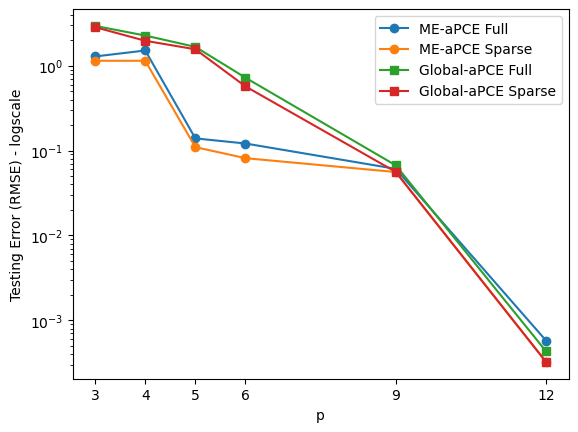

In [81]:
plt.plot(p, Error_AFVB_ME_aPCE_Full, '-o', label = 'ME-aPCE Full')
plt.plot(p, Error_AFVB_ME_aPCE_Sparse, '-o', label = 'ME-aPCE Sparse')
plt.plot(p, Error_AFVB_Global_aPCE_Full, '-s', label = 'Global-aPCE Full')
plt.plot(p, Error_AFVB_Global_aPCE_Sparse, '-s', label = 'Global-aPCE Sparse')
plt.xticks(p)
plt.yscale("log")
plt.xlabel("p")
plt.ylabel("Testing Error (RMSE) - logscale")
plt.legend();

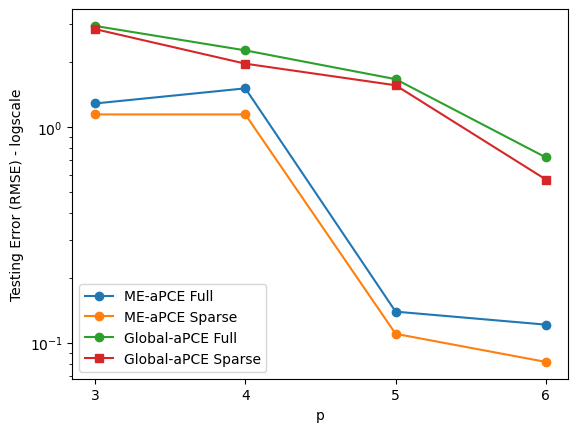

In [86]:
plt.plot(p[:4], Error_AFVB_ME_aPCE_Full[:4], '-o', label = 'ME-aPCE Full')
plt.plot(p[:4], Error_AFVB_ME_aPCE_Sparse[:4], '-o', label = 'ME-aPCE Sparse')
plt.plot(p[:4], Error_AFVB_Global_aPCE_Full[:4], '-o', label = 'Global-aPCE Full')
plt.plot(p[:4], Error_AFVB_Global_aPCE_Sparse[:4], '-s', label = 'Global-aPCE Sparse')
plt.xticks(range(3,7))
plt.yscale("log")
plt.xlabel("p")
plt.ylabel("Testing Error (RMSE) - logscale")
plt.legend();

## Optimizing hyperparameters for PCE

In [139]:
best_params_AFVB_ME_PCE = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    t0 = time.time()
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'PCE_Legendre', p[i], False, size_restriction = 25, B_split = None),
                                search_spaces = param_space_ME,
                                n_iter = 30,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params_AFVB_ME_PCE.append(optimizer.best_params_)

91.02347344954809 min
100.26872749725977 min
147.9976473848025 min
125.91517752011617 min


In [143]:
alpha_AFVB_ME_PCE,A0_AFVB_ME_PCE,B0_AFVB_ME_PCE,C0_AFVB_ME_PCE,D0_AFVB_ME_PCE,theta1_AFVB_ME_PCE,theta2_AFVB_ME_PCE = parameter_values_ME(best_params_AFVB_ME_PCE, 4)


In [145]:
Error_AFVB_Global_PCE_Full = []
Error_AFVB_Global_PCE_Sparse = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    temp = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'PCE_Legendre', p[i], False, theta1_AFVB_ME_PCE[i], theta2_AFVB_ME_PCE[i], alpha_AFVB_ME_PCE[i], 25, None, A0_AFVB_ME_PCE[i], B0_AFVB_ME_PCE[i], C0_AFVB_ME_PCE[i], D0_AFVB_ME_PCE[i])
    temp.fit(X_train, Y_train)
    temp2 = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'PCE_Legendre', p[i], True, theta1_AFVB_ME_PCE[i], theta2_AFVB_ME_PCE[i], alpha_AFVB_ME_PCE[i], 25, temp.B_split, A0_AFVB_ME_PCE[i], B0_AFVB_ME_PCE[i], C0_AFVB_ME_PCE[i], D0_AFVB_ME_PCE[i])
    temp2.fit(X_train, Y_train)
    Error_AFVB_Global_PCE_Full.append(np.sqrt(mean_squared_error(Y_test, temp.predict(X_test, sparse = False))))
    Error_AFVB_Global_PCE_Sparse.append(np.sqrt(mean_squared_error(Y_test, temp2.predict(X_test, sparse = True))))


In [46]:
best_params_AFVB_Global_PCE = []

for i in range(len(p)):
    t0 = time.time()
    idx = multivariate_pce_index(d, p[i])
    
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'PCE_Legendre', p[i], False, size_restriction = 25, B_split = np.array([B_init])),
                                search_spaces = param_space_AFVB,
                                n_iter = 30,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params_AFVB_Global_PCE.append(optimizer.best_params_)

10.809207916259766 min
12.860236267248789 min
15.303425749142965 min
18.994933915138244 min


In [102]:
A0_AFVB_Global_PCE, B0_AFVB_Global_PCE, C0_AFVB_Global_PCE, D0_AFVB_Global_PCE = parameter_values(best_params_AFVB_Global_PCE, 4)

In [82]:
Error_AFVB_Global_PCE_Full = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    
    AFVB_model = AFVB_PCE(basis, np.array(B_init),'PCE_Legendre', None, None, p[i], A0_AFVB_Global_PCE[i], B0_AFVB_Global_PCE[i], C0_AFVB_Global_PCE[i], D0_AFVB_Global_PCE[i])
    AFVB_model.fit(X_train, Y_train)
    Error_AFVB_Global_PCE_Full.append(np.sqrt(mean_squared_error(Y_test, AFVB_model.predict(X_test, sparse = False))))

In [83]:
Error_AFVB_Global_PCE_Sparse = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    
    AFVB_model = AFVB_PCE(basis, np.array(B_init),'PCE_Legendre', None, None, p[i], A0_AFVB_Global_PCE[i], B0_AFVB_Global_PCE[i], C0_AFVB_Global_PCE[i], D0_AFVB_Global_PCE[i])
    AFVB_model.fit(X_train, Y_train)
    Error_AFVB_Global_PCE_Sparse.append(np.sqrt(mean_squared_error(Y_test, AFVB_model.predict(X_test, sparse = True))))

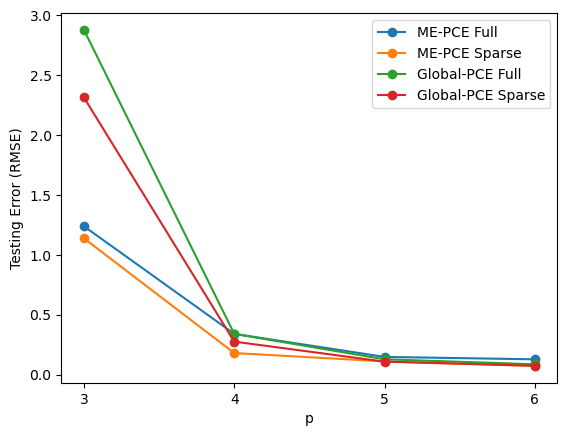

In [157]:
plt.plot(p, Error_MEaPCE_Full, '-o', label = 'ME-PCE Full')
plt.plot(p, Error_MEaPCE_Sparse, '-o', label = 'ME-PCE Sparse')
plt.plot(p, Error_AFVB_Global_PCE_Full, '-o', label = 'Global-PCE Full')
plt.plot(p, Error_AFVB_Global_PCE_Sparse, '-o', label = 'Global-PCE Sparse')
plt.xticks(p)
plt.xlabel("p")
plt.ylabel("Testing Error (RMSE)-logscale")
plt.legend();

In [64]:
best_params = []

for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    t0 = time.time()
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], True, size_restriction = 25),
                                search_spaces = param_space,
                                n_iter = 10,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params.append(optimizer.best_params_)

53.34253256718318 min


/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_v

65.0872655471166 min


In [65]:
best_params

[OrderedDict([('alpha', 0.20391206244448473),
              ('theta1', 0.6858732606158725),
              ('theta2', 0.2209684697392748)]),
 OrderedDict([('alpha', 0.3130196326711137),
              ('theta1', 0.8048727362391627),
              ('theta2', 0.15565739361085668)])]

In [70]:
theta1_aPCE_T = [0.69, 0.80]
theta2_aPCE_T = [0.22, 0.16]
alpha_aPCE_T = [0.20, 0.31]
error_aPCE_T = []

In [71]:
for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], True, theta1_aPCE_T[i], theta2_aPCE_T[i], alpha_aPCE_T[i], 25)
    ME_PCE_Ishigami.fit(X_train, Y_train)
    error_aPCE_T.append(np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test))))

In [66]:
best_params = []

for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    t0 = time.time()
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p[i], False, size_restriction = 25),
                                search_spaces = param_space,
                                n_iter = 10,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params.append(optimizer.best_params_)

39.435804001490276 min
47.60005807876587 min


In [67]:
best_params

[OrderedDict([('alpha', 0.3034680309980036),
              ('theta1', 0.446011507938946),
              ('theta2', 0.27483571983510474)]),
 OrderedDict([('alpha', 0.3539609193921903),
              ('theta1', 0.4574790101877664),
              ('theta2', 0.3899927325545569)])]

In [72]:
theta1_PCE_F = [0.45, 0.46]
theta2_PCE_F = [0.27, 0.39]
alpha_PCE_F = [0.30, 0.35]
error_PCE_F = []

In [73]:
for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p[i], False, theta1_PCE_F[i], theta2_PCE_F[i], alpha_PCE_F[i], 25)
    ME_PCE_Ishigami.fit(X_train, Y_train)
    error_PCE_F.append(np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test))))

In [68]:
best_params = []

for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    t0 = time.time()
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p[i], True, size_restriction = 25),
                                search_spaces = param_space,
                                n_iter = 10,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params.append(optimizer.best_params_)

/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: divide by zero encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: divide by zero encountered in scalar divide
  r_i = float(a

55.55139573415121 min


/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_v

59.875772635142006 min


In [69]:
best_params

[OrderedDict([('alpha', 0.8831283524160606),
              ('theta1', 0.019099222986992872),
              ('theta2', 0.7449926761649771)]),
 OrderedDict([('alpha', 0.19213422023327334),
              ('theta1', 0.7861319339683881),
              ('theta2', 0.830142078391273)])]

In [74]:
theta1_PCE_T = [0.02, 0.79]
theta2_PCE_T = [0.74, 0.83]
alpha_PCE_T = [0.88, 0.19]
error_PCE_T = []

In [75]:
for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p[i], False, theta1_PCE_T[i], theta2_PCE_T[i], alpha_PCE_T[i], 25)
    ME_PCE_Ishigami.fit(X_train, Y_train)
    error_PCE_T.append(np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test))))

In [78]:
mod = aPCE(X_pol, p, idx) 
P = mod.Create_Orthonormal_Polynomials(p)
P_Stieltjes = mod.Create_Orthonormal_Polynomials_Stieltjes(p)

In [79]:
for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis, 'aPCE', mod, P, p[i]), idx)
    print(Error_AFVB_Ishigami)

In [ ]:
error_aPCE_Full = []
error_aPCE_Sparse = []

In [ ]:
for i in range(2);    
    Error_AFVB_Ishigami_PCE, GSA_AFVB_Ishigami_PCE, mod_AFVB_Ishigami_PCE, V_AFVB_Ishigami_PCE = Results(X_train, X_test, Y_train, Y_test, 
            AFVB_PCE(basis, 'PCE', mod, P, p[i]), idx)
    print(Error_AFVB_Ishigami_PCE)

In [ ]:
error_PCE_Full = []
error_PCE_Sparse = []

In [ ]:
# make errors to plot

In [ ]:
error_aPCE_Full = []
error_aPCE_Sparse = []

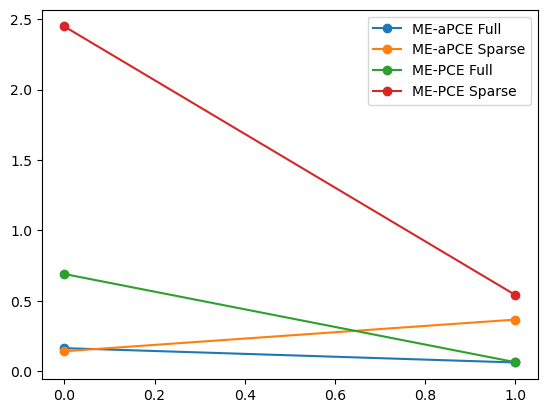

In [76]:
# label x-value as the p-values
plt.plot(error_aPCE_F, 'o-', label = 'ME-aPCE Full')
plt.plot(error_aPCE_T, 'o-', label = 'ME-aPCE Sparse')
plt.plot(error_PCE_F, 'o-', label = 'ME-PCE Full')
plt.plot(error_PCE_T, 'o-', label = 'ME-PCE Sparse')
#plt.plot(error_aPCE_Full, '.-', label = 'aPCE Full')
#plt.plot(error_aPCE_Sparse, '.-', label = 'aPCE Sparse')
#plt.plot(error_PCE_Full, '.-', label = 'PCE Full')
#plt.plot(error_PCE_Sparse, '.-', label = 'PCE Sparse')
plt.legend();

In [ ]:
### change the Legendre domain to the sub-domains as well

### VRVM

I still need to change the code from the VRVM class to accept the modified basis

In [22]:
mod = aPCE(X_pol, p, idx) 
P = mod.Create_Orthonormal_Polynomials(p)
P_Stieltjes = mod.Create_Orthonormal_Polynomials_Stieltjes(p)

In [23]:
Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        SparseVariationalOptimizer(basis, 'PCE', mod, P, p), idx)

In [24]:
Error_AFVB_Ishigami

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000       8         1.459842           1.461564        1.356184   

   RMSE_Test_sparse  time (min)  
0          1.356163    0.025421

In [23]:
t0 = time.time()
optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, B_init, Ishigami_Function, idx, SparseVariationalOptimizer, basis, 'PCE', p, True, size_restriction = 25),
                            search_spaces = param_space,
                            n_iter = 10,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(X_train, Y_train)

print((time.time()-t0)/60, 'min')

/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:103: RuntimeWarning: invalid value encountered in scalar divide
  eta_k = np.sum(a_vec[N_p_1:]**2)/np.sum(a_vec[1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:103: RuntimeWarning: invalid value encountered in scalar divide
  eta_k = np.sum(a_vec[N_p_1:]**2)/np.sum(a_vec[1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:103: RuntimeWarning: invalid value encountered in scalar divide
  eta_k = np.sum(a_vec[N_p_1:]**2)/np.sum(a_vec[1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesi

KeyboardInterrupt: 

In [33]:
mod_AFVB_Ishigami.a_full[mod_AFVB_Ishigami.active_cols].shape

(8,)

## Models and Errors

In [90]:
B_init = [[[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]]

In [93]:
theta1 = [0.9, 0.01, 0.001, 0.0001]
theta2 = [0.9, 0.01, 0.001, 0.0001]
alpha = [0.1, 0.5, 0.9]

In [45]:
for i in range(4):
    for j in range(4):
        for k in range(3):
            ME_PCE_Ishigami = ME_PCE(B_init, Ishigami_Function, idx, AFVB_PCE, basis_Ishigami, 'aPCE', p, sparse = False)
            ME_PCE_Ishigami.fit(X_train, X_pol, theta1 = theta1[i], theta2 = theta2[j], alpha = alpha[k], size_restriction = 25)
            error = np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))
            print('Error =', error, [theta1[i], theta2[j], alpha[k]], 'B_shape =', ME_PCE_Ishigami.B_split.shape[0])

Error = 1.576894845265857 [0.9, 0.9, 0.1] B_shape = 1
Error = 1.576894845265857 [0.9, 0.9, 0.5] B_shape = 1
Error = 1.576894845265857 [0.9, 0.9, 0.9] B_shape = 1
Error = 1.576894845265857 [0.9, 0.01, 0.1] B_shape = 1
Error = 1.576894845265857 [0.9, 0.01, 0.5] B_shape = 1
Error = 1.576894845265857 [0.9, 0.01, 0.9] B_shape = 1
Error = 1.576894845265857 [0.9, 0.001, 0.1] B_shape = 1
Error = 1.576894845265857 [0.9, 0.001, 0.5] B_shape = 1
Error = 1.576894845265857 [0.9, 0.001, 0.9] B_shape = 1
Error = 1.576894845265857 [0.9, 0.0001, 0.1] B_shape = 1
Error = 1.576894845265857 [0.9, 0.0001, 0.5] B_shape = 1
Error = 1.576894845265857 [0.9, 0.0001, 0.9] B_shape = 1
Error = 0.4570825241610843 [0.01, 0.9, 0.1] B_shape = 8
Error = 0.4570825241610843 [0.01, 0.9, 0.5] B_shape = 8
Error = 0.4570825241610843 [0.01, 0.9, 0.9] B_shape = 8
Error = 1.9330960022697807 [0.01, 0.01, 0.1] B_shape = 2
Error = 1.9330960022697807 [0.01, 0.01, 0.5] B_shape = 2
Error = 1.9330960022697807 [0.01, 0.01, 0.9] B_shape

In [ ]:
X_pol, B_init, fun, idx, alg_mod, basis, PCE_method, p = 5, sparse = True, theta1 = 0.001, theta2 = 0.01, alpha = 1/2, size_restriction = 25

In [94]:
for i in range(4):
    for j in range(4):
        for k in range(3):
            ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p, True, theta1 = theta1[i], theta2 = theta2[j], alpha = alpha[k], size_restriction = 25)
            ME_PCE_Ishigami.fit(X_train, Y_train)
            error = np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))
            print('Error =', error, [theta1[i], theta2[j], alpha[k]], 'B_shape =', ME_PCE_Ishigami.B_split.shape[0])

Error = 1.5590055025581158 [0.9, 0.9, 0.1] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.9, 0.5] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.9, 0.9] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.01, 0.1] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.01, 0.5] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.01, 0.9] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.001, 0.1] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.001, 0.5] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.001, 0.9] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.0001, 0.1] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.0001, 0.5] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.0001, 0.9] B_shape = 1
Error = 0.14634206301739172 [0.01, 0.9, 0.1] B_shape = 8
Error = 0.14634206301739172 [0.01, 0.9, 0.5] B_shape = 8
Error = 0.14634206301739172 [0.01, 0.9, 0.9] B_shape = 8
Error = 0.14634206301739172 [0.01, 0.01, 0.1] B_shape = 8
Error = 0.14634206301739172 [0.01, 0.01, 0.5] B_shape = 8
Error = 0.14634206301739172 [0.01, 

In [75]:
for i in range(4):
    for j in range(4):
        for k in range(3):
            ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p, False, theta1 = theta1[i], theta2 = theta2[j], alpha = alpha[k], size_restriction = 25)
            ME_PCE_Ishigami.fit(X_train, Y_train)
            error = np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))
            print('Error =', error, [theta1[i], theta2[j], alpha[k]], 'B_shape =', ME_PCE_Ishigami.B_split.shape[0])

Error = 0.6217471418279746 [0.1, 0.1, 0.1] B_shape = 7
Error = 0.5315668276358553 [0.1, 0.1, 0.5] B_shape = 3
Error = 0.4954049447467795 [0.1, 0.1, 0.9] B_shape = 2
Error = 0.6184937226229411 [0.1, 0.01, 0.1] B_shape = 6
Error = 0.46335189018711737 [0.1, 0.01, 0.5] B_shape = 4
Error = 0.46335189018711737 [0.1, 0.01, 0.9] B_shape = 4
Error = 0.6162870553914445 [0.1, 0.001, 0.1] B_shape = 8
Error = 0.6162870553914445 [0.1, 0.001, 0.5] B_shape = 8
Error = 0.6162870553914445 [0.1, 0.001, 0.9] B_shape = 8
Error = 0.6162870553914445 [0.1, 0.0001, 0.1] B_shape = 8
Error = 0.6162870553914445 [0.1, 0.0001, 0.5] B_shape = 8
Error = 0.6162870553914445 [0.1, 0.0001, 0.9] B_shape = 8
Error = 0.6217471418279746 [0.01, 0.1, 0.1] B_shape = 7
Error = 0.6217471418279746 [0.01, 0.1, 0.5] B_shape = 7
Error = 0.621096594138337 [0.01, 0.1, 0.9] B_shape = 5
Error = 0.6184937226229411 [0.01, 0.01, 0.1] B_shape = 6
Error = 0.6184937226229411 [0.01, 0.01, 0.5] B_shape = 6
Error = 0.6184937226229411 [0.01, 0.01,

KeyboardInterrupt: 

In [74]:
for i in range(4):
    for j in range(4):
        for k in range(3):
            ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p, True, theta1 = theta1[i], theta2 = theta2[j], alpha = alpha[k], size_restriction = 25)
            ME_PCE_Ishigami.fit(X_train, Y_train)
            error = np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))
            print('Error =', error, [theta1[i], theta2[j], alpha[k]], 'B_shape =', ME_PCE_Ishigami.B_split.shape[0])

Error = 0.68430378437914 [0.1, 0.1, 0.1] B_shape = 8
Error = 0.68430378437914 [0.1, 0.1, 0.5] B_shape = 8
Error = 0.68430378437914 [0.1, 0.1, 0.9] B_shape = 8
Error = 0.68430378437914 [0.1, 0.01, 0.1] B_shape = 8
Error = 0.68430378437914 [0.1, 0.01, 0.5] B_shape = 8
Error = 0.68430378437914 [0.1, 0.01, 0.9] B_shape = 8
Error = 0.68430378437914 [0.1, 0.001, 0.1] B_shape = 8
Error = 0.68430378437914 [0.1, 0.001, 0.5] B_shape = 8
Error = 0.68430378437914 [0.1, 0.001, 0.9] B_shape = 8
Error = 0.68430378437914 [0.1, 0.0001, 0.1] B_shape = 8
Error = 0.68430378437914 [0.1, 0.0001, 0.5] B_shape = 8
Error = 0.68430378437914 [0.1, 0.0001, 0.9] B_shape = 8
Error = 0.68430378437914 [0.01, 0.1, 0.1] B_shape = 8
Error = 0.68430378437914 [0.01, 0.1, 0.5] B_shape = 8
Error = 0.68430378437914 [0.01, 0.1, 0.9] B_shape = 8
Error = 0.68430378437914 [0.01, 0.01, 0.1] B_shape = 8
Error = 0.68430378437914 [0.01, 0.01, 0.5] B_shape = 8
Error = 0.68430378437914 [0.01, 0.01, 0.9] B_shape = 8
Error = 0.684303784

In [33]:
mod = aPCE(X_pol, p, idx) 
P = mod.Create_Orthonormal_Polynomials(p)
P_Stieltjes = mod.Create_Orthonormal_Polynomials_Stieltjes(p)

In [47]:
Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis, 'aPCE', mod, P, p), idx)

In [48]:
Error_AFVB_Ishigami

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000       9         1.317248           1.438414         1.62913   

   RMSE_Test_sparse  time (min)  
0          1.456254    0.017873

In [23]:
ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, SparseVariationalOptimizer, basis, 'aPCE', p, False, 0.0001, 0.9, 1/2, 25)
ME_PCE_Ishigami.fit(X_train, Y_train)

In [24]:
### Error
np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))

0.1701655430832387

In [25]:
ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p, True, 0.0001, 0.9, 1/2, 25)
ME_PCE_Ishigami.fit(X_train, Y_train)

In [26]:
### Error
np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))

0.12340794028367318

In [10]:
def split_data(X, B_k):
    'X: data to split'
    'B_k: domains, needs to be an array of size d x 2'
    B_k = np.array(B_k)
    
    N = X.shape[0]
    d = X.shape[1]
    X_k = []
    
    for i in range(N):
        if np.sum((B_k[:,0] <= X[i]) & (X[i] <= B_k[:,1])) == 3:
            X_k.append(list(X[i]))
    return np.c_[np.array(X_k)]

In [11]:
#mod_alg = AFVB_PCE
mod_alg = AFVB_PCE

In [12]:
Ishigami_Function = tf.ishigami

In [16]:
idx = multivariate_pce_index(3, 5)

In [17]:
theta1 = 0.00001
theta2 = 0.9
alpha = 1
p=5

B = [[[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]]
#B = [[[-np.pi, 0], [-np.pi, np.pi], [-np.pi, np.pi]],[[0, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]]

for j in range(5):
    B_k = []
    for k in range(len(B)):
        
        X_p = split_data(X_pol, np.array(B[k]))
        X_t = split_data(X_train, np.array(B[k]))
        Y_t = Ishigami_Function(X_t)

        mod = aPCE(X_p, p) 
        P = mod.Create_Orthonormal_Polynomials(p)

        model = mod_alg('aPCE', d, p = 5, domain = np.array(B[k]), aPCE_model = mod, P = P).fit(X_t, Y_t.reshape(X_t.shape[0]))

        # For each random element k, calculate eta_k and J_k
        N_p_1 = int(math.factorial(d + p-1)/(math.factorial(d)*math.factorial(p-1)))
        eta_k = np.sum(model.a_full[N_p_1:]**2)/np.sum(model.a_full[1:]**2) 
        J_k = 1
        
        for i in range(d):
            J_k *= (B[k][i][1] - B[k][i][0])/(2*np.pi)
        
        r = []
        for i in range(d):
            l = [0]*d
            l[i] = p
            r_i = float(model.a_full[np.nonzero(np.sum(idx == l, 1) == d)])**2/np.sum(model.a_full[N_p_1:]**2)
            r.append(r_i)

        if (eta_k**alpha*J_k >= theta1) & (X_t.shape[0]/2**np.sum(theta2*np.max(r)<=r) >= 25):
        #if (eta_k**alpha*J_k >= theta1): # If this isn't true then we don't split up B_k
            print('Splitting', 'time =', j)
        
            B_temp = []
            print(theta2*np.max(r)<=r, 'k =', k)
            
            for i in range(d):
                if (theta2*np.max(r)<=r[i]):
                    B_temp.append([[B[k][i][0], B[k][i][0] + (B[k][i][1]-B[k][i][0])/2], [B[k][i][0] + (B[k][i][1]-B[k][i][0])/2, B[k][i][1]]])
                else:
                    B_temp.append([B[k][i], B[k][i]])
                    
            for i in range(d):
                if (theta2*np.max(r)<=r[i]):
                    T_p = i
                    break

            B_new = []
            
            T_position = 0
            # Fill B_new with the first element
            if (theta2*np.max(r)<=r[0]):
                for m in range(int(2**(i+1)/2**T_p)):
                    for l in range(int(2**np.sum((theta2*np.max(r)<=r))/(2**(i+1)/2**T_p))):
                        B_new.append([B_temp[0][m%2]])
            else:
                for l in range(int(2**np.sum((theta2*np.max(r)<=r)))):
                    B_new.append([B_temp[0][0]])
            
            # Fill in for the rest of the elements
            for i in range(1,d):
                t = 0
                if (theta2*np.max(r)<=r[i]):
                    for m in range(int(len(B_new)/2**T_position)):
                        for l in range(int(2**T_position)):
                            B_new[t].append(B_temp[i][m%2])
                            t += 1
                    T_position += 1
                else:
                    for l in range(int(2**np.sum((theta2*np.max(r)<=r)))):
                        B_new[t].append(B_temp[i][0])
                        t += 1
            #print(B_new)
            B_k = B_k+B_new

        else:
            print('Not Splitting', 'time =', j, 'k =', k)
            B_new = B[k]
            #print(B_k)
            B_k = B_k+[B_new]
            #print(B_new)
        
    if B == B_k:
        break
    B = B_k.copy()

print(len(B))

Splitting time = 0
[ True False False] k = 0
Splitting time = 1
[False  True  True] k = 0
Splitting time = 1
[False False  True] k = 1
Not Splitting time = 2 k = 0
Not Splitting time = 2 k = 1
Not Splitting time = 2 k = 2
Not Splitting time = 2 k = 3
Splitting time = 2
[False False  True] k = 4
Splitting time = 2
[False False  True] k = 5
Not Splitting time = 3 k = 0
Not Splitting time = 3 k = 1
Not Splitting time = 3 k = 2
Not Splitting time = 3 k = 3
Not Splitting time = 3 k = 4
Not Splitting time = 3 k = 5
Not Splitting time = 3 k = 6
Not Splitting time = 3 k = 7
8


In [18]:
B

[[[-3.141592653589793, 0.0],
  [-3.141592653589793, 0.0],
  [-3.141592653589793, 0.0]],
 [[-3.141592653589793, 0.0],
  [0.0, 3.141592653589793],
  [-3.141592653589793, 0.0]],
 [[-3.141592653589793, 0.0],
  [-3.141592653589793, 0.0],
  [0.0, 3.141592653589793]],
 [[-3.141592653589793, 0.0],
  [0.0, 3.141592653589793],
  [0.0, 3.141592653589793]],
 [[0.0, 3.141592653589793],
  [-3.141592653589793, 3.141592653589793],
  [-3.141592653589793, -1.5707963267948966]],
 [[0.0, 3.141592653589793],
  [-3.141592653589793, 3.141592653589793],
  [-1.5707963267948966, 0.0]],
 [[0.0, 3.141592653589793],
  [-3.141592653589793, 3.141592653589793],
  [0.0, 1.5707963267948966]],
 [[0.0, 3.141592653589793],
  [-3.141592653589793, 3.141592653589793],
  [1.5707963267948966, 3.141592653589793]]]

In [37]:
model_local = []
P_local = []

for k in range(len(ME_PCE_Ishigami.B_split)):
    X_p = split_data(X_pol, ME_PCE_Ishigami.B_split[k])
    X_t = split_data(X_train, ME_PCE_Ishigami.B_split[k])
    print(X_t.shape[0], 'k =', k)
    Y_t = Ishigami_Function(X_t)

    mod = aPCE(X_p, p, idx) 
    P = mod.Create_Orthonormal_Polynomials(p)
    P_local.append(P)

    model = AFVB_PCE(basis_Ishigami, p, 'aPCE', mod).fit(X_t, Y_t.reshape(X_t.shape[0]))
    model_local.append(model)

36 k = 0


KeyboardInterrupt: 

In [40]:
ME_PCE_Ishigami.model_local[0].a_hat

array([[ 1.65297329],
       [ 1.4298195 ],
       [-0.77621001],
       [ 0.22091013],
       [-2.34657485],
       [ 0.73692121],
       [ 0.90691979],
       [-0.69464622],
       [ 0.34050717],
       [-0.08819909]])

In [51]:
for i in range(8):
    print(ME_PCE_Ishigami.model_local[i].a_hat.shape[0])

10
10
12
12
11
10
7
8


In [187]:
Y = np.zeros(X_test.shape[0])
for j in range(Y.shape[0]):
    for i in range(len(B)):
        if np.sum((B[i][:,0] <= X_test[j]) & (X_test[j] <= B[i][:,1])) == 3:
            P = P_local[i]
            Y[j] += model_local[i].predict(X_test[j:j+1], sparse = False)

In [188]:
np.mean(Y)

3.3701823162495956

In [189]:
np.mean(Y_test)

3.3668301094001913

In [190]:
Y

array([ 2.12471097,  4.66306677,  5.08999945,  4.81747481,  1.3560535 ,
        8.5873004 ,  4.27008071,  1.73107471,  0.4368262 ,  0.38627996,
       -0.18254094,  0.17417955, -0.6290512 ,  3.65345499,  6.17233814,
        2.6394742 ,  5.8056285 ,  6.0873554 ,  1.0797263 , -3.05958684,
        2.12833919, -0.87042245,  7.07830351,  4.43888587, -1.35093215,
        5.85243489,  0.57523994,  0.19259811,  2.35325694,  0.8659558 ,
        6.71474008,  2.45894378,  5.4207165 ,  5.04401748,  7.41365467,
       -0.25837579,  1.06920471,  2.53144419, 13.94664161,  2.73922832,
        1.79926854,  5.64893275,  0.78159136,  2.73629155, -0.15851717,
       -1.186637  ,  3.98914363,  1.07597987, -4.09818023,  0.60189927,
        4.80654461,  3.47091221,  1.95635804,  6.9928035 ,  6.60230875,
        4.09555402,  3.98139598,  7.9623679 ,  2.24227132,  3.85273761,
        4.03212749,  9.70053148,  1.30134139,  2.33052246,  7.86691852,
        2.04182525,  3.00236042,  1.28556896,  6.01835861,  5.98

In [27]:
ME_PCE_Ishigami.predict(X_test)

NameError: name 'ME_PCE_Ishigami' is not defined

In [191]:
### Error
np.sqrt(mean_squared_error(Ishigami_Function(X_test), Y))

0.17609461609535684

In [192]:
local_mean = 0
for i in range(B.shape[0]):
    local_mean += model_local[i].a_full[0]
    #print(model_local[i].a_hat[0])
local_mean/B.shape[0]

array([3.77799745])

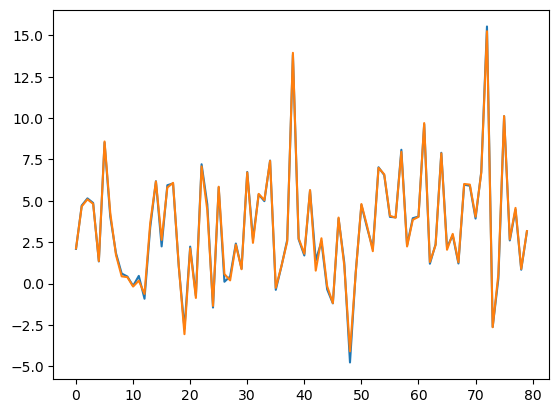

In [193]:
plt.plot(Ishigami_Function(X_test))
plt.plot(Y)

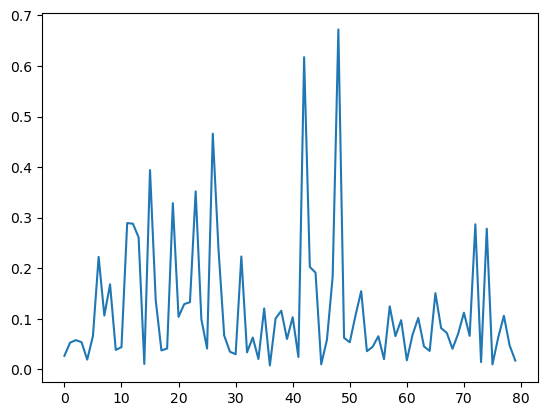

In [194]:
plt.plot(np.abs(Ishigami_Function(X_test)-Y.reshape(X_test.shape[0], 1)))

In [195]:
X_check = X_test[np.where(np.abs(Ishigami_Function(X_test)-Y.reshape(X_test.shape[0], 1))>=1)[0],:]

In [196]:
X_check

array([], shape=(0, 3), dtype=float64)

In [176]:
for i in range(len(B)):
    for j in range(X_check.shape[0]):
        if np.sum((B[i][:,0] <= X_check[j]) & (X_check[j] <= B[i][:,1])) == 3:
            print(i)

In [177]:
B[0]

array([[-3.14159265,  0.        ],
       [-3.14159265,  0.        ],
       [-3.14159265,  3.14159265]])

In [20]:
### comparing with other model
mod = aPCE(X_pol, p, idx) #changed to X_train
P = mod.Create_Orthonormal_Polynomials(p)

In [32]:
mod.Pol_eval(P[0][idx[0][1]],2)

1.0

In [ ]:
Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_Ishigami, 'aPCE', mod, p), idx)

In [ ]:
Error_AFVB_Ishigami

In [27]:
Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_Ishigami, 'PCE', mod, p), idx)

In [28]:
Error_AFVB_Ishigami

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000       8         1.354843           1.450074        1.473719   

   RMSE_Test_sparse  time (min)  
0          1.460269    0.017714

In [22]:
Error_VRVM_Ishigami, GSA_VRVM_Ishigami, mod_VRVM_Ishigami, V_VRVM_Ishigami = Results(X_train, X_test, Y_train, Y_test,
        SparseVariationalOptimizer(basis_Ishigami, p), idx)

TypeError: basis_Ishigami() missing 1 required positional argument: 'method'

In [179]:
Error_VRVM_Ishigami

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000       7         3.035623           3.050702        3.103694   

   RMSE_Test_sparse  time (min)  
0          3.050476     0.01934

In [112]:
A_0 = 0.07700
B_0 = 0.01653
C_0 = 0.04678
D_0 = 0.01422

Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [113]:
Error_AFVB_Ishigami

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  100000      11         0.386049           0.464838        0.794671   

   RMSE_Test_sparse  time (min)  
0          0.584777    0.022354

## AFVB

### Parameter Optimization

In [71]:
param_space = {'A_0': skopt.space.Real(0.000001, 0.1),
              'B_0': skopt.space.Real(0.000001, 0.1),
              'C_0': skopt.space.Real(0.000001, 0.1),
              'D_0': skopt.space.Real(0.000001, 0.1)
         }

t0 = time.time()
optimizer = BayesSearchCV(estimator = AFVB_PCE(basis = basis_aPCE, p = p),
                            search_spaces = param_space,
                            n_iter = 30,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(X_train, Y_train)

print(time.time()-t0)

ValueError: math domain error

In [48]:
optimizer.best_params_

OrderedDict([('A_0', 0.07700216442475019),
             ('B_0', 0.016529139107592992),
             ('C_0', 0.046777431074088646),
             ('D_0', 0.014223674556344384)])

In [49]:
524/60/60

0.14555555555555555

In [38]:
# Best parameters based on CV for p = 12: 
#{'A_0': 0.1, 'B_0': 1e-05, 'C_0' =  0.1, 'D_0': 0.1}
A_0 = 0.07700
B_0 = 0.01653
C_0 = 0.04678
D_0 = 0.01422

Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [39]:
Error_AFVB_Ishigami

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000      22         0.000375           0.002591         0.00463   

   RMSE_Test_sparse  time (min)  
0          0.002943    0.526461

In [40]:
GSA_AFVB_Ishigami

Partial Variance  Total Variance  1st Order  Total Order
0          4.340421        7.711965   0.313710     0.557394
1          6.123795        6.123795   0.442606     0.442606
2          0.000000        3.371544   0.000000     0.243683

In [41]:
GSA_Ishigami

Partial Variance  Total Variance  1st Order  Total Order
0          4.345888        7.719588   0.313905     0.557589
1          6.125000        6.125000   0.442411     0.442411
2          0.000000        3.373700   0.000000     0.243684

In [42]:
# Best parameters based on CV for p = 12: 
#{'A_0': 0.1, 'B_0': 1e-05, 'C_0' =  0.1, 'D_0': 0.1}
A_0 = 0.07700
B_0 = 0.01653
C_0 = 0.04678
D_0 = 0.01422

Error_AFVB_Ishigami_S, GSA_AFVB_Ishigami_S, mod_AFVB_Ishigami_S, V_AFVB_Ishigami_S = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_aPCE_Stieltjes, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [43]:
Error_AFVB_Ishigami_S

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000      22         0.000375           0.002591         0.00463   

   RMSE_Test_sparse  time (min)  
0          0.002943    0.552552

In [44]:
GSA_AFVB_Ishigami_S

Partial Variance  Total Variance  1st Order  Total Order
0          4.340421        7.711965   0.313710     0.557394
1          6.123795        6.123795   0.442606     0.442606
2          0.000000        3.371544   0.000000     0.243683

In [45]:
GSA_Ishigami

Partial Variance  Total Variance  1st Order  Total Order
0          4.345888        7.719588   0.313905     0.557589
1          6.125000        6.125000   0.442411     0.442411
2          0.000000        3.373700   0.000000     0.243684

In [423]:
idx[mod_AFVB_Ishigami.active_cols]

array([[ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  2,  0],
       [ 0,  4,  0],
       [ 0,  6,  0],
       [ 0,  8,  0],
       [ 0, 10,  0],
       [ 0, 12,  0],
       [ 1,  0,  0],
       [ 1,  0,  1],
       [ 1,  0,  2],
       [ 1,  0,  4],
       [ 2,  0,  0],
       [ 2,  0,  2],
       [ 3,  0,  0],
       [ 3,  0,  1],
       [ 3,  0,  2],
       [ 3,  0,  4],
       [ 5,  0,  0],
       [ 5,  0,  2],
       [ 5,  0,  4],
       [ 7,  0,  0],
       [ 7,  0,  2],
       [ 7,  0,  4]])

In [424]:
mod_AFVB_Ishigami.a_hat

array([[ 3.49872328e+00],
       [ 2.38525501e-03],
       [-5.97833203e-01],
       [-1.94703220e+00],
       [ 1.35698960e+00],
       [-3.38892256e-01],
       [ 4.58763024e-02],
       [-3.82986350e-03],
       [ 1.63617333e+00],
       [-4.34994622e-03],
       [ 1.37952630e+00],
       [ 4.10803310e-01],
       [-6.72496244e-03],
       [-5.56399669e-03],
       [-1.29456348e+00],
       [ 2.97279036e-03],
       [-1.09144844e+00],
       [-3.24881090e-01],
       [ 1.95250501e-01],
       [ 1.64101525e-01],
       [ 4.85782676e-02],
       [-1.23883771e-02],
       [-1.00559923e-02],
       [-2.57801434e-03]])

In [30]:
t0 = time.time()
optimizer = BayesSearchCV(estimator = AFVB_PCE(basis = basis_PCE_Ishigami, p = p),
                            search_spaces = param_space,
                            n_iter = 50,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(X_train, Y_train)

print(time.time()-t0)

1894.849053144455


In [31]:
optimizer.best_params_

OrderedDict([('A_0', 0.05428989456568009),
             ('B_0', 0.01834506550270264),
             ('C_0', 0.02201029030700765),
             ('D_0', 0.0015529842047863562)])

In [471]:
# Best parameters based on CV for p = 12: 
# These were based on 320 training data points
# {'A_0': 0.1, 'B_0': 1e-05, 'C_0' =  1e-05, 'D_0': 0.1} 
A_0 = 0.05429
B_0 = 0.01835
C_0 = 0.02201
D_0 = 0.00155

Error_AFVB_PCE_Ishigami, GSA_AFVB_PCE_Ishigami, mod_AFVB_PCE_Ishigami, V_AFVB_PCE_Ishigami = Results(X_train, X_test, Y_train, Y_test,
        AFVB_PCE(basis_PCE_Ishigami, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [472]:
Error_AFVB_PCE_Ishigami

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000      19          0.00029           0.000626        0.000783   

   RMSE_Test_sparse  time (min)  
0          0.000677    0.449014

In [473]:
GSA_AFVB_PCE_Ishigami

Partial Variance  Total Variance  1st Order  Total Order
0          4.345752        7.719416   0.313904     0.557592
1          6.124790        6.124790   0.442408     0.442408
2          0.000000        3.373664   0.000000     0.243688

In [474]:
GSA_Ishigami

Partial Variance  Total Variance  1st Order  Total Order
0          4.345888        7.719588   0.313905     0.557589
1          6.125000        6.125000   0.442411     0.442411
2          0.000000        3.373700   0.000000     0.243684

In [426]:
Error_AFVB_PCE_Ishigami

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000      19         0.000307           0.000647        0.000945   

   RMSE_Test_sparse  time (min)  
0           0.00063    0.475238

In [427]:
idx[mod_AFVB_PCE_Ishigami.active_cols]

array([[ 0,  0,  0],
       [ 0,  2,  0],
       [ 0,  4,  0],
       [ 0,  6,  0],
       [ 0,  8,  0],
       [ 0, 10,  0],
       [ 0, 12,  0],
       [ 1,  0,  0],
       [ 1,  0,  2],
       [ 1,  0,  4],
       [ 3,  0,  0],
       [ 3,  0,  2],
       [ 3,  0,  4],
       [ 5,  0,  0],
       [ 5,  0,  2],
       [ 5,  0,  4],
       [ 7,  0,  0],
       [ 7,  0,  2],
       [ 7,  0,  4]])

In [428]:
mod_AFVB_PCE_Ishigami.a_hat

array([[ 3.49997552e+00],
       [-5.94758074e-01],
       [-1.95227290e+00],
       [ 1.35740954e+00],
       [-3.39352909e-01],
       [ 4.59292673e-02],
       [-3.82851205e-03],
       [ 1.62543858e+00],
       [ 1.37246761e+00],
       [ 4.09254282e-01],
       [-1.29071142e+00],
       [-1.08981270e+00],
       [-3.24946791e-01],
       [ 1.94899570e-01],
       [ 1.64586074e-01],
       [ 4.90202940e-02],
       [-1.25608734e-02],
       [-1.05074850e-02],
       [-2.94910094e-03]])

## VRVM

In [36]:
param_space = {'omega_a': skopt.space.Real(0.000001, 0.1),
              'omega_b': skopt.space.Real(0.000001, 0.1),
              'tau_a': skopt.space.Real(0.000001, 0.1),
              'tau_b': skopt.space.Real(0.000001, 0.1)
         }

In [39]:
t0 = time.time()
optimizer = BayesSearchCV(estimator = SparseVariationalOptimizer(basis = basis_aPCE, p = p),
                            search_spaces = param_space,
                            n_iter = 50,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(data['xi'], data['y'])

print(time.time()-t0)

/Users/chave/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/chave/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2961.5630259513855


In [40]:
optimizer.best_params_

OrderedDict([('omega_a', 0.028509534536848024),
             ('omega_b', 0.04281103620572389),
             ('tau_a', 0.04277575729693283),
             ('tau_b', 0.03615238968778503)])

In [52]:
Error_VRVM_Ishigami, GSA_VRVM_Ishigami, mod_VRVM_Ishigami, V_VRVM_Ishigami = Results(data['xi'], X_test, Y_train, Y_test,
        SparseVariationalOptimizer(basis_aPCE, p, 0.02851, 0.04281, 0.04278, 0.03615, 0.2, 1.0), idx)

In [53]:
Error_VRVM_Ishigami

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000      15         0.043304           0.014534        0.024371   

   RMSE_Test_sparse  time (min)  
0          0.018338    0.217324

In [54]:
Error_VRVM_Ishigami_S, GSA_VRVM_Ishigami_S, mod_VRVM_Ishigami_S, V_VRVM_Ishigami_S = Results(data['xi'], X_test, Y_train, Y_test,
        SparseVariationalOptimizer(basis_aPCE_Stieltjes, p, 0.02851, 0.04281, 0.04278, 0.03615, 0.2, 1.0), idx)

In [55]:
Error_VRVM_Ishigami_S

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000      15         0.043304           0.014534        0.024371   

   RMSE_Test_sparse  time (min)  
0          0.018338     0.21241

In [43]:
t0 = time.time()
optimizer = BayesSearchCV(estimator = SparseVariationalOptimizer(basis = basis_PCE_Ishigami, p = p),
                            search_spaces = param_space,
                            n_iter = 50,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(data['xi'], data['y'])

print(time.time()-t0)

/Users/chave/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2637.820358991623


In [44]:
optimizer.best_params_

OrderedDict([('omega_a', 0.04540549874364945),
             ('omega_b', 0.054319259205855515),
             ('tau_a', 0.08302439423042468),
             ('tau_b', 0.04462844667792927)])

In [477]:
Error_VRVM_PCE_Ishigami, GSA_VRVM_PCE_Ishigami, mod_VRVM_PCE_Ishigami, V_VRVM_PCE_Ishigami = Results(data['xi'], X_test, Y_train, Y_test, 
        SparseVariationalOptimizer(basis_PCE_Ishigami, p, 0.04541, 0.05432, 0.08302, 0.04463, 0.2, 1.0), idx)

In [478]:
Error_VRVM_PCE_Ishigami

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000      15         0.048921           0.015601        0.016979   

   RMSE_Test_sparse  time (min)  
0          0.014962     0.19544

# Plots: Ishigami Function

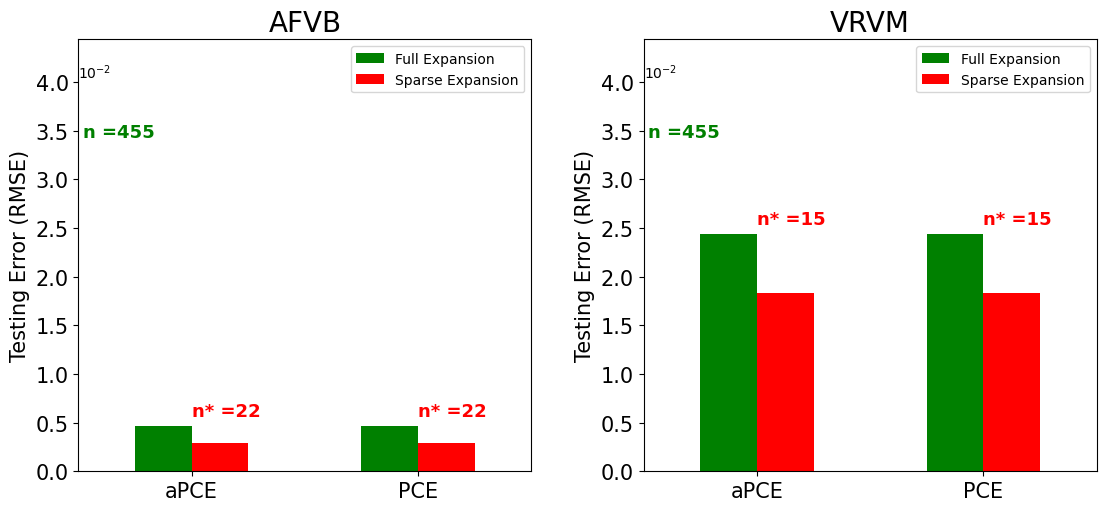

In [56]:
plot_Error(Error_AFVB_Ishigami, Error_AFVB_Ishigami_S, 
           Error_VRVM_Ishigami, Error_VRVM_Ishigami_S,
           100, '$10^{-2}$', mod_AFVB_Ishigami.n)
#plt.savefig(wd + '/RMSE_Ishigami.png')

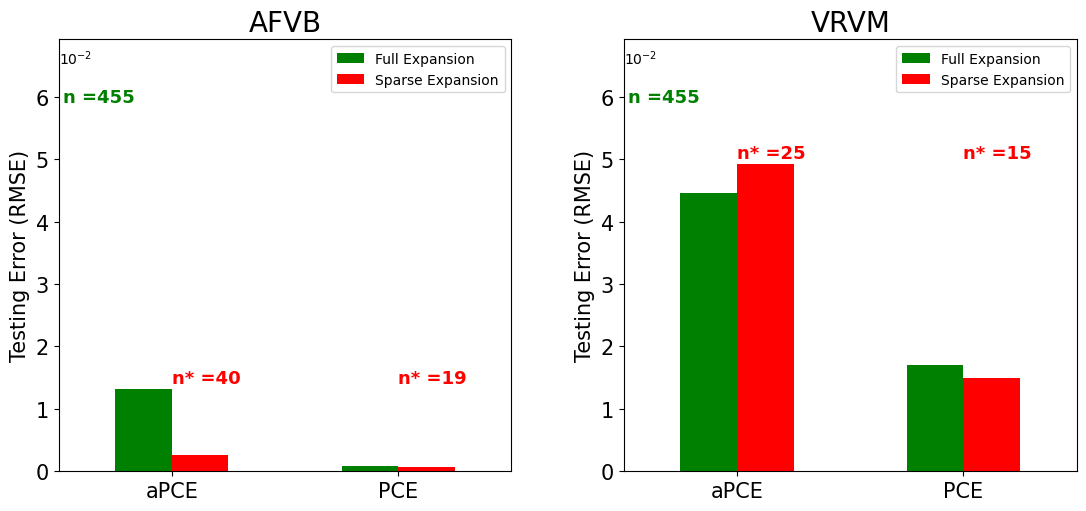

In [479]:
plot_Error(Error_AFVB_Ishigami, Error_AFVB_PCE_Ishigami, 
           Error_VRVM_Ishigami, Error_VRVM_PCE_Ishigami,
           100, '$10^{-2}$', mod_AFVB_Ishigami.n)
#plt.savefig(wd + '/RMSE_Ishigami.png')

# Activity Scores

In [352]:
def Activity_Scores(M, d, grad_fun):
    
    grad = grad_fun(X)
    C = np.zeros((d,d))
    
    for i in range(M):
        grad_i = grad[:,i].reshape((d,1))
        C += 1/M*grad_i@grad_i.T
        
    lam, W = np.linalg.eig(C)
    
    lam_sort = np.sort(lam)[::-1]
    W_sort = W[:,np.argsort(lam)[::-1]]
    
    for i in range(d):
        W_sort[:,i] = np.sign(W_sort[0,i])*W_sort[:,i]
    
    gap_list = np.zeros(d-1)
    for i in range(d-1):
        gap_list[i] = lam_sort[i] - lam_sort[i+1]
    gap_max = np.argmax(gap_list)
    
    alpha = np.zeros(d)
    for i in range(d):
        alpha[i] = np.sum(lam_sort[0:gap_max+1]*W_sort[i,0:gap_max+1]**2)
        
    return W_sort, lam_sort, alpha

In [353]:
def Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B):
    v1 = ((12*R_b2/(R_b1+R_b2) + 0.74)*B*(R_c2 + 9))/(B*(R_c2 + 9) + R_f)
    v2 = 11.35*R_f/(B*(R_c2 + 9) + R_f)
    v3 = 0.74*R_f*B*(R_c2 + 9)/((B*(R_c2 + 9) + R_f)*R_c1)
    return v1+v2+v3

R_b1, R_b2, R_f, R_c1, R_c2, B = symbols('R_b1 R_b2 R_f R_c1 R_c2 B')

V_Rb1 = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), R_b1))
V_Rb2 = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), R_b2))
V_Rf = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), R_f))
V_Rc1 = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), R_c1))
V_Rc2 = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), R_c2))
V_B = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), B))

def grad_Circuit(X):
    
    a_min = [50, 25, 0.5, 1.2, 0.25, 50]
    b_min = [150, 70, 3.0, 2.5, 1.2, 300]
    
    M = X.shape[0]
    d = X.shape[1]
    
    # scale to [a,b]
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    x4 = 0.5*(X[:,3] + 1)*(b_min[3] - a_min[3]) + a_min[3]
    x5 = 0.5*(X[:,4] + 1)*(b_min[4] - a_min[4]) + a_min[4]
    x6 = 0.5*(X[:,5] + 1)*(b_min[5] - a_min[5]) + a_min[5]
    
    # derivative and scale back to [-1,1]
    grad_f = np.zeros((d,M))
    grad_f[0,:] = V_Rb1(x1, x2, x3, x4, x5, x6)*0.5*(b_min[0] - a_min[0])
    grad_f[1,:] = V_Rb2(x1, x2, x3, x4, x5, x6)*0.5*(b_min[1] - a_min[1])
    grad_f[2,:] = V_Rf(x1, x2, x3, x4, x5, x6)*0.5*(b_min[2] - a_min[2])
    grad_f[3,:] = V_Rc1(x1, x2, x3, x4, x5, x6)*0.5*(b_min[3] - a_min[3])
    grad_f[4,:] = V_Rc2(x1, x2, x3, x4, x5, x6)*0.5*(b_min[4] - a_min[4])
    grad_f[5,:] = V_B(x1, x2, x3, x4, x5, x6)*0.5*(b_min[5] - a_min[5])
    
    return grad_f

In [354]:
M = 10000
X = np.random.uniform(-1, 1, (M, 6))
W, lam, alpha = Activity_Scores(M, 6, grad_Circuit)

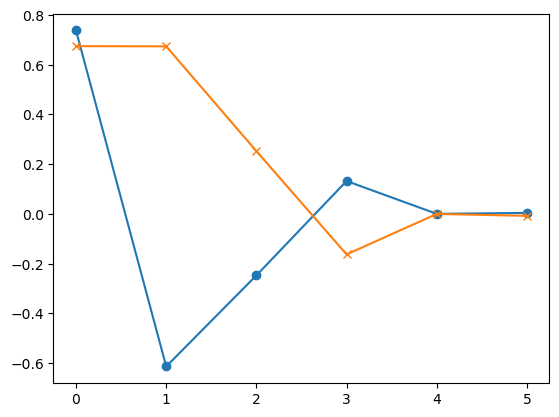

In [355]:
plt.plot(W[:,0],'o-')
plt.plot(W[:,1],'x-');

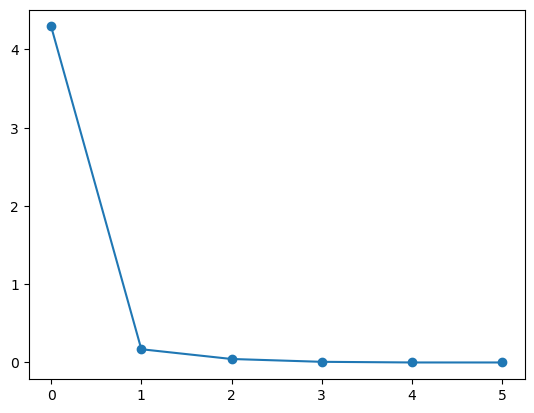

In [356]:
plt.plot(lam,'o-');

In [357]:
alpha

array([2.33696375e+00, 1.61803575e+00, 2.63093558e-01, 7.49293476e-02,
       1.14805546e-07, 6.40140108e-05])

### Ishigami Function

In [358]:
def grad_Ishigami(X):
    'Assuming X~U(-1,1)'
    
    M = X.shape[0]
    d = X.shape[1]
    
    a_min = [-np.pi]*3
    b_min = [np.pi]*3
    
    # change to [-pi,pi]
    x1 = 1/2*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 1/2*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 1/2*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    
    # Derivative and change back to [-1,1]
    grad_f = np.zeros((d, M))
    grad_f[0,:] = (np.cos(x1) + 0.1*x3**4*np.cos(x1))*0.5*(b_min[0] - a_min[0])
    grad_f[1,:] = (14*np.sin(x2)*np.cos(x2))*0.5*(b_min[1] - a_min[1])
    grad_f[2,:] = (0.4*x3**3*np.sin(x1))*0.5*(b_min[2] - a_min[2])
    
    return grad_f

In [390]:
M = 10000
X = np.random.uniform(-1, 1, (M, 3))
W_Ishigami, lam_Ishigami, alpha_Ishigami = Activity_Scores(M, 3, grad_Ishigami)

In [391]:
alpha_Ishigami

array([7.58037373e-02, 2.41776054e+02, 1.64051178e-03])

### aPCE

In [392]:
def Pol_eval(coeff, x):
    """
    Evaluates a polynomial at the value x.
    Polynomial is assumed to be in the form: c_0 + c_1*x + ... + c_n*x^n

    """

    val = 0
    for i in range(coeff.shape[0]):
        val += coeff[i]*x**i

    return val

In [393]:
def grad_Ishigami_aPCE(X):
    "Z ~ U(-1, 1)"
    
    M = X.shape[0]
    d = X.shape[1]
    
    a_min = [X_train[:,0].min(), X_train[:,1].min(), X_train[:,2].min()]
    b_min = [X_train[:,0].max(), X_train[:,1].max(), X_train[:,2].max()]
    
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    
    n_star = a_hat.shape[0]
    grad_f = np.zeros((d,M))
    for i in range(n_star):
        grad_f[0,:] += a_hat[i][0]*\
                     Pol_eval(np.polyder((P[0][idx_star[i][0]])[::-1])[::-1], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)
            
        grad_f[1,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(np.polyder((P[1][idx_star[i][1]])[::-1])[::-1], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)
        
        grad_f[2,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(np.polyder((P[2][idx_star[i][2]])[::-1])[::-1], x3)
    
    grad_f[0,:] *= 0.5*(b_min[0] - a_min[0])
    grad_f[1,:] *= 0.5*(b_min[1] - a_min[1])
    grad_f[2,:] *= 0.5*(b_min[2] - a_min[2])
    return grad_f


In [394]:
idx_star = idx[mod_AFVB_Ishigami.active_cols]
a_hat = mod_AFVB_Ishigami.a_hat
W_aPCE, lam_aPCE, alpha_aPCE = Activity_Scores(M, 3, grad_Ishigami_aPCE)

In [395]:
alpha_aPCE

array([7.18490098e-02, 2.40495772e+02, 9.66593024e-04])

### PCE

In [396]:
def grad_Ishigami_PCE(X):
    "Z ~ U(-1, 1)"
    
    a_min = [-np.pi]*3
    b_min = [np.pi]*3
    
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    
    n_star = a_hat.shape[0]
    grad_f = np.zeros((d,M))
    for i in range(n_star):
        grad_f[0,:] += a_hat[i][0]*\
                     math.sqrt((2*idx_star[i][0]+1)/1)*Pol_eval(np.polyder(np.array(legendre(idx_star[i][0])))[::-1], x1/np.pi)*\
                     math.sqrt((2*idx_star[i][1]+1)/1)*legendre(idx_star[i][1])(x2/np.pi)*\
                     math.sqrt((2*idx_star[i][2]+1)/1)*legendre(idx_star[i][2])(x3/np.pi)
            
        grad_f[1,:] += a_hat[i][0]*\
             math.sqrt((2*idx_star[i][0]+1)/1)*legendre(idx_star[i][0])(x1/np.pi)*\
             math.sqrt((2*idx_star[i][1]+1)/1)*Pol_eval(np.polyder(np.array(legendre(idx_star[i][1])))[::-1], x2/np.pi)*\
             math.sqrt((2*idx_star[i][2]+1)/1)*legendre(idx_star[i][2])(x3/np.pi)
        
        grad_f[2,:] += a_hat[i][0]*\
             math.sqrt((2*idx_star[i][0]+1)/1)*legendre(idx_star[i][0])(x1/np.pi)*\
             math.sqrt((2*idx_star[i][1]+1)/1)*legendre(idx_star[i][1])(x2/np.pi)*\
             math.sqrt((2*idx_star[i][2]+1)/1)*Pol_eval(np.polyder(np.array(legendre(idx_star[i][2])))[::-1], x3/np.pi)
    
    #grad_f[0] *= 0.5*(b_min[0] - a_min[0])
    #grad_f[1] *= 0.5*(b_min[1] - a_min[1])
    #grad_f[2] *= 0.5*(b_min[2] - a_min[2])
    return grad_f

In [397]:
idx_star = idx[mod_AFVB_PCE_Ishigami.active_cols]
a_hat = mod_AFVB_PCE_Ishigami.a_hat
W_PCE, lam_PCE, alpha_PCE = Activity_Scores(M, 3, grad_Ishigami_PCE)

In [398]:
alpha_PCE

array([7.58145106e-02, 2.41774598e+02, 1.66025622e-03])

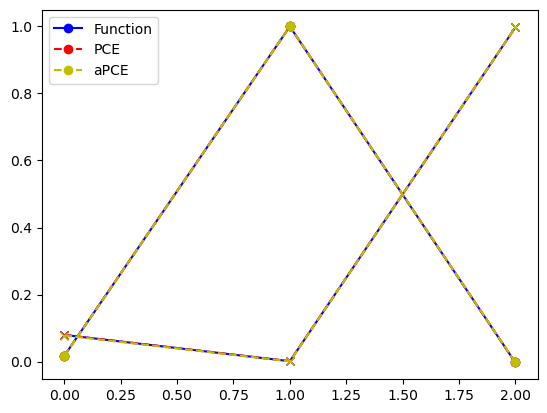

In [400]:
plt.plot(W_Ishigami[:,0],'o-', c = 'b', label = 'Function')
plt.plot(W_Ishigami[:,1],'x-', c = 'b')
plt.plot(W_PCE[:,0],'o--', c = 'r', label = 'PCE')
plt.plot(W_PCE[:,1],'x--', c = 'r')
plt.plot(W_aPCE[:,0],'o--', c = 'y', label = 'aPCE')
plt.plot(W_aPCE[:,1],'x--', c = 'y')
plt.legend()

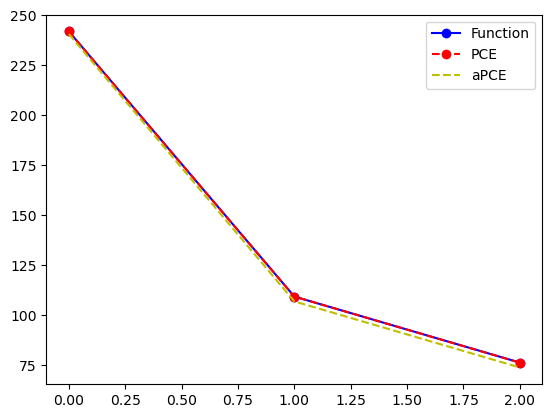

In [401]:
plt.plot(lam_Ishigami,'o-', c = 'b', label = 'Function')
plt.plot(lam_PCE,'o--', c = 'r', label = 'PCE')
plt.plot(lam_aPCE,'--', c = 'y', label = 'aPCE')
plt.legend()

In [402]:
alpha_df = pd.DataFrame([alpha_Ishigami, alpha_PCE, alpha_aPCE]).T

In [403]:
alpha_df.index = ['$a_1$', '$a_2$', '$a_3$']
alpha_df.columns = ['Function', 'PCE', 'aPCE']
alpha_df

Function         PCE        aPCE
$a_1$    0.075804    0.075815    0.071849
$a_2$  241.776054  241.774598  240.495772
$a_3$    0.001641    0.001660    0.000967

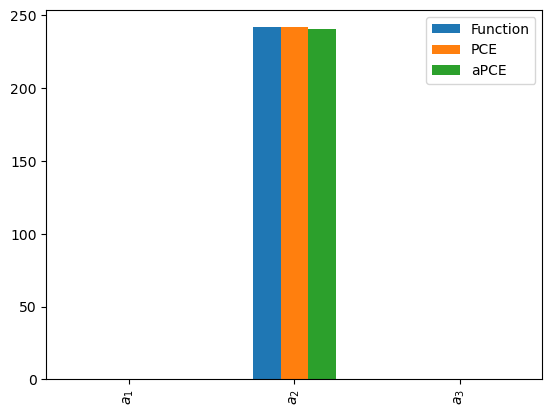

In [404]:
alpha_df.plot.bar();

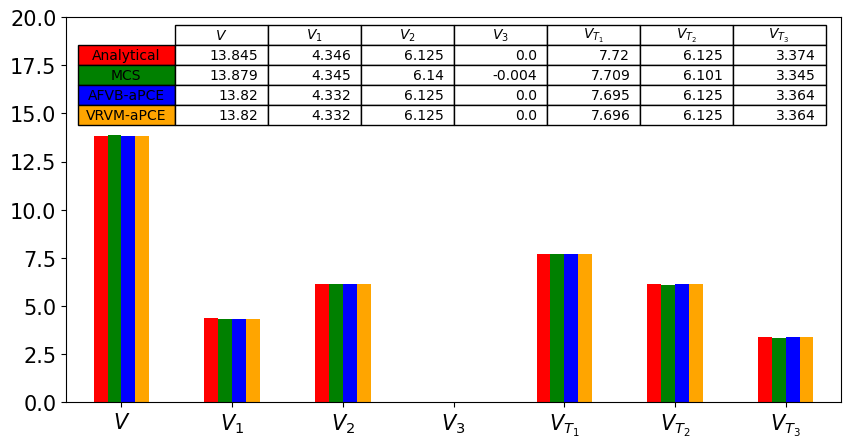

In [97]:
l = ['$V$', '$V_1$', '$V_2$','$V_3$', '$V_{T_1}$','$V_{T_2}$','$V_{T_3}$']
plot_Variances(GSA_Ishigami, Sobol_MC_Ishigami, GSA_AFVB_Ishigami, 
               V_Ishigami, V_MC_Ishigami, V_AFVB_Ishigami, V_VRVM_Ishigami,
               GSA_VRVM_Ishigami, l, 20, (10,5), 1);
#plt.savefig(wd + '/Variances_Ishigami.png')

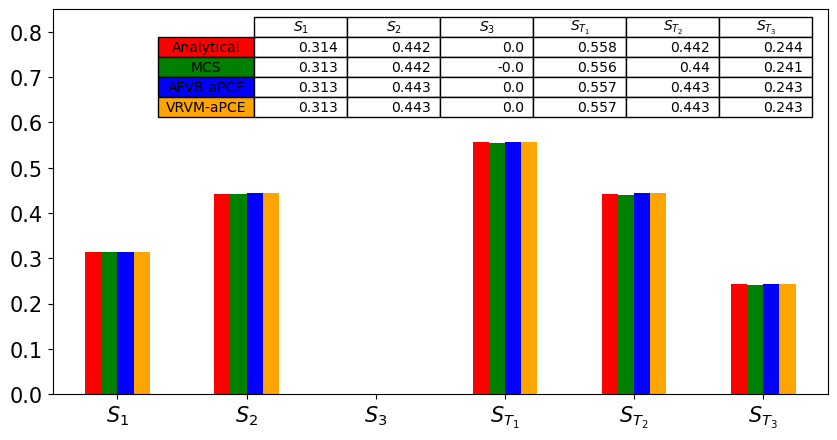

In [98]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$']
plot_Sobol_Indices(GSA_Ishigami, Sobol_MC_Ishigami, 
           GSA_AFVB_Ishigami, GSA_VRVM_Ishigami, l, 0.85, (10,5), 1);
#plt.savefig(wd + '/GSA_Ishigami.png')

### For the following plots we can:
* Plot the full expansion coefficients with the sparse expansion coefficients
* Plot the coeffients of both sparse models, AFVB and VRVM
* Plot the coefficients of one model for PCE and aPCE

Question: Why plot the x-axis with a log scale?

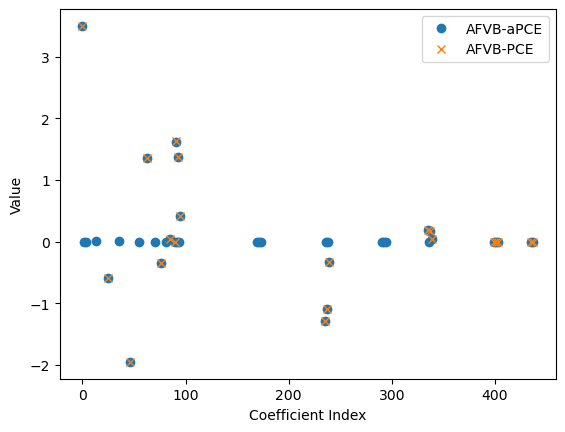

In [99]:
plt.plot(mod_AFVB_Ishigami.active_cols, mod_AFVB_Ishigami.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Ishigami.active_cols, mod_AFVB_PCE_Ishigami.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Ishigami.png')

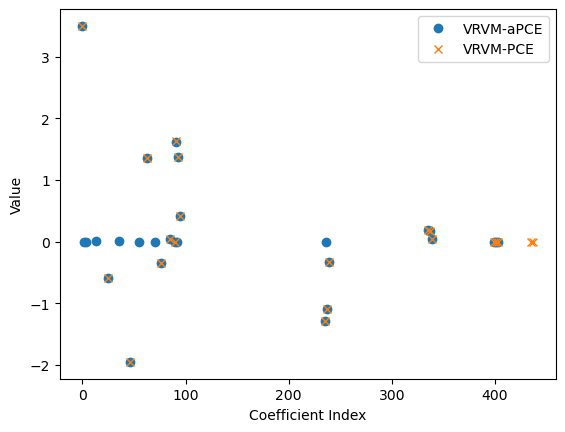

In [100]:
plt.plot(mod_VRVM_Ishigami.active_cols, mod_VRVM_Ishigami.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Ishigami.active_cols, mod_VRVM_PCE_Ishigami.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Ishigami.png')

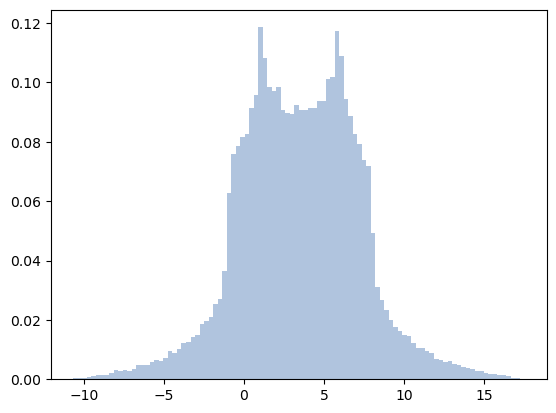

In [292]:
plt.hist(Ishigami_Function(X_dens).reshape(N_dens), density = True, bins = 100, color = 'lightsteelblue', label='Ishigmai Function')
#sns.kdeplot((mod_AFVB_Ishigami.predict(X_dens, mod_AFVB_Ishigami.active_cols)).reshape(N_dens), 
#            lw=2, color='r', label='AFVB-aPCE')
#sns.kdeplot((mod_VRVM_Ishigami.predict(X_dens, mod_VRVM_Ishigami.active_cols)).reshape(N_dens), 
#            lw=2, linestyle="--", color='g', label='VRVM-aPCE')
#plt.legend();
plt.savefig(wd + '/Density_Ishigami.png')

## Running with different values of N_pol

In [15]:
np.random.seed(100)

N_pol = N_train
X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

Res_Error, Res_GSA, mod_save = Results(Ishigami_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)


N_pol_ls = [5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]


for i in N_pol_ls:
    N_pol = i

    X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

    mod = aPCE(X_pol, p, idx)
    P = mod.Create_Orthonormal_Polynomials(p)

    Res1, Res2, mod_save = Results(Ishigami_Function, X_train, X_test, 
            AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)
    
    Res_Error = pd.concat([Res_Error, Res1], ignore_index = True, sort = False)
    Res_GSA = pd.concat([Res_GSA, Res2], ignore_index = True, sort = False)

In [16]:
Res_Error

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0       320      49         0.000081           0.000315        0.000837   
1      5000      45         0.000081           0.000298        0.000749   
2     10000      44         0.000091           0.000273        0.000748   
3     50000      46         0.000091           0.000275        0.000722   
4    100000      44         0.000087           0.000270        0.000763   
5    500000      43         0.000095           0.000280        0.000716   
6   1000000      42         0.000092           0.000278        0.000662   
7   5000000      37         0.000089           0.000275        0.000689   
8  10000000      35         0.000092           0.000296        0.000721   

   RMSE_Test_sparse  time (min)  
0          0.000669    0.852478  
1          0.000650    0.640837  
2          0.000650    0.773641  
3          0.000649    0.783967  
4          0.000567    0.820247  
5          0.000587    0.999585  
6          0.000563    1.306579  
7          0.000553    1.434395  
8          0.000552    1.278801

In [17]:
Res_GSA

0         1         2             3         4         5         6   \
0  14.332465  4.399501  6.370637  2.483159e-03  7.959345  6.370637  3.562328   
1  14.116932  4.482868  6.094916  1.179173e-07  8.022015  6.094916  3.539147   
2  13.773153  4.383211  6.004761  8.230918e-05  7.768310  6.004761  3.385182   
3  13.804783  4.337431  6.115694  7.273424e-05  7.689016  6.115694  3.351658   
4  13.862851  4.362146  6.131230  8.412202e-06  7.731613  6.131230  3.369475   
5  13.853779  4.350173  6.127986  1.849383e-08  7.725793  6.127986  3.375620   
6  13.857016  4.350884  6.129607  5.466956e-07  7.727409  6.129607  3.376526   
7  13.840739  4.343700  6.123285  1.120902e-06  7.717454  6.123285  3.373755   
8  13.850794  4.349116  6.124486  1.455865e-07  7.726307  6.124486  3.377192   

         7         8             9         10        11        12  
0  0.306960  0.444490  1.732542e-04  0.555337  0.444490  0.248550  
1  0.317553  0.431745  8.352898e-09  0.568255  0.431745  0.250702  
2  0.318243  0.435976  5.976059e-06  0.564018  0.435976  0.245781  
3  0.314198  0.443013  5.268771e-06  0.556982  0.443013  0.242790  
4  0.314664  0.442278  6.068161e-07  0.557722  0.442278  0.243058  
5  0.314006  0.442333  1.334930e-09  0.557667  0.442333  0.243661  
6  0.313984  0.442347  3.945262e-08  0.557653  0.442347  0.243669  
7  0.313834  0.442410  8.098572e-08  0.557590  0.442410  0.243755  
8  0.313998  0.442176  1.051106e-08  0.557824  0.442176  0.243827

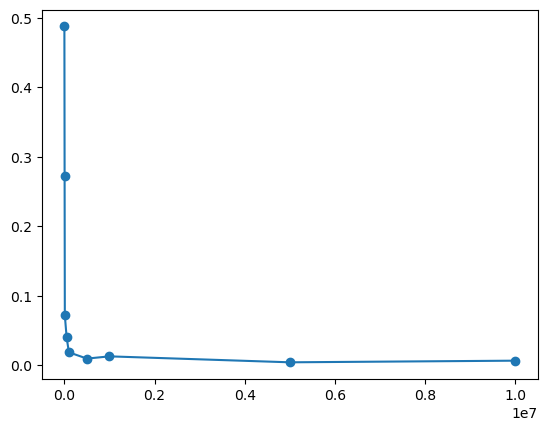

In [18]:
plt.plot(Res_Error['N_pol'], np.abs(Res_GSA[0]-GSA_Ishigami[0]), 'o-')

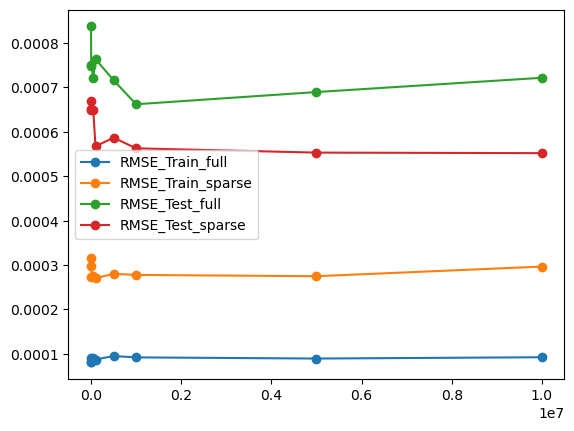

In [19]:
plt.plot(Res_Error['N_pol'], Res_Error[['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse']], 'o-',
        label = ['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse'])
plt.legend();

## Running with different values of N_pol

In [21]:
np.random.seed(100)

N_pol = 1000
X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

Res_Error, Res_GSA = Results(Ishigami_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)


N_pol_ls = [5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]


for i in N_pol_ls:
    N_pol = i

    X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))
    mod = aPCE(X_pol, p, idx)
    P = mod.Create_Orthonormal_Polynomials(p)

    Res1, Res2 = Results(Ishigami_Function, X_train, X_test, 
            SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)
    
    Res_Error = pd.concat([Res_Error, Res1], ignore_index = True, sort = False)
    Res_GSA = pd.concat([Res_GSA, Res2], ignore_index = True, sort = False)

KeyboardInterrupt: 

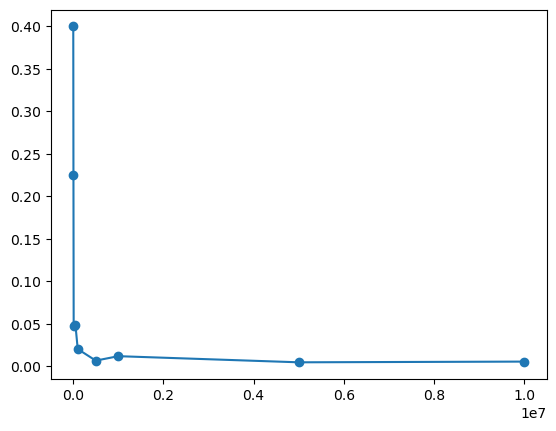

In [25]:
plt.plot(Res_Error['N_pol'], np.abs(Res_GSA[0]-GSA_Ishigami[0]), 'o-');

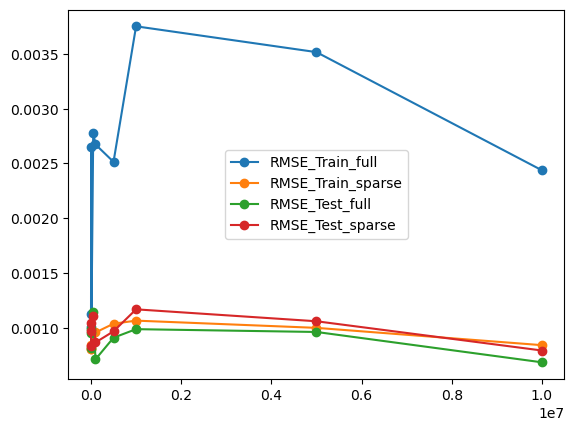

In [26]:
plt.plot(Res_Error['N_pol'], Res_Error[['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse']], 'o-',
        label = ['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse'])
plt.legend();

# Example 2: Morris Function
The morris function is given as

$$
Y = b_0 + \sum_{i=1}^{20}b_i \omega_i + \sum_{i<j}^{20}b_{ij}\omega_i\omega_j + \sum_{1<j<l}^{20}b_{ijl}\omega_i\omega_j\omega_l + \sum_{i<j<l<s}^{20}b_{ijls}\omega_i\omega_j\omega_l\omega_s
$$
where
$$
\omega_i = \left\{
        \begin{array}{ll}
            \frac{2.2X_i}{X_i+0.1} - 1 & \quad \text{if } i=3,5,7 \\
            2X_i - 1 & \quad \text{otherwise}
        \end{array}
    \right.
$$
The coefficients are given by

* $X_i \sim \mathcal{U}(0,1)$ for $i=1,\dots,20$
* $b_i = 20$ for $i=1,\dots, 10$
* $b_{ij} = -15$ for $i,j=1,\dots, 6 \phantom{xx} i<j$
* $b_{ijl} = -10$ for $i,j,l = 1,\dots, 5 \phantom{xx} i<j<l$
* $b_{ijls} = 5$ for $i,j,l,s = 1,\dots, 4 \phantom{xx} i<j<l<s$

The remaining coefficients are defined by

* $b_0 = 0$
* $b_i = (-1)^i$
* $b_{ij} = (-1)^{i+j}$
* 0 for all other

In [23]:
d = 20  # d --> number of random variables
p = 5 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [24]:
n

53130

In [25]:
def Morris_Function(X):
    
    N = X.shape[0]
    d = X.shape[1]
    # Making indexes for the sums
    index2 = []
    for j in range(1,20):
        for i in range(j):
            index2.append([i,j])
    index2 = np.array(index2)
    
    index3 = []
    for l in range(2,5):
        for j in range(1,l):
            for i in range(j):
                index3.append([i,j,l])
    index3 = np.array(index3)
    
    # Creating omega
    omega = np.zeros((N, d))
    for i in range(d):
        omega[:,i] = 2*X[:,i] - 1
    for i in [2,4,6]:
        omega[:,i] = 2.4*X[:,i]/(X[:,i] + 1) - 1
        
    # Sum with one index
    s1_1_to_10 = np.sum(20*omega[:,0:10], axis = 1)
    s1_11_to_20 = np.sum(omega[:,10:20], axis = 1)

    s1 = s1_1_to_10 + s1_11_to_20
    
    # Sum with two index
    s2_1_to_6 = np.zeros(N)
    s2_7_to_20 = np.zeros(N)
    for k in range(index2.shape[0]):
        if index2[k][1] <= 5:
            s2_1_to_6 += -15*omega[:,index2[k][0]]*omega[:,index2[k][1]]
        else:
            s2_7_to_20 += (-1)**(index2[k][0] + index2[k][1] + 2)\
            *omega[:,index2[k][0]]*omega[:,index2[k][1]]

    s2 = s2_1_to_6 + s2_7_to_20
    
    # Sum with three index
    s3 = np.zeros(N)
    for k in range(index3.shape[0]):
        s3 += (-10)*omega[:,index3[k][0]]*omega[:,index3[k][1]]*omega[:,index3[k][2]]
    
    # Sum with four index
    s4 = 5*omega[:,0]*omega[:,1]*omega[:,2]*omega[:,3]
    
    return s1 + s2 + s3 + s4

In [26]:
#np.random.seed(123)
X_train = np.random.uniform(0, 1, size=(N_train, d))
X_test = np.random.uniform(0, 1, size=(N_test, d))
X_pol = np.random.uniform(0, 1, size=(N_pol, d))

Y_train = Morris_Function(X_train)
Y_test = Morris_Function(X_test)

In [ ]:
idx = multivariate_pce_index(d, p)

In [ ]:
def multivariate_pce_index(d, max_deg):
    """
    Generate all the d-dimensional polynomial indices with the 
    constraint that the sum of the indexes is <= max_deg

    input:
    d: int, number of random variables
    max_deg: int, the max degree allowed

    return: 
    2d array with shape[1] equal to d, the multivariate indices
    """
    maxRange = max_deg*np.ones(d, dtype = 'int')
    index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])

    return index

In [34]:
multivariate_pce_index(20, 2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 2],
       ...,
       [3, 0, 1, ..., 0, 0, 0],
       [3, 1, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0]])

In [32]:
multivariate_pce_index(5, 4)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 2],
       [0, 0, 0, 0, 3],
       [0, 0, 0, 0, 4],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 1, 2],
       [0, 0, 0, 1, 3],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 2, 1],
       [0, 0, 0, 2, 2],
       [0, 0, 0, 3, 0],
       [0, 0, 0, 3, 1],
       [0, 0, 0, 4, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 0, 2],
       [0, 0, 1, 0, 3],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 2],
       [0, 0, 1, 2, 0],
       [0, 0, 1, 2, 1],
       [0, 0, 1, 3, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 2, 0, 1],
       [0, 0, 2, 0, 2],
       [0, 0, 2, 1, 0],
       [0, 0, 2, 1, 1],
       [0, 0, 2, 2, 0],
       [0, 0, 3, 0, 0],
       [0, 0, 3, 0, 1],
       [0, 0, 3, 1, 0],
       [0, 0, 4, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 1, 0, 0, 2],
       [0, 1, 0, 0, 3],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1],
       [0, 1, 0,

In [37]:
x = list(range(4))
[j for j in product(x, repeat = 12)]

[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0),
 (0, 0, 0, 0, 0, 0, 0, 0,

In [41]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [42]:
def basis_PCE_Morris(Z, p):
    "Z ~ U(0, 1)"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])(2*Z[:,j]-1)
    return Phi

# MC Sobol Indices

In [43]:
dataA = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values

Sobol_MC_Morris, V_MC_Morris = MC_Sobol(Morris_Function, dataA, dataB)

In [44]:
Sobol_MC_Morris

Partial Variance  Total Variance  1st Order  Total Order
0           242.4323        313.4620     0.1353       0.1750
1           252.2283        323.5936     0.1408       0.1806
2            63.7909         99.4234     0.0356       0.0555
3           250.8887        323.2264     0.1400       0.1804
4            63.1509         99.0924     0.0352       0.0553
5           265.4501        361.3436     0.1482       0.2017
6            42.0369         44.8651     0.0235       0.0250
7           143.0528        147.6728     0.0798       0.0824
8           122.6619        126.0736     0.0685       0.0704
9           143.2527        148.4134     0.0800       0.0828
10           -0.4125          3.4935    -0.0002       0.0019
11            0.5226          4.6873     0.0003       0.0026
12           -0.4650          3.6128    -0.0003       0.0020
13            0.4149          4.6542     0.0002       0.0026
14           -0.4023          3.5690    -0.0002       0.0020
15            0.4635          4.7661     0.0003       0.0027
16           -0.5191          3.6180    -0.0003       0.0020
17            0.5448          4.6824     0.0003       0.0026
18           -0.6129          3.5775    -0.0003       0.0020
19            0.5666          4.6375     0.0003       0.0026

# AFVB

In [45]:
Error_AFVB_Morris, GSA_AFVB_Morris, mod_AFVB_Morris, V_AFVB_Morris = Results(X_train, X_test, Y_train, Y_test,
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [ ]:
Error_AFVB_Morris

In [51]:
Error_AFVB_PCE_Morris, GSA_AFVB_PCE_Morris, mod_AFVB_PCE_Morris, V_AFVB_PCE_Morris = Results(Morris_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Morris, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [ ]:
Error_AFVB_PCE_Morris

# VRVM

In [53]:
a_0 = 0.2
b_0 = 1.0

sys.path.append('..')

data={'xi': X_train}
data['y'] = Morris_Function(X_train).reshape(N_train)

In [54]:
Error_VRVM_Morris, GSA_VRVM_Morris, mod_VRVM_Morris, V_VRVM_Morris = Results(Morris_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:21: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:27: RuntimeWarning: invalid value encountered in scalar divide
  S_Total.append(np.sum(a[temp]**2)/V)
/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:21: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:27: RuntimeWarning: invalid value encountered in scalar divide
  S_Total.append(np.sum(a[temp]**2)/V)
/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:21: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:27: Runtim

In [ ]:
GSA_VRVM_Morris

In [ ]:
Error_VRVM_PCE_Morris, GSA_VRVM_PCE_Morris, mod_VRVM_PCE_Morris, V_VRVM_PCE_Morris = Results(Morris_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Morris, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

In [ ]:
plot_Error(Error_AFVB_Morris, Error_AFVB_PCE_Morris, 
           Error_VRVM_Morris, Error_VRVM_PCE_Morris,
           10000, '$10^{-4}$')
#plt.savefig(wd + '/RMSE_Morris.png')

In [ ]:
#l = ['$S_1$', '$S_2$','$S_3$', '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$']
plot_Sobol_Indices(GSA_Morris, Sobol_MC_Morris, 
           GSA_AFVB_Morris, GSA_VRVM_Morris, l, 0.85);
#plt.savefig(wd + '/GSA_Morris.png')

In [ ]:
plt.plot(mod_AFVB_Morris.active_cols, mod_AFVB_Morris.a_hat, 'o')
plt.plot(mod_AFVB_PCE_Morris.active_cols, mod_AFVB_PCE_Morris.a_hat, 'x')

# Example 3: Borehole Function
 

$$
f(x) = \frac{2\pi*T_u(H_u-H_l)}{\ln(r/r_w)\left(1+\frac{2LT_u}{\ln(r/r_w)r_w^2K_w}+\frac{T_u}{T_l}\right)}
$$

* $r_w \sim \mathcal{N}(0.1, 0.0161812)$
* $r \sim \text{Lognormal}(7.71, 1.0056)$
* $T_u \sim \mathcal{U}(63070, 115600)$
* $H_u \sim \mathcal{U}(990, 1110)$
* $T_l \sim \mathcal{U}(63.1, 116)$
* $H_l \sim \mathcal{U}(700, 820)$
* $L \sim \mathcal{U}(1120, 1680)$
* $K_w \sim \mathcal{U}(9855, 12045)$

In [865]:
d = 8  # d --> number of random variables
p = 5 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [866]:
#np.random.seed(123)
def make_data_borehole(N):
    X = np.zeros((N, d))
    X[:,0] = np.random.normal(0.1, 0.0161812, size = N)
    X[:,1] = np.random.lognormal(7.71, 1.0056, size = N)
    X[:,2] = np.random.uniform(63070, 115600, size = N)
    X[:,3] = np.random.uniform(990, 1110, size = N)
    X[:,4] = np.random.uniform(63.1, 116, size = N)
    X[:,5] = np.random.uniform(700, 820, size = N)
    X[:,6] = np.random.uniform(1120, 1680, size = N)
    X[:,7] = np.random.uniform(9855, 12045, size = N)
    return X

In [867]:
X_train = make_data_borehole(N_train)
X_test = make_data_borehole(N_test)
X_pol = make_data_borehole(N_pol)

idx = multivariate_pce_index(d, p)

In [868]:
def Borehole_Function(X):
    r_w = X[:,0]
    r = X[:,1]
    T_u = X[:,2]
    H_u = X[:,3]
    T_l = X[:,4]
    H_l = X[:,5]
    L = X[:,6]
    K_w = X[:,7]
    
    return (2*np.pi*T_u*(H_u-H_l))/(np.log(r/r_w)*(1 + (2*L*T_u)/(np.log(r/r_w)*r_w**2*K_w) + T_u/T_l))

In [869]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [870]:
def basis_PCE_Borehole(Z, p):
    "Z as given in description"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    a_val = [0, 0, 63070, 990, 63.1, 700, 1120, 9855]
    b_val = [0, 0, 115600, 1110, 116, 820, 1680, 12045]
    
    for i in range(n):
        
        Phi[:,i] *= hermitenorm(idx[i][0])((Z[:,0] - 0.1)/0.0161812)
        Phi[:,i] *= hermitenorm(idx[i][1])((np.log(Z[:,1]) - 7.71)/1.0056)
        
        for j in range(2, d):
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])((a_val[j]+b_val[j]-2*Z[:,j])/(a_val[j]-b_val[j]))
                    
    return Phi

# MC Sobol Indices

In [871]:
dataA = pd.DataFrame(make_data_borehole(N_mc)).values
dataB = pd.DataFrame(make_data_borehole(N_mc)).values

Sobol_MC_Borehole, V_MC_Borehole = MC_Sobol(Borehole_Function, dataA, dataB)

# AFVB

In [872]:
Error_AFVB_Borehole, GSA_AFVB_Borehole, mod_AFVB_Borehole, V_AFVB_Borehole = Results(Borehole_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [875]:
Error_AFVB_PCE_Borehole, GSA_AFVB_PCE_Borehole, mod_AFVB_PCE_Borehole, V_AFVB_PCE_Borehole = Results(Borehole_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Borehole, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

# VRVM

In [876]:
a_0 = 0.3
b_0 = 1.0

sys.path.append('..')

data={'xi': X_train}
data['y'] = Borehole_Function(X_train).reshape(N_train)

In [877]:
Error_VRVM_Borehole, GSA_VRVM_Borehole, mod_VRVM_Borehole, V_VRVM_Borehole = Results(Borehole_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [878]:
Error_VRVM_PCE_Borehole, GSA_VRVM_PCE_Borehole, mod_VRVM_PCE_Borehole, V_VRVM_PCE_Borehole = Results(Borehole_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Borehole, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

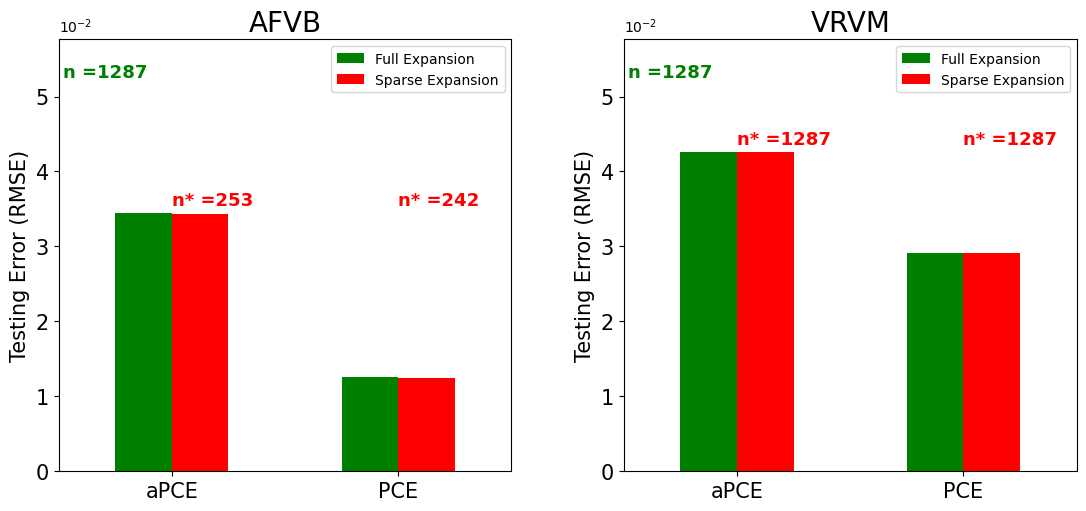

In [879]:
plot_Error(Error_AFVB_Borehole, Error_AFVB_PCE_Borehole, 
           Error_VRVM_Borehole, Error_VRVM_PCE_Borehole,
           100, '$10^{-2}$', mod_AFVB_Borehole.n)
#plt.savefig(wd + '/RMSE_Borehole.png')

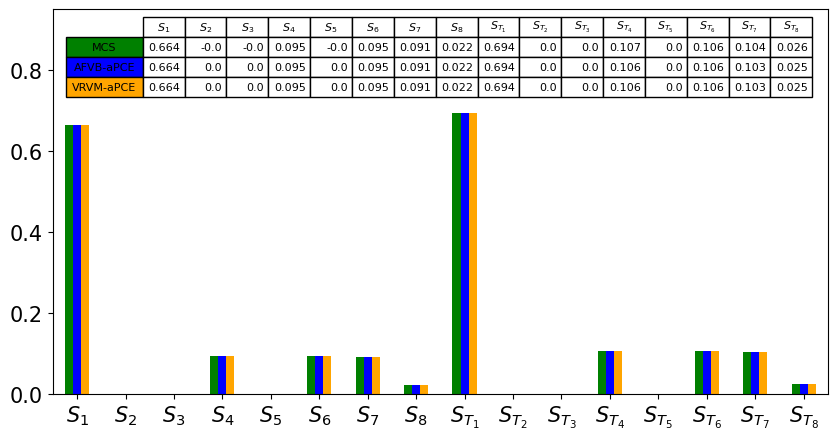

In [880]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$', '$S_7$', '$S_8$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$','$S_{T_7}$','$S_{T_8}$']

plot_Sobol_Indices(Sobol_MC_Borehole, 
           GSA_AFVB_Borehole, GSA_VRVM_Borehole, GSA4 = None,
                   l=l, ylimit=0.95, fig_size=(10,5), table_size=0.45);
#plt.savefig(wd + '/GSA_Borehole.png')

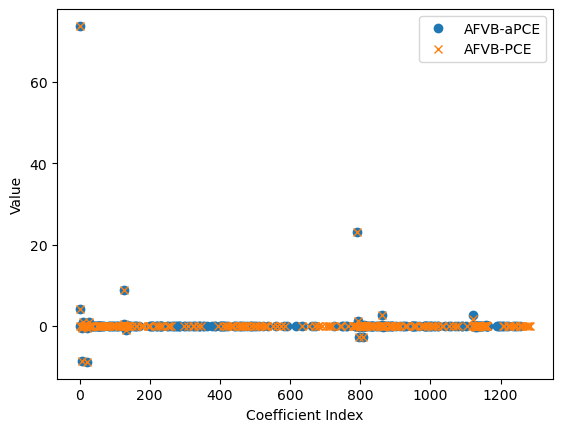

In [881]:
plt.plot(mod_AFVB_Borehole.active_cols, mod_AFVB_Borehole.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Borehole.active_cols, mod_AFVB_PCE_Borehole.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Borehole.png')

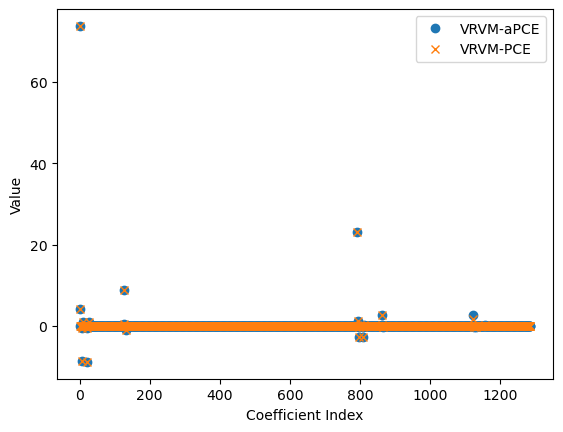

In [882]:
plt.plot(mod_VRVM_Borehole.active_cols, mod_VRVM_Borehole.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Borehole.active_cols, mod_VRVM_PCE_Borehole.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Borehole.png')

# Example 4: 1-dof Undamped Oscillator 

The performance function is

$$
G(X) = 3r-\left| \frac{2 F_1}{m\omega_0^2}\sin\left( \frac{\omega_0^2t_1}{2} \right) \right|
$$

where $\omega_0=\sqrt{\frac{c_1+c_2}{m}}$. The distribution of the random variables are as follow:

\begin{align*}
m &\sim \text{LogNormal}(1, 0.15^2) && \text{Mass} \\
c_1 &\sim \text{LogNormal}(1, 0.2^2) && \text{Stiffness of spring one} \\
c_2 &\sim \text{LogNormal}(0.1, 0.02^2) && \text{Stiffness of spring two} \\
r &\sim \text{LogNormal}(0.5, 0.1^2) && \text{Displacement yielded by one of the springs} \\
F_1 &\sim \text{LogNormal}(1, 0.2^2) && \text{Exciting force} \\
t_1 &\sim \text{LogNormal}(1, 0.1^2) && \text{Excitation time} 
\end{align*}

In [47]:
d = 6  # d --> number of random variables
p = 6 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [48]:
n

924

In [49]:
#np.random.seed(123)
def make_data_oscillator(N):
    X = np.zeros((N, d))
    X[:,0] = np.random.lognormal(1, 0.15, size = N)
    X[:,1] = np.random.lognormal(1, 0.2, size = N)
    X[:,2] = np.random.lognormal(0.1, 0.02, size = N)
    X[:,3] = np.random.lognormal(0.5, 0.1, size = N)
    X[:,4] = np.random.lognormal(1, 0.2, size = N)
    X[:,5] = np.random.lognormal(1, 0.1, size = N)
    return X

In [50]:
X_train = make_data_oscillator(N_train)
X_test = make_data_oscillator(N_test)
X_pol = make_data_oscillator(N_pol)

idx = multivariate_pce_index(d, p)

In [51]:
def Oscillator_Function(X):
    m = X[:,0]
    c1 = X[:,1]
    c2 = X[:,2]
    r = X[:,3]
    F1 = X[:,4]
    t1 = X[:,5]
    
    w0 = np.sqrt((c1+c2)/m)
    
    return 3*r - np.abs(2*F1/(m*w0**2)*np.sin(w0**2*t1/2))

In [52]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [53]:
def basis_PCE_Oscillator(Z, p):
    "Z ~ LogNormal(.,.) as given in description"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    mu_vals = [1, 1, 0.1, 0.5, 1, 1]
    sigma_vals = [0.15, 0.2, 0.02, 0.1, 0.2, 0.1]
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  hermitenorm(idx[i][j])((np.log(Z[:,j]) - mu_vals[j])/sigma_vals[j])
                    
    return Phi

## AFVB

In [54]:
Error_AFVB_Oscillator, GSA_AFVB_Oscillator, mod_AFVB_Oscillator, V_AFVB_Oscillator = Results(Oscillator_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [55]:
Error_AFVB_Oscillator

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000     138         0.000051           0.000371        0.020878   

   RMSE_Test_sparse  time (min)  
0          0.021347    12.49754

In [242]:
Error_AFVB_PCE_Oscillator, GSA_AFVB_PCE_Oscillator, mod_AFVB_PCE_Oscillator, V_AFVB_PCE_Oscillator = Results(Oscillator_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Oscillator, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

## VRVM

In [243]:
a_0 = 0.2
b_0 = 1.0

sys.path.append('..')

data={'xi': X_train}
data['y'] = Oscillator_Function(X_train).reshape(N_train)

In [244]:
Error_VRVM_Oscillator, GSA_VRVM_Oscillator, mod_VRVM_Oscillator, V_VRVM_Oscillator = Results(Oscillator_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [245]:
Error_VRVM_PCE_Oscillator, GSA_VRVM_PCE_Oscillator, mod_VRVM_PCE_Oscillator, V_VRVM_PCE_Oscillator = Results(Oscillator_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Oscillator, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

## MC Sobol Indices

In [247]:
dataA = pd.DataFrame(make_data_oscillator(N_mc)).values
dataB = pd.DataFrame(make_data_oscillator(N_mc)).values

Sobol_MC_Oscillator = MC_Sobol(Oscillator_Function, dataA, dataB)

# Plots

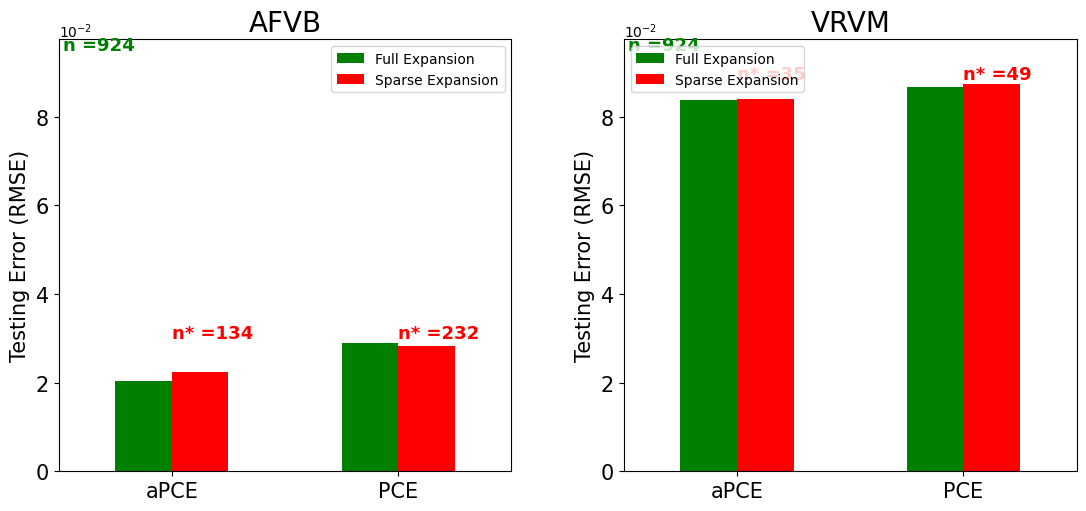

In [494]:
plot_Error(Error_AFVB_Oscillator, Error_AFVB_PCE_Oscillator, 
           Error_VRVM_Oscillator, Error_VRVM_PCE_Oscillator,
           100, '$10^{-2}$', mod_AFVB_Oscillator.n)
#plt.savefig(wd + '/RMSE_Oscillator.png')

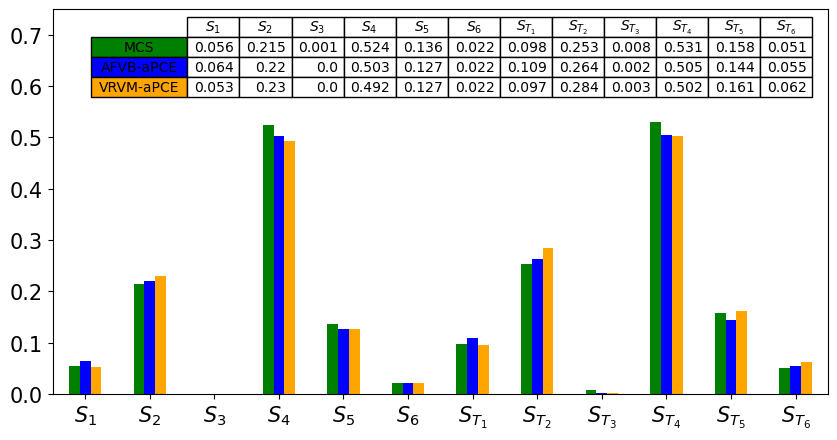

In [499]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$']

plot_Sobol_Indices(Sobol_MC_Oscillator[0], 
           GSA_AFVB_Oscillator, GSA_VRVM_Oscillator, GSA4 = None,
                   l=l, ylimit=0.75, fig_size=(10,5), table_size=0.56);
#plt.savefig(wd + '/GSA_Oscillator.png')

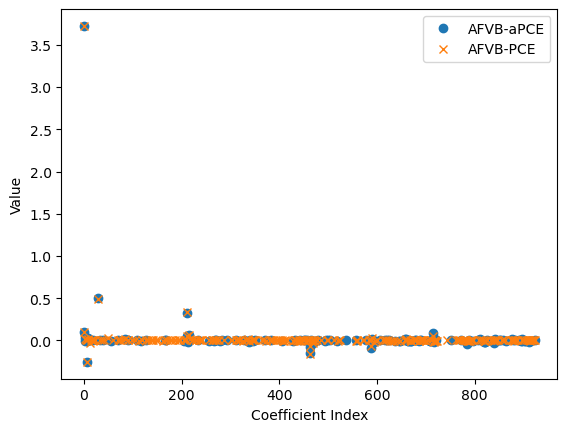

In [500]:
plt.plot(mod_AFVB_Oscillator.active_cols, mod_AFVB_Oscillator.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Oscillator.active_cols, mod_AFVB_PCE_Oscillator.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Oscillator.png')

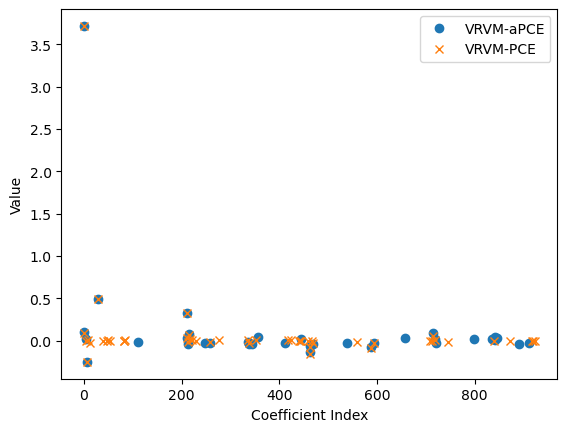

In [501]:
plt.plot(mod_VRVM_Oscillator.active_cols, mod_VRVM_Oscillator.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Oscillator.active_cols, mod_VRVM_PCE_Oscillator.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Oscillator.png')

# Example 5: Cantilever Tube Structure

A **cantilever** is a rigid structural element that extends horizontally and is supported at only one end. The structure is subjected to three random external forces $(F_1, F_2, P)$ and a random torque $T$. The structure fails when the maximum Von Mises stress $\sigma_{max}$ at the fixed end of the tube is greater than the yield strength $R$. The limit state function of the structure is expressed as:

$$
G = R-\sigma_{max} = R-\sqrt{\sigma_x^2+3\tau^2_{zx}}
$$

where 

\begin{align*}
\sigma_x &= \frac{F_1\sin\theta_1+F_2\sin\theta_2+P}{A} + \frac{Md}{2I} \\
M &= F_1\cos\theta_1L_1 + F_2\cos\theta_2L_2 \\
A &= \frac{\pi}{4}\left[d^2 - (d-2h)^2\right] \\
I &= \frac{\pi}{64}\left[d^4-(d-2h)^4\right] \\
\tau_{zx} &= \frac{Td}{4I}
\end{align*}

The **limit state function** $G(X)$ defines a failure criterion that is a function of all random variables $X$. Failure occurs when the load $L$ exceeds the capacity $R$ or when $G(X)<0$. The parameters have the following values:

\begin{align*}
L_1 &= 60 && \text{(mm)} \\
L_2 &= 120 && \text{(mm)} \\
\theta_1 &= 10^{\circ} = \frac{\pi}{18} \\
\theta_2 &= 5^{\circ} = \frac{\pi}{36} \\
d &\sim \mathcal{N}(42, 0.4998^2) && \text{(mm)} \\
h &\sim \mathcal{N}(5, 0.1^2) && \text{(mm)} \\
R_0 &\sim \mathcal{N}(560, 56^2) && \text{(MPa)} \\
F_1 &\sim \mathcal{N}(1800, 180^2) && \text{(N)} \\
F_2 &\sim \mathcal{N}(1800, 180^2) && \text{(N)} \\
P &\sim \mathcal{N}(1000, 100^2) && \text{(N)} \\
T &\sim \mathcal{N}(1900, 190^2) && \text{(Nm)} 
\end{align*}

In [75]:
d = 7  # d --> number of random variables
p = 6 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))

In [76]:
# From first paper
L1 = 0.06
L2 = 0.12
Theta1 = 10
Theta2 = 5

D_mu = 0.042
h_mu = 0.005
R0_mu = 560
F_mu = 1800
P_mu = 1000
T_mu = 1900

In [77]:
def make_data_cantilever(N):
    X = np.zeros((N, d))

    # D, h, R0, F1, F2, P, T
    X[:,0] = np.random.normal(D_mu, D_mu*0.0119, N)
    X[:,1] = np.random.normal(h_mu, h_mu*0.02, N)
    X[:,2] = np.random.normal(R0_mu, R0_mu*0.1, N)
    X[:,3] = np.random.normal(F_mu, F_mu*0.1, N)
    X[:,4] = np.random.normal(F_mu, F_mu*0.1, N)
    X[:,5] = np.random.normal(P_mu, P_mu*0.1, N)
    X[:,6] = np.random.normal(T_mu, T_mu*0.1, N)
    
    return X

In [78]:
def Cantilever_Function(X):
    
    D = X[:,0]
    h = X[:,1]
    R0 = X[:,2]
    F1 = X[:,3]
    F2 = X[:,4]
    P = X[:,5]
    T = X[:,6]
    
    
    M = F1*np.cos(Theta1)*L1 + F2*np.cos(Theta2)*L2
    A = np.pi/4*(D**2 - (D - 2*h)**2)
    I = np.pi/64*(D**4 - (D - 2*h)**4)
    sigma_x = (F1*np.sin(Theta1) + F2*np.sin(Theta2) + P)/A + M*D/(2*I)
    tau_zx = T*D/(4*I)
    
    return R0/(np.sqrt(sigma_x**2 + 3*tau_zx**2)*10**(-6)) # Units in MPa

In [79]:
#np.random.seed(100)
X_test = make_data_cantilever(N_test)
X_train = make_data_cantilever(N_train)
X_pol = make_data_cantilever(N_pol)

Y_test = Cantilever_Function(X_test)
Y_train = Cantilever_Function(X_train)

idx = multivariate_pce_index(d, p)

In [80]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)
P_Stieltjes = mod.Create_Orthonormal_Polynomials_Stieltjes(p)

In [108]:
P[0]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.40798606e+01,  2.00186858e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.00918418e+03, -2.38552695e+05,  2.83975079e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.45474776e+05,  1.75367590e+07, -4.17550750e+08,
         3.31349787e+09,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.04238269e+07, -9.93408838e+08,  3.54976168e+10,
        -5.63672641e+11,  3.35602431e+12,  0.00000000e+00,
         0.00000000e+00],
       [ 4.89272557e+06, -3.33029425e+08,  3.97711090e+09,
         1.88161238e+11, -5.60547626e+12,  4.27032133e+13,
         0.00000000e+00],
       [-5.68305066e+06,  4.06661870e+08, -6.02174978e+09,
        -1.97482044e+11,  7.09707040e+12, -6.95220478e+13,
         1.5643274

In [109]:
P_Stieltjes[0]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.40798606e+01,  2.00186858e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.00918418e+03, -2.38552695e+05,  2.83975079e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.45474798e+05,  1.75367601e+07, -4.17550763e+08,
         3.31349787e+09,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.04705747e+07, -9.97429961e+08,  3.56258122e+10,
        -5.65462552e+11,  3.36521982e+12,  0.00000000e+00,
         0.00000000e+00],
       [-3.99013174e+08,  4.75170234e+10, -2.26313702e+12,
         5.38867673e+13, -6.41450415e+14,  3.05382209e+15,
         0.00000000e+00],
       [ 1.38263582e+10, -1.97629096e+12,  1.17685377e+14,
        -3.73708220e+15,  6.67429108e+16, -6.35647292e+17,
         2.5220626

In [85]:
def basis_PCE_Cantilever(Z, p):
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    mu_vals = [0.042, 0.005, 560, 1800, 1800, 1000, 1900]
    sigma_vals = [0.0004998, 0.0001, 56, 180, 180, 100, 190]
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  hermitenorm(idx[i][j])((Z[:,j]-mu_vals[j])/sigma_vals[j])
                    
    return Phi

# MC Sobol Indices

In [87]:
dataA = pd.DataFrame(make_data_cantilever(N_mc)).values
dataB = pd.DataFrame(make_data_cantilever(N_mc)).values

Sobol_MC_Cantilever = MC_Sobol(Cantilever_Function, dataA, dataB)

## AFVB

In [71]:
param_space = {'A_0': skopt.space.Real(0.00001, 0.1),
              'B_0': skopt.space.Real(0.00001, 0.1),
              'C_0': skopt.space.Real(0.00001, 0.1),
              'D_0': skopt.space.Real(0.00001, 0.1)
         }

In [72]:
t0 = time.time()
optimizer = BayesSearchCV(estimator = AFVB_PCE(basis = basis_aPCE, p = p),
                            search_spaces = param_space,
                            n_iter = 10,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(X_train, Y_train)

print(time.time()-t0)

/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:140: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:140: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:140: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)

/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:140: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)


150972.72714066505


In [74]:
150972/60/60

41.93666666666666

In [73]:
optimizer.best_params_

OrderedDict([('A_0', 0.09096737022686904),
             ('B_0', 0.036338331017918696),
             ('C_0', 0.06870344677300601),
             ('D_0', 0.07996448478724165)])

In [99]:
A_0 = 0.1
B_0 = 0.00001 
C_0 = 0.1
D_0 = 0.1 

In [100]:
Error_AFVB_Cantilever, GSA_AFVB_Cantilever, mod_AFVB_Cantilever, V_AFVB_Cantilever = Results(X_train, X_test, Y_train, Y_test,
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [101]:
Error_AFVB_Cantilever

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000      24         0.000005           0.000217         0.00336   

   RMSE_Test_sparse  time (min)  
0          0.001125   44.650299

In [104]:
idx[mod_AFVB_Cantilever.active_cols]

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 4],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 2],
       [0, 0, 1, 0, 0, 0, 3],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 2],
       [0, 1, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1],
       [0, 2, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 2],
       [1, 0, 0, 0, 0, 0, 3],
       [1, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0]])

In [102]:
Error_AFVB_Cantilever_S, GSA_AFVB_Cantilever_S, mod_AFVB_Cantilever_S, V_AFVB_Cantilever_S = Results(X_train, X_test, Y_train, Y_test,
        AFVB_PCE(basis_aPCE_Stieltjes, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [103]:
Error_AFVB_Cantilever_S

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000      27         0.000005           0.000201        0.003343   

   RMSE_Test_sparse  time (min)  
0          0.000625   39.524697

In [105]:
idx[mod_AFVB_Cantilever_S.active_cols]

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 4],
       [0, 0, 0, 0, 0, 0, 5],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 2],
       [0, 0, 1, 0, 0, 0, 3],
       [0, 0, 1, 0, 0, 0, 5],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 2],
       [0, 1, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1],
       [0, 2, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 2],
       [1, 0, 0, 0, 0, 0, 3],
       [1, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 2],
       [1, 1, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0]])

In [106]:
P[0]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.40798606e+01,  2.00186858e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.00918418e+03, -2.38552695e+05,  2.83975079e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.45474776e+05,  1.75367590e+07, -4.17550750e+08,
         3.31349787e+09,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.04238269e+07, -9.93408838e+08,  3.54976168e+10,
        -5.63672641e+11,  3.35602431e+12,  0.00000000e+00,
         0.00000000e+00],
       [ 4.89272557e+06, -3.33029425e+08,  3.97711090e+09,
         1.88161238e+11, -5.60547626e+12,  4.27032133e+13,
         0.00000000e+00],
       [-5.68305066e+06,  4.06661870e+08, -6.02174978e+09,
        -1.97482044e+11,  7.09707040e+12, -6.95220478e+13,
         1.5643274

In [107]:
P_Stieltjes[0]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.40798606e+01,  2.00186858e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.00918418e+03, -2.38552695e+05,  2.83975079e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.45474798e+05,  1.75367601e+07, -4.17550763e+08,
         3.31349787e+09,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.04705747e+07, -9.97429961e+08,  3.56258122e+10,
        -5.65462552e+11,  3.36521982e+12,  0.00000000e+00,
         0.00000000e+00],
       [-3.99013174e+08,  4.75170234e+10, -2.26313702e+12,
         5.38867673e+13, -6.41450415e+14,  3.05382209e+15,
         0.00000000e+00],
       [ 1.38263582e+10, -1.97629096e+12,  1.17685377e+14,
        -3.73708220e+15,  6.67429108e+16, -6.35647292e+17,
         2.5220626

In [169]:
A_0 = 0.1
B_0 = 0.00001 
C_0 = 0.1
D_0 = 0.1 

In [170]:
Error_AFVB_PCE_Cantilever, GSA_AFVB_PCE_Cantilever, mod_AFVB_PCE_Cantilever, V_AFVB_PCE_Cantilever = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_PCE_Cantilever, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [167]:
Error_AFVB_PCE_Cantilever

N_pol  n_star  RMSE_Train_full  RMSE_Train_sparse  RMSE_Test_full  \
0  1000000      24         0.000045           0.000196        0.634318   

   RMSE_Test_sparse  time (min)  
0          0.000866  812.463429

## VRVM

In [74]:
a_0 = 0.2
b_0 = 1.0

data={'xi': X_train}
data['y'] = Cantilever_Function(X_train).reshape(N_train)

In [126]:
Error_VRVM_Cantilever, GSA_VRVM_Cantilever, mod_VRVM_Cantilever, V_VRVM_Cantilever = Results(data['xi'], X_test, Y_train, Y_test,
        SparseVariationalOptimizer(basis_aPCE, p, 1e-7, 1e-7, 1e-7, 1e-7, a_0, b_0), idx)

In [133]:
Error_VRVM_PCE_Cantilever, GSA_VRVM_PCE_Cantilever, mod_VRVM_PCE_Cantilever, V_VRVM_Cantilever = Results(data['xi'], X_test, Y_train, Y_test, 
        SparseVariationalOptimizer(basis_PCE_Cantilever, p, 1e-8, 1e-8, 1e-8, 1e-8, a_0, b_0), idx)

# Plots

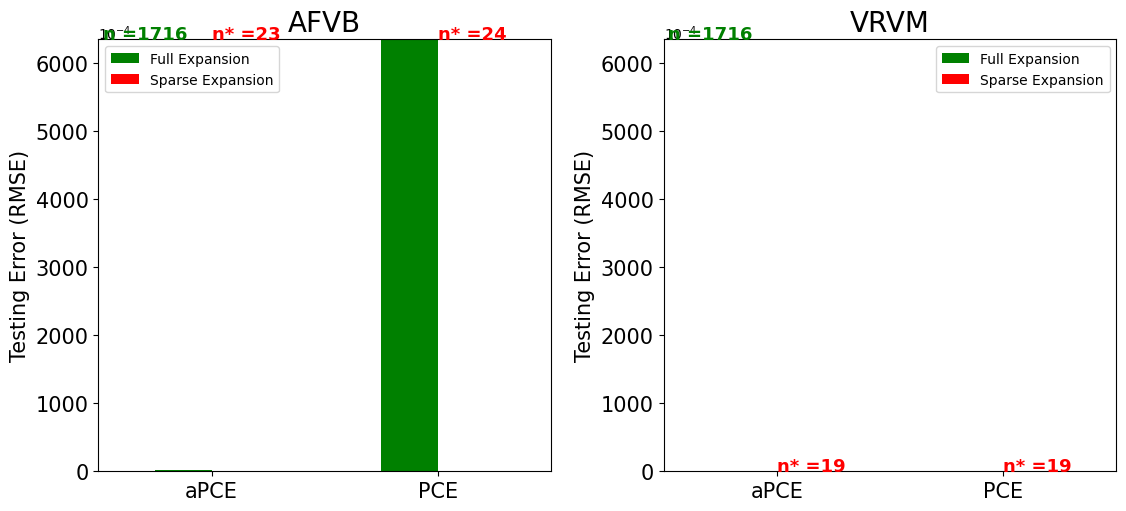

In [168]:
plot_Error(Error_AFVB_Cantilever, Error_AFVB_PCE_Cantilever, 
           Error_VRVM_Cantilever, Error_VRVM_PCE_Cantilever,
           10000, '$10^{-4}$', mod_AFVB_Cantilever.n)
#plt.savefig(wd + '/RMSE_Cantilever.png')

## Activity Scores

In [443]:
def Cantilever(d, h, R0, F1, F2, Pr, T):
    sig_x = (F1*np.sin(Theta1) + F2*np.sin(Theta2) + Pr)/(np.pi/4*(d**2 - (d-2*h)**2)) \
            + ((F1*np.cos(Theta1)*L1 + F2*np.cos(Theta2)*L2)*d)/(np.pi/32*(d**4 - (d-2*h)**4))
    tau_zx = T*d/(np.pi/16*(d**4 - (d - 2*h)**4))
    return R0 - (sig_x**2 + 3*tau_zx**2)**(1/2)

d, h, R0, F1, F2, Pr, T = symbols('d h R0 F1 F2 Pr T')

V_d = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), d))
V_h = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), h))
V_R0 = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), R0))
V_F1 = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), F1))
V_F2 = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), F2))
V_P = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), Pr))
V_T = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), T))

def grad_Cantilever(X):
    
    a_min = [X_train[:,0].min(), X_train[:,1].min(), X_train[:,2].min(), 
             X_train[:,3].min(), X_train[:,4].min(), X_train[:,5].min(), X_train[:,6].min()]
    b_min = [X_train[:,0].max(), X_train[:,1].max(), X_train[:,2].max(), 
             X_train[:,3].max(), X_train[:,4].max(), X_train[:,5].max(), X_train[:,6].max()]
    
    M = X.shape[0]
    d = X.shape[1]
    
    # scale to [a,b]
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    x4 = 0.5*(X[:,3] + 1)*(b_min[3] - a_min[3]) + a_min[3]
    x5 = 0.5*(X[:,4] + 1)*(b_min[4] - a_min[4]) + a_min[4]
    x6 = 0.5*(X[:,5] + 1)*(b_min[5] - a_min[5]) + a_min[5]
    x7 = 0.5*(X[:,6] + 1)*(b_min[6] - a_min[6]) + a_min[6]
    
    # derivative and scale back to [-1,1]
    grad_f = np.zeros((d,M))
    grad_f[0,:] = V_d(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[0] - a_min[0])
    grad_f[1,:] = V_h(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[1] - a_min[1])
    grad_f[2,:] = V_R0(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[2] - a_min[2])
    grad_f[3,:] = V_F1(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[3] - a_min[3])
    grad_f[4,:] = V_F2(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[4] - a_min[4])
    grad_f[5,:] = V_P(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[5] - a_min[5])
    grad_f[6,:] = V_T(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[6] - a_min[6])
    
    return grad_f

In [446]:
M = 10000
X = np.random.uniform(-1, 1, (M, 7))
W_Cantilever, lam_Cantilever, alpha_Cantilever = Activity_Scores(M, 7, grad_Cantilever)

In [447]:
alpha_Cantilever

array([5.93105540e+14, 1.51391391e+14, 2.43178849e+04, 4.10955925e+10,
       7.98963801e+09, 2.09945601e+08, 7.40093316e+15])

### aPCE

In [448]:
def grad_Cantilever_aPCE(X):
    "Z ~ U(-1, 1)"
    
    M = X.shape[0]
    d = X.shape[1]
    
    a_min = [X_train[:,0].min(), X_train[:,1].min(), X_train[:,2].min(), 
             X_train[:,3].min(), X_train[:,4].min(), X_train[:,5].min(), X_train[:,6].min()]
    b_min = [X_train[:,0].max(), X_train[:,1].max(), X_train[:,2].max(), 
             X_train[:,3].max(), X_train[:,4].max(), X_train[:,5].max(), X_train[:,6].max()]
    
    # scale to [a,b]
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    x4 = 0.5*(X[:,3] + 1)*(b_min[3] - a_min[3]) + a_min[3]
    x5 = 0.5*(X[:,4] + 1)*(b_min[4] - a_min[4]) + a_min[4]
    x6 = 0.5*(X[:,5] + 1)*(b_min[5] - a_min[5]) + a_min[5]
    x7 = 0.5*(X[:,6] + 1)*(b_min[6] - a_min[6]) + a_min[6]
    
    n_star = a_hat.shape[0]
    grad_f = np.zeros((d,M))
    for i in range(n_star):
        grad_f[0,:] += a_hat[i][0]*\
                     Pol_eval(np.polyder((P[0][idx_star[i][0]])[::-1])[::-1], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
        
            
        grad_f[1,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(np.polyder((P[1][idx_star[i][1]])[::-1])[::-1], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
        
        
        grad_f[2,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(np.polyder((P[2][idx_star[i][2]])[::-1])[::-1], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
        
        grad_f[3,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(np.polyder((P[3][idx_star[i][3]])[::-1])[::-1], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
            
        grad_f[4,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(np.polyder((P[4][idx_star[i][4]])[::-1])[::-1], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
                
        grad_f[5,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(np.polyder((P[5][idx_star[i][5]])[::-1])[::-1], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
                    
        grad_f[6,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(np.polyder((P[6][idx_star[i][6]])[::-1])[::-1], x7)
    
    grad_f[0,:] *= 0.5*(b_min[0] - a_min[0])
    grad_f[1,:] *= 0.5*(b_min[1] - a_min[1])
    grad_f[2,:] *= 0.5*(b_min[2] - a_min[2])
    grad_f[3,:] *= 0.5*(b_min[3] - a_min[3])
    grad_f[4,:] *= 0.5*(b_min[4] - a_min[4])
    grad_f[5,:] *= 0.5*(b_min[5] - a_min[5])
    grad_f[6,:] *= 0.5*(b_min[6] - a_min[6])
    
    return grad_f


In [450]:
idx_star = idx[mod_AFVB_Cantilever.active_cols]
a_hat = mod_AFVB_Cantilever.a_hat
W_aPCE, lam_aPCE, alpha_aPCE = Activity_Scores(M, 7, grad_Cantilever_aPCE)

In [451]:
alpha_aPCE

array([1.60418335e-02, 4.06541808e-03, 2.26506850e-01, 7.49722509e-07,
       0.00000000e+00, 0.00000000e+00, 2.35563346e-01])

### PCE

In [ ]:
def basis_PCE_Cantilever(Z, p):
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    mu_vals = [0.042, 0.005, 560, 1800, 1800, 1000, 1900]
    sigma_vals = [0.0004998, 0.0001, 56, 180, 180, 100, 190]
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  hermitenorm(idx[i][j])((Z[:,j]-mu_vals[j])/sigma_vals[j])
                    
    return Phi

In [ ]:
def grad_Cantilever_PCE(X):
    "Z ~ U(-1, 1)"

    a_min = [X_train[:,0].min(), X_train[:,1].min(), X_train[:,2].min(), 
             X_train[:,3].min(), X_train[:,4].min(), X_train[:,5].min(), X_train[:,6].min()]
    b_min = [X_train[:,0].max(), X_train[:,1].max(), X_train[:,2].max(), 
             X_train[:,3].max(), X_train[:,4].max(), X_train[:,5].max(), X_train[:,6].max()]
    
    mu_vals = [0.042, 0.005, 560, 1800, 1800, 1000, 1900]
    sigma_vals = [0.0004998, 0.0001, 56, 180, 180, 100, 190]
    
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    x4 = 0.5*(X[:,3] + 1)*(b_min[3] - a_min[3]) + a_min[3]
    x5 = 0.5*(X[:,4] + 1)*(b_min[4] - a_min[4]) + a_min[4]
    x6 = 0.5*(X[:,5] + 1)*(b_min[5] - a_min[5]) + a_min[5]
    x7 = 0.5*(X[:,6] + 1)*(b_min[6] - a_min[6]) + a_min[6]
    
    n_star = a_hat.shape[0]
    grad_f = np.zeros((d,M))
    for i in range(n_star):
        grad_f[0,:] += a_hat[i][0]*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][0])))[::-1], (x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])
            
        grad_f[1,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][1])))[::-1], (x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])
        
        grad_f[2,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][2])))[::-1], (x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])

        grad_f[3,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][3])))[::-1], (x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])

        
        grad_f[4,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][4])))[::-1], (x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])

        grad_f[5,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][5])))[::-1], (x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])

        grad_f[6,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][6])))[::-1], (x7-mu_vals[6])/sigma_vals[6])

    #grad_f[0] *= 0.5*(b_min[0] - a_min[0])
    #grad_f[1] *= 0.5*(b_min[1] - a_min[1])
    #grad_f[2] *= 0.5*(b_min[2] - a_min[2])
    return grad_f

In [ ]:
idx_star = idx[mod_AFVB_PCE_Cantilever.active_cols]
a_hat = mod_AFVB_PCE_Cantilever.a_hat
W_PCE, lam_PCE, alpha_PCE = Activity_Scores(M, 7, grad_Cantilever_PCE)

In [ ]:
plt.plot(W_Ishigami[:,0],'o-', c = 'b', label = 'Function')
plt.plot(W_Ishigami[:,1],'x-', c = 'b')
plt.plot(W_PCE[:,0],'o--', c = 'r', label = 'PCE')
plt.plot(W_PCE[:,1],'x--', c = 'r')
plt.plot(W_aPCE[:,0],'o--', c = 'y', label = 'aPCE')
plt.plot(W_aPCE[:,1],'x--', c = 'y')
plt.legend()

In [ ]:
plt.plot(lam_Ishigami,'o-', c = 'b', label = 'Function')
plt.plot(lam_PCE,'o--', c = 'r', label = 'PCE')
plt.plot(lam_aPCE,'--', c = 'y', label = 'aPCE')
plt.legend()

In [ ]:
alpha_df = pd.DataFrame([alpha_Ishigami, alpha_PCE, alpha_aPCE]).T

In [ ]:
alpha_df.index = ['$a_1$', '$a_2$', '$a_3$']
alpha_df.columns = ['Function', 'PCE', 'aPCE']
alpha_df

In [ ]:
alpha_df.plot.bar();

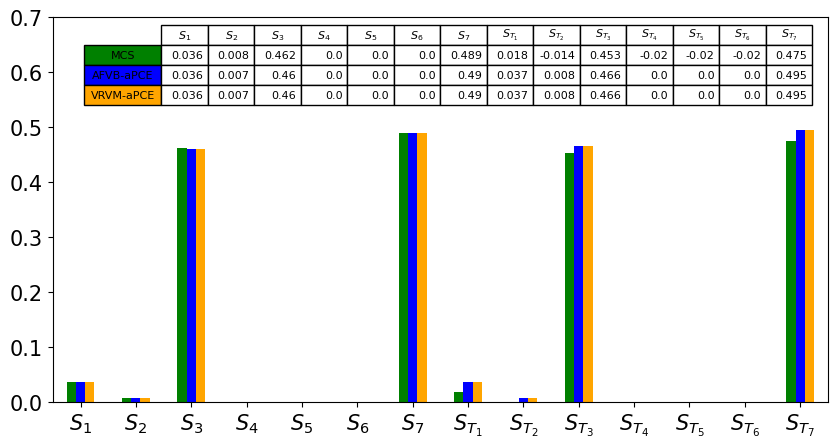

In [112]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$', '$S_7$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$','$S_{T_7}$']

plot_Sobol_Indices(Sobol_MC_Cantilever[0], 
           GSA_AFVB_Cantilever, GSA_VRVM_Cantilever, GSA4 = None,
                   l=l, ylimit=0.7, fig_size=(10,5), table_size=0.5);
#plt.savefig(wd + '/GSA_Cantilever.png')

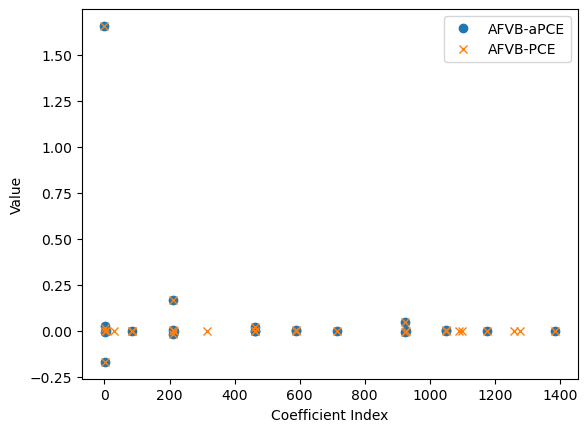

In [113]:
plt.plot(mod_AFVB_Cantilever.active_cols, mod_AFVB_Cantilever.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Cantilever.active_cols, mod_AFVB_PCE_Cantilever.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Cantilever.png')

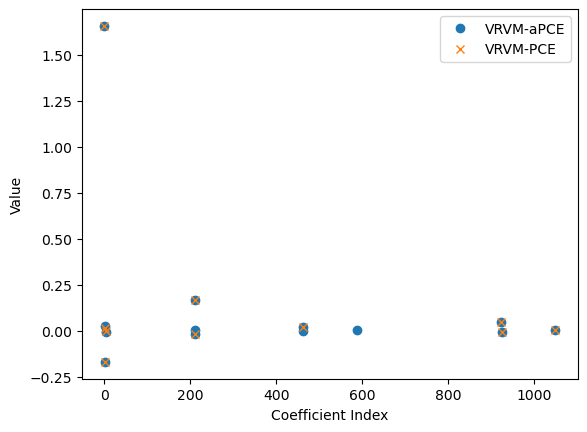

In [114]:
plt.plot(mod_VRVM_Cantilever.active_cols, mod_VRVM_Cantilever.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Cantilever.active_cols, mod_VRVM_PCE_Cantilever.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Cantilever.png')

# Example 6: Sobol' function

The Sobol function is given by

$$
Y = \prod_{i=1}^d\frac{|4\xi_i - 2| + a_i}{1 + a_i}
$$

where $\xi_i$ are independent random variables uniformly distributed over $[0,1]$ and $a_i$ are the constants. 


In [302]:
d = 8  # d --> number of random variables
p = 5  # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [303]:
X_train = np.random.uniform(0, 1, size=(N_train, d))
X_test = np.random.uniform(0, 1, size=(N_test, d))
X_pol = np.random.uniform(0, 1, size=(N_pol, d))

idx = multivariate_pce_index(d, p)

In [304]:
def Sobol_Function(Z):
    alpha = np.c_[1, 2, 5, 10, 20, 50, 100, 500]
    return np.c_[np.prod((np.abs(4*Z - 2) + alpha)/(1 + alpha),1)]

In [305]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [306]:
def basis_PCE_Sobol(Z, p):
    "Z ~ U(0, 1)"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])(2*Z[:,j]-1)
    return Phi

# MC Sobol Indices

In [307]:
dataA = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values

Sobol_MC_Sobol = MC_Sobol(Sobol_Function, dataA, dataB)

In [308]:
# Analytical Sobol Indices
GSA_Sobol = ([0.6037, 0.2683, 0.0671, 0.0200, 0.0055, 0.0009, 0.0002, 0.0000], 
             [0.6342, 0.2945, 0.0756, 0.0227, 0.0062, 0.0011, 0.003, 0.0000])

GSA_Sobol = pd.DataFrame(GSA_Sobol).T
GSA_Sobol.columns = ['1st Order', 'Total Order']

# AFVB

In [309]:
Error_AFVB_Sobol, GSA_AFVB_Sobol, mod_AFVB_Sobol, V_AFVB_Sobol = Results(Sobol_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [311]:
Error_AFVB_PCE_Sobol, GSA_AFVB_PCE_Sobol, mod_AFVB_PCE_Sobol, V_AFVB_PCE_Sobol = Results(Sobol_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Sobol, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

# VRVM

In [313]:
data={'xi': X_train}
data['y'] = Sobol_Function(X_train).reshape(N_train)

a_0 = 0.2
b_0 = 1.0

In [314]:
Error_VRVM_Sobol, GSA_VRVM_Sobol, mod_VRVM_Sobol, V_VRVM_Sobol = Results(Sobol_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [315]:
Error_VRVM_PCE_Sobol, GSA_VRVM_PCE_Sobol, mod_VRVM_PCE_Sobol, V_VRVM_PCE_Sobol = Results(Sobol_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Sobol, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

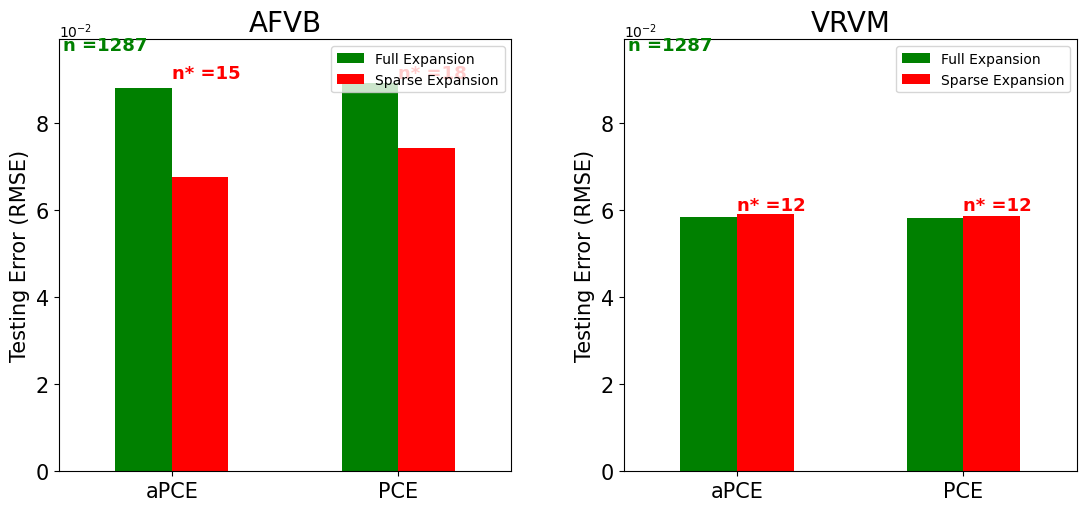

In [510]:
plot_Error(Error_AFVB_Sobol, Error_AFVB_PCE_Sobol, 
           Error_VRVM_Sobol, Error_VRVM_PCE_Sobol,
           100, '$10^{-2}$', mod_AFVB_Sobol.n)
#plt.savefig(wd + '/RMSE_Sobol.png')

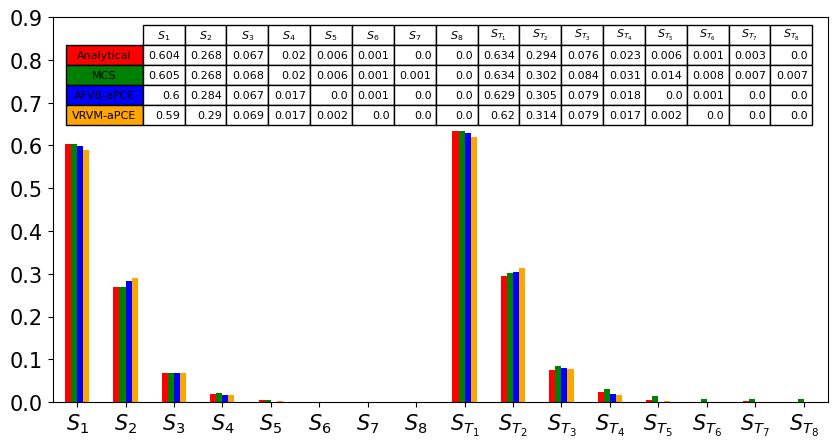

In [511]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$', '$S_7$', '$S_8$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$','$S_{T_7}$','$S_{T_8}$']

plot_Sobol_Indices(GSA_Sobol, Sobol_MC_Sobol[0], 
           GSA_AFVB_Sobol, GSA_VRVM_Sobol,
                   l=l, ylimit=0.9, fig_size=(10,5), table_size=0.45);
#plt.savefig(wd + '/GSA_Sobol.png')

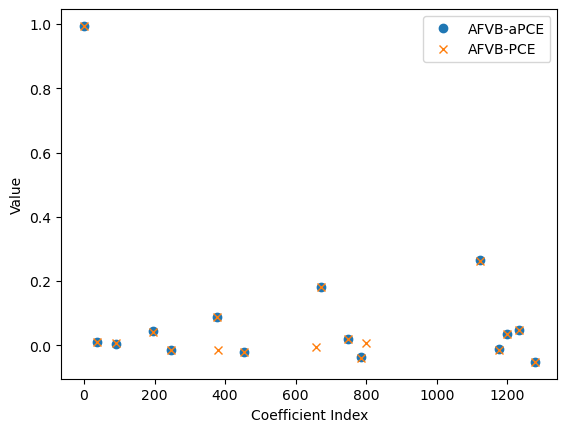

In [512]:
plt.plot(mod_AFVB_Sobol.active_cols, mod_AFVB_Sobol.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Sobol.active_cols, mod_AFVB_PCE_Sobol.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Sobol.png')

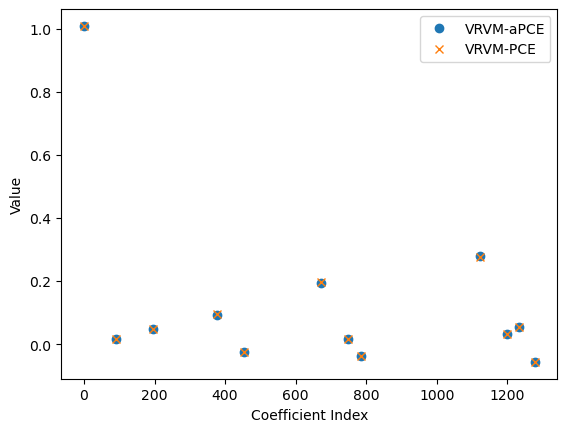

In [513]:
plt.plot(mod_VRVM_Sobol.active_cols, mod_VRVM_Sobol.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Sobol.active_cols, mod_VRVM_PCE_Sobol.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Sobol.png')

In [514]:
sns.kdeplot(mod_AFVB_PCE.Sobol.predict(X_test, active_cols_pce).reshape(N_test), color='b', label='AFVB_PCE')
sns.kdeplot(mod_AFVB.predict(X_test, active_cols).reshape(N_test), color='g', label='AFVB_aPCE')
sns.kdeplot(Sobol_Function(X_test).reshape(N_test), color='r', label='Sobol Function')
plt.legend();

NameError: name 'mod_AFVB_pce' is not defined

# Example 7: PDE

In [602]:
d = 2  # d --> number of random variables
p = 12  # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [ ]:
X_train = np.random.normal(9/10, 1/4, size=(N_train, d))
X_test = np.random.normal(9/10, 1/4, size=(N_test, d))
X_pol = np.random.normal(9/10, 1/4, size=(N_pol, d))

idx = multivariate_pce_index(d, p)

In [ ]:
def PDE_Function(Z, t = 1):
    
    return -np.exp(-Z[:,0])*(t + (t - t**2/2)*np.exp(Z[:,1]))

In [ ]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [ ]:
def basis_PCE_PDE(Z, p):
    "Z ~ N(9/10, 1/4)"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  hermitenorm(idx[i][j])((Z[:,j]-0.9)/0.25)
    return Phi

# MC Sobol Indices

In [ ]:
dataA = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values

Sobol_MC_PDE = MC_Sobol(PDE_Function, dataA, dataB)

# AFVB

In [ ]:
Error_AFVB_PDE, GSA_AFVB_PDE, mod_AFVB_PDE, V_AFVB_PDE = Results(PDE_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [ ]:
Error_AFVB_PCE_PDE, GSA_AFVB_PCE_PDE, mod_AFVB_PCE_PDE, V_AFVB_PCE_PDE = Results(PDE_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_PDE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

# VRVM

In [ ]:
data={'xi': X_train}
data['y'] = PDE_Function(X_train).reshape(N_train)

a_0 = 0.2
b_0 = 1.0

In [ ]:
Error_VRVM_PDE, GSA_VRVM_PDE, mod_VRVM_PDE, V_VRVM_PDE = Results(PDE_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [ ]:
Error_VRVM_PCE_PDE, GSA_VRVM_PCE_PDE, mod_VRVM_PCE_PDE, V_VRVM_PCE_PDE = Results(PDE_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_PDE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

In [ ]:
plot_Error(Error_AFVB_PDE, Error_AFVB_PCE_PDE, 
           Error_VRVM_PDE, Error_VRVM_PCE_PDE,
           100, '$10^{-2}$', mod_AFVB_PDE.n)
#plt.savefig(wd + '/RMSE_PDE.png')

In [ ]:
l = ['$S_1$', '$S_2$',
     '$S_{T_1}$','$S_{T_2}$']

plot_Sobol_Indices(Sobol_MC_PDE[0], 
           GSA_AFVB_PDE, GSA_VRVM_PDE,
                   l=l, ylimit=0.9, fig_size=(10,5), table_size=0.45);
#plt.savefig(wd + '/GSA_PDE.png')

In [ ]:
plt.plot(mod_AFVB_PDE.active_cols, mod_AFVB_PDE.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_PDE.active_cols, mod_AFVB_PCE_PDE.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_PDE.png')

In [ ]:
plt.plot(mod_VRVM_PDE.active_cols, mod_VRVM_PDE.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_PDE.active_cols, mod_VRVM_PCE_PDE.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_PDE.png')

# Hyper-parameter Tunning

In [873]:
from bayes_opt import BayesianOptimization, UtilityFunction

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define the black box function to optimize.
def black_box_function(C):
    # C: SVC hyper parameter to optimize for.
    model = SVC(C = C)
    model.fit(X_train_scaled, y_train)
    y_score = model.decision_function(X_test_scaled)
    f = roc_auc_score(y_test, y_score)
    return f
# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"C": [0.1, 10]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 4)
optimizer.maximize(init_points = 5, n_iter = 10)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))